In [30]:
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from scipy import ndimage

from keras.utils import to_categorical
from keras.datasets import mnist
from keras_preprocessing.image import ImageDataGenerator

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [25]:
old_shape = x_train.shape
x_train = x_train.reshape(old_shape[0], old_shape[1]*old_shape[2])

old_shape = x_test.shape
x_test = x_test.reshape(old_shape[0], old_shape[1]*old_shape[2])

# Correlation Matrix Before PCA

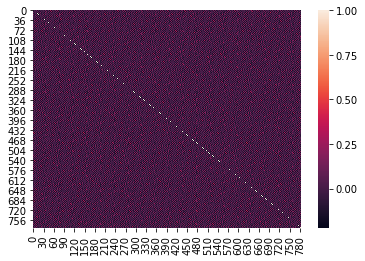

In [28]:
import seaborn as sbs

_shape = x_train.shape

corr_mtx = np.corrcoef(x_train.reshape(_shape[1], _shape[0]))
sbs.heatmap(corr_mtx)
plt.show()

# Applying PCA

In [5]:
pca = PCA(n_components = 28)
x_train_pca = pca.fit(x_train)

x_train = x_train_pca.transform(xdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQUAAAD8CAYAAAB+fLH0AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsvGeTXOl15/m7NzNveldV6asqy6HgTcHbBtBooLuBJrubbDppKD9SzIZmd7WK3djdz7AbExO7ipmRoSxFqUWyPdrDNrx3hbJZJn1WVnpv7t0XDxokJ0ISd0KMoSJwIvCiKpB5bz32/M05kqZpPItn8SyexZch//d+gWfxLJ7FL1c8OxSexbN4Fj8Tzw6FZ/EsnsXPxLND4Vk8i2fxM/HsUHgWz+JZ/Ew8OxSexbN4Fj8Tv5BDQZKklyRJmpYkaU6SpP/9F/GMZ/EsnsUvJqR/aZ+CJEk6YAY4DsSAG8B3NE2b/Bd90LN4Fs/iFxK/iExhNzCnaVpE07QW8HfAq7+A5zyLZ/EsfgGh/wV8ZwiI/tTPMWDPf/2fJEn6XeB3AawWaYeu46FrVdBVW7SdCoZCC81kQKq3UM0KckelY9Ghr3bomnRIXfE9ckf9yZdqGqpBh6RpIEmgaXRMMoZSS3x3pYVqNiDXmnTtJnSVFl2rAV2tQ9tpwFBo0nYZMRTbdC16dNX2k8810cwKUr1Fx2FEX2nTdhjQ11WQvnw2SF0VNNB0EpKqoSo6JA1UnYSu0aFj06OvdFANOuRGC81oQGp2aLsUDMUWHZuCvtKi2atgzDbp2I3oyy1UiwG52qLtNmLIN8V4tDp0bAb0xQZduwm5o4GmgarRNenQ1zritXTyz7xjxyxjKHfE31f/ybt0bUZ05SYdp3hm26lgyDdp9xgx5JqoVgW52qJrF/+v6TViXGnStRrRVVt0nAr6YhPVoiBXm6gWI3KrS8eqR1/roioyUldDk6SfzJmqgiShGnQ/WRdAxyj91Jw9+XtrTboOE7ovx6Peoe0yYMg16DhN6MstuhaDmDObgq7cFOPb6tCxK+irbTo2A7qGiiZLYo1oIKmaeA9Z3I+qQRZzqJfQNbpP15xm0P1kLdafzEWxTcduQF9q0epVULJPxqn+ZN2Um0/mrCHGo95+Mk5i3UndJ1PTVcWcVTsgPZmznwoxZ23x99U7qIoOudai63gyZ1+uSbsBQ7El1lPhy3XzZK2Xm5Q6K1lN0zz/3Ab+RcCHN4CXNE37nSc/fxfYo2na7/9jn3EafVp+ycHJiROUDg3jvJGgMebFNJUk/rUhQj+M0FgfwrSQJXMkiPdMjPK2AEpRDKKSqVIdcWJ7kEKzmOi4LagGGbnVRTPIFEZMeC6vUB3vwRyr0rUaMMwmKB8YxnF5kZWXRvCcT5A4FSL4owjxb4wQ/P4U1X1j2O7GKezrx3l2joXfX8vIf4mQf24I97UEmaMhvB8t0FgfevosJVEiu89Dz6MKUrtLq9cMGhjyDaRuF6nRRlMMtHxWJFVDbnbRZInimBnPZ8uUdvXjuBmnFe7D8HiZ/Ilxes4uUN/Uj2kxR/xUgP43I6y8OEzfpTSVDX3Yry9T3j2I7fw0rW2jGGdTFA4M4rqRJP1CkN4HVdo2gzgoJAl9vgZdFc2sgKbR7jEjqRr1PgXbUpXcRjueM1GaY16UyRit9f0YpxNUJwawPkhS3B3C8cUC0V8bY/BvIuSODOG+kaY23of19jKJr40SeHOa5pYhTLNpMi8M4D0bp7gjgGm1jaqXMGbrlMYduK4nUG0Wug4jaIAEqqJjdZOJwEdJihNeHI+LdFwmDI+XxZzcibFyPIznbIzEKwME31ki+coggfeXaaz1Y5pOkT8wgPv8Aku/MUr4LyMUDg3hupEk+VKQwPtRGuM+dLUOHbsB02Ke7H4vPY8qyLUWTZ8NAGW1BpqG1GiDJNEMOdE1OmgGma5BprBGIfBxkvwuP+5LUdphD4ZIiuL+MM6rUSrb+7FOZUke9xP88TzJ10YIfJygssmH7W5CrKvzERpbBzFPJinu7cdxb4X08z7c0026RhldU0XqqOgLDaRGE9VuQVJVmj4rulqHZp+CdbFCfpODnqtpWv1ulMcx2muCKAsZyjv7sT/IUN7s5dLb/9stTdN2/nN7+BcBH+LAwE/93P/kd/9odK0KJydOcPrOJzguLrB6KIRpfoX0y2GCP5imuTaI3FWpr/HguZ4j83w/1vmSuJl0Ei2vFctSCdVlY2VPL/pMCU0noSo6UMH7yRLpIx5sjzLUwlaUxRWWfnsM+/lZ8oeH8ZyNUd7iI/APcyRfHSb4g1liv74O28MU6ZcHcV2OUjkwyvAfzdIaC+CYK1PcGcBzeYXE6yPo6k9uZUmiFXTQd2UFqd6muNaBodBAUjWaXjOVMSeaWWFlrxtTJIsmS+hnE6iKDs+nS1S2hXDcS1PcE0KZSzL/B2vpuRil8Nww5vkstTV99P9wkdZ4AM/HCzQH3dhvxckeH8Y2k6f0wjq6Rpn6+gD22TKq04r3bApduYmuIVIr1SDT7rWSOehBarYpjTswzqbpGnU4zsxQGrPh+XyZ8vYgxqUciW+OoTxYJPnaMNapFSrbgjivxykcHWHge1Ms/uYIPecWye/yYX2UIvXqCMF3FmmvG0BudWms8eG5miV9PIRjqoC+3ETuajS9FuyRCqrNQma/G32hTtesF7d3RyXwgykyR/24bqaoh+0oCxnm/te1WK8tUN7Zj+ezZaob/AR/HCF1ahD/j+ZIvBbGuJwnc2IQ96UopX1DhP9intZYAHukQmmbn8CHcdIvDmAotdAUWRwMHjt9V1aQizXyW90o2SqaDK1eC7WwA82skN3nwbSQpWvSY5iMIakQeCtCdb0H9/UkuUMDGJazRH5vBOe1GMV9A9juJqiN9xL4wWMaG/rx/3CGxkgf1scrZI4P4JgqUN09hNTV6PT3Yp8toVmM+M5mUJIllGILVS/WcdduJHkigC5XorjOiXkmg2rUYbu0QHXIRu+5KNV1HpR0mdTXRlHmkiS/GsZ+L0V1rQf73eTPvYF/EYfCDWCNJEnDkiQpwLeBd/+pD+iqLUqHhp8eDD0fz1PYHcT3sdiMxtkUmixhfhCj3m/Hez5Jbrsbqdul5dSjSRJdmxGAvht5kCSMsSJSR0XTS7SGvfRMNsgcCWB7nKO4t5+h783TGR/A9fFjyhMB7HeTVHcN4f8sRerrY/R/7xHJl0P4PktQ2xTEfn2Z3IlRDI+XQZZxXolS3NpH8MM4q5stIAmIILdUmiEnUreL+3oSqdlFX24CYCh1QNPwXM2TORLEGCvSmAijq3doDXux3Vxi5bkAjrsZckeHGfvPyyx+N4zz02lKE36sDxJUtvejzCRJvD6CaTJO9Ftheq+kyezvw3FxgbZNh+nuIh2XEU2SyO/yQadLfq0ZAKmrIXVV3DMNkCScd1co7whhipVoToxgSbeobAthu7pI5kiA0LtRGhPD+N+cJvp6ENuNJWobA7ivJSm8MM7QXy8T+d0Rei4sU9gdxH86Sm1zCMNsAtWowzQZoxl04D2bIrO/B6ndpekyILcFdNBMenyXctBVMabKqCYdSBKddYP0PqiSfCmIZaFI9vkwY/9hnubmQWyX5invDGG9s0x9cz++i6uk3hgj8HfTJF/04/08RnVLEMeNGMWDQyizCTS9jONOkvyeIL5PY2S32JBaKqqiQ1VkGmEXSBLuGxk0nQ5TsiLmrNxBk2V6HpRIPx/EmK7Q2DqI3FZprg9hub5I8sUgPZfjFPaGGPnzKAu/GcZxbo7Cvn6sj9JUD67B+ChK6hvjmCbjJE8E8FxMk9nnxnYnTtOlR7eQotVrAaAw4QFNY2WbFX21g9xVQZbw3K2iWUy47q9S3BHAmKrQXtePvqZS2tWP7U6M1Z19BE7HxCH05jSx1/qxPkzSHPlnUcPT+Bc/FDRN6wC/D3wMPAbe1DTt0T/1mbZTwXkjQe74CCe3Huf0vU9xfjRJfn8/trNTlHYPoNyZJ/bNEczX54mfCtJ3IU5mnxvHmRkafQb001FavWakdofsPi9So0l6twW50UXSQG536ZmsIrU74llHh9GVm7S2jaIUOuQOhLBenSd9zE/gvSWa28fw/2CS5TdCmK/NUtobpuezCKsnx5EmI0z/wSDO8xGyh4L4P1giv86EfiZGy2XAeH+RRsiBphhY2edG6qi07Tp0TZV6yI7U7dJ3I4/UaGJaKoAsIWlQ2zqAc6FB8qUAPReWyR0aIPy9ORo7RrCfmRKL7PIcpb1hgm9FiH1rhNAfPyDxsh/f6QVqO8I4zs2SfWUc5c48rV4T7s/mKUz04ft4mdVNFpCh4TEiNzs0A3YA7A8yaIoeY7yIJkkYqh0KR0bou1Ugfbwfc2SV+q5RQv/5HvVN/ZhvRkicDOE6M09+fz/D/+8U0/9zGOdnM2ReGMB8Y57KviGMN2aJ/uooxltzJE4G8J1eIrPXjf3CLDWvgjy9RNdqQNNJ5Hb1QafLyhYTaBqaBKgaffdqSI0WfV8kWD0xijFVprUpjDHfJnd0GNONedIHewm8H6W2a4TA3zwi/tUBLNfmaa7x4bwWZ+WlEeQH80R+vR/XuQi5/SF8n0TJ7LRivLeApGqYbszTCLuQuiqrEw5Uk55mjx4k6LiMyMUa3iur0GxhWswJ3qitUt8epvdRg/hXB3DdTJF9rp/hP5mnsW0I5yePKe4MYDn3mPL+YQIfxol+Z4TA3z4iftKP/90FkR2emSF3fATj7TlavRZc5yIUJjz435pnZYcVqa3StouDtBlwQLuD40EW1aKgz9cBMOVa5A8N4n5cJnFqAGOqTGPHCKHvPaSxxofyMPpP7MCfjX9xTuG/JZyKT9t++A8wza9Q2B3E+dEkp6cucGrXSVaPDNJ7KcHKkRCejxdojfpR5lO0xgMYMhWye/roeVCiNGbHnG2jSaCsNpDaXeRqHU0x0BhwomuqAh9qsLLVQvB0jPzeIO4rcVpDfRim4oLPuLREddsA1odJEl8ZJPAPs6S+PkbgkyT1sT7MjxKU9gxgPztDe8sQhskYxaOjOB+sktnfh3uugaqX0ZdbaHoZ/WoVVBXVZkbSNNouE1JXo+5VsM+VyG9y0nMzS2PAieneMs3Ng5imk2ROhPGeS1DY6cd5f5Wlr3sJ/8kshedHcV9LUB/3Yr4fJf6NUUJvL9Mc82JcXCV9LIjv/QjFA0OCc0GMR2XUhuPBKppBT9cpNh4AkkRhzEzflQylLX3YZ4q0ey0odxconFiL61yE1Ouj+D9LkXwpQPCH86S+OoL/0wTV9V4s83mKW/twXVxk4bdGGP5+jOLOAM6bSTJHQ3jen6O9rh9lLklzXRAlXSGzvxfPjQLVYTv6ShdkCSXfhI6KXBNZVbPfia7RpWvSIXdUcmtN+D+Jk98TxH0pSnPMh/IoSunwCM6bSerjXkwLOZInBKRIvjaM//wqtbAT651lSvuHsF9aeMqP5I4O4b6RYeWQD9eM2FhSVwMJwbkAqkVB6qg0PRYkFVouPbaZItndbjxXsjSDDowPo7TW96M8jrFyahTPxTSlrR6ct1IsfjtE+HtzrJ4Ype9CjPoaL6YHUTJfHcX3vuCiTIurpF4I4D+9TGFfP6bVDvpKC7nZobTWifPuCuhkunYTmkEnSNKuSm6DBe+VHIVNbhxzZboWBcOMgHXuSzHB45xLkDgZIvDDOZJfH+P+H/0v/904hf/foZkMmKaSpF8I4boSo/DyBk7tOskHN07Tc3pa4PfzCarbBlDmU6RfGUaZz9AIOfBcSJKdcOA+L1JnZImuTUEz6ChN+EHTMCXKQhmQJKR2F8+9GpmjIdzXkuT3htCv1mlsHcRxPkJpXxjrgwTJUwMEP4yT+voY/rfmSR0PYL4fpTLRj+NGnOIL4xim4iz8uzW4Li5SXt+D72ySwogJ06MYzV4Tmk6mFXSAQc/qNgeoKi2nHtUgY1pto8ky7odFkCVM0SLNzYPoGh2aa/y4p2ukTgRxXYlRWdfD0PejtDYK8qywO4h5MkllZ5jQu1FSLw+gTMaIfyWE90KG8h5BdHV+Cko4byYpb+xFanfIrRPkZ9uhgKrhmquDJOGYzKMZDegLTeq7R7HGG5QODuO7nCdz1E/wvSiNjf3431ugHXRjuR5hZb8H15UY+eeGGP5+jKVv9eM4N0d+jyCEKweGUeYE3FEmYzQDdnyfxVnd5sJ+J0nLpReKiUWPpGnUxtygqgL+dVV09Q66WofeBzUyz4dwPcxT3NOPIVujuWUQx7k5qht8mKfTrBz0ETwdJ/WVYfw/nCN9qBfr/TjV7YM4rkUpHxhGebjEwm+N0HN+mdIWD95PoxTGzSgLGboWPUgSba8NJIncJodQtIxCwTHm2qCX8VzLgaphTJRobhxAbqvUJ8L0PKywcsgnxnqrj6G/XqKxdZDe09Pk94YwT6ep7hrCey5N+pVhjA+WSR8L4P8kTmVbCNfVOK0nUKLpseC6HKW0WWRQq1sE+YksFBP3dAM0DdedFQFRSw1a6/uxpFqUdobou5EnczRI8P0oja2DBN6c/rn34y/FoSDVW8S/NoT37RnK24O4Ppxk9cggJzce5fSjswK/b/djnUyR+sow3nfnqW0KYqi0aQ248Z5Pkz0+gnWx/CQdh3aPCfujVTSLkcy+XvSrVbpm3ROpUMbz/hyJUyHcFxaprHFivh9l/n8aw35mityhAXzff0h1gxf/D2eI/8oYvh/NkHhjFNvdOKmTAzgvLFA4OsLQ/3WXxoYQtvkShZ1+PJdXSL42Iljjrorc6NJxW/BczSJXGlgXyxjjRQA6TiOVEQeq1Uj6sAfTdBLVqEN5HEMzyPh+8IjyzhD2W3EKu4Moj2PM/fsRXJejrB4ewHYvQWVLAN+bkzQ3DhD8q0e0gk7stxOkToWxzpUoHRkDDerjXuzTBTSTAe+FNPpSA0OphdRV6Zh1tD02ks/3IbU6VIdtmG8toBp1OM7NUhlz4n1rhsrmAKapJLFvjaCfiZP89lq8Hy2Q39+P+/wCxZ0BBv/4MXN/OI7rXITytgD2GzESXxsh+FaE+kQYuaVSH/PguZgkfaIf+1QR40oNVS/TdpuwzOZQHWYyBz3oinW6JqGaq0YdnnemSR/swXkzQWXcifHeInN/OI7leoTcgRCe0/NU13vx/cMU8V9Zg/+dCKlXwljvxUm/FMZ+aYHSkTGG/ugRtU1BHFMFintCeM8mSH5VvJvUVZFaKh2nmb7LaaRGG8tCEWOihKrItF0mymtdqHYTmYN9mCZjqAYZ880IXYsBz3tzlLf5sV9bJvfcAObHKWb+TzEe+f0C91fX9eF7f4HaziG8b83QGPFguxsnfWIA23yJ4tFRdI0ulYkQ9tkiKAZ8nyfQ56pIHQ2po9Kx6ml7rGQOeZGaLSqjDoxzaaSuhv3cDNUxB97TESpbApgfp0j8ytqffz/+MsAHu6NfO2h/nebaIMbZFKXdAzjuJEUaeiXKBzdOc2r3KQr7+nHdSFJd78Nye4nG5gHMD2M014cwLmRJHwvhuVmgMuJAKXaQVA1DoYEmSeiKVTSTQsdlRjXqnvgKNPLrTHi/yFJe14PjtpBCjQ+jFI6M4L6wSG1LP5aZFVIngvjfiZB8bQT/52mq6/qw3VymcGgI55lZIb8tZMnvDuC+nmTluSDOSEMcu13hWTDGi6zu8dBzO4+kaTT9NjSdhCleRtPLZLe78FwVaancUukaZUz3lkl+Yw3B95Yp7A3h+mKJhd8eYei/CCjhOjNPbfcQ1nsJ4l8LE/zBLJnXxvB9liD9QhDf+wuU9oWxn5+lMTGMMVunPGrH8SBLdr8X51xdkI+aRtekR8lUoKtS2NaH60GOls+G1NFo9hqwX11i5cUR+i6laIZ7REa0PoTyMCre4WGK/N4Q7i+Wmf+9MKPfi1PYFcB1PUFtnQ/LvSittUGUmaSY6+UcmSMB+m7mqYw6UUpP4E62hibLyBWRwXQ8dlRF3F9ys0tuowXv+YyALVfjNEe9KI+iVPcOY7sdo7h3AMe9DCvP+fF+uED6lWG8Z1NU13uw3Y4J+HcxQn17GMujpJAG72TIHvTjnKujGnVP5UpjosLKPjd9N0uAuGzQwJiuoOkksjvceC6viIwQ0GQJ03SKzIlBvJ9GKe0K4bi8yMLvjDL0n6YoPr8G15UYtY0BzLeXSL0xhv/H86S+Nor/0xSr+/30nRHStP3CLJ21A+iLDYobXDjvr7Ky34N7qoakacLPoGnoC3XoqlTX9GBZLAm5u6vRdBuwfxEh89UxfJ/F+GjxP/zrgQ9yR6WxPiQ2yrgf+9kpVo6EcN5KUdw7wKndp/jg+gc4z85R3BHA+iBBddcQpruLpF8ZQXkYJX08hO/zONntLhzXozR79Ci352j4rQAUdvqfsPCCfJSbXTSdRM9kHWQZ+1SO0vYgSrZGc9MA5myb4v4wlvsxVp4L4v8kQX3LAP4fzZE65sN6dYHy7kFc1xMUjq3B+GCZhV8NifR+VwDPuRj5tSYMU3G6Jh2mx3Ga/U76zkZZ2eNGkySabpE6N0J2NL1M353i07RU6qroqx3qO4bomWqSOT6A61aa8p5Bhv98kcbWQVxn5ikdHsFyc4nKRIjQO1FSXx/D++48qeNBvGdTlPaFcVyLUjw2LjiLPjPOS4tUNvTi+XSJ4pgZTS/T6DOha3RoBO2g1+G6nUEz6FASJTS9hKHcpXBoiN67BbIH/CjpKvVN/UhtlcbWQax346SP9+O+sEhh/wAjfzTPwq8Kf0d+bwjLvSil/UMo8xkB/x4ukXg5iPdckpVdbhw343RNMsbbERp+K1K3S3GbYMxz683ihlTFP/fjOuhkXLeEfKsvNqlvD6OvdintHsB5NcrKc348l1ZobAjhfWuG5EsBrFcXKO0ZwHEtSuHYKObr8yz+Wlik6Vu9eD6Pkttoxnh/mZZbEePlt+L7NM7qNgeSqtJyiMyl5RXrqvdhBTQNJVFCbqnIzS7NNT4ciy0yxwewP1ghf3iY4T+L0NoiLpDyjhCWR0kq+4cJnI6RfGOMwFsRki8G6PsiKZSTK4sUjo+jn09S77fjvLBAeWMv3s+i5DZY6Jr0tO0GkCRaXhvIEpblEuhllJUqmk7CWGhTPDqK51aR5Mv9P/d+/KXIFKx9A9pzzm9RX+PB/CBG7Jsj9L8ZEYTfZEqQj2fnOH3/c07tOimMOTdTpI8G8L47R33HEJaHCVrDXvT5Oqs73fTezFNe68SYF7ePMVUWrrRWBzpdamt60deFcUhudimOmen7IkVxuw/XpWWa436U+4vkT4zjPhOhvm0Q8/wqqRf84mD4+hj+z9M0wm7MD2NUdoWxXl2gtWkA4+IqlY0+rLM5Vg54cC40kTqawIMd7SdEltHw1IgidTRaTj3W5QqrWxx4Lq/QGHBifhijtm0Qy91l0q+M4PssTmkigP3hCktv+An/p0cUT6zHeTtNfbQX891l0q+O4ntnns5YEEM8R/pYCN8HESHPFTpIGhiTZaojLqyzOZAlWn47crP71JG5MmEh+Im4jR1TBUE+3pqj/MJ6HNeiZF4M4z2boDbuETfe18fw/2iO0nMjOG+nyO8J4PpslqV/u5ahH8SeZgyZY/143p2htmsE690ozbVBlESRlQNeeh9WqPZbfoogFeMktYXHohG0o2t/6YZEGJxOxyjtCOK4laA57EF5sEjp6BqcV2M01/hQEiWSL3gJ/HCOlVOjeM/EqWzyY7u1LDKoixE6a4IYlrNUtoWwTmcF+TjbQFVkMSaShCFdEvyCw4zU7NIMCozfcuiwzVfIbnfgvZqjEbBhfhSnvrkf050lMq+O4ftgQZinLkdZ+tUwg382TenwGM6bIoMy31og8Z21hH68SGvMhyFeIHPEj/e9eUqHhjHmO8jNLvpCg9IGlyAfn3hivsx4pa7K6mYLvgtZClt7ccyW6doU9LfnqBzfgONOio8i//e/nkxBX+2QORLEFC9T29JP6K8e0xr1Y70bJfWigAylw2NPyUfn+QjF7T58n8Wo7B/GfGeJ9MuDGKZiNIM2PGdjrO504/higbZd90TKsaMpeoqbewGwLJXQV9pPcKSGa7ZO5qgf550MucODKJkqjR0juD+dpbJvCMtkipXn/AQ+iJL8xhr8P5ojc8SH6UGU6vZBbPeTglS7NUfk10PYHqYobOvD+2mU4pARZXFFyH3zSeqDTjRZJrvd8US31yN3VUy5FlJbyJXIEqZ4iea6EMZsnea6ED2PaqSPhXDcSVJd18fQX0So71mD8+w8xe0iPa9tD+P/JE7q9VH001ESp/rxnUlQ2RXGeS1O060Xt3G/A9vdOMUtvWg6HcVhI5os0XYYkLoavhsVkCWcdzJPHHVNmjvXYKh0hXno6iorh4OYoyXqO4YIvCMORMeFCOnng7gvLpN7aQ1Df7VI5Nf6cV1cJHcgJDblwVGsd5YF+fg4RnPAhfd8ksJaK/bLC7QdOmEe6rOgyTLVURe02pgSZeQnRjE0Dc+dKsmT/eI23icyhvamMI6LC5R3CEiZ3ecRjsc3xvB+vETiVD+2W8IB6riyRO7EKPr5JAu/HsZ2N055swfvmTjFUROmyTiqUYdhJk4rJIxn+Q0O0Em0HDp0zS6m1TaSquK5WYB2B1O8RHViAEOhSWMiTM9kjeSrw4KMPThA+G+Xqe8Yxnk1yurBEJbJFOVDY4Tei5F4dQhlOkH6eT++j6NP3b1tuw5lLknbY8F1YYHSlj6QJUphI7paG00vockSPZPCe+K6mUZuCIK2fmgdSrFDeYvv596PvxSZgs3drx1yfZPM8/14zyeJnwoS+mFEYMF356ltF4pAYf8AzvMRTt/5hFMHX6O01YfjXprMkQDe0xGa60JIXUEkKukq2V1u+m7l0RQ9baew0X5pXV3d7qbvWpZmwIHcEtKX6UGUzCuj+D4XxJ7rcpTF74YJ/+ks5YMjOG7EqG4NYr0bJ3UqjP/0Momvhgl8lia/00PPpTjFXUGcXyxS3TGIOV6lMmLH/miV7D4PrpkabbsB42oDVdEJuVKWUE0K6CTaDiNI0LbpsM0VyezrwXcmSWvA/RMcPp2gsmMQ26NT8EA1AAAgAElEQVQ0xR1+nFdjRL8ZZuDNJcG53ExR3uLDfjNGY10A471FGtuHMUVWWTnkp+9GntIGF+ZMS3AW6RqoqrBfmxVheW4LL76uqQrO5WyK0jYvzmtx6mt9mB8KU5Dzi0VWXxim92JczN2HgnMJvB2hvCeM/XZC8CAXF1n69VHCf7tMcXcI5500qeMB/O8v0RrxgQxdow5TrMTqjl567uQFWdxrQZMllHQVSdPI7uqh93aedo9F2Mp1MoapGNmTY3guJilu9+G8EmXpu0MM/uk0lYOj2O+mBPF3Iyaymw8XSH11GN/nP8Hv1S1BrHei1DeGMGaqVEcc2GaLZPb3PIEqIptU9TKGfB2aLVS7MBq1ek1IGrScQq5c3eH+CecyGRfS+cMlYc9+lCa/J4D7Spzlbwww+AMBtVxX41S2BrHdWqY1FkCZTVDbOoBlNkv2YAD3gxK1sBVDqYtqkISxSpKE/VqW6LjFu3QsenRNlcKYCc/1HKV1LpyXl2hsCGG8v8zHmf/0rydTkLpQ3hag70ae7MEAofditMYD+D5cpj4RxnJbWIBdN1OUDg1z6uBrfPDF28Kxtt0nHGzbBzFOJ9D0Esb7Agt6zyfJ7nCDptF0CSxYD9lAlum5V4J2B2OsgKYXRVONzQP0TNVJHwvhvJOhvCPE0F8v0dwyiP3iHOUdIay3o1S3hPCdSZE5LnwMKwe9uK+nqa334zgvfPaWm0u0es04bsQpb+il78oK2S0WzLeXaDuNSB2VVsABqkZuiwOpIxx9ckdFX1dRFT19t0pkDwo/RmNDSEhfG0PYbi6RORIU0tfOEP0fZFj4zTDOT6co7vBjuyyswKbJOJnXxzHfj5I57H/qBHWej9B0GzDfXqLZZ0ZT9JQ39gFQChtFfURNuC9dc02QZRyPcpR2ik3T2NiPUuhQPDCE+2GJ7HP9eC5laGzoJ/D+MtWJJ67D7UFcN5IUnhsm/Gac5W8P4rwep7TVh//jONUtIZRIWrhVJ5O0fDZ6r2VY3eFGM+io+RTQoOWzoullem/nAVCSpaeqRHPLII6lJuljARyPclS29zP4wyTNrUPYry1T3ejDfiNGZaIfz8U06VPD+N+JkDnsp+9iQjgjH6UoHghjehCl6bdhv5emOuLE93lSyJVzado2A5IGjYANFAP5zYJY/NL5aMy10Yw6eu8WyO3xYUxVqG8MIbVVartHsV5bIHMkiPtaksqWAIM/irP4a0M4z85R2BvCdidGaV8YZTZB5uQI5ttLJE4G6b2aYXXCgf2myPLMt5do9VmR2l0h30oSuQ0WNINYw2ga7pk6mk7C8ThPaW8YQ65Ba9PAf73t/tH4pTgUAJSiqETruZsn9WIIQ6ZCfZ0fpdCksXlAuA2PBnDeSFDa6ntKPjrOCznKcmuJ8u5BlMkYqTfGMN1ZEETW2TjZbQ6cV6O0XHosNxZp9ZhBJ1Hc7gNVpTBqRFV0KAVhnOl5LLCsbUZo4sZkmdbmMMZcm+KBMNa7TzbZZ1EaE2E8782RfDGA5e4ylQPDuC4L9cL4MMrivxnEcSNGeUMvgY8TlA+K37fcRpSHSzRDTjwXEqzsdKIZdDTdIn1vu03IrQ7uRyVUi4KSrgrCr9SiuT6Ee1ro9rbJVWqjbob/NEJ76wiOc3MUj4xgv7ZEdWIA3/sLpL46gvf9edLHBJFVfG4Yx5VFikdGMN1bpmNTcFyPUh2y4zkXpzRsQjXq0AwycqNLc8AFqob9URYAQ64h4E2ujaaXcT8ssXLQizFdobYpiDHfpLUpjO3yAunjwntS3O5n8G8iLP2KOGDze4OCMN4aQpmMkX5xEONUguQLPjwXEmS3O3CfW6DZo8d4b5Gmz4qm01EdEZuxOCqKufTVNlJH2LY1nQ7bgxSVjR6UlSrtET+GSofS7gFRRHXIh++jZeqb+vG+O0f6hSC2K4tUNgdwXotTPDyC6fYCi98JYbsTJ7fHL+DO9n5MdxdFNnNvmabfTt/FBKsTDjSDjkaPXkAvp0lYou/mhar05MAwrdSpbw/jnqqRPhbEOpenuMPP0F9EaG0OC/JxVz/2SwuU9wiuJvnNNQT+bprUMS/eM0+K8i4tkn9hVDhmg3ast6OU1rvxfZ6gFDahmvWiMrfdpekXnIdttoikqujLrZ97L/5SHApyR5Qgt3pNlNc48b05RXZPH+bIKqpRh/lhjMxr43jfnaO8LSCKhvb2P7VE95xfpnxgGPvdJOlXR/H/eJ7m1mECfz9Nba0X75VVoVNPFygcG0XuqrQdRpyP8qh2C94vVjCsVOjYhZmna9bT9jvJHOzDeTNBab0b41QCVZFxnJ2lcGgI77tzlHaGMEWLpL4+RvDtRTIvj2C/k6S8S7DwpYPDhP9kmvo6P467KXL7Ajhuxlk9MYqh1Ka1OSyKhob78F7JIdVbWOJ1lJUqclelEbBRHbShKnpyE270+TpdqwHjVIKORY/nvTlSx7xYHyQpHAxjmIoT+fdrcZ6ZpfDcMNZHKUp7w/g/WCL1NeGiaw724LoSI/3KCK4vligdHgGgujWEbSZPeZuf3itplFT5J/PTUmn77aSOeZGaHapDNpT8k2K0HhOVURveT6PktrmxTKXpWAwoDxbJvDqG9+05qpsCOG+nyB0ZYvB7syz/zlrcF5cp7e7HOrVC5iuj+D4SaW7wx/PUR/vwns+QOTmCfVZ4LeS2SqvXhG2mgGox4v0iiyFXo2MxIKkaXaMoGkq/EMJ+L0V53IkhnkPVy9jPTlE4MIj3dITyzhDmuZWn75Z8YwzrbI7q5oDA64fHCP/xNNUtQXq+iFHe6sf2ME3m9XHktkp7XT+6Zpf6aB+ea2LOHLNllExVQL8eE+VxF5pOx+qOHnSVJl2zAfPdZTS9jPedOdKH+nDcWyF3ZAjjTIr5P1iL7fysWMP3UlQ2+gj87WNSb4zj//E8tXU+UfF6agT3Z/MUn1+DpApbvGOqQGFXgN4bWQzZmoBVehl9tUO710r6oBup1qQyZP359+O/+A7/bwwlU0XuahjzHYrH1z4pQAlgSBRprg/hfUeoDF8W6jhvJMgfH31KPtovzImCnA+j1HaEnxagWO5Fafls+D5eJrurB9fn89R8RlG56LMhdbuUNveiGfQosYLQqBtd5GYH91SDxCsDOB7nxQQmyzQmhnF+Oi1u48sLpA73Efg4QfrlMN6PFkie7Md2UdQnOL5YoPDCGkx3F1n+eoieS3HyB/rpuxAju82C8mAJzSALufJJuW5+vQ1Np6PRqyB3NEzZFvrVCu7HZaRaEyVVpr4xhL4m5Mrehw2SpwZw3UhSPDzC6PeiNHaM4Px8htz+EPaLc1S3hQh8GCf2rRGM0wmi3woLFWNfGOfVGI0+A5bLMzSDDux3klQ29kFXJT9uRNPLdI0yUkuld1JkCPbJVaR6G9NyAbmlYl5pUdwTwjVVZuVwCGOsQHPbML4PFmhMhLHcXCR7KEjPhWWKR0cJ/32chd8aEkaxvX58nyeoTPRjfChs26Z7y7R9DrwfLpDd7sL5xaLIoFRo9DuQWx0q427odDHGCoKfKQt83fO4zsrhEM7bacrb/CjZGo2dYzg/eUzu6DC2SyJ78X0cFbfxm7OknvdgvRMVTtDLS5QOj2G5Ns/ivxnEfjdJcYcf3/sL5NeZMEzF6Fj1ImPw2aDbJbvdCXqZtk2H3BKEsdxs435QQmp3MaSKNLYOAtCYCNP7sMbKQR89F5Yp7Rlg7E9i1HePijW8K4D12gKl58cJvLNA+tVRzLcWRXHex8tU9wzjurAgoMTVGRoBG64rMcrre9B0EsVRs8habHokVaP3YR0MepxXYz/3XvylIBqdlqC25fgfYFkq0bUZ0U9HKbwwjvv8AtnjI/RdjIuJ/HCZ9MuD+N6LUN0+KCDDgWHsF4RcefK51ylOeHHeXSF1zIf/7yZpTYwKV6FVjykqzEPuxxWkZpv2k6o0JV6k02ujPGTGfV8QWVJXpWPRCy/E18aFFXWTH9vDFEvf7mfwz+coPjeM8+wctV0jWG4vkXp9lMDbEdJfGcH3eZLswQB9ny5Q3B/GcSFCe0M/hkSR8mYP9se5p7USHbNeNBUx6zEu5cCooJr0yLUWnR4rqkGm0WfAtlglv8FO3xdJ2n4nhqUVaptDmG9GqO8YxjKdEbUB1xIsfbuf8JsJ8rv8uG5nqI/2Yrm7/FTerG0dwLyQZ+WA6CNQXGPFmhRMtileRlX0ov9Du0sz6EBX79B2KMhtldKggudShtpYD+blMu0+C8rjGPnnhVqz+vI4fWeXSb80KDbfqQECb0eo7Axje5AUEvOZWaK/vY6Bt1IUt3lwPsyR295Lz3uT1A6sxZhv0rYZMC0XyO/w4Hpcgo5Kp9dM26LHMp+j67JQHLfivl+gazWi6SRBGN9bFpnAxRWqa3qezln4+8vkDvXTc2ZBSMiX50i/sRbf2/NkvjqK93yGlQNePKfnKRwdwfXpDM2tw5gWspS3+LDNFljZ04s92gJZQLmO1YAxWkC1mkAGudERBjlFpt5nwD5XobDBTu+FGK0hD8riiqhTmUlR2xzC8jhFYU8I140ky98IMfBWitIWj3Btbg5gvbEoeLW7y9S3DGCey5I5EsA9VaMyYMacbQNCYu44zehLwqzX9liQ2iodmwG5pVIaUrj9Z3/4r4doRNOwPUiBLKOrtWluG8acbVPeE6bnfkHo7J/GaQ178b49R3NdCOudKJW9QzhuJSgeHePkc69z+sJbwoiyxUPgwxi1A+MokzFUk6gBaPY76buYILtFeNsbvQY0WaI+0oOu3sY5V4VWG0O2giZL6Noq7fWD9EzWSR8PYZvMsHogSPivF2luHMB5LkLpyNhTM5X/wirJ10bwvj1H+vkAfRfilHcPigk+MIzhXoTFb/lF7cSmHrznUxSHTZhvRkASDHdzsAc0jfxGh6hDePIuxpyQ4npvCRegPl+jvj6AodgSB8L9GImT/bhupSnsChD+/jKR7wZxfTJNebMHy4M41YlBceu8PoL57jKp5714zyXIbbTR88k8Tbce060ILa8gskprnUiNFoUxBQBDuY2u3sE1Wwe9DstiEWQw5Gq0x0NYUy1Kh8fouZcndWoQ35kkjXEf/n+Ypj3ix3Zz6WkqXDw2zuBfR5j/DZ/oVzHupvdykvr+tVjvLNNyCvNQY8hNz9WkuI1lqPcp6FoqzQGXyOYeFJHqLXTlpqiG7Wg0twzS87hO5jkP1tkcqweDhP8yQnPMi/v9SUr7hrDdjlE5OIbv85QoUHovQuawF+/5JLWdYdznFykdWYPpcZzF74Sw302S39qD91yC0rCC6cY8HavYcK2QE7lSJ7vNgaaX0RUbAJhWO6CTcE2VRQ+HbIXGuE/AsbAH87U50sf7Rb3PTj+Dfx9l6Rt+HOfnWD0YwnptQbh2by2SelXwHckTAbwfL1FYI6op2zYdxrsLtHw25EaHypgTqdGkOCQIY0OxhdxWcU/Xf+7t+EtxKKgGHZrFRHbCCR1RDKNJoK8Lqcxzs0DmaAh9vk5jIiwsnOuC2K4uCh/D1TjFCe9TKOH4fIrVQyEsl+eobQ+jPIyS+M5ajPeXSZwM4fssRmavC8fFBeoeA+Yb8zT8VuRKg8IOL1KzTWqfOGm/rKzseVRDMxrovZQg+3xY+Bi2DgoWfq/wtK/s6SXwYYzWpgF8HyyQeKVfKAHbAtgerpA/uZ7hP4uw+N1BXF8ssbrPLwq99o6in4mLbGYyRiMosoGVHU5Ui1E4H4GWS/SM8FzLITXbmKJFNL2McbVBa9RPz1ST5IkAzjsZintCjPzpokhLz85Q2D+A9Y4gQgNvLwhb7Y/mSL4UxHMxJSTXc7PkT4yj3F2g6bfi+mKJwq4A/g+WyW6xoElC9gKRxiNJrOwSDLiu0kLqaJgzgtDyXsmzus+PMVaktWUI1agTZde3FoS6cz5C/vAQY/9PhNnfD2O7NE9pwi+ynk39mK/MkPj2Gky3F0icDOG5kBLOxwsRWk7htWj1WpA6KqUtHuRKjexmM1JHRdfoohpkISfKEr3noqw+P4SSKNHaMYZS6lDcO4Dt8gKZw358H0WpbxnA+/Yc8VeCWK5FKB4I47wep7g/zNCfR4j8xgA9ZxfI7w7g+yhKbf8YxtsROhYdyoMlGmE33vMpVidc4vDyKE/nTK408dwoINWbYm3rJbpmPfU9Y/RM1oi/NojzTobS9iBDfyka1PS8N0nx6CjmR3Gqe4fxnxZr2P/3UyReH8JzQXQOs19fpnhsHOX+oqj3uSukWe9nUXLrTagmHapBFm3mfs74pYAPDntI273tf0CfKYEkkd3nped+ia5NEfX/PYId/7IFV2PMi/H+8lPfeG1HGMvsKqUtHhyfT3F68jwntx6neGQE552McIe9MyfS98kYja2DmBJlUs/14vsiT2XciVIQrd0MhSdl17kymt3yNHXWDKJLT3q3neAHMXL7BEZuhz0/gTtX4+IAmMwK+PKjOZLfWEPg0xTNQTemRzFyzw/j/mSW+s4RLPeiwul2JUby1AC9jxpoetFQsavImJeF7bnrNCM3O7R6LYKA7FWwRcqsbnPSdy1Ly29HebBEa7M4AJPfWkPwvSj5fSHc5xeJ/N4Iw//xMYUTa3HfSFHZ6MV6fVGkzG/P0ZgIY55Mkjk+iPeTJYp7BzAWOoJBXyqQ396H+0YaFMPTVnddo4y+0cWwIrKr/C4fzpkyzT4zupawA9uvLZF5eQTv+ST1kd6ndRyBN6ep7h3FNpmhsMOH8+wckf9xnNE/XiZ/cADXzTTJlwIE/mGO9ngIZTZBY2M/xliR7D4PvXeLlEftQv2QJQzFJnK1CV0V9DqafrtodddW0STIbhGl8qXtARzXY7SGvRimYuSPj9JzfpnapiDm+VVhGvrxDMlvrSX47jK1jQEsU2mKOwI4zszQnBjBNJNi9fAAvZeTJE6G6Lv/5AbWNNGOL1NFqjfpOgWx1/KYReOdHgP2qTwre3rxXFulGbBjvLdIe/0ghsfLZF4fx/eh6KHhPhNh8XfHGPqPDym+uB7XjaQgPC8vPB2/5tYhjEs5sgf9eD5bprwzJMrQQbS6W2PHdTOFphjo9FrpmvSc+/z/+FcEHyQJ1SDTHBS3judcDKndFY1W9TJKsUNx3wC9N/OsHO1HSYtb2v/mNM2NA1huLZE65sN5M0HulfU/adRyZpbSNi++z+LUdg2hLGZJfX0M071lakNOAh9EWdnnxnFlibZDJ9pi2UXatXpkAKnZxpgsC6NIS6VjNeC9VSFxsp+eaymK+waQ6x06awdwnYtQ2h7EdmmelYM+Ah/FSXxnjejNd9yPaSZNdfsgPeeXKRxbg/lmhMi/HcF1SdTRB95ZID9uQpmMIbVVzLcWaPntIEsU11ihqz3tMmVaFXp0750CUqOFEi9S3zEsyNPNg3hvVkif6Md9JU7u6JBoI7dtWDTv2OkXdRv7h/F9Gn8i34oeh95zoleE89IiTZce09UZGgNO3GciFHb4kOpN8uNm9NU2xlwTudmlFnaCQU/PVdFlyhwtoUmSqEPYN0TfnSKZwwGMqSqNiTCBH83R2D6M9eo8iZeCuG6myJ9Yw+gfL7P8nTCu05OUtnkJvhelumsIZS5J6tURjLcjNPudeM7FWdnpxHl5iZZTL3ou/H/UvXeQ3OeZ5/fpnONMx+mZ6e5JyDkDBIlAgEEMEkWuTrKSd6ULu3vnc9mu+8/lP1zlq7N96ztv1J5W2iQtJeYEggCRcx6kweTQuWc6TufkP57RUHV1V8u7Oldpu4oFsIsFNOfX7/s+7/N8v5+vSUNHqya7w4WiXEUXL6BoigALwHWnROJYD5bHGTIHe1EXa9Q29uH4dJz8nl6MD+OknvHiOZMk/o0RfG9OEP9Kr4yYN3ix3YyRf3YE3egsM9/tx3lyiuwuH/6PIiyt16OdjNM0qdGtNIw7Og2L26Qh2jSI7VqfqtHRqum+lYV6A22yRG1TEID6xn6cjyokXuzDeSVG7pkwoR9NUds5hO3sNNndfizX5ljeF8L/cYTId0bQP4yQeNaL62yU0iY/lptRGlbpgTUceuyXF8ju8kFb2Avq5X9gI0k6HZT1lsznXWYWXutFWapQCpnFV9/uYD35mOKIje5Ppljc6cAwvUT8G2vQjc5KKfzzR5Q2eHF+JJOBFzYe5uP7n2O7OEthqw/T/TipIwFpPq7vRZepUR3yrHrbjZEy2ngBFFBzGXHeWKRt1JM42IV6cZmWQS0jKbMG31uTRF/0Y7sWJbvRinoqzuzvDGI5M8bS88O4Pp6iuNmL/2/GiHxjAN9bkyRe6MU0KqpM++kJckeHCP7b+9SGvNgvzJI9GMR9IUX8tUFRN67tQ9FoU/dYcN5Io6g3ME/l0WQrtFVK6t1GioNW2lYj6QNujBOLdBQKdKOzNI0a3G8/objFh/PzGQpPh9FNppj5J4Niu35uEOvNKKX1Hrw/H6O2sQ/fu9PU+ruw3kmQfDGMZbJA/rl1qBptmoN+bI9ztK1GXJdSKPPlFf5lB22+TqPbTPy4H2W5yvKwXU7LNljOT5AfseL6YJylHQ4MjxPEXx/EMLpA/LdG8P3dGKU1bhyfTZHbG6D3L54w8y83YLsWJbOvB/OteSJvhPG8OUZ1exhFq0M17MJ9aZHUcyFMM0XU6SJttZKmVY/tcZG21cjSzm60kYyQmoGWUY3nnUlSB7pFdbrGiv5RhKn/cUSuTAfkulfc4ML3szGpQH85SfzVMOYHCdExfD5B4elBgn/0mMZID46rUbJ7/HhPJ4l9NYy63KI+4kdVbdJwm3FfSEGzJVb5uQxtrYp6l4Hcejsdk570Xgf66TQtg1w/2lolnjfHWN7gxXEtxtKREPpHUaZ/fxDHuRmWjoSw3JJmd+AvHlPe0of37SmqYZeMdY/1YZpbFqs8UB3xYXtSoG014Pk8jiqz/KWX42/E9cHo6u3s3fBPoS1obWW1hTpTkpLMKPfoqtckDRqLCtNMgcXtDtxnopRH3BjvLYiF91GE8rZ+jBOLIsu9OMtHtz/lxd1fEc//dYFfWK7OCR353jy1TX3oZ5ZY2ufFMZqjFLaiLrflC7+0QmCuibqv4bbACoaro1GSHdTjORUhs68H50XpLmvuT1M4sgbrxZnVa036gAfXx1Or04ninn4sV+fIHwhivTDD/PcG6f+bOTJP9eK8HCV5LIDn4zmqI77VubNmscziLgfdN7OgFPYAyCi3bdSytMGM63J6lVjUUYB2Mi7l+5molM63Ysx8u5fgHz4md3wEx7lZStt6Md2aJ/baAP63RVr+K9u1+/0vuvCNDf2osxWKQzas9xdJHnLjHFuxpVebdFRK1LkKHYVCjpo21Pxiu25YVZhml1ncasN1MUmt14FudJbG+j6002lKG3yYnqRFtn4nztT3Awz8yTSLR0N0n5lneWsP5tsR6mEP2sm4EIumUiweDOC8l6UUtn5x/cuI3VpRa0BbDhlUCjoK8QfkB7S4zwllynZpRQL8QKoS8/04pfVejFNZks+4VqcSno/nWN4WwHwnKpbmC5Ni9PrrFdn2zRjJowE8n85TH3BDS6Ax+miR1B6n+CIQL4eiJXZ+mm3Sexy4r4iJStUQ9LxuPEHyhX48JyMUtvmxXp1j5nekcsgdDGG/NC+U6OtyGPremRYS1qmVadfpOTl4LsxSH/GjSZfIr3dgu5Pi04l/8w/n+qAp1MmF9Wink9LcUyqo9tpArSK93SYnYFJUhrpMg45WTddogeSRHgwLBWpre1BWW9TXBTDenCX1jBfbzTiFvUFe3P0VPrr2Ifaz0+S3iwZ+eUc/hodCVdI9WCB+zEfXpTiZLQ4sN6M0DUr0NydprjT2CismqkJYfAEoFCiaHbruL9PR63DcTFHc7kdVaVDbPijXnafDmO7HZUO4kKCytR/vO1NU1wewXJ2juKcf2804y3uC9P/tPFM/6Md5YYHCdj+ez1ZUdI8itPQqdDNpan4z7s+jLG37lWxbI/CUgAXlchXX9YwQi+azsGIxrq3toevBsgh6HmfI7/AT+skc1Z0D2E9PkXlGOAzF3f34350VT8CHM8Sf8+M5sUBxXwjH2RlyzwplquY1Y7sWobCxG8/ZNLmwHt1UirpN1IU1j1k8CjscKDoddIllWajFFh2Fgu7bOZb2eIQfuCUIrQ61QTemuwskD/mw3k1Q2Opj4EdzTP8wTNeJSfK7A5hvRyjuCKCdiJF8IYT+SZzE8QDdF2Okdzmw3E1Qt6tF1GXXQ7tNfoMTlApywwZU5SaqahN1uYHzQRnUKqz3l8geDKLJCbFIXW6R3+nHdC9K6oAL78kY1Y2iCK0PilW+sDOA9XaM/OEhgj+ZZuY7MlnK7fLjOblAaaOwIjoaJYYnSSq9Vjyfx6T52Fm5/ikVVD1GOgYNrhs5aLbQL+RRNMR2XVnrw/mgTOJ4AMujJTLPBAn9aEr4nZ9PSIP0doT8wRDezxLEXhvA+/40qadFrbq8TaYZ+f1BNGNRqn7LynTjyxui/t5NQaFQ/FihUKQUCsWDX3vPqVAoPlMoFBMrvzpW3lcoFIp/t5IhOapQKLZ9mQ/RMmlxXU6T+Eq/LLhWG1WtTdNuwH0xjSpfojhkEdqvVknDpmM5aMZzYo7U3i50E0maJjXa+3PEvjGE+z1BdFlvRsnuC6xSom3XomQO9mG+Hyf5QgjvL8e/WKzhbrpuLJJ6tg/TVIHcc2tpaZU0uoxYxvN0tBq6riRRp4s0TSu6+y79itLPg+VWjOWgCf14UtyFn0+Q2xvAfWKG5fUuDFNLxL8+iO7uDIlXwpgfpCmt82C5Lj2F8L9/QmWdD+udBPkdPsyj8VWCU2XEg7rYoDLoEnx8qYopUkaTrch4zmcVFZ1RR+qgB3WuTNOoRvsoQtWlx/PRDKn93diuR8k81YvhfoTZfzyE47MJsvt7sdyWXoLnzZhr7IoAACAASURBVDFiXw3j/cU4tUE31tsxkl8J4zg7Q3F/CIDKOp9cLTZ347q6SOpor4SlKBWoKk2aVj2uiykU5SrLgzaRZyug4dBTClnoPrtAan8XhomUSMtHZ4m9Fsbz8QzFzR6st2MUdgUI/p/3mPoXg9guy8lnuZcg/tUw7vfGqQ968Lwnz8x9PsXiwR5M0wUKe/ppaZQ0bQas4wU6Og2uS2mUudIqeq5u19J0GEkccuG4tMByyIxuMklHrRAC8/4+PCfmZBIytUj81RCaBwJDsd6Q09t+fobswSDBP3osI9YrEQo7ezBOLJJ8MYSi2aEy5EZTqEsswfk4yuUq5qkC2sUSykaHaree4qCVjk5Ner8LTSJPyyCiqKZJjefNR6QOunBejpJ9JoTx3gJT/2IY6+kxMk/3Yb8SobTWhe/NCZIvhXF9ME411CXqy2fFY7K8N7j6zGxjhf92mwLwE+C5/+i9fwWc7nQ6Q8DplX8HeB4YWvnnh8Aff5kPoVquUxp24v0sTm5IymJWyDLVfjsdvRbb3TQdjWrF9AG6bJPC7l7cVzOkj/YJ43BzEP/PJ2isC2B6mCD1bC+O63ExUa1UDM4zM+R3+PGcjlLeFcZ4d57USwPonySo9lhxn4uT3u3AfmZaUo3aHXHraVTkt7oB0EeF+ajL1uisoLfTR3qx3l9ieYsfbbpCdVsI27lpCnv6MT9Ms7hP+IGVnQN4P5wjcdSL6V6UynoRruQPSQM08moPthsx8jv8+E5EKfbrMIwuCC79/gLlsAO0GjLrzdDqUOnWSCBOQbwjrmtSKehjRSpb+tCnq9RG/DK3P9qL42aK/P5+Qj+dp7oliOP8rIS7XI+wfHAI36kk8TdG0I3FiL3YK03azb3StbeoMIwu0DLrsF+PUVwjc/vsGgPKeou2XoWi1aY85KRj0GF5sAhK0Obr8hlzTZa3+Om+XSB1OIAumqe0d1CmDCHZWJPPBrDeTVJ8fgODfzLP3HfDwsDcLJkNxacG0U4mSb08gG5UdAxdN5dkXHknTtOkkswPg4a2VkVhg1R5utgybYMabaFBW6PEdXuZ5PN9WB9lKewKoM1UqW4LYb8gzkXr9QipZ/x4T6co75IyPfZKP9ab8vOw30pSODKM4daMIN2vRyhucuP5PE4+rMfwUGzXhocxKmFRzKZ32AFoGsWBql+pertv5ejoNOgSgo9XNdpUdwzifFhm8WAAx9UY+QNBBv9ohvqWAZyfz5DbK9eZ0m6hSiVfG0b/JEH6aT/uszFKm3xY7iVpmuQztAyaL7MUgS+xKXQ6nfNA5j96+xXgpyu//ynw6q+9/5cdeV0F7AqFwvf3/R1tgwZDpERxkxvXpTTqVEGEKLUm2kyVpt1Aer8bRb1JMWRCu1SmpVdiuTBNbqOD7o8mWdrtQj+9SPyNITSPIsSfD+B6+xHFzWKnzRwI8OK243x0+1Nsl+fI7/BhGpWT0P3BFJV1PrRLVSqD3bhuZIm/NohxvogmtQwdaJm1WMdy0iTa7USVLYt4pdaiadLgOjFN6qAL8405SkEzhscJ5n57EOvVOfLbPLhOz1PY4sX4OEH8ZalO4i/3Y5hMk9/mFdHVgRA9fztJZcSD7XqU4mYvzjtZ0sfDKJptqht70ebrtKx6uq8voWi3sUwvo4vkV0CsOooj4vtf3NWFcSxJ3aZFNyYaCNeHk5TWdGM9O8nS0wEMT5LM/E4Y280Yi4f6pMO9tgvfW5OUN/eKD2HYjfFJisXDfVimiuQPBOkooN7bheXREvltXtyXl1AVq0K0qrfQLUl8XOopN7RZeWYVmkYVpuuzFAYtuD6UZ2Z+kCD2xiCa6YQQiN8ak97CuWnSR/ro+w8TzH13AMstSZiy3oiQPtovbMOt/WizNaoBK+4LKxXDbBFtskhLr6Zl1GCZLEgAz24HmkSRpkGFutSgYdXi/uUYqX1dWG/FKAzIM5v5nTC2s9MsPd2L+5NpSiNdmB4npefy/jzJY70Yx9Msb3AJoPbZIYJ/vFLlXY+wvN5N99U0yRdCKKstqiM+tNkqLYcR94UUilYH40IRTbFOU6+iadGyHLbS0apJ7XFimEjR1Ivfp27X0nVyivx2H7arEZHaTySY+e0B7Fel6jPfj1Pc6Mb73jSVdT5cJ6YprXFjephkab8P43yJ/J5eCdr5b7Up/Gdenk6n86vImQTwqwvLfypHsuc/9QcoFIofKhSKmwqF4mZzOU/LpMFyMyr391aL9GY5nZsWLW2dCsdYGZotbHdS0OlgiJWobezDFK+RPzSA4/EyycNf0Gu9b01S3zKA5eocy1sDOC9Hye8P8uL25/jo1glsVxak63wqSmlXEP2dORoOPfo7c9TcJvzvzZLabV9VPrZ0ytXAGde1DLRa6BZydDRSTVTXBXCMV4m9NoDlQZrSJh/Bn85SH/StIrgsl2dIHwrgPZWUickvxkkc78F6bpLSph7R3T8VQn9rmpnv9WG5l6Cwxo7rXJTMOgP6+1IxtNVKQXB1OixtttJ0mtBmKnIaF1vQbuO8VyB1JIB+IU9lQwB1qSnYtOuzxP7RCF0XouR39RD68Swz3+6l64NHLB0VMUx5R79kO7w2gP7GFLGvBERMtcOG7coCFY9OgDYBmxjG1jlQ1Brkho3Uuwy0NSqaZi3Ox2UU9Qa220lotjFEijSG/BiTdQpPh+m6lSFxrIeej0SH4P5snur2MNYrs5R3BnF9viBeiTejTP92P7ZrEXL7enFdiFPaM4BhdIGaU4fhYYxawE7XlSTpHXbaRi01p4amSUXDYaCjUeG+vAgqJfpZmQQoWx0quwZwPiwTfyEg+o0tfkI/Ecy+89MJ8vuDmO/GSB7pwfdZksQLvXg+miZxzI/5wiTl3WEcn09TfGoQ/Y0pZr7fj3k0TmFjF56TC2TXGCUMp9tAR6WkEnJAvUF6lx1FvYlxvkBbo5QqT6mk+65UUIapJarrAmjzDZqDfqznp4l/pU/G4Ht6Cf10jvl/1IfjxBPyO/wySdrWJ6PlV8MYb0yTON5D1+UEqT0rDmHb//+bwuqrI+OL/+IRRqfT+bNOp7Oj0+nsUNnsaCZizH6nH9vFWTL7eiSXYdggIRYrf3p5qAu0Gpa2CeNQU6jRVikxpOooaqJ8TDwXQB8rUt4ZRFVtUtkgpJ3k0QC2W3Hy+/tXlY/2z8bJ7vELzPNgGP2jCKlXBzE8jBJ5PYj3ZJT07q7Vmbh6Kk7NbaStV4vtWqEgM6KXaUlZNOiuu9LIMkSWKezuFfT2hn5U1TbF/SGc9wtkdrvxfbhAZbt4+6tbgphGoxRWmo/5w0OE/nya6e8GhD+wzYf3kwUJWBlP0Nap0E2sXHdOzpMbNqKo1Kk61aL2dJtQtNt038pBu40+VoR2R2zX63tx3SmTPBbAOpajuCNA6K8WKB0YwfnplFjD78UoPDOI/705ot9di+/nT0ge9klpvLdXlH4r1vD53+rFdnGW7E6vLOKgFu1kXDB3jTaVsJOOXsfirhXlY0WszvqlBm2jFvflLOmDPnTxIpU1XjSFOvURP8ZrU6SO9mK/LvkS4T+bFmbEuWnyWz1yQu5eYWg+u2KAO+rBfT5Jdp0V6/WIZFY+idG06OjoNEJwUijIrDGgrLbQFBugEB1Dx6DDNJmlsLMHbapEbXMQQ6pOcbsf99UMS7vdeE9EKG/uxfue8BaNN+fEhn4nTu7YCKGfzDP7zV5sVyPkd/Xg/mye0rY+DDenaZqEhVDrc+D5TFiiHY2KpkGJstkWoV771xLOonkUDZki1Tb24b61LMyIeyly+3rp+9s5KrsGsF6cobjdj2lUpPTez1PirnxvmsRRH7735yjuCGC98eUNUf+1m0LyV9eClV9TK+//F+dIgvQUivtD9P/pGI2QF/v9HNk9cjeK/9aQ0JR0KtSVFm2jlu5riyiLZYphs1B1lQoaXUaKQ1Y8706RONiF6X6cplEjKrpXQrjfG6e0zoPtaoTsU32rOgbHpQjZA9JFTrwcxv3+FPVhnyTrDLikAfpSSJprB0OiVbDrsT4SC6/3gxnUhSpNo0Yw5RYNTaeJ9C471jsJCiM2dJNJtPk6llOPKfWb6TojWY3GccHB6+/NE3k9iPV2jOUNXuke7+sn+H/fp7zOi/WuAEotdxPEXgmiqjQpbepB1WhTD7kFRV6rY3uUW7Fdd6h5TFKW6rSk93ShzpRoWrToRmdp6VXizzjgFDrSLj/m+3FmfziE9cwEmYO92C6twGD/aozYN0dwvztONdiF7UaM5DFZrMV9IXr/YoLS1j5sY3kKO3twX0wTfzWEqiZfaPVyg5ZFh+vKIopSldxay2qMXt2mpTRgxXVqntS+LvTzOZpmLZqH80S/swbXB+OU1nowPU6RfTpI8N8/ZPaHg9iuRcjuFT9C4uUQrlPzNNb04P3lJNV+B13XUtIwni1S3NVHR6UQfPxMgY5Oi+fkAupClZZeLZWXTkXLpCV1oBvrrRilASv6R/K1NV+RCIDuUzOUNngxPkkRfX0A7aMIsTcGsV+NSrPx7DS5PT30/9kY9aAL29UFkZaPpYl9a41YmUd6xN8S6sZ1bQlloSyZqLmqINsdepaH5PqXOuhClVmmadaguz9Pw6LF/c44ySOia8k8JaKr2R8OYr4wudKMTVINOkRJ+2oYz9vj1MMeLHfjxF7u/9KL+792U3gf+O7K778LvPdr739nZQqxB8j/2jXjP/tqmTRYL8+SOzqM+vEsjW4jjitRUY29NU12jV4kq0oFLb1aorOUSmy3k7S1arSLJUCaj7lDYTwXsySf60W3kKW2qQ/vO1NUdoQx3RbnnuNqjNyzw1+MKz99THZvD96P5ijtDKJ5MEfkBxvEaOKz4v1ojvROO7bzM5TdWrlTu00o602WjgRRLJfRJYoo2h10SxLSYZ2pEz/ux3Zb2A+KRov69kH06Tq5/UImShwT8UtlWz89P31M9OVeMcGMeKWqeWE9+stPmP2GH9uVBZb2+/G/N0tmrRHjlXFaGiWaR3PUA3Y6GjXJA046KhUVlxZFsyPMx3ZbtA2Ik662OYg2J/Rj56MqyeNiu87u6SH00znqm4I4PnnC4tEQpsuTlPYO0vN+hMTrw+hGZ4l8tRfPmTjVQTeWi9PkDg9gvDJOw2HAenmW5TVOfJ9ESW03CvRDp6KjVcqIWamk61Kctk6NNrmMstlBW2iSPdCL63qW1EE3uoUs9Y399PzFQzF6XRcytePiArnn1sp153uifFw8GMB7IkJlnQ/NvWlRZ66YqNxnYyxut2O5JVmNHYUEESs6HXJ7Ays+hByKZoeOQkHTosU+USP2Yi/myTyFvaLLqG7sRVNsyfj29gLJoz30fBilMdyD/68fE/maVALlHf1C9j46jObxPDPfD4q/Y5cX/99Nkt5sRPNwTqq8x1EaLhMdpYLFXQ46SiV1ixJFR54ZbQQpr1BgmFykvqFXGA47wjgfVki8HBLb9c4AoR/PUt8olOj8Ni+G0QWKB8L4TkRJfH0YzaM5EscD+N+f+9KL++8VLykUip8BzwDdQBL4X4F3gTeBPmAOeKPT6WQUCoUC+H+RaUUZ+H6n07n5930Im87bGfrW/yLpz1t9K8ThDuqlCstDNixjmRXBjgFFq0NHpaCjVpIb0OG+mKawsQvr6CKVsBPDjSmKTw9hvTInQpzTceLHfHjfmSL10gDuD6Yo7RKXXPZAH/ZPH/Pxo3O8uO9lipu9EqTyfC+et55Q3xiUrrpOhSZdFkr0nZzMnF2mL4QoID6E60srbrUWdacW0615Us+HxXC0yY3l0oqg6YYQdJxnZ4W3eDdK4oU+PO9NCYn5zEquxI25L+LO1gXQTabI7gtgf5AlvduJ40mFpkEmMooOov+vN+iY9CgaLSp9ImRqWNQY4mUyGyy4zkSojHhEuLWhF92omKQsN6Pkd8t1ZeY7fQT/fJLs4TDOCwurDMPq2h50DxeobehFP7MkbMxPxBquzzRoqwQ2m9/glN6PVkPDJRLtX6kLf0Uczm9wYh0vUPOY0N+apnhwCOuNiPgvzsWJvOQn8HdTJF4J43l3iuK+FVrU/iDWizPM/mCQ0E/myO8JYLsZJ/5cj8BjB7zC3DRp0CyVyW6043hYgLYEvHTUCtS5GopGi8WdDlzXlqj02VAvN2iaNRhuTosP4cTCqjCpFnahHZ1dtfOXt/RhHE8Te86P780nxN8Ywf9JlNJaN6bb8xT39GO+MktlSx/GBzHJoXiwRPyIm65HVToqGd+iUKDKV1G020Iab7QEsQ80rGrMUwUWt9uFmj3ixnBrlsr2IIab0sew3o4JyfraArPfDRL82y+o2aX1Xkx3FoT1eG+BysYA5z79V19KvPSboWh093aetvyWAEfvxsns78Fxeprq5j4MoxIpbhnLsLi7G/vEFwuhrVWhSS9LPqJFh6rS+EL5aFVhjJTJrTHTdSlONdyN/kmCyjof+jtzgiK/GRPT0NUYH11+/wvl49WoqMmuzIqHfVTi0vTTiySe9eO6VaDca0K3KHpydbG24o9oQqtNwy0lcq3bgKoqic/uyxI4YxnLUA7ZMY3G5At9I8bSgR66riSIPe/H/96cRKu/P0Nxdx/mK7MUngphvTDD3H8/SPAvZ0VddztC6lg/rnfHqOweRJOv07BpMczlSO3vpvuWAD4a3UY6KsVqwEpms1WAtX4rmkyVhlNi7lIvhHF/MiOb1L0Y09/vI/SHY2SPD+M8M0thTz+W8xMkvz6C9/0ZYq+F8b87J4KeK7MU9galQbi5F+NohNyBfmwPMqT3dmMfr9DSC+6urVVJeIlCQUcj3oS6cyVn06RGn6qQGzHTfSFKZdCF/v7C6veguKcfyx2pahzXYkx/J0D4P8xKn+NalOI2cc7WNvSiH4tTG/J+EThzK0dxyIou06SjBF1aAL6KSh006lUYbMOqRVVrkx+QCU9xxIF5pki9S/IgCgfD2C7PkT4eovtigvgxH/73Zom/1P+FWvVmlMzBXhynp1n49iB9fyNxhNa7SVJP+3CfkBxJVaVJy6hGFyuQ3tNN190CilaLpkMSwtVLFToaFUtbrbgupqgGHWhyNRpWsZWnXxrE/Xl09TCb+2Yf/X85vYqTL+wKYDkzTvqra3B9NMWniT/6B6RozNWIvSjx58sbfThOTkgX/s4ck78XxnpbZuLdFxOrXfiGVYuq2qTut6Ko1SkGpctsmMutzsSVxSqO0RyLT/nRxQrCfExXqG3sw3ZJbNeOC/MUN3u/uEqcGie7pwfL2XGKe/rR35om+RWJfY+83IP3VJylTVbMF6co+3RoHs7RtOpR1JuiolOryA/oqXfJhqBstrFPiYPP8nCRtl6LISJNNf1Sg+IWH7aJEqmnffjfn6c25MH73rRYw88+YXlPUBpXB0OCS//tIOYHScGLnYlSODyM4cYUTYsGw61ZGm4znlNRMpuFH1hxydi05jKirNZx3i/QUanQxYu09Wo0+RqVTb3YxyskXwxhnC9Q3O4n9EdPqG0O4fjkCbmngsKZfHoI78cLJF8I4fv5E5nbX18QufaNCLmDIrKZ/X5YMjCHHbg/nmZpgzyzulMvo1W/RZyVG4S3qE2VaGuUaJabqDLLOMZEhamPFamvC4juY30A88UpFp/+lVzdS/jHc8x8P4j1nESyWa7PSzN2dJ7YK0F0UynhD3y2QGazHeu5aSpujbA1XEYUtSbFDS75LGsNtHUCu1E021jmxXRmGcuIojaxTGVbP/qlBrkD/TjvF0g/5cX//hy1YckCqWwISA9iSw/O8wvknw7T98sIk/8shPVGlNwOL+7PpV+kfxylYdWgfxSl5rOuQIZlNFl2a4Xz0WdB0W7Tda8gk5O5HC2jBm22SnVrvwTOHO7BPJahuN1P/98J8Nj22RNJs74RpfjMMO4zMRJfG/jS6/E3p1LQvEr8lRDeUwmSRySmu7C3H8vnYyIdXixLCu+dFKmDHpxjK5bVtjQhtSsW3tx2N9aJ4orbUdDblpvR1bK0MtgtIR2vSpJSaWcQ872YlOWnxvn4/ue8uO24oMsvxYm92IPvF5NUN/aivztLdUsQfaxIencXXXcLFIYtGJN1FJ0OqkJdcODFKqiUVP0W1OXmKnk4N6jFc2GRwjqnTDQGvGjGFigeHJQZ99YezA9TJJ714XlbAmd8J74IL8kd6Md2dqWCmkyvzK8XSLwoLru2ThKaWzoV+mgRGk06Wo10uW3y86g5NJhmhAbkvL1Epd+O8X6Uylof+ruzpF4dxvPZip/jipzGoT94QPYr63BejkkQzeUZsV2/M07i9WF8H8yTPtqH67M5uZKdEmKRLrlMccSO5X6a5CEPXQ8rq6nJba0KbVI+Y2GLG8tEgYbTQFuloGlWYb44JQSnS3GqoS50DxaIvTGI/01hZJgeJ8nuFojM/D9eS/9Pp79Ikl7xmjQHfGimE5S39GFYKJDe7cR1LUNhrR39kkyLfnWVUNTqoFZR6bOhWW6upl0X+vV0X4xT2OLBeju+UsYLy9F6cYblPUEso0nix/2rV1TP5yv//eVZcgdD2E48orZzCP1DkR/bbidIHvELKVuBVAx6tfw82h3aRh3Kap2G20xbpRTvyEyR9E477vMpKiEHxgcxKmt9GB5Gib8SwnciytIBP10XY0x/L0D4T6bIPh3CcVG8EuYbc5yI/+E/oEoh3yD6eliSl4568X4ocfDW6xGyz68V+nG3EfulebI73XhOR1eSk8V4omy0aTiNoFbhuJ4QLl62QlulQF1uU9wuKbzJQ75V1Zjnwxkaa3owXZkk8XwvjqtRckeHVwVOzvcfkdvpw/+BeAAMDyJEvzWC/u4slV4rrgsJlrZYcVycp+bQ0NSraJm1KEs18pu76SiVMgpUyGgOoOt+WdKdR9MU9vajKjVoDgfQZRvk9wQwXZ0h9YwP78cLVLZJORp/vgfTpQnKmwQmkzsiDMOZbwVEAry/D+/JKLkhA7q7M9DqoL8xJShyjZr0XgfKap1qtyjadNkGilYLx/0ctNroI0UhOBXq1DYFcUxUSR0OSCNrq4/wf5ilsXUAx+lpcjt9WK/OsbwniOdUjPgbI3jfniL+Uh/dFxMUdwSwn50m8/wwutuTlPtlNJjb7pYY+WHhQrT0apT1FuWQnY5eJzqGVgfNUhmUClSVNrkjQ3TdWlqxXS9T3taP/2/HqK8LYLozT/KIhAPnjo3Q//MIU/80hPP8AsUNLtxnotIgXFgi9rUBDNcmqQQsAmrZ7cR2I7bqHam7DHR0KomoUyjQJ6RqUZca0AbbpMB1xDviQ58o0Vjbh7bYonAg9EXD+FSC2oZe3B9MET/mEzLznn7sl+bJvLQO3a1JJn83LETm3T48p2Nkh3XoxhM0TQK6rfmtdDRqFrdJI73SrZU81KJwElzXpWFsmM1RHfEJp3NjgK6HVVKHekR7st1H+C/EIGg/O032qT5RPm7v+9Lr8TdiU2gZ1WIz/vYQ3p8/ojriw/QgTvwrfdg/fEjuGSEO14a9OO5lye3yS3JyuigJT40WilabRpeJ+df8KDNFshtt6BcEUmI+94T8BjvuD6dIHHBieCzJyZo7U0S+twbPW09E037yCUtHQ7yw5iAfj53HdnqcpQM9WK/OEX1jgJ6/fExjfZ/4Mjw2XJfTJF/oxzyVRx9dpmVQUfdYRJKtV5N8SmzXHZVi9f+z0WUieXjlFFlnQT0Vp6VTYfnkgYSavD9OaaPAPSK/JQKn+DfXYhxLsrzFj/3TJxQOhgn++wdUNgawnR5neYPg5ud/sIaOWkltWxh1uUndZcJ9NomiWMY8tYw2VpCT2GEgv1a8EskDDgxjCdoGNbrbkzQNalzvPCK/p1fEVkf70TyYY+JfDkgu5MGg4OPXuvH++Dbx1wfx/uwR1aATy2iS1EsDOD8ZJ/fcWjSlJpV1Puy302T2+nGfi6PKlaXpqFCgKTZp2fREXvajLFVYHrBhmEijbHSwvn2bzDYnrvefkNzvxHRnnui316C9O0PkHw3gfuuRZHmefEJul5/Qvx5l6od9WK8vkNvlx/AkSewViWBvbAqiqrVpdVtwn40Tfz6AeSKPNl5AVWvRMmuxPcrRNmhI77Kjm8/QNGpWYuhVtGwG4odd2K5GKIzY0DyeR1VrYfnoHpnjQ3h++YTl9SuK2tcH8f7iCZFvDWK5IUYux/sS7Rf+3+/IVe2McC28n8WIvRJEWWtR3xREXazTtOtxX1mCRhPLVBFNtiLEK7ue4rCNjlZD6qAklLcMgs/rqBS43nlEcasP27UIiwcDaB9FmPnHg6LFOdCL6e7fqwxYff1GXB9sWk9n03P/E+YHCeLP9+D92SPi31wvHd11bky3FwR+enaC6vYwhkdxitsFSZ460I1jrEpLp0TVaKNotFFnyyhqDdpGvZTOdh0trZK2Volxvkhqtx3vySjVAZeMHTcG0Y1FpUl0TxiHttMrV4ntz7F0OEjXuQVJh7o1T33Ij2YsIqnF42mSh/24rmUpDUra9a+68G29FmWpKo0sh2G1A9/WqcgO6/CcSVHYKFmNdZcJ7YO51VTi5HFRW8ZekHFS4oU+vB9IqK3lZoT83l6sF2aY+ucDDP4oSmafH+elKInjATELbewVAIlRjT5SILWvC9dVOWl+NZrTpmSUu7jTSfeNDJWABU2hIc2vuzPEv7EG//vzLD0doOvMPBO/18/g/zVO7ugQjitRljf5MD9IEnm1h8DPpoh/NYzv/TmByd4Rdab17CT1Df2SJr5bAlcX93twjJVWR8yqShN1pkRHo6Zj0KBotGhahLhd8uuwTK5kNZ6T5CXdqFjedfdmJQVqNMXSXi9dp2eY+qcDDPxojuz+Xhw3EpRGXBhvztIY6UE7lVi1XSePBXBdl4RyTbGJqtFGs1henQLQ6dCy6qWc16pApWBprR7vuUWyW7qw389R7THLJGBl2rV4IlvYJQAAIABJREFUNET3xRiJZ/143pkk+bVBvO9LjqTt3DSZo2GcJ8aZ+f01hH+0kg51PUb8eYHslDcF0Obr1Bw6jLM50nu7RYAGNFaaj5psBVodlnY46L4iadfKenuVMJ1+cUAEbXvFLTnxu30M/l/j5A8NcvXN//kfzvWhZdJivivEZt+JGAs/WI/vFxPEjwsvr7xJSuXssWEJ6/h2P5ZbUQrrnHhORljcZEB/d1Z4DEqFlGF6rTDvWy00S2VU9TbaQgNFvYnn4hKpQz3CD1wZO1Y29WK+MEnsxR7s16JknhtelUQ7PxXHo+mW0JA141HibwxhuDvPwld7xB673SF4dL9Weg891hV8fDeKcpXs2hX0tkWDstqSq0Sng3U0TVurlmnFr6vormRIHO/B/9EC9QE3nncmV7mUpS092G7GyR0KM/Dvplh4LYDzjGQ1ej+NsLw3iP7+gpCNb0xRDVjxfC5GL9RKyl4pncv9VtpatSQv1RsYFgq0DLJIq9vDuO4KP7DrYozMwT4G/2CK+oZ+7KenKGz3y3XnkJ/AOxHiXw0LmORlkUiXdgWxXZojc3wI7f1Zpn8QxHp5luwON65T8yxtNKGeiKFstWnrVNIwbrXIjQjGTJMp01ErMCzKdcd1LUviqBddrEBtYx/qYp36xn7MFyZJPe2j63yE7DMhBv54irlv9WM/NU5xkxvTgzjlnUE0T6JEvx5Gd2ea6Cu9oircLgnlTZMKzYM5uXI12xSHJbtyab0kU6ES8lbXgwq0Ozgvy6mrjy9T3xREsyyJ3M57WZJH/XLgbO3H87Y8M9vJx5R2Bum6FCN7fJjwn04z+52gMDB39+D7YI7KxgCGm9M0zBqMN6ap9Ntxn5wXSXSjtXr9q3cZQaWQhDOlAm2iuCoSq27sxT5VJfZqP7Z7i2QP9DL4B1PUNgexnRr/0uvxN2JTUC3XyO0VsEh52EXvjx5KivE7U0S/PYJxPE36WAjH59MsHxig/88nqI54sT7OipvwzCLJrw2vQlZVlSZNhxHvmbR0mIdtaJbKdJQK6h4LhbUO3CdmSD7tQjchsmHD6AKpr47g+8UkhW1+uj6fZelwkBc2HeHj0dPYL86RORzC+CAmsJSfj1Hd3Efgp2NUQ910X18kfSiA42GB4sFBURu6TFjHcrScZtzn02gSedTlFoqOBM60usws7vegLNdYDpnRP4zQUSkwX5qhOGzH8/Yk+R1+wch9fVCs4W8MYnqUIr/dh+PsDEvHBwj89ST1YR/Oc/MyObkRkYDZSovKrgERvoS7cF3LoqjUsT0polksoyk1adp0FEZstG1GUvu70EXzNCwa9DemqNs1+P/6MfHnpemYPRxGN5Fg/reHsFyaIXN8APdpmY373pkm+VVhZsa+OYJ5NE76WAjnqWkKh4YI/bF05+2P8uR3B3CfS5H86qBwBOotOe0cRpzX0yjKNbKbHDKSUyhoOI0sD9vwvjNFek83unnxL2jvzxH9zhrcJ+cobpNItsyhEH0/nmDm99dguZsg81QA021Bvvt/9oTa1jD+n01QGXThurJI8oV+TDMFCoeGULY6NLqNWMYyEhJ0IYWqsJIYDkJP8llJHA+gqDfIr7WjG4uhaHXkGjdgw/OJINwMjxPyzB5FiH5vPea7UUrrPDhOToha9S9nqa7tEWzaU30YHsVJvzKCqtqitimIbqlKddiL+3IGRaUm179kERTQtOgojFhom3Sk93avhOKo5SDQqfD9YpL0fjeOa3Gyh8Pox+LM/u7aL70efyM2hY5Bi+3MJMUdAYyjEYqH1uA7GSf56gA9f/WExDE/rvMxKlv6sNxaiV67N0vdY5YKYrNTGllrDasATdodaj22ldN4EdorneZWRyAo+/pxX8uRfL4fTbpMdX1Awks29mK9Mkv09TBd5xbIHxpcrRgcJyfIPNWL72Sc8p4BDPcjRL67Bt39eSp9NrovJUnvsGG9PEvJ92uBM802hQ1dKNodsiN6YQ+Um7Q1KsGlKxXYbiXIHQyhTZZojPSgz4hpyHpxhvQzAbyfJahuC+H/mfw8rOcmKe7pp/vkNLlDYTRjUSZ+vx/HuRmyT/XhOyGNPcPNadpqJYYHEWpeE6iULG2ySsXg0aHodDAsNlAWq3TfLohvY6FAfUsIfbJCbVuYrvsVUoeELlXY1Uv/zxZohn04P3oi99jzMyzvkMDdxNcG8P/dJNFXenF9Ln4N26U5iWS7O0u92yh+jk3deD+LSQ6iUkFbK1/FWsAOKiXOq3GxXWcq8sxyTYr7QnSNyihQkylT2xwk8LMpakNeLNfmSB7x47waJ3NsgPCfTjP3jQCO09NkDofwfBahvDss+L6vD65Wc56TEdI7HRJd75DTuNojaeD5zd0oGk0yawx0VArUZfFtdN2XUF7H9TjLO/rQpkvUNofQFpoUd0guZPpwL76PI1S29NHz08fEXu7HdHue8u4wttsJijsD6G5PMvWDfuxnpmWj/GyB/KBBTFROHbpRaWp3jPrViLqaXQ0KBeaFKspKg+7beRTVOvr4skBuszUqW/pwPi6ResaP84LIrYM/mvzS6/E3YlNQVOrM/N4I5sszLB0OYrk8Q2WwG+9708S/MSK20CEBlaSe7cV6I8Ly/gEUzQ7VdT047mVY3uDFczqOOluWBaeTqPCG28LSHrdoGYYsqPMV1OUm1oszFIatuD+YYmmHA/30IpE35Isb+a0B/H/1mNJmv+jMD31RMTjPzLC014tpNE7yKyECfyX8Bk2xQa3XgftcUuLOpkuCBkNKPrHw6nCfT6HOVWjrVSvKTEkNTj0j8I7iGhva2TQA1pOPWTo2QPfHk1TDXRjGU8S+KT+PxOvDElG3Z+VLdTDE4P/xiMaAD8e5WXI7fbguJEi+NoK6WF91SjYdRlwXkyjKNaxjOdS5qnTh/VaWQ2baBg2LO7vQPY7SNGvR3ZsFwH1ihuI2v5h/dvegnowx88/XYrk6x9KxAcwPEpQ2+fG++YToNwbx/80YlRFhJCReEk5B8eCgGLYG3FjG8mT2+PCciqJZKqEqyYhQVWnSdJqIvdgjyP11VtTFGsp6C8uZMUr9ZtyfR0jt7UI/niT6+oCkXn1T1KqVgW6cpwQf3/+TKWZ/OIjj9DTZvT2YHiQEzPruDLVNQdSlJpUhN+6LaZLP9WGaL6FZLKNoS9/F+jhPR6fGfS6BJlWkadSgbLbpqJXUAw7R1tyOUFhjR/8kjqrSxHxphuyBPlwnV7wS42li314rXM/XBzA9TFLY4hVH8JE1DPzxFNXNopvJ7+qh+3KK5EthNMUGle0hVNUWTbsB19UllNllzLPLEh+oEwdoKWim5TST2udEG8nQ0qkw3Jqho1Li/kxQdvZbSXKHwl96Pf5GbApNq47wn07TWBPA+ekES8cHMDyMsbyjH/+7YgfV3xEwifszafhZrs9T8WjR3Z2h6rdgfpBgaa8XRaVGcpcFVbVJ0yANItukoNxsd1KrgTPVzX0YFhvkngnTdSdH4lk/gQ9iVLcE6fkb6Vj/qofgPL9A9tmh1XFl1+kZsvsDeD6RhpdmLEpHo0T3cIGG14b7TIzMBoGgVLvUcl0w6+goFOQ3d0OjiSZdRtFso2h25PR5sEz81TDWhxmyB3pRLddpbArT9cEjskcHBHr6fA89b88JguuXk8S+0isCp71yP828uBb1ozkm/kUI2/kZ8lvd4tvYZpaAVINaXHcr1Oz0bkG7qfM1FO0O+qUGykqDrjtZYl8bQJtaprYpSEejlH7GxUlShyUwNndkgPCfTVNb00PXh2MSGHtngcIzQwTeXSD6361Bf2+e2MsyMl3e3of1yhx1u1qCdf1myVHY40dRrrK00SzXO4d4S1x35LrnvByDdht1sUZ9ywDaXJPcLj+uG1mSx3rp+SBCdV0PgR8/pNXvkZyEXUEclyIU9gUJ/fk0k//DgHT8d/fgf2eW0tbeL7r3d2ep+624zybIbBCJcbVb8inrHpPAdbZ5UDRbaFPSHAVQNNt036sQeyWI7baIyZT1FvX1AubN7+8XmfszfnremiXyrUH8P58g/lwP1usLwl84N0nmUAj91XEmf0+UkvktLqletpkwXJ9C0ZRxds1roWMxsrjFKqi7eIGWXoWmKClermtZkkf8qxVURwH1kBvTuTFJlLr291qQVl+/EZuCerlB9mAQVblOO+TH+dYohd29mO/FRPJ7Oik9hrcmib3Uh+lulNIWcfLljwyjvyWlYtfZeRaf6sH/UYTUNjP6+wurTMVqyAlaDYvbbCgaLbRLIqTRLzWg08F1q0DqaZ8Qi7aHxEAz5Mewgj93XkuwdCS0ujHYTzwmu78X/cMI9bUBtJNJkq8MiAHlmF94itsd2K9EqHZp0EwnaNn02K9EyO5woyxXWdxkFCCsVUvDosX5RJSPjqsxlOU6mqUSld1DmBKS1eg9nyH5fB/+j6M01gXwvTlBfesA5kszVNb30HUpRuHwMEP/zwzTvzuA/UqEpWf68H0SobI9hP7xyuZ1b5Zqvx3PqRjpndKMLfl0EhjrMoFCgfdyDhpNdPEC6uWGEKg29GObromu44oEpahLDSq7B7GfmqC4uw/rxRkSxwME3o+S/Nogvp+PEX+uR6CoW3qx3IySOzKE/tY0k78rqLfMPmnW5gcNGK9NrSL/q+EuOiYDmS0O+Z7ka3TUCnTZJrTBdSO7kl2Zp7Z9kJZJQ33Qh/nGHIkXZNKR3y8Tk8l/OYDt9DjZp/qEeLXWh+7hAsnXJEglediL63yc1D4H9vMzwnx8sEDLqMV+fob8Vg+Kao3MWgmgaetUoETyNXVa7DcTKOpNNNkKzZFeydfcH6T7VpbU8X5631qgtnGF8zHowfAkSWnvAM6rcXIvrGPwD2eY/V4Y++UF8jv8grjfP4R2TpK+daOzNLpMeD6PkdrnpK3X0rCKVb5l1tHRqOi+VYBWG22ytFLRKGhsHcA+VSV+3P+l1+NvxKbQsGpwXIuxHDKjii0x8b9tlFSjPT143p2itKZbhE2vDeL7xQSJF4XYnHwhhO3MFPmjw/T9xSTVER/OO1kye/34T8SIvTEo/QVAXWqKhfdSGmp1igMWtElBkdddJsq9JlwfjJPe3YVhagllo41mLEL86zJ3Lq11rXa4X1j3NB8/OofjapTFZ8Po5pZIHe/H+/40lZ0DeN6dohbqpvtmhuRzfVjG8yzv6KOlV1Ha7McxmqVtMeA/EUO9uIy60pJ5uU5F3W8jcbwHGk2yW7owPozTUSiwnh4nv86O58MZClu8aBeypF4dRDs6S/qlQQxTi1SG3dguzZJ7Kkj4345RHfHiPDVNbpcf41iS5IshmTrsDAu3IODEfXkRRa2Jdaq0IraS8ddyyELHqCO9pxtldpm2WonmwRwtvQrPe1MkjgewXYtQDBox3p1n9p+MYL44RfZwGM97Uyyv9+B5a1y8Em9NkjoSwDSWInm8D8e5GQqHhhj4gyfUB33YH+bI7vLRfW2RxOsjAChaHbEbOwx0XZPmY2HEgj5alDg/l5HCiA3Xp9Ok97kEo65SoHkgEWve96apB+zYbsbJHB9i8F+PMfvP1uC4ME/2QB+G6SUSXx3A8/YkjbV9eN4ep9bvxHM2Rfq5MMa5EoUDIVoGFbU1PVgfZ+mY9LgvL6JeWpak9FaHll5Fw2kkcdSHotmmOGRFM79IS6fCem5SPuN7gtvXzWfkmT0R7Jz5jozcHWeF+dj/J4+pDXrEdr27B/PNORLP99LWKgV02+kIl/LiIspyDWOkjCZXpaVX0bTqKAxbhDK114GyshKU83CetkqJ772ZL70efyM2BXWlTepQD9b7S+T29zH8b6ZpbApiOz9D7lAY8815lveF8J5Oknp1EO/H86Sf8uI5KTZR2/kZ8gdD6O7PU/OaJN14m4eed+fJDopjsG6VJlItIBZe271FOhoVuuQyilYH3WKd/KFBuu5KI0u9KFp33y8nqW4Pi232uV6x8B5fy4t7X+KjKx/Q9eEYmT0+3GdilLb3Ybg2SeyNQXTTaWoeM57TMTKbHZgfJKnb1Bivz1Lut6Jotslv9UC7TW5IZtDaTBVlrYXzoSQF2+/nKG7vEQv4tjD6JWmQWm9GST3tw3MqRm1LiP+Puvd8kuy88jOf9N5VVfosl2W7q713aN8N04QhQI7GUhwnrWZGu4rQ7n7aP2A/SaHd0GqMRtQMOeQMOQRBNBpAA+2996a6bFZlpc+q9N7th1MszEQoVohdbgSnIjoCKCCAG3nzvvd9z/md53GdXyJ+0of+gRT87DfC5I6PonuySOgPZOY/u9uP+8slCr06jHdmqdu0aOcS1N0WUClZWW+maTNQt6pRNNsYkjUU9Sbdj/KgVKJbzEh0eblKdXMfXa+qxE/1YX2Zk236D5ZktPfivJCs70oNwXNW2reuLxaJvS5szPw+KT5mT4yieRWh7jThuLZIOWjHe3qB3JBewmgWOcPX/HLP7PeTtA0a1JkKimYHU7RGbv8A3U8LpA560EcLVHcO4fl4nvLmXnRTcVKH/XRfDpN5Y4zB7y8x/7sDUozd5cF7eoHi/kG0MzESH4yim4pT7bPjvBJjZZMV240F2hoF2pdLVPqkaF0cc4hgZVxYorpUGWWjRc8TURJYX2TI7fajixap7AhiSDfInBzFcmeR5CEProtxKpvEMxF7uw/TfZmqdNyKkD82ivblEvPfHZAk5NFBPGeXWBnToX8aFrbCs7CgA4D8kImOQkFLp4QOmOI1aLely1RvoosXqW0eQF1uUF3/3wSg/Td/fiUWBRRSyIodc2G/G2P59SE0q4ks28dPyL42gOVxXHx9H88Sfacf5yczVNZ5sEyuEP+mpO3yh6SY0uh3Yp4tkj7Si/vcEqpcBU25udaDb3itJA45UcWXWdnqWBt/tp2bIj9qwfXFAsmDToxTKZZ+axj9/TnCvyHi2OqYR2zYBwO8NXGET59fxHFulsxuL8apZSLfXYfvR68oTXhAAaVxF923EiSP+GRO/2AQVVXalea5Img19NxIok4LWBSFvCWbXSaiJ7pEADLRg+5ZGHW5gfX8JJl9AZyfzlJa70L/Kk70G724P5ol9utjmF6lhd57ZZ7CgSD9/8dTGr3d2G/KPEPPtSiR74yjqrepjntFwNNlpOdGAnW6gGmhiLog2/Saz0p+1AIaNfFjbvTTCZpmDfoH86jyddx/90IMWzdCsht5tMj87w9h++Il2SNBrPcFGuP7qdwzz99NUhl2Yn2UIPHWII6rMnXYUSlo9DvRx8vkd/XivLiEOlVAU2hIwbjSpOE0E33TgzJfIT9mQ51f5Vacn6TUZ8L12bxQoqeSRD8IYrg9Teztfno+m5Ud02r9ov/fPWLq3wSxX5xj+Yh0swSTPk9txIOq0abW10XPjQTJNweFoPXaIIqm3DNTqAg6LZ6zETSpIi2jlqZJQ0uvpmk3Ej3eg+1+nPKgFeOjRRTNDvafy3fYfWaO8kgPhpk00Q+CeH70gsivDWF5FKcWdGK7vkD+wCAD//E5tREPjvNzLB/w4/1MWsyqWovGiG9tENBxL4kqW8S4kEezUoaWQIYLozZQKIgd6UY/l6Zh1qC7O/21H8dfjUUBqK7zi97rhI+e8wvkjgwR/Is56nvXYbswTWa3D8OzJcrb+/GeS5B6W3Rn8UM9eM9GKe8MYru1RN2uRv0qTNugpvvsLCv7/NBus7xOL4MnBmHvdz8t0+my0X1VgijqQo3GhgHhB+7qlcLNUR+9P4tQ2/xVl0H3LExtXB6uzBtja4o6x80IuS1OAj+PUt02iPH2LKpKE+ODBSrBLpzXU6R2O7Bem6duk+JjW6+mbdBI8bHdRpMs0taqaBnUtLVKnA+rRL7Zj3k6R+6QGJLqW4ewX5ilsH9QOiBv9OH9MkHsg2G8f/2M2Ose9A+E22C9Eyb31gTq6Sih3+5b3UF5CHwUkbfP8yU6aoX8dwN20KhZ3iw1F01SjELGZJ22Xo3n6gqxU71oIzmqWwaouQzUtw7R/bhI4lQQ24MEmUODDP4wQmNzEPvZV2tb4PKWPnyfR4n9xjoZ4DnpxX1uieq4F9udCA2zSmouBg3WR3Gyu3woqnVSm40o6m3aeikYOx+U6Wg12O8nAFBWmtS3DKHJN8nt78d5J0viuB/fp1GqO4bFejUhY9SVTb047sTJvbOJ0f8gSdCus7Nk9gfwno1R3tyL9nlYJiInI9T6HLguxVjZZMd2N0rdroYONM1a2no1+W1eaLXQLJdQ1sRu1jKqcd2T77BpNkvm8CDKRovqwQlsX8q0qelJhPQBL94vk8R+ewLf380Q/UYA3WSU0rZeOTq8sQ7tgxkWfn+Y7gshMnv9eM+EWRnXoZ2VXI2y3qbhsdG2GEjv6JKWe74qw3CrqDvvxWUSx3zowzmqe0a/9rP4q7EodBATkkpB18sqibf6sT1dJr+3H226TG3TAPYLsxR39mN6Hiezw4nzSpzYr43gPS39aeODBYpb/Nhuiuz1Fyq3rmtLFCd68J4Jkxk3yYOgUKBYlZd0TAaWt8jKqlkuCdyl3JJC1u0MqYM+dLE8lW39KBptGuN+dNNxkkekJ549NrR2lLBfWyC73S2dkwPDaOYF0Gp8HiN5wInrYpzcoSDWu0uUXVrUM1EpZN2JCj6+3aEY0KIu1umsqul7ngqUw/Z0GUWlgTpbo7q1H02+SX6Hn57HRVZ2OvF+EaO2cwTf38/SGO+VTsCuXnEb7Btk4AeLzH93ANv9GJndXryfLVHY3S8CFZMa7bMwdZcZ52XhUraNWqrdGhTNDi2jlrZWjftWDtQq9NECmnwDValBR6Wk62WZ9AEPtskcxQk36mxVjn+X5yju7Mf4Mk56vxffZ6sTfZ8skjgRQP8iQnGzD+t9EdJoZ+MsftsvBKM9fnwfL5BZZ0T3MkJLt8pecJtWXY12SauuthC1eTFpOW9lSB/wog+tUF0fkHTmmBfD0yXS+704rgvrYfg/LbLwByM4Ls2T2+bG+DxGafcguskIibeD6F/FiZ/w0n0rQWmDB9t18Y1qpgWXbn0Qo7DJBY0mK+slwq5o/aKTJOwK+9MMynIdw0KW2tYguozYrrseZ1nZ2YPvdJjKVumw1Ye9GO8tUNgpSPf8yXUMfG+O+d8L4rgWZuW1AN7TixS39311z2Zi1HtM9NxIkNkizMe2RiFFYZuOtl5N9xNZ3HXRf2LaOJvB29m+739cU5Cpp5ZIvjuK+2KM7A4P9rsx5n/Lz8CfTQsl6GGM8jqPOBveDMrR491BPFeWSe3uxnVBpB2Wi5M0NgZRVRoUB0xYny6TPOjEMSXHhbZaSMzahHxguQ1dWKYLtMxaWgYVTaMSy8MYqSMBeq6v6s6eh0m8K1ae0vY+jFPL5LY4sV9b4Mz9zzm1/10Km9xrcxnuz8RMrVlIUR31oAtnSB5y47yToThkQ11po640pU/f6qCs1kGhoGmXWHR79WHIDWhxX4yR2+rGdntJbNczUfKvDWK7GaY67kUXzhI77sb3szmSbw7ivLVMecCG6XlcqL9X5qhv6EU3LYg424MEiaNeHK+qtDVKVFWZYNTFC2JO7jKjqLWo+cwidLGosMwUyGyw0vVghbpbtHBtjRL9bJL46wE8X0aF/nN9kdB3Buj/80mhKj2MUR53Y3wWJfaNvq9IWJcTpPe5cV6JUpxwY7o+TXNdH6pijcwmO1130yzvdmKbKcsbsiovD81KGUW5yspeH7bporzBtUoaZhXWBzGpJdzL0Ogxon22QOqdUVyfSZfGMJ0kt9OH9dIM4d8bo+9vQhR2BLA8jpM47sf9ibRatS+XhE61lCP5mhPn3SylQQuqSht1qYk6X6WjUaHMlUGlotljFmt4G1BCdkiP80qczC43XRdDNHudqGYjlPYNY3qZohrsRh/KEDvuxvuTaZLvDuO6mqLaa8PwMkZ2f5/o30a9aGcSrByULljysBdrSAA/ylabtlopIuRWm7ZRR0enor5qN2vpFZjmCyT22Xn8f/3bfzqzD3RAG82j6Mj0XHl3EMdMleQhr2S4d3kZ/M+z1Df0Yr4wSW6nD8P9EIU9/bguLBF7bxDvR3PED8qCUNjixXJ1huW316N5OkfDpsN2O0JptAv36TnSGwxrX2Z1sUHdbYZWG9vzDKgUaNJFlPU22lxTqEiPciQPudGFMzRG/bh/+kqQXDdmiHzDI+GQA/2c2v8uZ67/HPPlV2S2duP+PExxix/1iwWSJ/rQPQkRO+HBfTZMarcDy9UZ6hYlmichmhYtymKFctAunYdxIy2jGs1KFW26jGOqSkcpY9eFHX7UyTy1Db0YEnWWD/cJPek1l8xKDHtxnp6RM/bVSfLbfdhuL5E7MoT2SYipf92H7XaE5b1yLZlxPdrbk0L0WeUHolCwssFKR6eiZlOhbHbQpxsoyjXsk0UU5SraqFiHNJkqlTE3XS+rRN/yY3uYJPNan0R5tw5iPidj6IbbMxS3+PGeFeiH6/Qssdc9OC9HxFVwN0TmjTHUz+apO010nw+R29RNz4VFUluEaVi3a1F0EMS9QoHj8QodpQJtNCd4vHyT3A6v3LN9DrTJIo11fTg/nqK8KYD+zjSJkwFhXr45St/frIJrLr9iZa9PRLN7+tE+nif6a8PoX0RIHHLiPiugFvPNEHWrCs2TOeo9JpT5iuzyVErSmwy0dCoUzTbqXA3HKyFMOR4uk9vfj7LcWE0+NihucKK/M03ykAvfxws0xgO4Ts8Sfd2F/v4c+V29wng8OIDm4Swz/4NoBZf3egSBN6RFe3eKhlFap4K9a7G8RYqQDZNSOmj5FopmG/f1zNd+HH8ldgpWk68z+s/+Z3pupqj5beiehKhtHkD/fInYe0G8Z1ffPndjzP1zP8E/nV1DThV2BmQo5v0xXB/NUN/Qi3YpuwbayB8YRJtryvBIqkJpwIzlWQrUKppdJuh1r4CCAAAgAElEQVR0oAMdtVIQXDdT5Db3YHuUotpnR/9IqujWGyFBll2MEj/pw/3RrEA/fvSK6rZBDM+jFHYEMF9+tcZ8zG/1Yn0Yk7fPZwtUJnzoHy5Q3SxGq+QBJ87bGXIT9tXBnw7aRIG2SSdvH6WShsuCqlin3q1HVWuTHdHjuhgVUe7DGKX1HkwPF1k5IrMh1c19GF4liL8RwP3hDLFvj+D9QuAyxmeiZLNcmKSyewTjizi53X6sLzIk93fjmBSqsCZXB6UCdboIatXa6He9R6Yr61Y1plCB1A47rpvL1DwW9C+WqE4E0D0OyVv501Us2J0oc9/tZfBPV5mPN6MUNnuEQ/CtUTx/P0V9Qz/apQzL+zx0n50ldyiIIVWnpVWijxQpD1oxvUzJ5+G2omgJxFfRgeUJA+7Lwum0TOZoOI1on0lXyvogSupIAOcV4XR6z4SJfLMP349Wd5y3FsgcGsR+aY75fzlM8HuL5Hf6sT6IkTjmx/XJ7BoKrj7mQxMvsLzLiePZKlwnKW9rbbJE26BBmSvT0WmpeUxoig3qdh3qUpP0JgO+jxfJ7A/guBmhMubG8FTkLl2XQjL5+g9BLe8M4f4yIt+fO2FhPF6aprIjiPF5jPyuAOYpWfS6XlQEcVesCzlquQStNh2dmo5KRd0pXNOGRcX1n/2vv5ydgkKh6FUoFBcVCsULhULxXKFQ/E+rv/+l+SQV7Q5dz4W1qIvlqW6R2fLS1j4cU3VSB33Yb0coTrgJ/tclStv7sF2ROKnl9iKFgyO4z8dIvjuMbjJK/Jgb18UIxT0C+ax1ScW87jSI9mu0m45Wzcp6A02jmnqXFnWhhiVcB5VS8O1WA/qIXIt+uU7m8CBdz4okj/jwnI1QXx/A/3GY8q6ggEd3BDBPZci8tY5T+97hzI2PsT6Kk9ntw/3lkiwId6aJfXsEw3SSWsAmsJitDuwXZqnZBRZT9VtRlmpUhrrp6DVokgUaDj3aXB1VpSEIrsM+TKGiLAiTSSobAjjOiSFa/3BBKMdnJTzk+7kEcwz35mRBuDpH5s11GB+HWfqgb7VSbsP10QyZMT2Ghws0rBpUxRp1nxVqdZa3OWgbteiWsiirLXQrMgPQ9VLOzrpIjur6AJpsleKBIayhOolvCJKttN7D4N/EJI9/cZ7sTq9Meu4dwns2Kq3A6Tipgx56rsUo7RrAfjVE2aXF8GiRhtOI+VmC0riTjlZDdlhPW6uiaVKjKtZwTNXo6NRYJnN0DBo0qTLlHQMyO7Ldh22mQuKIF+/nEer9Pfh/PEt5xwDmqzPk9g/guBUhd3CQwR/GCP12n7g8t3txn5kTuM5TeTFpZ5PUvVa6b8ZZ3mrFfn6aSo/UXKpeM8psifJoN6iV6MM52hoV+ngJVbFO18uaULOfZihNeNBFi1TX++m6OM/K4QHMt0KkD/jk83hPLNeRtwNYrkxT3BrAenmG7IlRDI8WWfyNfqx3I1QDFjyn58mMGQQBb9ehzlTWJEGZTXY6OhX6+RU6ClBV2v+9x/DrLwpAE/i3nU5nPbAH+GOFQrGeX6JPsq2VGfbchF2GO8I50a8XxRZsm6uSOBHANL0iXYhIidqGXjFJ7+vHcmOe9AHJ0Uc/EIJT5J0A5mszlLf3i0fh6Aj6x4uEfkcSkcUhK+5zUbLDQl2u9RhQ1oSmq2i3SW230NZr0SVLtNVKjIk6ylqTnjuSotMmS1SHXAJcGeuVPvSBHrquLpHf6l07StgvzZHfLtCP8t5RfKcXiZ4SinL0rQDd99LkDwWx3QpT9urQPxLOovFxmPyYDRCMW1uromHVoay3sE9XUFTqGBdytG0m9OEcjfEApliNwmtBup7mSB7xizl53IvnYxHOWK7PU9ojO4qVo4MEfhJi/jdlJmDl5BDuzxYo7B/E8GiRere8cRt+O87LUZY3mOjoNZQCetpaJU27AXW2QmFc+ve6WJ62Vo1xqYyq2qTreZnE630Y5zJkdrnRJ8oCGLkaorBvENOdEKlDssBG3x3A9dk88RNewcpvlXu7cjyI9ukCix9IFyO70Y7rXJhcUIfhwQL1biPKRlt2MK0WmXVmUCvFvKRSosk3UWeruG7KqLwmWaA6EUCbrdNY34/18gyJEwEp9G5zM/DDMPO/7cd6ZY7lY4NYby1Q2NUnw3mv96GbjBA/4cF1KUZ5tzguy17dKla+C9PjKMVBC7Raa4tXo0uPulin62UFGk2MC3lYBelWJwIYEw3yBwbpepoj/Zp8HuWNfnx/KzsD86OIHKevhckeCdL3wxDz3+nDOJmQNueFKOWdA7KbcZvQPg9TCXaJRX29ibbZsIqW+/ongq/jkox1Op0Hq39dAF4iKrhfmk9S0YF6twHrTIG2yUDyoBP1ckmKNh25StfpWVL7nThuLFEMWtBPJVj4vWFZRY8E6flyXiSkfydvY/+PZ4n8zjjG6WUxDa1+GQe+N0c96MY8mye704vnXJzkm8E1yKq6LEND7ksplKUqhREbunhRYs/dRvLrbDjPL5Lc24V+Pk1Lq0Q9GyP23qCMzW6WoaHMLu+a7dp6Rwqfpmcxcrv8+H42R32iF+9PZ6j0S8srebIfy2SO3JFh0cINe7G+ytExiEVJvVJCVW0KvtyopuGykNzXjaJYoTTahTaUoqNQYLm+Ouj12RzFCTf6V3Gppj8NE/tAClzFPQN0XQzJuf/Pp6mMuem+IJRo64MYybeHUNZbVLcKMq4a7MF1PY2i0cI6XUCbKtE0qal5LJhniyIv2deDqlCjadEKqVmrxH1mjuQBJ12XFykMWTC8iBH63SEsNyTg5Dwfpjz+VWHU87GAXUwvpGvTfUF2FL3fn6G6PoD9pUBlnbeWSbw/jKomMBRVpUnbrKf73jLKbJH8uB1Nvoa60qLuMsmo/JeLLO9xSd/epkUzFSHyW2O4z8xTWu/BfkfI3gN/PkP4d0dkQnZfP5bHcUrrnLg+nqG2zo/nw1nKo05ML1Mk3g5incqTPxhEXWlRG3Fjni/Q0etw3llBVaiiqrZQdKBpUNHsNpPa3YWi3iQ/ZkP/fAlFu4P1yhzFQQs9X8xR3Lg6RPXrIxgeLBB9tx/Tszj5XQHs52fJHFi9Z8NOedlt92CaTJF8M4iy2aYx5keTq1MN9tBzJ4OyWBF3Za72y1sU/tHDq1AMAFuB2/x/9En+Q5dkrVmSHrBFKqfOO6I70yaKoFTIYNHGXmzzNZLHe7E8Xya/w8/A9xeobhnAfk5m1C2PYhT3DeL9Mk70/SH8P5qR2sLVuJzbnibJvjaA5uUiDYdBMNhbXDivxsmMGURKqpccQ91rBY0a24M4bb0a7bIMVRnSwlN03smQPuDDOLNMZUsf3tPSZTBdnyZx3I/jVoTC/kFO7TrFmTtnsN4MkdknsJjCrtW3zvtDGJ8KLcl5NS626ztRGhYVmqkIjS4DtNuUB6zQ7pAZN9JRKdFka6CErudlOnodxvk8KwcCqHM1GqN+AbXs6cf88BcehST1dQF8Pw+ROujBfG2G0rbV+YXDQQxPhMBsfp4kv012XCsTBvT3pUirexam5pNrWN5io6NR0dKJvKRl1QLSvgXQLgkpqK1SUp0I0PWyTOKtfqxP02T3Bhj4a0Gw2y5MiyXrWZTKhB/n9RTJNwbxfRQiccyP51xCjN0PltbSqg2HXkbnxx24zwvZmw7CptCrqfostM1GrE/TKJptlNWGEKZyTem2TJdJHvZhWMxR2dJH4O9mqa7zY3oaJXXIj/2eTBP2/ixO+Nf6sV6ZWxURx6hsH0D3MkLivSGMjxZJHPHiuhhneYsN2+0lKm6dtArNWjoaFflxMUxnxgy01Uqxm+lU2KcE2257mCS3fwB1rkZtUx/afFPclQ8lrer/JEJ1cx++D+dIHgtgvSF+TcfdONmjQ+gfhVj89T5BxG2R73huUI92PimG8skYdZcJNGpWNttRlutf+zn/2ouCQqEwAz8F/k2n0/lHsvv/Nz7Jf+iS1Hf0aDKCVKv1GCiMWGmbDaR2i+6srVVheB5B0ezgOhcmvdeJ5cUy+Z0BDLNpwt8dw3pljsJWL+bnKWp9DnynF0m8N4Tz01kqwz2YX6RJ7xe7c3H/EC2dkmagG/N8kcImF64babTRHABtjVIoSQ4DieM+lMUahWEr2uUyynob2/UFyv1Weq5FSb3mxhDKkni9D81CitR741JUHHOLzXjnV7Zrx62IpDOfJkm+Keiy2ogHz5kFqsFuXFeTJI8KP7C0c4C2Rkm9x4RpPkfbIgVGVaFG0ywGqI5aSaPHSHqnA8eDNPlRC9pIBmWjLUW01/pwfjpLrdeONlEg/o1+Sf69P4ZxapnSBnlD5vcN0P9nk9T6u7A8kYXB82WM5Htj8vYZ9a+GZSyi7CvXMc3l0KTKX43wDsu8//IeN+oVwbzpJ2US0f15mNQBSasWdgbQzy8T+ldjWG4LNk0fWpFJxS8XSbzRj/vTeep+O5ZnKVInxLxU3DcoQ1KjbkyLJQobXbguxlH/gvm4+tOy6Ejvc8kOqt+MulBHU2xguxai4tHjOhcmtacbQyhL/J0g+pcREm/04by0RGWoG8fNCPlNTgJ/NcnCH45guxtdU/wlTgXxnFmkMeSVaww4cF6Ro4V5rkBpa69QpLr1WGYLdLRqXJdiqLNlWnoVHaVIjJo2A+n9bqyPkxSDZvRzadSlhgiGdwVwXViiMuJEv5AhcWoQ5+kZEm8HMU6lqQ5247gVobh/iN7/Mkmjr2ctM9FzO03qeL9kcEY9ADS6TXTfTaMoVb72s/m1FgWFQqFBFoS/6XQ6H67++pfmk2ya1SLBMKlQtDoYVpHpPfczKGqN1UKWH5RQG3JhnyoTP+LE+ijOyl4vfT8J01gfwHzplZxfny9R2ujFc2aR+DeHZNLxpAfnFXlIzbdCNE0qVC9CNK06Ie+OdwFyfhd7jxRAHS8r0Gphe5hA0WyjylVpBD2oyy3yWz303MuQPOjEdTlOddSD8/TUWlGxtN6D9V6EzKHBtYCT7ctX5La5cZ0LU1nnRftyiaVvD6B/ME8tYMd1KUpqdxfmh0vU7Oq1kJWi3mRlrxdlsYwukpMR3o4EZmyhGrFjLhx3YmR2eVBnK9TG/QJ5PTCI/kWE1J4ePJ8vEX97UJyER90YbwlWzXojxMqbo2jvz7D4LS/W22FWdntwn10ktcmA5sWC5OvbyI5BoSBxoAuU0DBLd0KTb6Fot3G8yK/ds8o6L+pSg9qQC8fLMtG3AsLA3O4W3dmYD/vZl2R3uNHNpSht8uH+Ikz0/SDaBzNE3/DgvBShuNGL5fYCdYsK3aN5CQ/dXSK73Y2iXCU3qJMx9DZ0tEps81XQSsBI0WyjLNaprg+gyzbI7g3gvL1Car8Tz6eLlDf34vr5DPXebgx3ZiWodC/K8qkxBv5KjNzm67Os7JFZm/zOAOqZqFzj05AMUZ1bIrXdhumh2J0VbWg49FLw2+mRz2Mxg6ZQR1kXyLB9qkz8hAfbwwSZ3V5UhRrVdX4sV4T8pb8/R/KwG/eXS0R/fQTXRzNE3/Kiexwiv12wfJmTo6hfhZn7TkAUAaMOnFeirIzphQjVljBVtddG22L65S0Kqyq4vwRedjqdf/cP/tEvzSepLjZRVBuYZ/PokiUaZjUNu57SoJW2xcDybif6qQSKZgfdZISGRYPnpzPkt3jouiqyUU00R+hPJoRVeHQQ0+MI2b0Bibpu6MX7t5OUx1xYH0RJvzmEaaFI4fg6FM0O5e39guAy6XFfTaPOVVDWpVrbNKlpeO0kjnrFUbDOhmYhRUuvxHJ1jsKIDdfHs+S2SY4h9mtjogT/zYm1GoLjSojsbv/arITtpijJDJNxUqeG8P/gFfWN/WjytbWzYOp4P9ZXObRLWZQtQdg7Hmdo280s73aiWS7R0qtQVRo0DSq8P50hftIncpsxO7qZBKE/Wof1whQrhwdwfjJDdpcARSO/I5anxAdjWB/ESJ8I0nV2lsLxdfT95TSlLX7ZeewK4DuXIvnNMdSVFspGC02+TtNhxHUri6LVwTxXQBfO0tbIzqowZKFtMZDa78TwKkHLoEb7comWQY33x6/Ib/VgvxVh+XAf2tkkoT+ekLfzNh+mpzHyO/z4fjpL+bUxfD+eoTrkxPw4SuqNIJZXOXLHRumoFQLAebpCy2XHeSO1Cs+RAFjjF9TsY34UlTqFcRv66QRtlQLb5y8ojNlxfTZPZn+vTI9+cxjtTIzkB+Ni3N7uo/vsrNRc/myaxT8Yo+tKmPwOP9Z7coTw/u0ktS2DqPM1AbVcTZI+MYhpoYg2LdHnRrdRrtFmInXAjbIsVjM60DSq8fzohbAOri4KqGU6wcIfjmG5Mk32xCiun01R3OgVDsO3R/D98BXxb49ifSDzQY5zokgc/I+TlDb5ML9cprjBjfv6CqmTMq+hbLZX75nhl7coAPuB3wGOKhSKR6t/3gL+d+CEQqGYBo6v/j3Ap8AcMAP8BfBH/73/QVujoqPVkNpphzYYQ/KF0xRaKKoNuh4IUEOdKVPe0oduuUptU590HQ7L2biw0cngXy0S+t0gji+mxSR9UZBl+udLJL41hvFphNhbkk7MrrNgvS0Vf+PdEOVBic3m13etRlf14pDMN1A2WnS9EMW87VFKjL+hPOWdA+gyggmz3wiTPOTGd3pRzoJnwkTf7lurIdjvxckfG+XUzrc4c/dTbLeXyO7rxXVRtO+6lxHqXXrRnfkkbpzeZqdtNVDySDqt0muFdpuuRxlotdHFS7RMGvSJMrWJXhxTNeLf6Jeay84Agz8IUzowguPcLPlDMqufPxgk8OOQJEBPzxM/6afneozc4SCWKzNkjw0JLHfYgfXmAoV1XSKHWSdn47pDh6IhximAlY02OkYd+ngJRauDMVqFVgfnzTTpI71oE0WqG3ulcLllAOvNBVLHeqWQtyfA4F+Lvt1ybY7s3gCWa3Pk9w5gvDVL/P0huXev9+I8HxbWwdUQNYcG452QdIpqDQrru6HVZmW9vA11mRrKRgvHTJWORi2S311+9JE85QNjGBI1cvv7sV+aI/2awG6rEwHcn8wRfacfy5UZcgcHcVyXwFf/j8KEviOzJCsHRGpbODQigB+PEf3jRcrDXfRcXiIzITupikePsiY+T2W5Jor5egNtUupkqmqLyp5RHJNlYu9IzaW4xcfAD8NUtwelTnZkGPOjCLkjQ/g+XRLPxt/PEHvDT8/lJcli3Fwgf3gE4/0Fqn12zE9iFEbtOC8tkRuSMFXDql2DtfxSFoVOp3Ot0+koOp3Opk6ns2X1z6edTme50+kc63Q6I51O53in01lZ/fc7nU7njzudzlCn09n4dQSzymqdutuE+3yU9E6HmJNdIsKoe4U084tCln6pIGGNQp3Klj5sM2VibwWwvFwhu8fPwPfmqOwIYj8/Tfb4CJZbCxT29OM+Hyf2dj+eD2eJH3fTfVmY/LYL02SOD2F6EqXmMslDvNGJ5+dzZEbFqtQ0rYpD3GY6Oi1dt+N01EqMC3khFq3UZVt6R2zX+nCO6rAL70+mqY35sNxekHTm7Qi5Pb1rxUfb+SnyWz3YromLUf9wgfipfgzPoySP+nFdWCI7bsF+bopqtwbDwwVRrrWhuK4LRatFesJAwy7DXsp6m67JKh29BsuLZUGQzeVEd5ZuUNgpDITEG/14P49Q3hTA8/Ec8eNeWUBfG8ZxLUzu6AjGGzPM/csg1tth0ocCuM+GRf/2eJG2Qb3KfDTTcz3GyiYbimabslcHCgV1t0kM0/dXRDgTLaBsttHm6lTX+bHNV4l9QzISmf0BBr6/QH1DL/Yr82SOD2G9tUBp3zDe04simD0zT+wbvXjOLpHb34/15gKZE0Po789R85ixPoyR39iN6/wS6U1GOgoF7VVPZdVvpm3WY7sXpW3SYQzlhBKdqksr8HGGxMkA2lSJ6kQA34eza+3GxBu9AsXZ65ejxO8NSDt3v/+rh/HWLPEPhjE9DJM4EaDnapSVzXZp//ol91EZdKDodMjsdNFRKsmMyayENivEq+4XVTpaDaaZDLmdPnSJEuWdQUxLVek6XJknccyP77SQvrwfzRF/XXIMhd19WB8nyR4OYni2ROg3e7Hek1F555Uo6U1GDE/CQqX+mj+/GolGi7+zY9ef0FEq0C3lUFRrtO1mOkolTZuOjkpBzaGWcehtVlzXUtS9VrTPFqhv7Ef7dIHku6O4LguSrefcPHN/GGTg3z+l8Pp6bPdilNa7MT2OEHunH89PpkRzPpUSu8/H8+T2iydQ0WijKjVEq3Y3Jfz/brPsZlQKFM026U1GfJ9HyW11Y54r0tarUc8IUNZydUbmNs6Ls8H70xni7w/h/XhBNF+TcbL7er/ySux/l8xuL45bUeKv+3H/dIrGRB+aF0vUNvahSxRZ3tZF19McpQHz6tm9gyZdFvR4WeS21T47yl/YndusJR8zu2V72hhwoZ5cpHBoBMuVGYr7h7A8TRJ9Q/T2kfcH8J+JUlwvcePskSD2z1/S2BhEO5cQiev9OPGTPrqfVVDWmrR1alo6FbpYHkW5StthQVGurV1LzaHBtFgivcWC60qShteK5vmi0IqfiiDVeSVObpsb+/VFln5tAN9/fkrx+HqsD2OUJtwY7y0Qf1/wc/UNvejm0ySP+NfSqvrlBsp6S4jgE/bVBVtFw2WhrRVOJ8DyBsOa7doyX6KlV6N5Mkfh2Dqsd5fE+n0pSfyYC+9H88TeG8Tz4apW8JkEmqwXpgj9yToG/zostZj7UfFs/GxmzUNR2zyALlYgubcb570sxSErupVVRV2uBmolynwF2m1qvQ6UrTYtjRJls8Pyej3eL2Lkt7iw3Y1SHXahezBH/tgotusLlLb2YnqREBfIh7NEvj2E//QSpXVuTE8iZPf3Ybs4S32iF91skpXXAjjup2Xe52WFC1f/t386sw+KWhNlrYXuySLVflGJZTbYULTb1BwasSZnmyjabbHnKBVoY3lqmwZQNNrUN/bjmKmSPuCh51pUyEN/GaKxfQTrVckvmB5KYc/7WYTEB6MYH4cF+nEhQXF7n4zHWtVoJmXsuuvcHPmNPQBkxk1StFlFyDsfleioVVgfJ1HWGijrTRrjAdSVNrkjwzhvZ0i/5sd7MUVla/9al0H/NEzyZJ9U4Q+NfBVwOj9LbrsXzxdRSnuH0E7FSLw/jO7pInWXie47KVY22rDci9CwSDuw4TQKP3CrCzRqeRvX22sMQft0lfhJH/b7SQo7AqhKdWqbB7FcnSN3dATLgyipg168X8RInejH/5NZEse8mO6GJFV4cY788XE0z8TZYLu1RG6bB88XUVbWG1ClcjQNKvSvYlR7bYJN22ijbdFTt0tbV5ttomi2RXfWbqNerlDZERQewIZeHC/LJI94sN+ThdL/SZz6zlHJMWz3YnoUobKlD8+lNIn3BZeeOO7HeSNFeVs/tjsRKi4tmrk4TaueriuLZLe7QaEgM2ZAVWvRUQsct/uJxMbtd2MoSzXJX+wZRVNqUdjux31tmeU9Ljznk9TGfdJiHvGt+Uisj5MUD44w+IMIM38YwHJ5msIWL57PRPGne7JI8t1RdM/CVH0WXJfjIrW9H6XsEWFsW68Wr8T6blAo0MUL0AZNsQEK6HlaIXXQg/VRkvw2H9pUifZwAOvFaQq7+jA9kR2k94sY8XeC+D8MkTjux/QkQmmTTJcWXpMC6MJv9dF1I0phohvXxTgrE7/cmsL/7z8Nu3xoIvlo0Owx03UvjaLexBQuiSxVqaDmNpHbIHy69B4n+vk0ba1K+sMGNT2fTFGccAtYdH8fuldRFr87jOWBLBSG2bREWH86RWVDQEzBwS7MjyIsH/BjiFUoHBymrVNR2dqPdTJL22yg52YK9UoJRUMUdU2jmqbTQvqAB5otCkEz2sU06koT27kpchN2uj+fIT/RhfFlnPgpMSRFfkO0cLntHhGj7Pau8Rhs96LktnkwP4quBXmqm/vQZKo0PBa676RIHe/DNJtHHymiaHdomTTYHiRo2g2kd3WjTuYFH19t0jSqcH84Q/KwG8vjOOWAGf2UOBts56eEHPzZrLSyPpsl+i2J1ybeHcL8MELq1BDWy3OsnBpj8D+uejaepslt8+C6lib2VkDOxRM+dPEiTZuB7vvLKBotLFM5tIkSTaPqK6+ERVqnxqmUyFRfLNGwaXF9NEN+sxv7/QT5zaJDC/3hMLYbCywf6cP4ZEmkPx+K5Nd9Zp5awIbpZULI3pNZCnv6QaWgsk4CX22rAdetFTGFNdooay2aFg11l4nEcT+02hSDZgxPlwAw35inMOag54s5ChM96ObTRN+VUe7Em324Pp6lOOHEcnuBlT1ehv7DDKF/NY7lziK53X4ZjX93WAJOG3rRZmtUhnvovp0idSQgga90iaZFQ9OuE5O1UUdyX/dXlOhai7pNg+vTOZKHPFhvhigO2VDFVgj90TiW2wssH+rFdXaB3FaRAy19e2CV4CTC3dRhOdYUDo4InjDoxPI0RX6LC/fF5P/zQ/gPfn4lFgVNri68+1exteGbaq8N2h1S2yx01Eq0y4LgMiZqoFLQ/ThH4pgPXaJIdZ1fKqxjvZhuzxM7JQnGzMEB+v9mgdk/6MN2YZrsDo/EiXcGMbyMEfmtEQx3Zom/1Uf3zTgrE2asdwS0qr/6QiCmSshv7EZRrZMZM6LogGK1ZmOflik426MU2d1+VKUG9S2DGNIN8geD2G6GSR4N4L4QpzLhW+sy/KKG4LgVJX8w+FW78sYC2b0BQbtt6ZVzu8uIdjZJtdeG8+ISiQMCMa30aKHVoTLUjTpbofthFkWjiS6clRZhoSF07Gdl4if9mKZXyO4N0P/9ENXtQaxX5sgeDmK9G6G4dwDf6TDR9wbwnJEUnesLQeB1fTnHyskh8Wz4beLZ2NKN50t5+xhexKh6zeKw9Ei9I7VLYLDGkCXcV+kAACAASURBVMRZtPkWqJX0PMiSOuiViPjmPuFmDom0NnnYi+1+nPyuXga/H2b6Xw/S9bmE0my3wpT2DEoq891BMVC/JZ6E5F4xc1WcWpGhmHUoy3Uymx1iIR8Vr4Sy0UZVaeJ4JRo/28MEK0cG0KYqkgIsNCns7sd6M0TqkB/fJ2HKmwK4T8/RHJJ5jeKOftmNHB1au0bbNdG/ub9ckpmLFxGaFi3Gx2Gq/RIRT2+1ylCSWbIKNa+Vtl6N814OWi0ZVW930KerVNdL4Cv2zaCE7fb1MvgXs/L7T19JHezSHMV9g/g/kSSt52ezJI776bkWFzHz3SXyr0ngq+63Y7u+QGaH82s/j78Si0LTrMV5bpHi1gDamRgNs3jxan4bnjMLq0CNDnWbKN0bVh2KehPn3VXi8FJ2DV9e2dZP9/MqibcGsT+UTsHQXyxQ3baKPd/Ti+mRAEgCPwsT/e11uH8+S/RNH65zYYpb/Vgvz7H8rU1ony3QsOvlxu/04vpsjuR2M4pOh4ZFnIcNj0W6Eo/T0OqgXZLOiTFeI7e3l567GZKHPOhDGXENFOpUNkm1Pf66H9sDYR38QjhjOz/Fyh4vphdxStv70N8Vq7P+aZjo2714Ty+Q3uXAenmGikeH4fa0LF6tDpndPmi3SW2RKryi2UbR6dD9vAKdDrZHKXJ7etGHMlS39mMOV8jtXjVKvR7A9/EipU1+vD+eJvJ+P+bLknPoviKzI9r7M8z/fpCua5IR8HyyQGmTTzwDagX6F0vUXSbcn8scCGqlwGSqLWpdkiXofpBB0WqhD2VESa9TURv3YZ+qkDjqw/JimexuP8P/fobyziDWS9Pk9vZivrco1K0zYZLvDOH9yTRLH/Th+WSB4kYv1suyyKmnlqh6zXRdXpS06qUI6U1GlLXVa2h3qLtMtM16HHeTKFot1PkqqkYb3UqDzOFBHC+LpI4EMCzmKG3to6NRUt3Yi/neAok3VnmK23yM/J/zgmb/8hUr+yQZWdjdh/aFjPMbnoSJvuXHfWae5J4urDdCVHo06J6HaetUKCp1Of41mixvMNHWyLQjHeh+VgWVSuLXhwbRRXKU9wyjzTfJnBjCfCtE8rAH7+dRaht6cX8yR+SUF+PdOQo7RCuYOxxE+2iWhX8exHF+7ms/j78ShUabzt3Z8I3/BevjBKmDXmzzVdoqgX60dSq08YKIPs3SDqs7TQL0dGgwRipk1pnpvhGn1tcldp11frkxHwzjO7NaFHoYZ+k9P/4fzgiY5F6M4gYPptvzojv7dJHaiBvdwgrJw17Z5h8dwZCsS00jUaIwbsP6XCrqdZ8NZa0FChnoKga0dN1fphy0Y5zLUvVb0T8KkTsyjP1OlOTRAK5LUarBHvSTMeKn+nF/OEVp7xDmR1GyewP/uPi4y4vjbpzEUS+un89Q29gn5/cxL7pEUaYrnxfIj1owRWu0NUp0sTxNuxF1ThaBqt+KNluTQapWm+yQHteXq/32B1HK424MDxbIHQ5iuzBN8cCwgEZO+HF9NLP2uRS3+jHfXRBR6pV56usD6ELLFCfcmJ8nSBz3ydi1UYU+UaZh16ONiW2qZdKiLDdo9Mgbu2FVYYhWyI6b6b6bpuq3YngeEZDIVIz4O4N4vogKXOfaAqHvBhn43uqo/M0lCtv90s15K4jztHwuuqUs6X3iqMztDkjBuNNBkyqRX+fA+jQtXZFVGaui1aajUrKy3oDrskh+LTN5Kj4zxnsh2eXd+EoYWxvoRjeTJHaqF89PZyjvGMA4nSa/2YX1yhyLvzdC/9+K7dp+R0jNrtOzVLbI8ac2JvWB1O4uuh/nKfWb0WabAGiXy7R1alSr96zut60JY1WVlhSMvwyT3ePHfitCZZ3g9nJHhrFdnKG0dwjTq2XiR13CcnwjgOeLKIVNbjk275XuRX3Y+0+r0Fjr1mK9FyG3zU3PtTjpjXKUaGtVaF8sSYpOqRDdWVtSdC3dqgij1sDxNA86Lbp4gcqGAACNER89zyskTsqQT267h8CHYaqb+7BenJYR3kcRapv6cF9MED/Vh+5lhPgJL64vZSTaflOYj7onizTtemy3lshu7kZRb5AZk64IHZHa2qZKoFBgnFqmbdKhj+RpTPShX2lS2OrFeWeF5BEf2kSJyoQPz5kFGhN9mO8tkjzRi/1ujMzJ0X80XZndIRCU0u5B9C+WiH5TqvZVryyCK5us2C/MUrdpJDzUbUJVqpHb0AXNFvpYkZZJg7IuFXjHZJn4m72yLd3lwxDO0xgPYLsiyHXLnUXSB/24z8dWjclzwoi8u0Bpq4yr5w8Mon0WZv43/ZgfR8lt9+D+bJHMuF62zB6TEIv8NmFjbjQDULerUbQ7qMttlOUGXY8kraqP5KmNi5NA2pUNEkfl4cq+NsDA92TrbLs0R3ZfL5Z7S1Q2Sb4j+usj6J4ukjzkoudanPIGgcnUbWo0kxHaJh22e1FWdjnF/Tioo72qFGzpVHS9qIBKie1hAjodDNEitY19aHNN8nv76XqckXsWL1Dv78Hzs1lqG/swPYmQPCJpxJWTQ/T/IMT8d3rl89nuw3UpTnHPAMYnS8TeHUT7UnZQzitxMhNWrLfDwnxc9UIqqw2yW3tAoUCbKNJRKlAXZDzdMVkm/lYvtifLZPYF0CXL1Df0y6736AjmZwlS+114zsVlQfg0TPykD8uDKJUxN7aLs2QOD6KZjn7t5/FXYlHQpWvU+3uwXQuR2enG97MQyZP9KOstGuP+Nfmo80YKRauFeSaHNlWRZJjDQGnQTFuvZnlHN4a5ZVpaJZrJMLTB/ekCxY0ebHej5Hb4MLyME/qjcezXFuStMpsSr8TH89TW+XF/OEN5vQfT8ziJ13sxT+coHAiCSkF9yIV1ukDHoMN9Pi5AC6XwHptmLU27gdRrbpS5MpV+O9qpGMp6G/PNEKVBG66zCyxvd2CYSpJ8vR/NiyXi7wzi+mye0riLrhuRfzRdab8yT263X6bg3gri+2iB2sY+lM0Otf4ueu6kSb47jCFWQpupicnJJVLbjlFHekcXmmSRllGOXW2dCs+ZBRJHBXGX3STTlYvfHcZ6cZqVIwP0nBfJr+fnc8TfDYq78p0gplcpkm8PYbsXpbRnkMH/GpIv3a1fhLDipN4IrtYy/CgbbRo9Zlw3l1FUa5hfZdBkKqgqLZrdBsp9klZN7u8RZ4NaiX4qjrLexv25HAnstyPkDgygW1xh/o9HJMdwoA/DTJrihBv/hyFqG/twfyajy8ZXSVLH+jDN5ynsH6Tu0FHv7cb+UqZvnTfTaBOF1bpQh45SQdNuJHHMi6LaoDRoQT8nyj7L9XkqAQuuCxHSu3vQJAsk3htC/ypG7J1+3KfnKGx00X1BagoD/+kVoT8Yxnpbhuwsj+OkXh/Eeya8Gt5qUx7pkSDeG/1YXmXRJkq0deKNsM6W6Bi0LO/oRrMi6LmOSiFink+ELu64FSE3bhVN3neGsV2YJr/Fg+tSlPJID55PFkgd7cXz8zkSJ3sxTCdJvjOM43aM4p6Br/08/kosCk2LDs3LRWb+JEjX1TArB/twXYqyvNGI5uHsGte+2it8geRemVPQJYq0NEp0Kw2U5TpdT3IkjngxLOaob+yXLfSYGINibwaw3Y9R2OZj8PtLzP2LIJYvXpDZ7cN8d0HOgg8liGJ8HGbpvV7c5yIkDnRhuTZHxamVazGIPyKz001HpSKxywirpuuOUoFlqQFKJfpYkexrA6jzVerrA6jqbbL7++h+lCV5xI/rvOQQ3B/OUJnwY3q4SGmDB8ddgbv+YohKpuBcuC7FxAHxeB4UoJuMUvNZBRO20Yqy1qTslonFmsuEotGi64kU+vRhmZVQVZpU1nnpelUlcdyP/WGa/A4//T9clMDX6edk9/dhfLRIcWe/OBv+2Rjun0wSP+HFfT5KYYsX871Fsvv70N+fI/SdfuzXpRXoPLdIarMRzZMQHZUCZa0pKUyVivSuHjoaFeqCjPCqK4IJc97LkTjmRRcvUh31CNNi3Ivx8svVexanPNpD8C9CzP5REPu5KcmH3FugvMGH7vE8iTel5hJ7XUTEy9scWK7O0TQq0byK0LToULRaFEcd0GyR2GlB2WivtZnt03JN5hfLZHd6Zfcy0Yum1GRlr4/uh3I88XwRpT7sxvOTKUpb+zBfmaa8uVdaqsdHGPyrBeZ+fwDbvZio7c4tUtrgRXd7irZWifFeiEaPEffFGMm9XXT0aqrd0nJv6dUoGi3Z9dbqaCNZUClo6VSUNvvpelEh9mYAx+0Yuf399P04TG3TAJZLU+S3CH2ruC1Az60U0W8N4fpklsg7vbg/X6A85sJyZ/FrP4+/EouCulAnc3KU4T9dJPQ7/TguyNbZc2aR4lFxEjZsWgzPlqi7LbgvxMhslApuw6Je8yQoKnUxJ7c7aOMFOmolynqLyoYA3c+rLB8Q90Juu5fgf1mkum8M26fPye8b+L+pe88YydL0vPKE995HRnpX3nd511XV3rN7eoZckiJI2RFWggRpudg/2n8LYVdLiZJIUdJQS5FDjulpXzXtynV577PSu4jMsBne2/3xxmRLBET1AlpgmECjp6sSU4m6ETfu977Pcw7ma4sUj40T+GyF6FtD9PxwitWXJdKaPzqE9dICa29sRvN4gUqfDeelMKVhK6GfLpHaKpHotk4l02yvBUW1IcNHhQLNWhlFs4MhWUdRruF6mGftcA+6eFECOakKlW29GK/OEj8RkJ784YFvko9Xlsjs9WO+vkjh6CjaR0vEXutO4d/ow3M2zNoOO/Yvp6nb1Ohvz0q8tlonu90FQHpcJ7XrYgNVsS5TeMAylaG4PYhhPk3l8AaMURGsmK6KNzL44SL1HYP43p9l9aUezJdnJSJ8O0bu1BgDf7HC3N/px3ElTOZQL8H35yg8O4b20SJ1pxwp6gErnktRshtkS1HuplVrfnN3YJyTgXG8SFuvklXn4Q24HleIvhDEsFoie6iP4T9aorx3GOu5aVkx31mgeGQE7wVR9vl/Nis3hovSqrTcWJZh24MFqr02LPejZPYIE3Fti0F8izaJANd7bKBWYX2ao2XRo+tWwM2rNRTVBvZpqV1rUmUam/vQZWpU9g5juDpF7DnpnOSfCTH0x0ssf6eblD0sQ+3CC5vQ3l8g8cYI2qcRYqcCeC/GSW+2YLs4T8WjQfN4kUrIgrJUJb/dC1oNa5v0qGottDkJaDkna3QMOqwTGUpb/OiW01R3D6EptcgdHsB0fUEo0Z8KcDb4oxmir/djuD1PYW/ft34//lIMGi32UOew8U2yRwexfTlFdfcQ+nCO4gaRoay+3o9zskZbq0SXqtAyacSR0EWPq9eK1IM2Wfc41JjCZXKjJpy3ktSDNnQLSeHiPQyTfGEIz8UV8rsCWO/HWfxekP4fdIeP1yMUd/RgujJD9Nc2EvxoifqwF+1iiuTxEO4zsxKJjgmCXRfOUNzsxjyTo9P1MGpTgihrOPRkRwSQUh6wYlrIUfOZUbbalPw67F9Ns/byOK6bSRp+C9q5BNHX+vC/N0tp3yCmSdkv264IJfrl42+T3eXBcTlM/MU+vD+bpHRoFPPtJZp9XlS5Culn3FjnKhT7DBjjdVAI36DlMqMs12Vb4jWjzlS6hKkO+V4Nvi/ClDcHME4nqQ640D1aJvPcMI4zT4XlOJMidiqA//SSRMXPxqkMOQXxdnwU69fChtQvpqkMuzBOxll5vRfXRI2mUYUhWqZp1qJdzdHRa2ha9WjieeohOy2tkppdjXW+RHbchPNel8A8Le5J48051l4el37GLh+2W6usvC4v+OzJYRxXIpS2BDBenyX51ga8Z+apbpZ69tpBP66vFsgeGcCYqNPSKNEvpimPuTEu5sTj6TWjrDQFhGLWkBnV4bmTp+ozYlyQgTFKBXWrSnIbLwzjuhqj4behWYjLSvAnU5T3DmOcS1PY4sZyaZ7w3xil96MY+e0erOdniL07jv8vJigfHMP0YIX6kA9NNEt6vw/rQpVirx5DooGy1UYTzdNymlBWZK7QcBpRlevSN+l0KAY1eL+QJyXD3Nr6gD1zbBD72RmKh4YxT6ZZ2+fBfT5M/IVevFdSfD7xf/z1GTQqS6JKt9+KUnh2DP3tWZbe9mK5HyV7IETwk2XyA1qM95flxTUdpRa0oqi1yI0YaVsNVN3yWK/LNFHWmjgeyJ1ekypTGfehLjSobejBNlch9nwP1lsy2Bz4k0Xqm0JYLy2QPRDCfGeZyt5hgp+Gib0scWMpUcWo7uzHeVlyDLp789T6HJivLZLb7BCc3ICWplVP3aVHU6jjelJB0WphmknTNmjQpkp0FAoRzhwfxfkox9peD5pYgcoGP/73ZZBlvr1E8qi/K1gZ4OXjb3Pmws+wn52TnfhXK5T3j2C6tcjKu8OoV9PUQjZcl1dJbzLiuLxM1a2h0xXrKhotiiNdt0WyRNNhQJOro83UBILyQi+GhQyFrV50sQLVnf04zjwl9/xGDLfn5ehwIUHknQHJ3Z8UT0Lh6CjWBwlyzw5L7v67AYyTcXLPBOn5JEIhpMV0bU6w8TMxaiE7iqZo8jpGHRW3BlW9jSEpkl/Hw+41SxSpjwXQZWqSwozUiJ8MrM+Fej5clq7El9NkDomjsrx/BO+FKLE3htBPx0kcD8g2aLsMAKsuLYanUeq9DkwPVymMy1EiN6iXuLZejarUwPWkgrLSwDiXERxfsixPntkmxYODOB7lSBwLoF4rUd3UQ+CDeerbBjDemidxzIv1bpT80SH63ouw+D2/rEqfGyNwJiI32FuLxF/uF2VfyIHrSpTMuAHHpW+uWdNtRlWoURgVRqYmJSYqTaGBJt/APlsl8Xw/hkiB/HYv2rWykKkuzJM/PoLlzgqp/R7cl1ZZfaMP70ezRE/+NcspNBw69ItpShu8WG9GyD23gf7/MENt0CM+yf09eC9Eib86JPvm8SCqqgysnA8yKLMlzIslNPkaHSXUXUaKozY6eg2pvTLYa5q6Fd6uILWwO4jtdpS1433oZhMs/fYI9qthsof7MU7EKG4L4P9kgfqWXvw/naY6JEqy6Ku9WJ9myZ0aE+rPoB/LQomOSoXvfBRNNIuq1pbOhE5F02EkeciDaq1AdosdbVIqz9bLC5QGzLjPL5M64MEwkyD6nRH0U1E5E36xTGGrVxTquzzryUf7pUUy+4KYJmKkXhwm+KdPKW0Noqy3qQ578F5bI/paP9anWanwNtrUHXrM8wU6GhWJAy40sQJtvYpOd53qO71A9DkvltsRiqN2DA/DzP3TTbJ/f2kM/8cLlMZc9PzZJCvfGcb/gWQnrPeilMfd2L9eIH9ggMEfzFEZ9WK9tED6YFDUa2+OSTZgxIeq1qJpM+C5LmlV69Mc6mxNfkannuKwjbZBQ3K/G+10lKZJdvodpQLfJ/OUNkv4LHsghG42wew/Gcf+1Qz5nX5MEzEqIzIwro758Hw8TbXHinE6SfSdESnMHeqTp8lRH6ZIGTRq3Jdj4pBoypqyo1RQ95pJHPWgLFXJbbChzdVRdMB8ZY7CqFW0gkekzh/5nmDzo++OC45vi/yMa4eDDPy7GRa+P4r9/DyZAz0yCH1tBN+ZJepDPpSNNuVxL54baeIvSYJWk60KqMVjwjKZA52g7jSJAnWbBpRi5PZ8OkvsqBPb3Zig3eYSXTzhPOkjvXjOhSmPeQj88KlIk/5i8lu/H38pbgqaTI2VVwKYHq5Q3Nkj6cMTw+gmV5j7B8PYLy9R2OYVTNgmI7qpVZoGFcpKk4bLCBo1mU0WlJUG+mgRZauNLtMAhQL37QzJ4z3owznKu/pRl5vUN4Ww3IoIOPXCMpmDggmb/50BbBfm5dPnsuTNtRMRVn91HP3dBVZeF0tP4qAT++Ulag41qsklmmZNt4cgufvsqH4dsqpotnE8LdM2GXBeXaWjEcNSZWc/mrzk7l23M0RfChH8YJHqeIDAj2eojgk2rXBwUJqLzw6vB5wcV8KkD/bgObtM/uQYxlvzoATd/QVqfguBjxZIHHSiaLaFONxlYNLqtk1bLbSJEoqumau8vRf3owqxV/qFSH18kOF/OUtl7zDOT5+SPdyP+c4ypQMj9HwSIf7mMP6fTrP6cgjT4xjZIwNYb4mRW/9gmfm/P4zjyzmKm934Ti+wtlVSmS29NBd/AWpJPeNAWa1LrgLQFJooC1XctzJE3xxEt5qXqHeuRn08iOnuMrFX+2UrsbeHkf97ltl/Mob16qLE1CeilHZ1obi/No7hcYToC0GCHy+TPODGfmWZmqNrw3Lo6KiVAmqp1EhtN3Y9nm1U5YasK9Uq7HcTKMt1dKt5KrsHRTG/vxf3nTyrr/UR+qkkRAM/mRKH6T1p37rOyxFs6D8uMvuPhsVEtUfW3cWdIbTLKepWab7WfGapp+9wwC+uWatDNWShbdB0hbENjAtZFK02mkKd8jMDuCaqJJ4NYr8dI32wh4EfrdDYFMLxxTSlrQGMEzHyJ8YIno6w8psbvvX78ZdjpmANdQ5b3loPsOT392O9JxNc+9UwC7/Vz+B/WiS/txfrPQkdmW8vUdvYg25SGH+G+TUJHd1IUxi3o1+r01Yp0aYlFKIoCY2nZdXTVivXxaXpjUa819OUhmyYH8epDLvRPxDxqe16mNKOHkwTCWlTfjTP6tvDBM+skN/RpSodDGE/N0d1Zz+GiSiFPT1YHsRJHA9in6mI0CUrCDXdSo61fR7hIbSh4TbS0onbACC114HnRlqQ4c2OzAQeLZF4cwzfVytk9gVxXAlz+uZpXt7+nAxAL8xQ3ifV79U3+wn8eEYyBmfCJE/24vl8gcLePsxX5qjuGECXLFMatGB+KmdO24ywJ5WNFk2LFk2yjKLdJrfFiXUiS90rroeGWY351hLJF4bkKDXkwvAoQn0sgGZyhfKefkxP4qwdCuI6t8jC7wwx+GcRmd3ci0nQ6faSnPcno1Q2BzHMJImfCOK5kaE4akNTkjyFLlYEpVKuWdd9oWh3aGuVKGstuWZXU2S3uXBcCVMb8aF9vERp/zDmexF5nXSDcJ6vlom83U/ow7BIgm4ukz3cj+38rLhFJqPSWr2fJHXIh326TMOiQbdWpWHVoYsXST3jxPkgj6LdpmnX01Yp0cXkySu1y47nhrgvlPUWba0K/XSM5ElBvOWeCWK9tMDC3xth8N/OkDs+hP36irxp73QboO/PSdDu5yskjwbxnJOwku38LM3xXlSFKsVhG5YnKeLHvTinqqjKTdpqpbAZclUUjSbFDU7MszmqAbM8UagVGG/Oi4fjbITPFn/vr9FMod4k+cIg2ukoq28NYb2+RGXMi/1qmLVjvQz80QyVjQEsj5MUt/oxP4kLvbbWorK5B3W5ScNvw3MthaJSwzxfQJ2tgkKwWMUhK22HmdReF6p8lY5aKWBLmxbvzyYEf3Y3Ihaj2SSLf3sU65dPyR3oxfQkTm6XH9/Ppom+NUTgJzPU+5xYH8SFEn1hnsKRIWh35JPiSYrCdh/uezk0ySKqSou2QS3GYK8F1+01FLUmpRErmlQZVb1N02WgMG7D8/E06Z0ODPNr62vH+K+MyVBxow/H9RXSR3q/KVHdjZE9NSb041f6CPzw6TdrznEf7hspEi8NYlwukXt2BEUbmlY95qkMbbMO5/2MSEmNalHV6VU03EYSB1zYLy1SGrGuE6tNV2fJHh3E89USxc0e9PNrxF8eRDufJP7GMKaJBMUtflznFkkfH2Dg3zwRw/S9mBCHF3IkXhbicHlrD+pSUyjRV1MoanXMCwV0q0WUjTY1r4n8qIWOSU/isFCm2lol2omIXLOPpkntc+O4sUrmUC/alSwL3x/HdENi7Nb7MYqbvXi+XCL2ch89fz5DdcSL5WGc5PODkow8OoKy2aayOYh1pkBhiwfX3QzqbAV1tUVbp0ZZb9G06XHfXENZb1IasKBeq8hxx2cmP2bF8/EUiYMu9HMJUEnUO3myD/enU+R3BbHdiZE9PsTgv55k+XdGZWuzt0co468NE/igSwb72Sy1fheuOxmBEy+UKBwdEUiK04h5Toa0vkspNNE8TbMGZb1J06Sm6RLSleXOCsVRG4aZBB0FGG/MkT8+Ij2WrX8lUP2/fj/+//he/9ZfTbMG95U41U2CP498VwjDxR09uL6OCL32wTJL7/gx314mt9uP9/wKmQ1CvWlYteJq7LHS0ahFGAvU7BLa0WUaKOpNXLe7xOF4gcrGAJpyk+qeERxTFRLPCyA0tzvA4B/PU90/hvWS6MttVxYpHh4mcCZC9N1RNBMR4icDEhrZI3KOhkWYCrW+bkEnYAKVksy4HsUvKs2dDtWghY5GjXlKFHXqglB2DfEa+eMj2J8USB4JoI0VqG7qwffRHKVDoxjvLpE8HsJ5SehJ68nHL6YEVX8mTPHYKPqJCLF3RjA8jVILWPF+sUxmq3U9nQlQ6bejaLQojNpkFRgtiI9wrYqq2sQxXSX6xiDmiTXyO/yyMt0jUej8vl4sD2IkjvnxnY9SHfPh/3ie+IkgpluLkgS8ukL6lY1yzb7bg+3KkiDQvgyTHdJjvL8sHIbHYcmeaDWktwkluuzToqq1xZhVb8pxR6FAkyxLAzFXp7ZtANtshcSJHhxXwkLd+qNZSat+PU9utx/zvRUqGwP4v+wmHx8uEz8ZxHNWYtvWO6syfHyySsOux3p9SYaxnQ7ZYb30MrRSYKr02aDZwjyRoqP7JmuhX2uSPTWG53aOtSM9qDMVKltCeL5YoLx/GOu1RRLPBnFcXib94hj9f7rI0nfFK1Hc7Mb32TL5AwPoHi4TfVvWldUeM94Lq6S2W7BekyOqoiPrW9qQ2+oCtQptvEjLrEVVERmyY7JM4vk+zFMZcnuC6BIVajsGsV6YFaPU49i3fj/+UtwU1LkqxU1u9FMxwr82RPAHj1j5zjDmR1GKO4LYzwlOKLLsbgAAIABJREFUrP8Pn1DeFsJ2PUJhhx/P5QSxd0ZQl5rrnz4Nb5c4nC9jmc2jTZSEP+A0kN/YHWQdcGOYjEEb9PcWaBpUeD6cJLc7IIOsIwPo78zLPOP8PKnnh4TgtDNA4IdPqG/pxfv+FNUhN6YHq8Rf6MUUKZM/Moiy3l43NwnNN4aqUFtPp2mzNZouA9FnPSjKNQpDZjQrWZomNdavJsmPWXCfmSVxyI1+Ok70OyOYby+x+t0R3B9PktsfwnphRpKPXeaj/eYqmUMhzNdkG+H/yRTlLUFUtRaVTQFcd9LEX+jDFC6jWStJO9Gix/ooRduiJ/WMC3WqIJToljg2/X/+hOjzPiwXpslusGC4v8zkPxvBcm6StcNBvJ/OUdzsRb+wxvKvD+N9f5LYW8NS3d0RwHlmiuyJYfr+3RMqW0NYb8gjseeSeCiUXYO3utSk4TbiupFEWWtgXqqgSRRoqxQ0nEayW+20DRoSBx3op2JSlX+4SNOkxv3Tx+T2SYw9c2II/f1F5v7hCLYrS6RO9GGYTVLc7CP4J4+p7B7A+8mcuBnurZA4GcI8XyB9VPb35W0hLE/WaOu1eK6vocrJE4Gq2kSTr1ML2Yif8KGsNMhutKKNZGlrldh/PkF+1ILz9BTJvQ4MkzEi3xvCeHWW5V8fxvPxNNmDvTg/mSBzpI++P3jMwt8fxXJLkqDWm2EZBP54kvKufrQZ4XT6zq0Sf3UQy2weTbKEqtyk6TJgu5+krdOQ2utCs5JdbxW3DGo8H0wSO+aWD7FhM7qHy8z80zEsXz0lsz/4rd+P/92ZgkKh0ANfAzpADbzX6XT+mUKhGAR+BLiAO8BvdDqdukKh0AH/GdgNrAHf7XQ6i3/Vn2F29naOGN4k9dwgrmtxVl/y0/PBMrGXevH9ZILyoTGMt5fIHRvCdn6OyG+MEjqdoDzswPQoKkWV94SmpFur0rRo0a7kSB724npURFmsUgtY5ZE8kqPpNJEdM+K+Gqceskvl2anHcGuO+Nvj+L9YkbnF4xjht0OE/kyEM/bz8xQPDGC+skDytRG8ZyOsvtpL4Ms46Wc8uC4ss3a8D9fZBSpbQujDOUpjTowLeVLPOLAt1gRM0i0N6cJZ0KjXbUt1j6nbBtVgiJZIb7XiORumGXCgXk1T2hrEeGue8t4hTBNx8WveXOX0tU945dAb6/+d3xXAcmmeyq5+jA/C8rMspkkd8uOcKJIfNmGK1uTpIJKj5TCiqLUEi+e3oKo0qbl0qCptsiNafJfXKA/aMD2JUx32oHsclr+HS7Nknh/DeTlC7KVe/D8XLmXgx5MUD49gvr5I7uggtgvzRL87SvDTiPy9Plhdv2blZ4bQp6o0LNJdSe9yYpsuocpVRFvXAW00T8tmILPJvG6SVpUb1Fx6ySe8uUE0gVv9mKbTRF7xEvqTSfLHR7FdD8vTzcUZEm+O4/tsaZ0ylTwawPO5ULeslxaobe5Ft5KjNOrEuJgnecCBY7JKyyChtKZNhzaap6NT0zLrUGfK1P0WOkoFJb8G21yZzAYT7itxGj4r2vAa5Y1+DNenyZ/cIMe9PX5s95NEX/ATPL1CbrdfMH17e7BeXpAS1URMcjXza6QOB3A8LZIfMmGKda/Zcoamx4Kq3IBmm4bbiLpYp+oxoKq1KfRqcd3PUhqwYHkYpzzmwXBzjs/T/+F/2EyhBpzodDrbgR3Ai11K8z8Hfq/T6YwAGeB3ut//O0Cm++u/1/2+v/qHaHYo7O3DdStF4qiPnp/OUxvx4vtojtquEUwPVintHRAA57PD9P5kicV3vZjuyadP4LMVwas9jAjA45Fw8bwXoqxtMYNSuV67rvXYUFUauK8nUTSaUnXuCNOhunsI50SFxLNS9kkfDNL75/M0NvRgPz9P7qik5Krb+0Q0+2KIwHuzRE/5cN6IU90QwHV2gfSzMoVveC3SgNwqxOG1jXqMd5Zo2PSoyk2qfXZ5XB01iCYvVaatEVtwR6XEdS9L8kQvqlyF6rgfTbFJY7MQeGIvSGsuc6Bn/Shh+0zsztZrS5T3Doj2/U2xQyWeFcT92hYzjouLVJ1adA+XafgtcpQYEYtzbkAqztpsN0U3VQWFAtNEgtTRHjTZKvWNIdTlNrmTY9ifZEk814v/C2nwBd+fk2zB7QilZwawXxfhTPCDReZ+uwfzHQGTBD5bobpjANOjVWl4PglT6bXiurTC2lYzHZ2aqlMjK8QeG4pGt3Zdb0gDE4lKN7YMYJ+vCjPiaZL0M256P1ylsbEP25VFCs+Eun8fw3gvJeSG8NM5YqcCgo/fIwbu4oEBdA8XqQesmB/HKIzbulpBPYanMRG1djrCW2yJmAdAs1aGDlgiNRTNNu5baZJHfGjWSpQ3+lFVW9R3DmO7skj8lBS9Cls9BH82z/xv9mC9JP0W240Ipe41W329D/29BVZeDeK+HCW13YzjSpiqSytci5AdVb5GYdiColojNySbFG1WEPL22QqKZhvLowS53X4Zmm4Z+BZv9W95U+iCWIvd/9R0/+kAJ4D3ur/+l7Vxv9DJvQec7GLi/6o/RLr7m514P52jtLMX3eIaq98dQXd3Vrr9D6NUhl3Yv5aQ0cC/fkJ9LCA5hr1BjFMJVt8aoq1VUd/aLx3+Pieeq0moNzDP59fVWXWXgdw2Fx2TQR4JSzUaNi36e0u0dSo8H08JzurKioA4ZuPM/qNhbF9OsnZiAMNsksqoR4aP3xkh8GePqfU70YWzxF8Zkpj2yeF1T4VtskB2h5vgzwUPruh0QKlA2erQdBhxX4mjzJXIbbaji+bl8d6kIbfRhvvTKdLPuNHPJWlrlWgeL7H6Zj++n0xS2B2UHMMzAV7ecJQzk19jv7RI6tQgpodSz/b/+RMaG3rwfjBNddCN52qS+KuDmOdyZE8O01Yradj02B6uyfrrahJloSpK9XaHtlpJ06on9nwQ97llSv1mdHMJNNkats8mKA1ZRfO+wYdhNkXkV4fR3Zsn8u4A5gerFLcHsV2YJ7e/l8F//pDaeBDbtbA4QWeTRF8TXkFjNIim2KTe58b7dVyOf3MFmfIrZWCcH7eJou6oB1W2TEepQDMZoaNQ4PvZFLFTflwXwmT2+tHOxZj7/hDmS7Okjw9IjmHQQfBPHhP53jDev3hMbdCN+f6qNEdvRcieGqWtVVIbdGOdSJPb5cdzOU7s5V4UTWFfqktNGk4j3nMrKGoNcpvsglVrdWjYdGS3OPCcniNx0I3xaYy2WoH2/gIr7w4Lsn1bAOvdKNnD/Qz8Xw+Y//4I1guzZA73Yr4bIf5SP4EfT1HeN0zwPz+hOuDCeyFG7JU+zNOiFewoFDQ8RqwTaTpmA95zK6jSJdp6lQxHTWqaNj2x5wLYriyRGzOj/R/dklQoFCqFQnEfEb58CcwB2U6n0+x+y3+phlvXxnV/P4ccMf7bX+0O9R3DaAot8ocHMd6YI34ySPCzOPUdwwT/YoboSyEM95cp7ezi0k9tQPNkmfnvj2C/Ieu6wBdR0ht0aB+HZR35eIlaSIaOyT12FNUmNYeajkqBPt2ko1LguZmHegPDUpbGppAYkTb24b9eJfZCCOeVFTKH+xj9l/M0Nw/iPDNFbncAw8Mwpf3DBD6PEf3NLeifRIie8uH7KkJ1ex/2s3NUXVoJTJm1OG7FyOwL4P90icyYjo5asb5mq/U56Gg12O/EhYeQr9JWKdCnGhIjnqsQP9mDLlqgtn2QwI9nqO2UOcfqd4XXkHth43qJyvXpJJmDIfxfRSkd3SCpzHfH0T9dodZjw/dZmNRuB44LC1RdGlBAtV/UYoXNLiE4reQk5Vdt0darsM/WWX2zH8vDBNn9cqlrz4yKku3EKMbHqySPBAh9uEJj2wA9/89TVt/ow3RDsHK2e3Gyr29F+zTC0m8M4Li8TH5nAP+XMZLbDOtwHc30CvWQHZRKkntk+Ng0q1A22ujTTRSNVrff0kYXzVPf3Iui1aG2fRD3gzKxV/qw3xE94PAfzNPY2Ifj9ATZfT0YH69S3T9Gz6dRYr+5VTIobwiwtbJZbrBVp+QYqj1WbDci5Ld5hEu5QTD74jftUB3y0NGosd9N0tGKAl7R7mBINig9M4D7fp7EyRD6aJHGtgGCP5ykORrCdFO0eLYHKbKvb2X4D+eY/cdj2D+fInO4D99X3afea7Os/sZm9E9XqA448X+xytoeQdz/Ir0rKr+2wHUAbaJE06xFXWqCQoFjusbq20M4biVIPzv4bd7qwLe8KXQ6nVan09mB2J72At8+CfHf+PqvXJKKKrqZGIpWB+vFWVKvjeP7dJ7iRhe6uQSJN0cEOfXGMKancQrbfFgvzpN7doSh35+kMu7DcWOV3E4vgS+iRL87irrcoLZtQJKPbousvhrN7qdPkY4CGi4jhV+svg650S6tCafhyRIdlUKSjzsDOC4vSyd9Psbs724QbNrRQcz3V6gOOgn8aIr6SEDEsX1uDFNx1l4cwTxfIHdsiI5KQSNgx/4oQ35fL74LSVmZtkHR7KDJ12k5TcRO+VHnKuQ32NElRL1mPTtJsc+A77MlYkddojnrQl2jbw0R/OEk+V0B7JeXSD03tD58dFxeJrvHj/nO8vogq7qpB1W1KYm/y3GSLwxhncyiTUrysRa0Yp7OSaX5sEegLQbVupYt8KMpEsdF5lIYNKGfWKGjUKyXfzxfLJDb5Uc7lyD2vQ0E35uTTchcitJGD45z8+SPDNL3gxnKW4JYb4bJ7vHRc3qV+GtDqMstKjv7RaQSsOO9EENRqmIMl9YDTg2XicKwhY7ZQOKwG91snKZRhe7BAh21UmhQ427sN0TRp11IMPe7m7FdnCd9tA/Dk1UKW70E3pulvilE4Mcz1HtsGGZTpF4axjaZJ3d8CHW5SXlzAMtcgewzAQJfxVHnq8LpbHdQlxvUA1aip3wo82VyW11oMlU6agWm63PkRyx4z8yTesaJdjZO9Fc3oJ4OE/3OCL7T81SGnDi+miP97CAj/+ckC/9gI44rYfI7JSoe/dWNBP/0CbXxIJp8Vxh7TUSy1sks2rhwOpsOA7anUpVP7nN2B+sq6HToKBQE/uwJySM+nJcj3/q9+f9p+9DpdLLAeeAAYpNWd3/rv1TDrWvjur9vQwaOf/n/6xuXZEtH9lAf2rUq9a39uD+cIHdoAMttGWD5vlol/sYwvo/miL7YI3Hcg4PYLy2SOzmG/s48S98LYb++Qn6Hl+AnYda2muSFokA+CXusoFKKIFWlQpeU87s+1ZBPnzt5ST6uFKjuHkJVaQqC69oi0df6cVxfJXu4n5Hfm2Pu70lxK3sgJCKQvUNo52IkXhpEMyn0G/elFVI7bUK9savRzEWpe0xYb0YobHKhqDbIjuoBqDl1dJQK3A/Lgk27lwCFQpKP+8cwxuvkDvTiv5Qm/uog/jMCiwl8vERlzxCWS/OUdvXivhAm+/z4unDGfjVM+tkBgqcjlA6OCD/QqEb3YJHKkBPPhQhruxyyCvRqpZ7eI1AUzy1ZBeqjRRTNDupSg8ruQRxTVYHC3BEBrCZTFSDN2TlyB/uxXl4g9nKfrG/fHCLw4QKrr/Rguhsmf3gQ27Uw2ZPDGG7PM/+3BnBcWia304fvyxU5v9+el4SoAqpDLllXbrECoE2W5ClvrQHtNp6b4vA0LOeobR9E0WpTHQ9gurFA7MUQtnsJ8nt7Gf6Xs8x/f0SOdYf6sN6KUN7Tj/axTP61j8PrM4bULhv2q2FKIYPo7p0G7F8vUNjs7l4zgxCkzAJbdT+p0NFpsD2Sl7guXqK2fQDTSpXcoQFc97Iknu8XFsaOQQI/FXu18bGQl52XI2ReHGfoj6UhbL0ZJrNfVvP5kxvQzcRoGTXon0SohWyCFNjloG3QUHNo5PjnlKKU+25OnvK6zEdVtUll36isK0/1/uW34H/z69to4zwKhcLe/d8G4DlER38eeKf7bX9ZG/cLndw7wLnOt4hN2m9FUXQ6qLM1qntG0OaaFJ4J4b2aIX4qiO9cjOZIEP9701Q3SDKttKtPjg7Pj9H/k1Xmf7tPzqsHevB9EaF4WHRgbZ0K/SMZZHnOR1jbKS+yhkmFstWm0mcT/sCDPDSa6KNFcQZUW1S3SgQ48WyPmIKPDjL875ep7RrCdmGewkFR1OX39+O5vkbizRF8788Se6EH74VVinv6sXQjwNoHCyz8jX6sd1fJ7nTjPb9KepMew90lOqouM6LHKrXZHXbaOg2GpaxsTbrHHe+VNZIne9Gv5KmOB9AUm1R29WO6v0LspV6xEh/qW69dO848JbdbGAjFPV3uwLvjGB8Kl9F9WWhA9nNzVF1qeSO4jShqTXKbpTSU2mqgo1KiLrekbDZZBpUKy2QaRaeDcSkvWLSuLct7NUPyeIjAZyvURyS2XRsPYr28QHlLUJgAJ8cY+sGy4ONvrlDY7sd7MUp53xCGRxHaOhWGh2GqIatITfY41gfGHQXrtWv3fRk66uJFUAjwpvzMAM6JKonjfixPUmRPDDP87xfFXP7lFIXdPZjuSGo1+PNVEm+M4Ht/mtjzPXjPrVDcFcJ2fk7yMU9XmPv+kFyzHW68F1bJbDSgv7cgZ/haSzZbrfa6kVubKktALi0aO/fdLInn+tDGSzRGgyiaHWqjPiznJkme6BUY7IEQA38eZvnXBrCfnSF3qB/blUVK23rQPgkTe2MI3YNFVl/qwXNxlexGC5ZL8zQsKjkme4z/lS0rO2qSmUuxiaLdEcjwt/z6Nk8KAeC8QqF4CNwCvux0Op8Cvwv8Y4VCMYvMDH7Q/f4fAK7ur/9j4H/97/0BHZWS+KkgimKF3AYL+gcChDBfnqOwwYbv0wUK27xoVtJEvzuO7sEi8VcHMd0Lk98VxPHlDJln/Az+/lN50V1cJH2oy/J7aQh1sUF5dz+6tHj/PFeSKMo1zDM52QFXWzTcRgojZjpaDYmDTrQrWVpGtejYzWo8H08JsaibstQ9DrP4t0cxfzVB5nD302fAhudHj4l+ZxT/p0tUh9yY769IMOr8PPkTYwz8wVOK2wLYH2XI7AvgOxcn8ebIOmRVm63RcBtx30yt8xC0kSwdtYKGy0huswPP5wskD7jRT8domtTisHitH9+PnlDc5MV+aZH00V5e3nSMMxMXRVF3ZEDQb68N4//TR1Q29+D/eJ5anxPXnTSpl0ewzBbJHZekaMNvwfYgRduow382jjpVlPM0shNveMxET3SzFmN29FNRWgYllq9nyG+04T49TfaZANqFBLG3R9BNrhB9ZwTjZJz8Dj+2czOkD4cY/FdPqY76sNxZobDNi+lumNhrgyhaHUo7+9Dk61IaupZCmS1iWiygS5ZRVeTNWBgy09FpSOx3ok4VaWmVGO8s0dYq8Z1eIHXAi+PiAuljfRim4sz+0w2YrwiiTEJEXrwfzRJ/ewzfR3NURjyCuH9tBMfFBfIH+hn6V1Ni6H6UprDdh+9slNi748LoBFTVbj7mVhplrkx+zIo2UZSEqMdIboMNz5k5kvscaCNpmiY1uslVVn5rM+4zs+T39QqoZl8Pvf9piqW/NS78jpODmB5Hib81gu+9Kao7Bgj8dIbqkBvnrRSJ10cwzecpHBlBVWvTdJowz+VArcJ1M4kmLVZw2h3aOtW3vin8UnQfrJaezr6tfxdVoQbNFtmdbqxTBZp2HXSg5tRgvREWTfm5VSqjHgwPw8ReH8J/eonSjh6M02sUtnqwnJ9m4R9uZPDfzpA/NoTtdpT4KSHq1saD6CZXZG+/WiC534X7doZyv7X7KdhCVWqgrNZRFMp0rCaqISuqWou2Wom6UCe5y0zg5xHpZVxfodHrQj3ThXrcj5LfHcTyMEH8hF+Sfq8N4b2YoNZrRz+xQvr4AI6v5iRD8HiVwp4QlgcxYs/34HpSoaWTCXLLqEYfzgHQshkEWOvQo+gIo9K4XCKz1YrrjnQl9I/CNDb0dIeKowRPRySMdSMiXYmdz5M7NoT9VlR6G9cWWf2VYdGkbe/FOJ2U3P1ZgYXo03WaehWGSIHsFgf2e0nJVFj1dNTK9R6COl9FUW1Q2OzGvFCgEjShKTSperRYry2ReHEQ7wW5Zvp7S+JH+GSO0t4BTE+TFLZ5sVxZYPFvjjD4w4j0O27FiL4QkFryeBDtbFxM3pE88cMuPHfylEMmNAV5U2pyVRS1Fop6g45WI5BYlQJFS6zcmXG9cBM3e7Dcjgj89kmY3NFB6SFsCWB6Gmf1FVkxp14axnNhhdJmH6bHMfK7gliudoG1swly+3qwPkgSfc4vRz6VAkW9LRusSAFFq0XbpBNeg02Pst6i5tZimpW8iueG5D6MNwUnp3sSJvHaML4vI2T2S0pz4bf6GfjDSXInRrHfXKW4LYDp5iKJV4fxnZ6XazYZJ3U0hPv8MoXdPai73RFttkZxwIT1fgK0Gpp2A22divPn/re/Pt0HgIZZQ8MhAy7H5bAkshZStLVKLBdnyB7qw3d6nuIWn+TuXxmSGcPrUsSpDLuw3giTOzXG4L96Sn1LL7YbAlPxXkkRf2UQZaNNZVsv6kq3wnsliaLWxBAto02Vaem78pLNTloeO4mDLgyzKYFzPInQsGolcLPBJ2DRAyE04TWW/qYYl3J7glhvRqiMuPG9L8IZ78dzAnpZzZN4cXBd9qqqtWkMeDEtFSlu8eO7mESdLKBstUGlQFVrUfdbiB1zoyzXZRWYkkdA85U5CiNm3OeWSex3ol9Mk3h9GM2TZaLfGSXwo0nhUl5dInuw9xvm49Uw+Z1+rLci3R7HFNXNIbS5OvWQE/f1JOmjvZjCJTSxAspmh4bbiO1plrZJT+KAE3WqIPBTpHbddBhIHPNieZSgOGjBNJmko1ZgOTdJ5ugA3p/PUx73YphJEntnBN+n80TfHsH8OE6tzynX7NgQA380RW3QjeNmlPwOH4HPpSrfVimpbA6urwJ9l1Ioc2WMK2V08aLwMS06ChtstG3G7qdxho5KgW5yhZZOifeDKcrjbiwP42SOCBX7F1X5zMEQpqkkpU0+Aj+eor4phOfzBapDHkxPkyROhLDelJ+xrVJQG/FimZWuROB8Ek08T6e7cf9FnT9xWK5ZOWRCmyjRsGgwX5iiOCZPDGu7XRhnM8TeHkE/ESH6zgjeD+RpxHF5mcyhXgb+zRMW/v4GSavu78F8b4XVd0fwfjRNeUefsDBDLly3UySe68MQraBfFWlS3anHPFekY9QRP+xCnSmvm8O+zdcvx02hA+qynH2cT8vEXu7D+miN/K6ADP52DmI7P0fu8ADm+6skj0juPvH6MIEPF4i8GcJ4X5wF9kuLZJ8fRzsRYf63+7DeWRXD0OdhMmMG9PeWZKLeasu6UqUkvcVCR6lEv5IHBeInLNfwXM8QfzaALlaisiWEutSktk0ovfHnQthvrJA+LLXrhd+U3H32YK88ARwdkfP72yPoZmLEj7rxnosITv2a0HzVk8vUnQYxC29zfZO7b7TXmYruRxWxLk1moNNBGy9R3TGAfq1Jfm8I98MiqUN+fF+tUts2QPCDeWo7BtdnCPZLi8J87M4YrHdWSR/tJfDJMvljI+s3O+3MKtV+u6xgN1loG3XU7GoUzQ51twlFqyXyErUKXayAqtJEXayjKjdxPSqRPOLHMpmmuNmLZq1MbfcI9gvz5A4PYHwQZu1gQISxrw8R/GiR1Vd60D/t6s6+XqBwZATddEwCPXdWye724Tu9QL5fi/7BslyzDtJDUKnIbLLI+T1eBAUYYjUUtQaeWxnWDvrRR/JUN4dQV1pUdw9huhsmeSyI4/oq6WN9DPznReb+9gCOrxfJb/dhmoiv27/jrw4KoPX5AN7zK5S3ys/YsKrRPV2h4dBjvbtKYaMTFApZV3YH2qpyE/f9IrTamCfToFJgXMxS2T+GLt0ge3wIx0SetX0eAp+vUt0UIvj+PNWdg5juLFPYE8JxNULmpY0M/fs5Fn6zF8f1FTKHeun5YInC0REM96Sur5mPUQta8VyKkR0309GqaZjFn1nzGuioVHhvytOmLlr41m/HX4qbQtOgBIVCCigqJc4pUYhbnqzRUQuCrbq9D222SXZ/D+5bGVKHA/jORqmNBwn9eJ7yjj6Mtxcp7O9fh58O/WCJhd/oxXYjQvpwCM/l+LppqGmWdFgtYMFzPkJ6u5W2UUvNITvgX0BiPXdkovuLu7Cy3hJ5yWyN1NEQzutRCeb8MCJPJ2enye8NyUZg7wCBL6IkXujH//ECsRdC60Eey+0V0Zk/Wmbp1/vlU3ybB++XYda2GNFNx2iYNShabRpe2Qgk99gB0CXLsrdP1lGWajgniiSOB9Gt5Khu7BFA6+Ye2Ym/MihHhr2hdROV43PJ49uuipHb8FAGWYaHYcHOXVoltduK9fICxZAe3YMFEc402xQ2OEVestVIW6emadZAd5DV0aoxLuWl45EsUd7Vjy7dpLC3D8ejLGvHe/F/KfDTwI9nqG7qwXQ/THlHH5ZHCfL7ehn6kwjzf0Nsz2snB/BejFI8MID+UZiOWoHxYYRqvx335SiJvTLYq9k1IpXxiu3a8VSydtp4CTodVBVp05ojdeKnenDcWyN7UCRBlc09WC7PU9okZOrSrj68VwRUE/hogcSJnnWQrfXqoqw5Hy6y+D/1Yrk0T2GLm8DpMOnNcs1aepHuloccoFaR3mano9Ogj5XoKIW6RRuc9zMkj31jOFPV2lS2hLDcXCb+Qi/OqysU9vUz+MeCj7efnSF9pBfrtSWK+8VQHn1zsFv08uO6Hie91Yb1blR8KA/CksKsNwVYW2986/fjL8VNQVNoivev1ZFPcLuGlk1qs4qyxDkNjyMoOmD7apr8Jjuuz+fI7vahm40T/rUhjPeXib0zguXGMsXNXmzn50g928fAv31KZVMA54VF8ts9mK7NsfruCMp6i+qOATS52nrNWFFrYVooolkro2q0qXtNZDdZaZuQxcWiAAAgAElEQVR1JPeJq7GtU6F9JE8brjNTRN4Uy1NmfxDdTJyZ/2VcHp1PDWO6uUhxswfPR1PEXx3E9/40K78uefz4C31Yvp4l9+wwff9hUiq8j4Su7Dsn/klV112pzlRoeEx4LydRVGuUBi1oUkWaJjUNl4n8sAnvZwskjnrQz8RpGdTo7y8SfXsEz48fywzhZoT0oR5e3nqCM4/OYf96gbWTA1huLBN/dQjvnz+mvKMPz+fzVAfdeC/GSb4yjG0yR/Y5oSc13EYsj5O0rQZ85+Jootl1uUrTpKZp1xM74kSZL5PfYO9GmBWYzj2lNGjF+fkcxS0+tPNJGT4+XGblO0MYnwjByXp1kbVDQQZ//4kUub5aILvbh+WGtAhpdahsDUlpaMCF72ISRaOFKVJGF8mhbHaoOw0U+0W+m9rrQJ2tyBrz/iItvQrvT54QP+IWQc/zfRierLD0N0cxXpuVo9PdZQrjDvw/miD6xiDeM/NE3xrCfG+F+CtD2M7Pkj01Rv8fPJFW5v04ub09eK5liL7Wvz7LMKwWadr0uO6mUVTqFIcsaFNSAW90KVPuDydIHHSKLlGtwPBkhdW3hvD+bJLCzgCW2+JEHfjXT5j9J2M4vpojc2wA8/VFYWb88Il4S342Ta3XIb7RYz0Yl0pkjwzIE0PAgnk6Azrtt34//lIMGs3O3s5h36/LPGG6irLWpKOWFZ06X4VGk+ImF+bpLNWQWH5qDg3Wa4vEXx0SZuG4F8P95XVoReHgoEBQDoWwn51j8e+MMvgny6wdC+G6tEL8+RDeD2ep7OrHcH+Z2pZedNEC6Z1OHI+y5DbaMSZE4aVJlUGt/Eb73m9Hk69Tt2lR1dukx3UEfi5ADduNFcqb/BgfhEmfGMR5fpHSrl6M02vET/jwf7xA9I1BAp/JGs5yd1XKMF/PC6hlKi5DzFsyIHVMVWma1Ghyddp6FdpECZqtdVtWy6Kno1ZQdWoxz+VI7XbguSxgVePDiABoHndnCJ8skz3Yi/3rBU7f/ZyXtz9H+vlh0cLt68F6fobEW+PfDGUXU8Sf68H36QL5/f3osg2aBhWG1RKFEQvWiQzJfS5ZUXa/OlolmmQJRaVGYZtvHfqhaIsQxnojzNqzfbguRqiO+kTm8uaIeBT292O5vULmcC/2MxPM/e5mRv6w+zNfDbP6ej+Bn4loVv8oTH1jCG2iSHqXE+e9DIUxO7psQ8JF2SqKZlf62WxR7bWJb9SiRZOvk9xpxv/zb8xL1TEfuofLMpy+vEhhXz+Wu1LcCny0QPzlQXxfda/xtbBo3794SvnAGKZHq+SfCWG9HyN1JIhtrkLdpkGfrFJz6jAsZECtoqNUghIaTiNtrZK6VYVlOkdivwPfZQG16CdEdqO/OUPinU34vlpZB9fM/M+DjPyLKQHZXghT2hbAdEdCbIEP5qluCqFfFNiQ98swhd1BNPnWOvD4y1v/+1+fQaOq0qRj0OK9mkKzVqJpkbtaw6aladOTOujFcitCaciOYSJKS6fEcnme7BGx7uZ3BTAsZIi9NYz/vVkSrw9jvReltC2A4+IimVPDDPy7KSrjPlwXI+T2BPFeTRP/lRHU5Ra1Lb1o0lWaNgPOu2uCZ5+S2nXTqKLpMpAfs9LRa0gc9WCYSdLWqDA+XqWjVBD4cJ7CjgC2u3HWjoYwTsSIfG8Y58VlMscGMD2OUR5z4XtvithrgwQ+WhAW/6MEyZO9WC8vkD0xLKvTDT5sTzJk9gfxXkqiSUgQRdlsoyo1aBu1rO3zrPMQ1ElhIVguz5PbZMf783lSB30YJ+PEXhvE8DjC6q8IPi23L4T90iJrpwbXQS2ui2Ep5FwLE/vOON5PZBuhKjeE+XgxQeLFQczzebTxIppCk7rTgPVplrZOg+fGGupchXYXtdYwqmk4jcRPBbHcjlAYs2OYjNFRIk9G+3txnV2ksCuILpxh9Xuj+M6IBs78OElxR4+gy17YyPDvS9X5F8efwPkksbeGUdXaXUFtg4bTiPNeBmp1zHM5NOkKTb2KustIfoNduJRHPRim4rSMGnSPw9RtWnwfzMoN4ZrcEPVTMRb/7ii264LXt9xYIre3h8BHchP3fb4s1+ZOjNTJfmznZsg9v1GYHON+LF32hOtOGnWqiLrckhlQpkbLbiS5z4WiVqc0aBUmZKuD9ew0hTEbvo/mWNvjQj8TJ/7qEPp7S8S+twnvB1MUt/pxnV0gc2yAkX8xxfLf2tDdNgQx3ZenF//7c1S2hNDkqlQHXHiuJEme7MW0WES3kkNdatI0f/snhV+Km0JbI7HM3BY5r+qWu2CNXB1Fs41ttkLyuf51c7I+XpY8/YV5qb3ejJA85CXw+Sqxd0bwfjhL9KUejFdnKe3qxXkpTPbkKIYnKyz8Vh+262GKIzb8Z8JkxvXSFnTqUTZaVPrtdLQa4vtlpqCPlrsEZnlK8NzIED8RRJMqUhv1y1PLxh45C54IrH/qhj5aYeG3BoTAvDeI6XGMwrFR/F+sEHttEOODMKsvBnFfjlE4NIjjaoRyUIJMDZcJxxVJPqJSku/V0NYoaRnl37aZ7ouqy0PQRXI0NoUwJBtkjw7iupch+azYrmWQNUdt+4C0Bvf14Tq7SPr54W+8ErejpI/2Efh0mfyRQQx3FmnYdQJB6bPjPRchtdtOR62k6tHSUULTbkBZa8g1a7XF96kAfbKCstnG9aBI4oV+LJNpMod70WaqVPYMYb0sTx2Wm8uk93rp+XSF6Ov9eH++QOJZP6ZrsxT39EvW4tQQ2sdhlt7twXojTGani8DpMJkxPfq7CzSsWknt9VpBpyWzTVqn+mh3plBo0VH8v9S9aXDk95nf9+n7PgH03UDjxtwznPvknOSQQ1KUKEqrtaKspF1vYsflchxXOam8TlJ2krLLjhOvtd5draTVLVK8ZjjDGc593yeuBhroE2j0fZ958UCQnTemy0qVFm9UQ1aNQDT637/f83y/n48C15U0qZNBtIlVyUtJjNy2z8Okj/Rju5skuz/I4F8uMPPfiFYwc3QQ2y1pUXpPx4i/LSfK5AkfvZdiVHYOYb80J23TVViM9dYixXGZ++QHdXS0KtomDYpOF8dUFTRqzNM5FK0OmlyN6q5h9Okm+UODOB/lWXk5gPusSII8v5ihumMI870opR0DOC4vSEjvr8LM/Gk/locpIXufWaC8M4ThaUzq+E8XqQw5RL+4zUZXp6beo/nbt31Q1ho0nQbs16OU1veiaHfIjRhAqaBpFfCHbbYGSgXW53nodNDm6jQ2BOWHuieA86kM2zxnBcXu+fkM9W1DMtHd7sdxLUp+3wCD319k7tshwcfv8eM+F6O0fxD906jISx7HqHtMeD9cIL3TiaLdptonP9SmQya6fbezgv1eKkG3i7ImgyzHZI3UyaDIOta7GPzBIrVt8gte2O7Dem2e9EE/nnOJtSl8+oAHy9U5oUtfXyR/eAjNVIzIH/ZjvROjPGTH/eniGrC2aV21QHnMMsjaaKXtMKJatRXrV2Sg5HxcYGWfB12qRGVLUGLKm4NYbkRInVo1Se8JcGrfW3x07ddyXz0QxHZ9UX4e9yMk3hlB/3CBxOsBXBfiLO90YL0VpWlRy+Tba5Ed+jp5MOSHjbQNGlpGDV21EsdzuVbYH2VQNNsYFgs01gfQpxsUd/fjeJInecKH51yK6ga/6N+2D2G+E6G4e0CoW8eGGfhZnMg3Q3Ly2hfAfT5O6cAw+qdRan0GKTr5LfRcTbC80yFTeKtq9TXT09Vp6LuVk81JTGxZik5XPlhmRPJif5CmtNXHyPdi1LaLpbmww4/5UYLMXh/eT1Mk3hG/ZvJVP8Z7EQp7Q1hvRMgdFsBL9KshrPcSlEeduC7EyI/I8LHqMaJoyv2ebpfl3T0C+EnJz8eQbtJVK4W6dTiALpanugpcqY96MN2eJ/XawOrwsZ+RP1sUotWlOfJ7AgIj2tGP/mmU9MlhTA8WWT4oDc/MVgeWu3Gali8eXvq9eCi0zaIIr673Yp7O0bEa6b2+hDpdQlVro+gKeKThsZDe5RDvX9CEbjpJy6jCeu4F+VETfR/OUNzkwvAssbYDjr8zjOVOlMJO6aynDwUI/eun4iq8FSe724flToyl14dQVUSrpik0aAy76L0tQyLLXBltXNaVbauW/Ho7HauB9M4eNKkCHb0K/cMFQW//6BFL+3sw3lolDD+OMv+dYSwXp1k5PkjP6RlZt/1yithXQvSdDpN4dwTLfak6285PS2noey/EaTmZprLBi+vyMvF3hlBXWyibbbkf2wz0XkuhqLcpDpnlF14lycfCiIWeT2ZI73BinJLrzm+2DH0/ebJ2Zcjs9a1dJRwX58kc6sdyc4HkOyN4/vox5d2DeH42RX2gB/dnMZaP92NaKJHfNyCUqXVuzM9W6Bp19NzLoEnm1wpU9R4dzR4TyUM9KOotiuN2dOFl2gYV5ovTFMbl6Fxa34t+PkPy9X70DxeIf2UYy4ME+V1+cTvs8sjPY6MPx7UoxS1uLLelW6GutqlskNesHurBdXkJRa2FMVaV3kanK1X5CRstq5703j7UuarAbu7PUe/R0ffhDMv7+zDfi5LZJ77R8N8bwXJpmtwuH84Lgrj3/ugp8XeGcb8noFXrHTn12T+bJvvKKP7vP6cy7sI0naG00YPzXpb4l0Noc4LcU1VbNNwW+m6uoKw1KA5b0C6XaelVtMxaiqMW+j6dY3lfH8ZnSYEFPZUSletXk+R3+rDcjrJ8LEj/9yaZ+YfD2G7GyO3yyar+1SF6f/2C6qYArtNz1Aad9NxYIvVKENNs4Qu/H38vHgqqYp1qrxb97VnqHguKaoPC5l5QKUlvNdLWq9GnayjrbexTVboGLeZwgeKOAMa5HPXtI5gSTQqHhrBcmmbpRD/eM3HqE358vwyTfGMAy4Upitv99J4Nk3ljHaabc8x9M4jj6iL53QFcn8yRnTCgfzBPy6xF8zBMNWABjZr0Ngsds068f0qpNCvLdexT8qTXpko0NgSlgXhwPY4XNZa+NELP55IVCP04TmNzCOevn1E8KBPs4sGRtXag71fzxN8QclHpgODEsq+Oob82SWWkB+PUMqUJJ75fzZMZ19OyaKn1CkewHhRMuu2pwFh/4400LDfJHx7C+ajA8iEfmqUi1c0iH63tn8B6YZrEmwOrV6v/AB9/Pkz25RDeDyKUjq/HdHWa5LtjaJ8uUh/spe9inPQ2qRVX3VqMd6Rcpag3KQ/Z6Oq0ZMd0oFBgSFVR1Vo4J+ugUmKZzFHa7EU/n6W2cxhdpknhwCCWmxEye9y4zydprAvg+3WE+BtBrOenKB0cwXFlkdzxMQzXp5j7Vj+WB0myB+VYnx3TYXy0mrV4skg9IMf3zAZR1NV6ZMVsitdRF2o4nxRR1Bro40Uam0LoVuoilpmtyafxxQXKm7wM//tFatvltcofCGG6OUfh2AS+j6Ik3hnB+4sZkq8H8ZyJUto/jOPTaXKvjmO4NUttwI75cYLyiBXfexHSm410DGo6OhXqcpO6VzIWlsk8XY0KY0SyBIblBoU9A/Tez7N8LIhuMUdjY1DWt9sGsXzyhMSbA/SdjZA/Osron8WY/2a/zDd2++k7v0h5/yj6u2ESb8tpr+m24j4fZ2W74wu/H38vtg+m3mB3/9AfUxgxY0yJkk2bLtPVaVA0pENf81kk1WYVq1BhQEff5zGKWz0CSh13o78bFjzYpQUKu4NY7yelTPXhHPEvD+E9l6K0rgfLrQWZRVyYprE5hG5midIWH8aFAsu7HDima7QMMvFvG9ToYhLa6Rg0KKtN2dkroGFVY4qUWNlio+9ijNpQH/rnMSpbghjuRyjuHxRj0EteLI+WWPiql/4/X9WdXREwren2vHgQP4pQ3uzH9DxF+pCf3s8iIntN1IVMlCxSGrVjnsrSVQl1WVVriUfTrCEf0tF3bZnihh7MU3lqfjOGexFBil+PkjkUxHk1xvLhAH1nwrKG/GBWdHnXRerrOB/m4/ufcmrfW7IZeZAg/mYQ79+8oLZtEE2pSd2hw7BYJLPNgeNFiXLQiCFZk59TskTLqkedk4dl3WtFU2zQcOhQtLoU+7X0XYxTXu/C9DAuaPbH82ROjtFzKSrT9KcpUsf9uD6YJfnlYbyfJihscUt78EA/jotz1NYH0EVzFDf0YnmRIfNSD5Zona5SgbLWForVimQU2jYDylKDmt+MqtGh5tRgmSmQ3WSj58ICtQkv+mcxqhv86B8vytbqXnxtAxR7MyCKuqPDOK4uUtrmx3RjjqW3R3D9epbapuCaXsB1RhKkhuUmbb0Kw0JeXrMZUdTVvRY0hYYIZQ1qcsM6XNdWKA/ZMYVz1L0WdI8WKB4YwnJtjpVXhum9EmfpiA/Xx2HiXxnG+9NJiT5fnidzJITjrOAJg+/FKW52YX6aJr3fTe8nszTWB1AX6qLAm17hzNQ/+9uzfVAXG2Q2WHBcWaRpEnpts8cIrQ6lYWmg6RMluioFmkITRbODbbZG+pBfkOrbJPnY2BzCcXpSMN/X5kkd9eE+Fyfx9iDen06SOO7GfENWhLYbUbKvjqF9MMfct/oxP4xTHrLiPhslN6THcGOKtlEtg6yQDLAyGyzyPWSr0AXdSkMqq7dXWDriR5csigch36C6tR/L1TlSx/1Y7yUobnYx8NfzVHaFsJ+bJrcviOn2POVdITwfLxB/O4TxzjypE356ryTWUnRVlxbd4wVqASuWmxFyW3pQdDrkhnV0NCqaFi2qaouex5JYsz5ICWo8Waa+WR4qhZ0BbFMl0i8H6LskKTr3R3NUtw1gvRimuDOA8/N5ckeG1mYMlpuR1QrvPOW9IxieRGmZNBjvRaj5zfReTZCdMGO9HaPi1a82PC2ocxWyW3tQ1Bpol8p01EpU9TaqentN0moM58jvCaAuNeQEdXqK0hafQHCP+XGfTxD7xgien08RfVN6B6VtAYkAvzwoga933FhvRMhu7aHnepLsqB7di/hqc7FFLWCFTpfMOklj6pPCp9CvyP3deT/L8vEBdIkilc2rycct/ViuzbF8JCAx9p1e/D8P09gQxH5uSuhItwV15z4rsWP9/TlJPp6PUdkonpKGTY3h7jzVoFWurhN2aHcoDGhp69U0rVqU9TbOZ/LwNE1nBKeWKlPf1I+m2CL/8hCOJwXSB324PpM1pfdn01S3D8rJYP8AzstCOg/+bIG5b8g1uLClj74LgsLTvYjT6DFgvD1PbdD5hd+PvxcPhaZNS9/5Ram03p6n4tKifTBH3WXAcmmG3NZeaDRZ3mZE0e3S1ktM2bJYB7UK87MVOlo1muUKte1D6HIt8vtD9N3JkTruw/vhIo1NA/h+Faa6bQDjzbAMJy/Ms/LGBKHvzRD+dj/mK7Nk9vlxfRqRLvuDOVpmDYZbszTcZvrOhEkekGhr3SHmpZZdD90uPY8KKKp1tItZUK6+KTcEcbyoknzVj/VBisyhfowzWSq7h4THcGRISi6v9ON7P0L8G6O43pshecL72xTd59NkTwyjvzXNzD9Y5RZsdOL+eI6VDXp0d6ap9+jo6NTU/Ta6GrUkH7tddNG8PCAyDZTFGo7HBVLHZBVYH/ehzdSobRvAfFXWbo7LCxS3eNYITvYzz1k+PiDQkL0htLemiP3BCIZ7EaJv+ug9G5Z8w+fTVPs06O+GqYTsOM6Hyezxomi3yWw0QgcpelVbOJ9LzsL6KI2y2kSzXKGxOSTa94NBeu8VWDrsJfCTMI2NA/i//5zqtgHZSmwL4Lg4R+7YMKG/DDP5j0M4zk6T2+HB/WGY4u5+uUL06tHfnqUWtOE6u8DSvl7odqn2atY0enQ69N7JQKOJPlaiq1SgzdSobB/Astgg8VoA+90U+f0DaLKCS7effk725UGMdyKkTvjx/zzM4rcn8PxsksV3AhjuRSjuDGC+NkfmlWEMN6eZ+05ILNnbenF9ukBuRDYnXY0SRatDzWeBTofl3cK10C6VUba7mGI1lOUazkd5lo8E0EdykurNN6huH8R6YZr4m/04ropGb/Av5wl/V06/2T1+zHciki25PinztVvTX/j9+HtxfbBpXN3th/4RukiGpcNeeu/myE/YMMXEq6dLiI1HUWvKRqLXLGSZ1WJOdkyH63qWwrgN+5UI1U0B9DemyJ9cj+1ieO1IGD8lqvT4O8P43o/IUfCaEIkdn05R3zKIPrxMYZsXy7U5El8doe9BhYZdgz5VFbntUgmaLbpGHYpGS5BYQK1Hg2W2SGajld4byzR8VsF6bRtAfzcsJOEzCxR2CUg0/KdDDP6LpxSOT2C9GKa0bxDzxUlSX1svE+4vDeE5E2PpqJ++Xz4j/8o6bGcnZY0VK1EesWJ+tkLiFTfOZ3VR1HW6InNNSNQ4v8GB7WGa6qADZasrducrcyyfGsZ1PrZGZk6sDhVLx9djvScFHPuZ53z87CKndr5O5uV+nJejxL7cj++vn1PbPoThSVQajIvZ//g1S9Zp61ToY0U6ejXKqshjmz0meYgaVKiaHTITejyfxsnuErJVZaNPrjtHhrFfnqe0XU5v0XdEzRZ/O4Tvw8W1xmLu8BD2M88FQjMpgFLbnQTxUwF6H1Yk8FVo0jKp0S/koNOh4zCjLFSp+20o2x0qLi2WuTLprRZc11ao+SzoHwvARn97luTXJ/B+tEh+lx/bnTiz3w0w9C8nyZwcw3lmmtKBYUxnn5L61mY8v5wVnd7ZBMsHvfR+OEnuxBj2088pHxjHNJ2hsKkH67MsqQM9OJ9LuOo3fglNVspuhXV2rM+yVINWVKshPcvlMOlTI/RdiFIf6kP7ZJH4N0bx/eUTyocmMD9Jkt/uxXopTOSPRwn9YIHMwQDOa3HibwTw/vA5ja2Df7takk2nDu2zKLFTclRa3mnH/nmYqluH7sEcDbcZRa1JfksvtNpkJ/R0NUqUtTbKWhvnsxqKZhv7HfEa6iM5artGMabq5I4MSfLxRADfx6vHsB89J/rVAUzXZijvHcF5eZHsq2Po7ocJf0tacemTw/h+vcDSS0aM12Zo2nQCs/BYQC26sI5eK96/Thdjoo6i3sb5pCCyjsUszfUBtJka9a2DOGZqxL48gOV5Rjr6/26e5qYhrJ9NkXl1GPONeQrHJvB8vEDs3WHcv5gifiqA60yE6u5RbJ9NkTk1juHmNA2XCcvDFMUNvXh/+JzciBZW76mqeltALQqFwFhNegzRIspWB2OyTu7wEL13c6RO+NEt5qhtkmNp5eV1WD6fIv5mEMeVBdJfWv9bgtMHT8nuD+D/xTz542PoH8wTf2cY7WSc+Em576a323FcnKPi1qG/NU3dI2/A8rAdWm1WNgmxSF1to6q0cD6t0tVrsd9NkT3Qjz5WkutOqi6g1SuTpF4NEvh5hPqYB++PXxD9chDLpWkqOwZwXIuSfns9hpszLLzrx3Yjysp+8UZm1xkw3AmDUoHheUKo2VoNuXETXYOWWo8Aw0zxOspKg75bWYHrzGeobwjKiWHvCD3Pa6ReCWJ9tEzhJR/D/zZCbdugOBxeGcV8dY7SKxvxfhIj/nWB68RP+uj7PErp4Aj2z2bJnFqH6dILakEbtuuLEqH+eIGVDXo6eskxqGotWnaDnKAer9DVqDDMrgjePt8id3SYnjtZUicCaFfXlf6fzlI6MoHp5hzx1wPCzDg6TOhHi4S/04/j02nhlv54ksKxMbSP5r/w+/H356Rw8B+hfTxPbdsghvAKiVe8uK9lKY3Y0C836KoVaFbEDkyjCUol9aAdZaNDW6dE0YXciBbPRwtkDgZxnA/TGvGhfrFA7sQYjs/npIM+uSRPzx9PEv/Dcfy/jlJe7xZc/MEQttPPaG4bRvMkQua1MXquxEm85qfnsTzJuxol6lITZVZ8h2jUdPRq2kYtbYOKuk2FdTLPyksO+i7GqQ31onuySHPMj+ZZRGLEZ6OkXw7Q+1mE8J+EGPy/ptfixqWtPsy3IyTfGsL9sxc0tg6ii2RInvDi+fUcuQMDGNJN2qvR1dyEBef9jGjfrPKLpuh0UbS6pDcZ8HyWIveSC9vzHI1eQdTlTozhuDgvrIPzURKvB/D8bIrku2N4fjpJee8IphuzZF8Zxf7BUz6ZvMyp7SfJvhzCcWWR5Kl+PB8tUN7kw3R/gcrWfgxzWVKH++i7VaAcMqPNt1B0u2hWXZ7KUo2uQUel34o236CjFWrRymYjnrMJsrs8OG7EqYd60T6VjYjj8znK2/p/yzr48QtS74zjPp+kOtyD8eEiuUPSoK1v7kf3ZJHM8SGct5dZetmF82mFrkZJV6EQ9sNyAUW7Q9cgSPRGr3gya04Nlsk8y3sduD8TXb3mRUz4CVNJ4l8K4fs4SnaPD8flBab/wQAj/9szcifX4bgaFS/kzVmSXxuXfMymfvThZZYP++k7t0D2QBDDUhNlu4M6WyW3wY7zZpKuWkXTZQGVgq5CgaLVIbvOgOtzec3s95dpO02oXkQoHp3AcjksnYePFkie6sf93uow9r0w5Zf6MT2MSfz67CTzf38dg38lRCf7zRjJkwEe/D//+G/PSaFj0qKbjJP82jj6+3NUxvrwnEuyvNuB5dLMWiKr2WOko9NQ2OoClYhMUAp2W4ZtFRJv9OO4nSJ3eAhVsUZz4yr1aF8I49ME6UN+fB/HWXp7DN+PJkm85heC0x5pKmbfWI/mRYzpfzJOz4UFCa58EiM3akA7K+qttlFNfcAJ3a4UgGotVKUGXQXoMwK4drwoy/09XqC+Ufh4tW2DOJ9XSZ0I0HthkfzeIEPfi1Df3I/zzDS5vQHMtyOUt/XjOZcg9bWJNX6g+8ISpe392K9EaJrVGO6EqfcacJ4LUxm0oajUWNlspKtU0FErUbQ79D6uglKJ/f4yXZUKbbpMfesgxtTq6utejqVjAbyn4zQ2SuCrtm1QwkMHR3BejpI/teG368qL8wFtxo8AACAASURBVOT2BfF8vEhlo4hpUm8MYbgTpjLkwH0+RWaLFeuNCLUetQSEPCZQKMju9ECjiXGhILXwWouOTkXPowrJ417s9+Tapk0UaK4PYD/9nNzBEKZHMTJ7ffjej5D4gwm5Wh2XbklxjwTD8ocFVRb57gg9n81R2NSL+1yczHoj2pkUim6XrlZJI+igq1GztE/CQ5psja5SgS7boqtT0XuvwPJBL5p0hdqmoKRVRz30PayQfMWP40acwq4go/8qQnPLkMwY9gUwPYxROjiC51xqDaqbOuGn7zPZVtg/m6VpUaF5EqHZY5Tt2Fa3kJjHDWtpQ0UXHC/Es2F/nKFrkOBeY9sw+pUGhZeHcN3Ms3SiH88ZeWh5fjVLdXMQ490IxR3CpcyeHGfwLyNE/o5U54tbvXg+/R0j3v///lKWG5S3BfGeSRD9own0l5+ROOnF/WmU8p5hLDcigt6+O0PTocd2MyYV3m6XlfV6ulqlJP0UCnqeVEGrwXErAQoF6qzUrjWlNvndAZyP8qSOenGfT1DfHMLzsylq6/yCEdsl97D8oUFG//cppv+7ARma7fXhOrcoavrVY5juwRz1oAPvR4skDzplY2JRyYvYa0KVKcuxFNYeXqq63CEdL6okTgWx3U2S3x2QffSmAZG5HAxhvBchdVReyMS7o3g+ihB7zS3Dtu39mG9HyB8bw3B3jhf/8yCmpynSB31ySlqnE2GITUtXqRDLkkZNersVlMrVOjFSHGq26b0jsW3dfJrGRokA1zYEMJ97RuzL/RKvfTm09mCwnZ0ku1/4FaX9w7jPLBL75rhsTo646TsbobRdIuhlrw7DrVlaFh2Oq4tkd7ig3iA7bqCjkZ9VV62k52kVFAosk1naNgOa5TL1l0YwJhuCupurkHq1H99HUaobA3jfC1PdHMR8/gXF3f3YHqbJnhhl4M9nmP6HQ9juxMns8UpadVsAzaN5MStNJWn4bbg/ibC8xyFylz7JMbSNWpSVBs5HAk3RR7J0FaBodegqwBZuEH89gOXxEuljA2jSFaq7R7F/8ozcfhlSp4668Xy8SOybo7g/CBN9px/TjTkKh4YwX50lf3QU7d0Zwn8cwno9Qm6HG/eZBVbW6dE+XVwjZzf8Nhms7xTsvmZZICm6TAtFtUHv3SzJV/zo5tLUNgVRVYUlar4yw9LLbmE+7gtKJPrvD2K+8ILsri8umP29uD6YncHuQctX147O1Y0BDE+ia9ry5eMD9DzIURq2oim1odNdQ6Ar6i1QKqj7rKiqLVpGNepqm+yYgb6rSxQ29UrQZr24GvIHQhIn3hvEdjtO9MtB/H8zI0Oijxcp7PDLquuQADQbGwfQTSdFb34/wdJRP7ZwnbZeJYo6swbtao6hq1WjqNRp+G0oa23KAT3W6SIrW2303kxT91klLenQoX+4IP+fn8bJvySUpLnvDhH6dzNCPb4Tp7jVi/nKDMl3x/G+Fyb27jD+D6Isv+yn71xEdGjnX1DfPoImV6M8YMbyaImlwx4ck9I2BWFgqtNFUKsoTjixPFmmMtrzW2zarSjLx/slQzDhwngvQuwPRvB//zn542PYr4v30HZ2ko+fXuDUrlPk94jTs7TNj+m6aO4NzxPUxzzowsskXw3gupWX1F5x9TVbXQsq2oINa/aa5TivUaJodMiuM9J3M0NhnR3blXlqGwLoHsyt6d9KLwUw34+RfL0f9/tSgfd/sKqiuxMhfyCE9fMZKjuHMD1YpLB3AOu91eHjoyodrVLCQ06dcB8aTbqmVaJ2rwFVrU3Vo8M8Xya73kLP7TSVkB1trkHLosHwaJGl14bkA2K7D8vNBcJ/MsTgv5kkf2RE0Per/zzx9iDeX62+Zr+cZ+mVAdlq7QpiuSJrTk2mQnHMhvXhMksvu7HNNdZyDF2lAnVaYvSFzX1YJvNrWYtqnxb71QX5Oy/EqI70SRP27SE8v5qV35+7CRk+fj7N/H87weBfRji9+C9/t9eHVSHMfYVC8eHqnwcVCsVNhUIxo1AofqJQKLSr/1y3+ueZ1X8f+k/93apinfwuP+YHcSpb+9E/mCf51hD6ZzGi74bovZpkZasd681FWgalTL77THRVKikNdboU+rWrx9I2HY2SnidSirE+TsuncapMc9iLIVknv0dQbanjAQK/jlPfGMTz6zlSrwSxXJsTKMjFOXLHR9E+XSTyX4XWAi2us4tkx3QY7kdoOHRoH0dkkAVkN1rpWA00rOpVmm8LOh2cj1eJw4miTJpzdZoTfnqeVEkd92F9liFzOMTgXy3QWB8QoOhmIVYXjozi+SxF4u0hfD8VSnTv1STFHSJWzbyxDt2TRVoWHdbbMfLbXLjPLJIbFZZiy6Klq1ZSDzrk03iVh2CIl+lolGgKLQo7AzhX15WGxSLVrav69tVEX/JUvzwYXh3/LcHpspi6zI+TUjabTLH0ygC6qaTMKM5Eya2zYrs6T8uolKl+wEJXp6I0Lum67JheItEd6OhU2KdkbmN9miF/IIQ2XaGxKYQh3ZBV3+0Iy8f6Jfm4XkJFiddE8VfaMYDtXorsK6OY7i8w98dDWO8nKWzzyvBxtfjW1qsx3pYMgUBQbNDp0LSo6WqUaAttlNUmjmeS+zAsyv+qi03q6/zYp6ssHQ+KkXvvAEN/sSAW7M/DlLb6sNyNy6n3dJz4V4bx/2yW+NshMZSvui7KewbRTSepec3Sytzah/tcjEK/lo5GKde/Tld+rzRqrI+WQa1En6qsplXl59HzpET6kB/9Yp7a+gDeDyJCrL46z/JhP9ZHy+ROjDH4F/OEvzPwRd/q/1nXh3+IoN1/8/U7c0nWXTqsV+bkWDq5ROLr43jOxmkOefD/cJr6gJOeu1mWXh3APJ0jfyBEVwGNPgOmaIWuRk3f1SWh1xrVtHXyn9Xqs5A64sL6ZIXCuA1NTAZy1kvh1TJUlNpgD/q5FeLvDOF6f4qlt4axPEpRfqkfx/UYxYND9P/FDE2fE9uFWbL75Rc+9aVhAboGPXRVitXadQZVuoBpvogmU0FVa1P3mKn6hAiUOtiDqlSXSO5kHGW9hfvTKMnDvThup8juC6CbXxFK9D0hMNvuCRvB+6GwIty/mKI21IP56TKpY36cZ0V629EqaXkdmCMVsvsC9F1Kol4po6xLnx6FNBtTR90oC1WKIxZ0qRLqals07CEz7tMLZLY5ME6nif3hqHz6fH0cz0cLVDZ4pdK8J/Bb5uOVCPntXhy3EiRfC+I6uyD695/PUB11YX8sGj3zZJbSHoF+NG16jJEyXY0K9/k4qnyVlkmsXYouNFwmlvb3YruXIrfBhva5SEwsNxfIHwjRd36Rer8TbaokV6ufypbC9GKZ8nifXP/2hxj8XpiO1Yj1dpSVQwHcn8VZflOo2a1RH8pGh5bdiPNBFmWphmUyi7ooeLlq0Eo5aBJQy04H6nyVlkWD9lkUFApc5xZZOuTCej9J5mAA/XMBtZjvLFDY6cc4laa42Y3vfeF9eH/8gsq4C+PkkvwO34tS3BlA1ejQ8jmxzJXJ7PXRdzmJOldF0ZXTnareoWPUkjzuRlGpk91gRZOroWh1xYIeMtJ7KcbK7j50sTyJNwcwPE9Iv+WzRer9DhwXxac59O/CX/iN/kW1cQHgFPC91T8r+B26JHXLdRa/NbJafvHi/ek05XUu1JOLJL4+KiIMjwnXhTjpXT3YrszTsKkliGLTomg0qYxIYksfK6KuteWXrNnG+aLG8r4+bI9XKGzzolkqUt/cj+3SHIWXfOgeLbB02IvvvQiJr4/j+tUU8df8GM4/lk/ry2EyJ4ZQv1hg7u+N4rg4T36HD8/HC2Qm9CjnoqhW6UMNt5muTsvyDjstm15oUq0umlJLKrzXsyhaks6sbQjQ0ampjrroeVwldUygnaUNbga/L28u29lJctvdGO6EKewM4P0kRuJr4xgeR1l6WTiV5V1if67b1aheRGhZtDguzVPc5AKlgvQWo6DIu3I/dj6rQbeL9VmWjlaNOluhtt6PYalBfk8Ax4sS6f1eAj+ZpTHuw/eLWcqbfBjuhCnuHpBPtkODazMG66Ww6PA+lgyG/m6Y+Dckf1/zm3Gfi5Le1Yvl1oIIZxTQ6NFLQWqLG1ptDHNZVLU2ykoTVbmJY7pG7JQPx900xf2DqLNV8UaceyHsg+cxlnf34Ht/nsQ3JnB/EiH+uhfjvQjlDW6sl8JkjoRQxNNEvjlAz8VFsrslhpzeakT9H3gVa14zXbWKlR09a/FoVa2NPi21/d57OWi10UcLNCf8KOstKus92GfrxF/347wwT37fAKHvz1Of8EnYbockZ3P7grjPRkl8YwLDnTCxNwO4zq5asO/EqLi0qMJxGk49zitRec26sjXqaJTC8jBr6X1QAZUS5y2RBGnSJcrb+jGkmxS3eHA8LZDe24f3dIz6mAf3L2fWoDHFXdIVSR//4tq4LzRTUCgUPwf+V8AC/A/AHwE3Vk8DKBSKIPBJt9vdqFAongAnu91udPXfzQK7u91u+v/zd/5d4O8CaA327Ucd32T+20OE/lrqsfYHaZb39eE6PUd9woeiKcgvw2KBzEtOHE8KslZy6lE2OkJHUsLyTgeu6ytUBmxrqy/d7BJLx4O4Pl+9v9+Js/D1IMG/WM20X5qnsEfsPIm3BvD8cpbEuyP4PopJ7vyzqOCxbkSoT/hRl5sUQ0asz2WN1fOwRFelFFoUoFkp01UqKU7YMM+WaFu1tHUqmmYV5nCRzCYbvVcT1EI96CcTVDf4MDxLUN7sw/R8NYhzI8r8twYI/U2M/EserA+XqIz3YnqSpBHqRRtepjbmRj+3Qma3B/vTHOUhK9q8PIA02RqKbhdFpU5Xr6HlMKCqtGiZNSgbHZm53Fwhv9GJ/Vac8jq3MC4PDsk1ZLcf270U8ZM+fL+cFcLVmUWZ+zz+bVjm44dnZcawO4D14RJLRzy4PxA0u7LepmXSoEsUSe/qwflkVcTq0IMCNIUGimqTlR0Oem8Lql5TatI2iM8xfWqE3itJyhN9mB/EmPujAQb/PLz6i56gtMmL+UGM5WP99H22wNIr/fRdSpLZ46bncoziVi+WuzHqo27UxQZVjxHTi2XS+z1SZlMqZKahVKDOVX8b+Hqapea3AIhHYqHAyksOeq+mqPc70D+Nynr7UVSoWpNp8i+5sV+PEvnDfgZ+tLAWeCpv9Kyh3PXPpWNhCK+wfNBLz8M8pUELumxzVYRUk/dGtQFqFW2zjo5BLSvVRpvMeiOuz5MUtriw3YlTG3ahfx6T4fPjhMygnq+QPOrC+0GE1OsDuM/GKK9zY3qe4vTc//m7mSkoFIo3gKVut3v3P/n0+M/4+o+0cS0tmcMhQn8RJvydfuznpshv6cV1bpHsoRDaJ4tSMLkXodpvo+dyjMwmG7S7NKwqmfz3ihq8705OVl/zOTmC1Vaf7NNVUsd8WJ9nye/00f/9WSo7QtjPPBfd2fV58nuFcpz8yjDeHzwl+rYYg3K7fJivz5M+MYT24Rz1Hr2k7sZsuD8Is7LJDAroaJSoSg1pejZbWB+lUXQ6qHM1lI2O7O4rdZyP86QPeNElClQ3+NAlS1Q2eDHeCpM67sN2QwZ7ob+aZ/bbPqyXwuRfcmO6u0Bulw/NC7FB6Z9GWfiKD+eVKOkdDsxXZqn2adE9mqfmlQ7/b3Rn2TE9XZVi1WvRXEOo2R6mKW71YJzNUN0ewpCsCR7uwrScoH45S2VrP673pmSafn2W7G4ftntJaVf+BtRyY5H8S27cH4TJHRpE8yRC3aGTU57XQt/FOJmNFhTtNhW3BmWrI9BXJfTcz63GjQtrfo3KjhD2qQqpYx6M0RL5PQEGvzdLZXNAZC57/JhuzpHfHaD3qliZXR+HSZz00nNhgcJ2H+Yb8wJ4eTBHw67DfD9KYauLvnMRMuuN0OlSd4g4thq0irLvaZaOXo1+Pouq0kKbbwpo9WmJ5YNudPECla396FZqlLcGMV6dEknQ5Xnyu/0M/DDC3H8tZO/0ywFMdxfIHh9G91Ci5PrHAtfpu5xgeacN640IdacGzdMFah4TikaL4kaJZae3mlE0OqjLTZTNjnQlNGqszzKUNnnRz69Q3hpEXWmT3evHfGOe9D4X3o9kZex6b4bYWwGM9yIUt3q+8Hvzi1wf9gNvKRSKeeDHyLXhX/Jf6JL8D79aNi2O2ykyh0MMfW+eqX86jv3yPNl9knWv7JLJdvKdEYwPF1k6GqDn5hIr26zYbsao9onduWUz0FUqye50o6g1WNmgp6tSoikKeKTnkUxzbfdSZF8exBAv0dg6jD7TpLA3hO2GTOE9Z5PUdowQ+JtZEq8JNr68M0Tv5ZjUY++EmfvjYVGKHxrEdTFJbsyIfnaJRp8B/bModb/g45d32OXhZVdDF6qDDulK3M2gqNTQRwu0TTrUlTaNTQM4XtRIvdYv3+OBfob/bEEs1pfmKOwNYb8uHkTP2TipU0ME//y53OfPx6juGMJ+bZHc8VGMt+epu81CA9rQi+tCksw6Ex2tinqvAYCG2wxKxRoPwRDJSdsx2yJ3fIzeuzmWXh/CMJelsnMI/w+nqW0N4bgWJXnCh+OK1M7Xko+X58kcGcR+dYHKLoF9pN4cWiUO++j7bJH0DgfOK1FqTqk6t83S2yhu6gMgu85A26CRK5dKSc+jCop6E+vDZTJHB9EnyzTX9aNfkaq87eo8mT1uPJ/GKW/vx/vjSRJvCo2rviEoiroT4+gfLxL9agjbVWkyus/HyWw0YnocB4VC6MduMzRbZDYJeq/h0IIS2had4ONvrKCoNVZ/Tho0lRaNrcP0PiqTfHMQ66M0uX1BBv9intq2AXrOzFLcLWvtyu5hIYN9WQQ8yeOycq9sDmC9FSV/dFSoWy6zrCs39+D5ZJHshFH8GmYNXY1yLVZvmkzTsRrRL1XoKsGw1KRwcBDnkyJLx4PoEyUaG4P4fviC5pgfy93fYU6h2+3+j91uN9DtdkPAHyBuyL/D79Alqc7XqYz14rwWI7cvyNj/8oK57wyJSfqAMA5Trw3g+cUM9Qkfrk/C1AN2+m5mWDkUwDxXInt0iK5aQdusxTZVpGMy4P00gTpXpa1Xo2h3aZs0tOxGlg96cVyLUhq2onsRo6NSYL0ud8C+sxFKG/owzKZJfHkIz89nSL41hPlBjPJ6N46L85QOCPOxMuHGfkmIwz33cyRfDcjOeIPw8lp2I303JatgjJTRrlRE72XVk9/goOOwsLK9RxiHGiW65zFaRhXuD8KkD3hkt78/iH4+w9x3h7Fel08+09MUpQ1uXB9KPt/zySLVMZdYno7147g4T+HQEADlrX7Mc0WKm1z03UijLtZR12QlqKy1aTmMrOx2oWi2KY84xMitVshpbcKG6+MwqcN9GGdWSH15BMPzBEvHg2szBOvDJXFXrs4YnNckVWd6FCN1ahDXr6ZobAxKK3PcTd/1NOnDQczhAoVDQ3S0KppWLaaFMl2tGtfVFTQZkf8qm21aJjUNt4XlA26cl6NUgha0C2m6aiXWz6fJHwjRczlGYZtHfk/eGcP74QKpk/3oYnlKG9wS4Nk/SOCnYSqbfyMi9uC6kmb5WD8A9Qk/qnKTVq+Z3tsZec0WiqhzUgtv9JoorHfQtptZ3tsrr5lKiW4yTtugxv3LKVb2uLDfTkh9emqJyHdG5LRybAjTozilDW48v5gRruIHc1RHZfi4fLwf+7VFigeH6CoV1Md92B9nKOzw03dtGVW+hqraQlltyZXMaWL5gBtaHcoDZrQrNbpKsF6eoxQy4fo0Qm6jAG1SXx1HOx0n/qX+//TTYPXrvyS89DtzSXaMWkz3FkielBds+e0JBn8YJfL1ANbPpsjuEe1b4ZAw+xJvD6GfSlINWum5Giez0Yrj7DQ1pwRR6r0GFJ0Oxc0uugqFyEcBVbmJqtrEEm3I+vHpCsXdA+hjBSpbhHKcPdAvCO1jPry/jojV6P1ZEm/2Y7wpZmXz9XmyJ0YxPlhg7rvDOG4lqAQteM7GSW82oHs4TyVoQtls0+wzoqg3yG600lUrqbq00F3tSlTqOJ7JbES7VBYab6pCZWs/9ukq8bcGcFycozrcw+APFqluFDL1yn4f5rsLFPcLBDb+Zj+GR4tEv+Sj71J8zf7csKkx3pil6jNhfZiiPCKnlPRGgyT87FqUjTbW+ZpcueYKtKx69It5+aRP1skdGqTvVoH0fjeej6SH4Po0QnXCg+XCFEtHPNgvzZE5HFrzStg+fc7KkX7cH4YpvDyC9pH4JwxPojTcFnqvxFnZZhfhrFsrOH2nHkW1QSVkk4ZnQq4SmkIDTa6Gba5O6pUgxoUC+R0+MU1vHcR6MUxul6DuMvv8eE5HSb3WLzyGI32SX9g3gOWqfI+GO2Hmv9mP9V6c0riDvs8WyEwY0D6PrlaaW9TdZhT1FpktAn6tO6VTYlhuoCzX6HlcQtHqSFV+2IO6UKe8dxhrpEbqmA/7rTiVcRehHyxQ2xTE8ckk6SP90lx8eQj3+TjJN+UqkTjpp+9ClOIOP5bLYTn1Pl2kErJhvR2lsKkHgJVNJtom8VsoK03s4RqKZgvLZE6uO/GiUK7TTTKH+rFNFlk+EsDzYUT6Pj/5W9eS7OuG/vR/wvf+PJVNfgy3ZykcGcX6+Qwz/3iM0X8tRz77naQwEj4KU97Wjy5bp2XUoIvmWNntwvlQPpWbPUYBtSyVQQnpHQ76rixRGXWiW6nT0ajQziQkYPJJjNxOL/YrEea/PcTAv31B5rUxnJ9MUd0pyvT4H47j+8kMsT8YIfDeIslXA7jfnyX/8hC2T5/T3DKEOlejMG7Ddn+J5YNurPMNVLUWrC5e1JkyinqTjsUg1wm3SdaqdjWWqTzLuxy4Ty8IeOR5VLyQj+YpHhnDejdOfqcP6+U5wn9/mOH/W37BnddiawGn+pZBdPfDNDeH0M4ukXy9H9e1LIV1NozJ33ZHUChQFip0DTqaTqPc7Y1S6sqO6XBfTpPd2oPjfFjagremKR6ZkLXl6kAr8XoAz89niH9jFP9PZ8kdkivDb7DnHz+7yOtbTsjQ8nqE5JuD8sm4wY+6IgEzfSTL0mE3rmsZuhoVDadB7Nrxgghjd9lwX81Qd5vRFBu09Wo0L6IsvzEi/MPtXqwXZ5j6p6OM/fMwuSNDvwXX3Jwj8e4ovvfnSb4xgOd0lKVjAVwfS9zdcmmG+pYQ2uWy9BBuJEi+4pNiXbuDorXaXMxUpBFr0KKot6gFbShbXaouLZbpIuntVtznJDykfzBPazyIJpyktKNf2I77/DgvzDH5TwYZ+2dhsUNdWaC81Y/pgZinDPcj1DcG0c8ssXw4QM/9LOUhK7p0g6ZFgz5ZQdFuS3dEr6XZY0JZb9Fw6lGXmuRGDWLC3iWn38ZQH5pH85T3j2J+EKO43S+wnDeCPPrX//3fou6DUYf3p5M0Bl0Y7kcoHRzBdidB7tgoI/9iltk/HcB2aU4szacF6mm8HZaa8MM56kE7vRcWWNoroZiGVU1XKTtvOtB3M4Oi2cI4l5fYqkpBbZ2f3kdVYm9JXjx3YIDQ9yPUtwzi/PA5uRNjGO5HKO8dxv/+IvGvj+D/wQuib4vlqLwzhO1imNzJdWgezdOy6+WNsd2F6+Mw+SEtdJErjU5F3Wulq1GT3m5H0W6jS5ZQtrvosi3oIL7L1/rXiMN0oLFlEMvFaWJvBbHdSZA9NsTQv5ph7rtDOD55zsoBP+ZL05QOjKCfTBD7I/leEm/24zkTZWW7A9uFGWp9WrT3Z4UY1e2S2+lFUa2TXWeAThdVrYWy0Za4MeC8kSB7dAh9rEh9+4g09Q4MYLoplivvx1FqW6RG3Rj3YftsSvRvVxfIvLFujfn4G6OS59ciRNU/mAeFAv1j2aG7P41KRLzZlpkL0HDL1N99VWYuumiOtk5FV6WgsTGIY7JC8lU/tvspVl4fY/z/mKc56sN++rlATO9EKO0bxPdJjPiXQrjfmyX2pSCus4uUdgxguTRD5tVRad/2mXB+Pk9mjxfP6SgrGwQW07RqJTzks4BWQ2q/g45Zh241bqxPN1E2WriurZA4KeGhxqYBWgYVtXV+zHcWSL4aENTdoUHG/7k8zH8TiTbdW6S6zovh5gyJd0fQ3Z4m+naQvvOLpLc7MF+fp+rWYbw+BasbrexOD4pKjaWXZB70G6+oY1Ie8PYHafK7/KhXqtR2DqOutinsDGC+NE3ypKjpvujX78VDQdloU98cAqC+UTLtS0f8OG7EKO0JMfzvY8z/8Qj2c9OsHOnHci9Oaf8w2qeLLH15HP2zGKmT/dK222THcjNC07L6wPCZ6aoUFLZ5oNUmvcWCstFGU2ygaLbpeyhdCduTDMXtfqEf7xvDlKhTOChOxuXDAfy/WqC2bRD/j6ZJvuLDdGNW0OzXY+RPjKN5EWP+WyEclxfER3F6QQo5k3FBn08mVqEfi6zs7JX/VocGulAJWVcp0auuxoQkIFWVJtWdw/Q8q7P8sh/H7SVK+wcZ/EGU2o4RnJ/OkntlHPONeUrbAgR+vkDi76zD+6swidcC9F2MkT8yIoOrVyX5WPVb5P662Y374wiZjeZVs7dOXgevlY7JgOPBCh29Gt1CFkW3i3GpQe7YMK5beTL7/OLX3DWMst7+7VDxtQF6zs1RPDi0BmqxnZ8mc0SQ9rnjo2jml1h6cxjdk0WSJwN4z8RZ2e7EejtG06ISFmSvATod8ts9UqYaN6BsiBVc2Wiv1a57ryQo7BlAXaxT2zUqjMN94mxYOuzDezYpD68fTZJ8XUhXpf3D9Hy+QP6oPBjmvz2E83qc7F6/6N82GtE/mKfh0GJ4GqPuMeM9kyCzUbYTzdVtV90jTA/XzQIoFWiTRVS1NupSg9p6P87JGsvH+7E9WKa4Z4DhfxOmuncM22dT5PcNYHiRJH98DN+HURLf2oj/R9OyNr8Qo7Jj6EQfsAAAIABJREFUANvVebKvr0M5L8lHx9VFCi95Cfxygex6My2LlrZRvfbw6mrUWF/k6OpU6FJlFO0uumyTwtExXNezLL/6xXMKvxcPhZZJjX46RUerQv80SvRPNgqZ+TfqrJ1eQv92ksifSHMxt8eP5WFSOHnvz1DdFMB9ZpHaYA/OO2mWXhvCPFckd3xMBKl9JsxTebp6DX03s6jTJeo9ejpaFR21kmafieW9vVhuRiiO2zE9itPWqbB+PsPK0RC9p2cpbvdhmEyR+Noo7p9PknpnDOs92ZXbL81R3hVi4M9eUF0nlOjyJh+uK8ukTg2hqraoTXiFcTjioufOCrTamBbKaDNVtMWmCGdGLbRNWpb29aJZKdNw6DA+WKBlVNH70RRLL4tCrfCSF8NsmoXvjspK9dCgRH23+PD+ZFqMQe/P0Qj2YL8eFdv1xTkKBwdR1TtUNngxz+Qp7ArSdz2NOlcR4nC3K0d1i07MydUm5YneNcGK/cwkxWELzgtzLO92YHyRomXSYLq/QOqNQVzvTZHfv1r2OTTI65uP8fGjz3BeWiB7KITjeozUyQFc789Q2T6A5/0w9YEeem4us3w0iHGxTO7osOjf3GKg6hq09N3Org2Mu0oFbaOalsNI4hUv1uvzlIatq5IglRjKD4rtujboRB9eIfG1cakZf0XSqoVd4qrMHx0l9O9nqY70iWfjJR+ui0uk3xhDk29S3hpEVWlRH3DSe30JRb2FMVKWCn9HvsfiqIWOXl4zda5Gw6lH/yxG06ym96MZlg+4sNyIyIPxSZz5vzeB9eKMVJqvRylu9eD9sdCRXJ9GqEy4MU6mSZ0awnH2t4by6novlskcxe0+eq8vy9WY1V5LpUXbqmNpjxNFqyNawVyNjlqB9awo+/rOLXzh9+PvxUNBXWmzdDyILiGm4MCfP6U5EcByU9iF9ltxcsdGCf1NlPB3Q2KW3uXDfXqRyo5V2eapoBwJfVZcFxOkt9mwfzZN0yq8+7rHRFenobDeDp0O+mgRRVvMS7S72KeqJN4ewvJ4meyBIPr5LI2NAzhPT1E4OCjY89eC+D6Kknx3XIAap+S4Wtkqd8jioVF0N6cI/1EQ43Sa7PZe3KcjZDYY0U+laOvVaJ9F5ViqUpLeKiiuiktLS6/CuNRAWWnKxqLRxDCfoz7hx5Co0JwI4nxWIfnWINb7SfLbPQz8VZjarv+XuvcMjjw/7zs//845oiPQDaABTM457szs7mya5QYxmZZEUbJpu6zT+YXrqnz37t656sp1Z1/5JAdKskjLpERxyd2dnd3ZNLOTAyYHAIPQCJ3RuRudu+/F08RSLt15VeerolBFznKYsNPdf/x+z/P9fj4T2C9IbNt8Y4H6zrDk7r8eQTu1QuL1sOTud4WxX1mkZVVjuDpNPWDBdmuFwk43KArZbUbaVh1Np56eTiUV3l4P89SqCFaSVVpbh9GVO5QPDeO9uiqOgkSZ+lZR8DW3Cz4u+bVRGdqenlhfVzovLlDcH8T3WZzysQimyUVSX4ugexilGbQxcCVJbrsNx4V5ITArsjLtKQrViA2l1kCfKNFTq1C1pLk48GBNXrNHq+SOh9AnK7S2DWO/ME/p8AjG6RTZw36C52Kk3hoj8N4Ssdel8FbZ1TeUPzeK4e4Cc98PCVZ+lwfPp8vkthgx31ump1OheyhUZFQKuR1fkrZQwLAqwSPP7QKqag3jsgyt9Zm6XHem1oh/fUyyJC+IMLa+awTH5UVWT4Ul2XgwQuB8gsQbwxgnoyReDuA7v0z5WAT7jRhNhwbDnQXqg1Ys16ICG+r1KIVF7tvTiqDZOSOwIcsjcWzqik3qhzagrXSo7Br8yp/HX4tBo9Ux1Dvm+jap04N4P08Sfy3A4F/OE387QvAdWSOZ7gsExXEpyuLvjDH8F5L0s98Rf9/A+XlaET9dvZquWkGfrJLd58R9r0hPUdZTdLpsDdpdVg848VxbpR6yo6m0ZPj1cFnIyuelw+/6YkkgKH84S/FE5EtM2MOEDK7OLxF/Y5jgh3FWjwYkx7A/gP2LBWq7whhSa5THrNgerpI55sX5dI2OUSNH4XYXda4qmDCrCTQqGi496kaXpkODZTrP6oEBPJcSNMIu9M+SNMd96ObSMkxbKFLeKCWx+NsjBN+JStHrborqZg/mO8vig5yKUdsRwvgsQ/ZIAOfDgqjLyh16KtDl5Y2kNNqgVtHwW1E3OsJUbAoxKfBRgvx+WZHWNvkxPFymcmgE680lMi+P4rkYJ/VCEN/ZBVJnRvGd7QNt7kv4zHlR3JVn9r9G/ngY542EJEXPL9Ec8dDVqWXImCiTOeTGcyO37q/oqRR0qwLXyRxwMTCZp+G3oF5ry8nyaYzV06MMXFwhf2gQ5+Ullv/eCEP/aZrqoTEs/fWt5V6M9EsScEq/FsH7eZz0ySDeDxdkMHh7ifqWQbS5OmthM5apHOnnPLie1OhpFJR+lF211kKpN+iZpXDWchj6kWQVlpkimYNOvJczNIbsAtfZNIj28RJrByOYplcp7fJivxUn+vdDjPxI9G/We8n1pmNj06CUpTYG1kEtAzezVCYcaCtyhdJUmn1wTIueSkXXoqOrUclmotklv9GA91KG0jY39iv9tumDJT5K/+HfnUGj0ulR3BvAezVH+pSfwb+SHHngr2bX31ylI3JiyD0/yvCfL7H0jUHsVxfJHQow8OkilX3DaOeTdNUKhvtLNIIWCcvstqN0u3IX7PT65SQYmCz0EVyysdAVGtR3hnE/rpE+NYjrRlLU6H8kGG/7Z88oHR7GMrlEdYsf7+dxEq+HCfyXp339W1xcg5/MkH8+gun+Mg2vCfuNFUlnfhYjs9uM/kG0D57t0QrY6Bn0ZHfZUJptjCtl+RAU2vR0GlyPy2SP+NHFi9Q3BlDaPeobpSacOSj38MKREMH3V5j7x8NYP3xE7qAfU38Np3sqMhzD3UUSrwSlA7DDgeXqgvz0uRel4TGhdHqUt8qJoRyWlanEpMH9SIhJjjvp/k/jKrXdw+hKbfLPjeB6VCZzIojvo2WxPL0/L1He2+KPcF6PUTw28isnBhnsec8tUN47iPZZf+byJEYjYMV7fon0IReoxNnwS1BLT6Ni4G4RpdbEsFISiWz//m6fq5F6qQ9aPRQi9Ofz1HeNCHB2txiWKrsG8VxKSVno7ByJV4Kyzz8+guXWIvkTI+jvR2n4TFjvJyltc+P7YFHgOjMJWnadBL/8ZtBpye5yoKq30SfKqBsdDOkGPb0az+0CmaOedbiO0upS3yOw1/Qpia+X9gQZ+bMoc98PYbmyQPZoEOPjGIXjI+inRKOnfxAl/tqQPHCPi5ag4dSgnZKZi6repBpxoLTa5DabAdAWG9Dr4XosXQnbgwzFo/22aR/081W+fi0eCj1FwZBt0TVo8NzIkzwzjC5VobEthKbaprkxiO2mrJVcV8XSHP7xEovfjeD8ZE4gFw8T6xPuxDcnxDT0ZljUWTscfXWWBtPkIm2bPOVzh3worTbZ7ab1SnNPpeB6XKGnUWN9mCF3ahR9Zo3GzhH0uRblg2HMD+Okng8S+FAUY8F35km8HMT0KE716ASua3EKx0cwPlgm+ttCdCrvkmNs+blx8f5ZdRJtHbLivZggu9shPx1tamk82gwo7S6OqQo9gxZ9siybgrU29a1DOObqpF8MYb+bprLNz9gfLtDavxHnZ/Picri+TG1XmOD7y6TfHCfwzjzJ18K4rySoHhrFdmOZ0olxqYB7zdgm41QjdjwX4+Q3mujp1evQj7WwTcA1t1IAMoVXFIyrLej0cN/Jkz4dwhArSTdkrU17YwjnpSVSLw6Jq/F4+K8JZwrHR7DeidPYGsIwnST9yiiGqQSJr4XxXkyS2WfHfmWRhlOL6f4yLZeRnkZFaacH2h1ym030NCrU9Q49lYL7fkUGxneSlA4Noys06IwPymt2dBTLoyTpEwJBWdsj/ZbYb8jJs7YjhPNmUlKFt+dZ+sYQ9psSwvJ8kaC6K4RxMgogw8eAlYErSdKHXPR0GhpO0eR1jFp6KhUDN8WFqk9WpMBUatLYGsL9sEr6dBjrkyyFo2F5zTYN4To/R+mwvE/Wdsn1L/HtjaIleCWI/3yc8sEwtksL5F6ewPBwmdqwA8u9GMUdbrwXE5QiRpHIKopIcPqbE9uDDHR6qGvtr/x5/LV4KKjaXboahbZNT2XMju+vpkkfcWOYy9DRq9DNJEi9Gsbz7gzlXX7sd1OU9g0S/sG0DNtuJSgcCEo19c0NBP5iWqbOP52jEXLinsySeiWEMV6lcDKy/gI6HxZpe2z4vlhFU6j1vZVd2hYdzaCd1aM+XJeWKY/bMMzIB8JyeY780RC+s/My8JvPilr+/SUSr4exPE5R3umXFubhEYb/eJb6JpHBFPb5sd2KkXl5FFWnS2PHCNpSk/qIG/ftvPgW4zX08QqooG3XUx4107YZyBx0oylINdwwlaBt1OA9N0/6lB/L/TjFowKDWfrdcWwX58kfD2OaEeCo9705MU+fXaQZdmG5Fyd7Koz96iLlI6Mo7R61jT7M01mqWyT5qM5WULe6qJpyN205jaRP+KW7EDILykyBltNAYatDtir7BtAvZgV0Mxsn9eow3ndnKe3y47yRIHdy5Mva9bUVCocGMcxnSL0SxntuntrWIIGfL9AadOC9kCTz0ijmxQqlwyMo7R5tqw7rTJGu2bA+MF6nFTkld5F6PijG8ZAZTapIV6NgvfiM/KGgYOD3BDFPpUm9NSZ8ijdGMSzkqGzx4vhigeKpccI/mpO+zO0kpZ0+TM9WWT0zDooiRu56h2bIKYq6VgfzYgVdokRPq6LlNFDeaKdr1JLd60KTX6Pp0GN4skLTrsPz/iy5/QPY72XInxhBt7TK4vcnZEB6NIzpkSQfAz+eIvGtjaKYjwxgvZck9dYY7s+iFE+IPrC+0Y/taZHCXh+uO3l0cdEGKu2uSHRdJlLP+1A6HSph01f/PP7/9UH/237pV/tR30KLwosb8NwqkDkhjbLGxiDed2ZY2x/Ben2R5OkAtrsJCi9OMPzDKAu/NYj9M/H+ed+fo3poDMOdBeJfH5NyUNCK7/wK2R02HJ/NUR+QHHnLZURdaYg5uY/g6urUsrdvdYWz+Gq4D2oZFHbfnlGJAB+TKXvqVIDAuRVZib4jx1LLlTmqB0awXl2geEL4gQu/KaKQ7HNDeD4RBJf+4ZIg7B8v0whaoNOlsMkCKmhatXQ1KoyrLbSpklR4kXt3bWsQbblFfcsQzqm6oN1uJ8gfCzP8wyi1PcM4Pp6hsD+A9dIs1QMjsrd/ewTtkxUSZ0K4L65QPhCWQo5bK56EESfm+3FKW+XPI7fJQEevFshqu4tzRlp8lum8CFaWi6CAJd6gtG8Q14MCmRNBDIt5GttCorXfL38O6VNBXBfkDX3m4OucvfE+9o+nyB+Uq0d1r3gkk2+MopuROYrn0yVy223Ybi4Lp1NRqAetKL0elQ19K/hinp5GQVNti915ukbqhUFs95KUdvvRp6vUd4/i+Gia4tERLFcXSL0QlOTjm2N9ArNfylKH5eSQPzmKcXKBZ98PYLst4BrPJ0JgNk5G1yPp9bADpdYgu9NGz6ijaZOshSHbQrXWxD0p/A7jXJbaDiku1fYMY43WyRz1yjp7f5DhH8z2gTZzFI6E5Hs5NUHw7DKxb46hvx8l8eqgwHJ3S/K27tahv7dAa8AkfZhRwe6VRvTC9zBJ2czVR905bsT+5g/e3/D1azFotBv8vS1v/U9Y5+W4pZpepPL8Jqx3E6ReGsL3aYL4q0GCP+sPH38RFcXawzilA0NYP5ti+R9tJfzD/j32ZpL4K0ECP5mitW0YOj2pUMeKZA96cE/m6Jp0NO06VO2eMPcVhfw2G67JLGujDrTlNkqni+ZZnNTb4/g/Fu6f6/MFZn8/wtj/IVx/56Uv1WOpM6Nf6s4+ipM5ISWg8p4g1huL4kmYSwvKbDJJ+lQQ59M1WnadvKk7XWEw9JOPSrtLw28R+e6AFtvTIqv7nXgv/Aoluj/Iqu8awTgr8FPbzWXmvz9C5AdL5I4N4byVohF2YXgao75lEP2DJRrbw+iX8+QOeHE+KlLaaEefa6Fqy11dVWuhrEmKru0w0dXLHASEmOT7LE55pw9TrCZIukfLlJ4T1Xz6jTEJJr0yhP8X86S+FsF3Tuzf1jtxCocGsX88JV6Jva8I+u5uhuwhL+53n9DYOw4gINylAquHvbgn86CChteM0gXdqqzkVvc58dzISVCthwzi5hOk3hrD92mS8g4v1isLzP3BGGP/epbcy2O4L8jA1PhoheQbEfzvzpM6E8H7RYrMMZ9g0w6GsF4SbJp+Ok7h2DCO2/3XbFrAMLIFUdAv50GloqfVgEYlq269hrpHh3W6QPqIC9/5FepjXvSPl2mPBdDGclLtfpCSRO2lKIvfjUjt+uAg9tsJwczdi1Hf6BfDdl+Xt3rYi+tRicqoBW2l2wcXi19DVVwDtZr2gIWuToXSltcst8Xwd4vmjKLguBlHqbclILJ7DE2lQ3F/EM81kY0Ez8VpbJThYzPiw/wgRnVHENu9FPnXNhN6J8ns/zCK84IUlILnYqwdGEM3n6GnVaG/v0B1wsXAFzFSR10otRZts0y9Gz4Z1DgflaDVxrhUXhertLYM4X60RuqFoIRcTo4y/m/naW0Oi63pUAjDTIrK3jDeiykS3xTdWfKlIJ4LMda2Sqc/f2IU7f15Fn5nGPuNGPmDAen+bzNhnIyianXoaVXUB2309Foy+yV3r0+U6ejkxNDTqvFcXxXQarxEfWcYpd1jbX8E41SSxKuDWB+myR8PE/kPUeb/QRjnh9OUd3gxTMvd2PAkRvw7E+gfLhF/xY/7aoL0QQf2i/M07Rp0D6OCcFMUgX222mR39EEtgNLp4n5cpWfQYXm8ilJroc2u0Z4IYsi2KJyM4L2aI/HqEP7zIvn1/mya5ogHy/Uo9QmfXPde3rw+Y3BcmKe8bQD31SRrRzdgmEqgdHsY7kVZG3Ph+SLO6gGnpDwdGrpaheaA0Kzcd+U106WraIoNunq1DIwfrJE+5cd2L0X2pTHG/s85mttCuM7NUDowhHEqSXVvGP/5GIm3I3jfn5PY9YU4ld1D2K5GKZ4aQz8dZ/77ERyXZajtvZAgu9WI4dYcSrcn18CQJGlX9zuh3V0X8xiyTbo6DZ5reVIvDklXYvOQtB4DTizXo2RO9E+Qz498Wbu+MEv2WBDzjQVqWwIi7Hk7gv7uPIkXfXg+Wya/1Yb9yiJdrYJ2JibdkUZHQC2dDsWIEVWzK7g7FbgfrH3lj+OvxUOhq1XTtZhIH3GiqrXQ5GuSEiu0Qa0IcfhUAF28KLh0FTQ2+GXX/XwA1zXZL4//X4tC8/18ltzhAKbbUarbAuin4iS+swnzrSixrw3h/yRBdp8T62SMNZ8Ow+S8ZO/bXUq7vKjW6qT2m1DXBFgC4Jyq0TPqcV6LkTs1iqZUp7EjjK7cobR/EMvDBKtHfATfXxFc+vuLxF+TVWptkx/HZIrCK5sZ/dEy0d8KS+14jw/fpwnKxyJoFtPC33sco+m34vtM+vY9nYaGQ0AbHYtOHgw38kIDipXpaRQMq3Va4QHcT+rEXw3I0OxQiMgPlmjsjmC9siDx2rtLrO0MMfjOEum3xhn8WZTEK0F8n6eoHBqRGvIrIg5peUw4Ly9R2OvD/3GC7HYTSn8n3tWqqQ07QKUiu0/Yj0p/LmRONuhp1fgv5Vg9HkSXKNHcMSKT+20hDDNJUi8O4ry6Qv65L2cM1isLVLZ6MN1epLY5gO5BlMS3hBKdeDmI9/M4mYNO7NeWaZvV6B9EaTkMKL0e5W0DKGt1VvfaUNfbqGsdOkaNrBO1GgYuLFM4FRFF3fYR9PkW1Z1BzPdiJF8axP9xksbWEN5350i8HMR8K0r5kDAfS4eGifzxIvPfj+D6Yonydq/E3I9OoJuO09Gq0D9e/jIfc0AeDJWQAGFbTgNKt4v3eg6lvIYuLlH7lk1Hc8sQrscV4m8O474co3hwiNEfLtPeGMJ1dprSiQjGp0nW9gyLcOa3NxP4yRSxt8MMXE5Q3R3Cci9O6VjfMD1gwnZPIDMDVxLkNhsFxQd0jJr/x8/ff/31a3F9sNqGegd3/BOh33S65PYP4Jiu0jFp6GpUNG0abLdjEgO9mKA2PoDxSYLUy2F8Hy5S2T2EeS5PZYMTy5U55v/HDYz9+74IYzJF6lQA3wcLtEZ9aOeTsrdNlEkfceO5macyZkdfaMldMVWFTg9VtUZPp6UZtKFqdunqVKirLbLbLfg++1J31hr2oJ1PUj44LGzHTV5Mz1bJPOfHe26B9KujeK6IRk4/L4M/6+V5mttC6GeSUvSaTJE+GRBwqVoeQl2NSqbXrTZduwl6PZqu/hvNrMayUCa3w477RobGoB3942VaE0F0swk5rn8cE3P0ZIyF3xlm5N9NUz4+jvVhn+A0uST7+nNSVDJEc0IsurhCZWcQbbVNR6fCEKtQ3ObAcScjwhmXmW6/i6Cud+Q1a7Yob/dgXqrKT6y28CNst2Jkng8xcCVJY9iF4UlMBDTn5qnuDWN6lqO8bQDrlQWxXR97i+JuH/Y7SRIvBwn8fJ72iA9NLCd4sUSZ7F43rodfUqKVTg9tsYGq2oBuD1QKTb/0J1T1Dkqvx+oOM/5PRPJrvR2jOeZFNx2ndHgE292EFJqiOVLP+/G/O0/mlQieL/rvs9lVytu9WK4uiPFrMUvuSBDn7Qypk15cTyXkhVo6LoYVObl0bUboQsslcNqWRYN5riA5jOtZMUzfj9LcNixx/bfG8X2akL//68tEvzvC8H+YpnJsDMujDGsTA5juLJI5M4bnrKzJ11+zKwnKO3yoGz1UrS66bE3yMffToNXQ8lroaFVc/Ph//jt0fQDJ3/utfRZdBtpdNMUGSreHrtSmuiOA+1GF7BE/hpUSjQkfvg8WqG8KYL4VFR35gxTl58YZ+/dLLH1nGPvns5R2+uT+ezCMdjlL+tUIhukk9aAV7xdpMgec2G6t0DJrUDW7tFxGUEFpl5+eVoMuWZa7WkMU587pmhz5HmSp7hJmX3NcyMuVrT5MdxbJHvHjvZAg+cYo3nMLZI540D9LUd3ql8HVqTH0T2OsfGsE+70MxT0+vJ/HyW+UnXhXrcIwnaThs4BWQ2GjEHlaZjV0e2irHWh3cT4siRQnKQRmpQdrO0M4p+qkT8lVorxvkNH/vCJpw5vLlHd4MU8uUT40jOeLJKnXRzFOJUk978d1PUV1hyDOqn4dxjuLNH1mnNfjlLcOgFpFfrMJpd1dZyrWAxbQqLE+zaG0OpL7UER3Vt4bxPWoxOoxvyQft4i8t7YjhOn2ItlDXqwP0lQOjXDm2FucvfxzYSTs8RM4t0Jl/zCa5VWBhjxeoeG34r6eIr/Nhv36Mg27pFXbVjlB/bJmrEtVUFpdugY1PUXB/WiN7GE/5miF0v4h4XfsDGG9NEtlu7+PR/Pju5AmdUagp+mTogSobPFieZyhcnQU3XScpW8O4boSo7LFjf+jFXJbDOjmknS0KoxP5X3V0+soj1nXXSD0QFtp09VrcT8oy7pypUhj5wiqVpf6zjDOqTqrRwPY76Yo7x+S2vUeSdKWd3gxP4xTPTCC51KK9BtjGGczZJ7z47qZobrFi/VOnK5WwfB4habLiP1uiso2Dz21mkLEgGbt79hKUun/k7rWpumzEHvVh2qtQW3QLE4FwHR1luqQCdfH82T3utHFisTfjmB4vEL8W+O43nvC2kYv1i9myR8LEfp3j1j4/Y3Y7iYo7fLL0PLlEJ6fT1Hb5Jfd8ZAD78UU6dNhDOkaupU8XbVCw2/Bdi9Jz6glt9eNZrVCx6DpN+i0DLw3TfLEAOZ7MaphC7pYnqXfjmC+8oz88xHcH81R2erF99Np4r8RwXt+kdTLYcwPE5T2DWL/fI7cqVGC//EhjZAciQX6kSH5xig9jUJj3Cd/Hl4zrrt5lE4P83JVJv5Ay2OitNFK224kt8eFaSol1497S7TNGjzvzVDd7MF6Y4n8wSD6aFYkJHcSZF8YxXo7RnWTB+/PpqltCeD7xRzNISfmxylSL4exT5UpnhpD1e7SGBnA+iRLx6LHcyOHNi8OhZ5WJasvt5n0sQGUVoe1cRf6eAml08NyZYHSuJWBc3NkDrkxTCclyvtwRdZr7z5hbeMAlutRirt9vLb9eT54+Jk4C/aLAyT16jCed6f70/sWjZAT1w0RsljnK+iXC2IPc5mkK6HXkt3nRpsui2u0f1R3fThDZq9dEOsjFkwzGRZ+fyPmq7MU9vnxnpsXQtUvZki+FhK029sRoURv8mC5PEfpyAih//iU+pg8zEp7g/gu54h/vd9P2Czvq9aACfujHLS7mJar6JdydNWSqi2PmumYdawe9mCYTtLVirKgY1Tjfu8Jaxs8WO8lyR0bwvg4TvR7wszMHZerQnmbvGaVbX68H8xTDzswzWTJPB/CmKxROD4CQHWjB/NsiZ5Bg+dyCk269JU/j78WD4W2XqGrU/d3rD28kzIUMc1k6VoN6FbXqB0YQ1dsUzk8gutuntXDXoLnYtS2Cf9/7ehGTPdkCu+4naL00mYif7zE3O8OCaxibxDfZwnKJzdgfLRC16hB/yBKc8iB92KCwkYLXaeFtkVNT4H6qLzJnY9+6WyQNpy21KK1ZRj34zqZ08Pig9jnJ/yTZdqbwzjPPqF4IoLl9hJrB8cInl0h9cowvg8WiL8RxnYtSvlYBNeFKJUXt6B/vMzC74pXorhzAP/5OKWQFv2zJB1T//QyYIJul+x2acPpkxW6agVzrIEmV8U+UyX14hDaZJHmliHJPuwZxXxnmeTXRnHekvVc5E+Xmf/uEK6zT8kfC2G5vUj18DjGB2Ke1s+mSL04iO/zBNndNol1B/XoHi/T8lvqIc3TAAAgAElEQVRRVxqUNkt3pDAmUNGOUYO63l7XnZmiRXp6LdpCnfrOsCjqjo3iuZEj9bKg7pobxIvZ2DuO+V5MEqN3kpROTnDmyBucvfou9mvL5E+OiuXp+DjGhytypXq8TC3iwn01yeouWQW2jWo6ehUttxm6/ROURo2mWKOjV6NudGjsHMUebZJ4YxjLdJ78wQCRHyzS2CUuyvKhYWy3Y1QPj+G7kCHxVoTAO0LAstyT37fdWKbw0kb0D5dY+E4Q27VFilscBH/RX1c+SdAxaSU5G7KhdLvkttnoOM392jXo81JTd90vkXo5jC4jcB11oyNWrPvLpF4cxHU1RvFQSJKP/zCM85M58keGsN2Js3ZoDPP1OeLfGJNo/ikfnksJclssOK7HqLs1mO4s0vKYUK01Ke3wyMDxK379WjwUtKUm2W0GtE+X1r/5xpAdVCp54VUqDAmhJ2kqHdm/PiqRejGIYalAa9MQ+rwcCQ03n5F4JYD9VpzcsSHG/mie+X8wjOWjRxT3+LBeFhmn9tEisd/eiO7uHCtfCzJwKcbqTguWy3M0HBq0lx7StupRWh3yez0o9SaZ3aY+k1/u/Y6ZNXo6LY7rAndVVxo09kuFN//cCKbJRRKvDuL9IiWbkx8+oro3jPWLZ1T2heUUc2yU0R/M8+wfD8meep8f3ycrVHYPobs5Q9OmlZit14L3wwVSx50i13Vq6GkU6iE76mINz608SquNflF24+q1NvUtgzhnGiReDmC7l6JwIEjkjxepH5jA8YEo6iy3hU8RPLtM/M1hvO/NsfJGEO+5BSp7wzjPPaXwwhja+/M0/Fbsl6OUtrpkELrDiO7RMnWPdPwbPqkTpw/Y5SoRkweqIdeip1bwTBZJn/SjjRWob5aCTmODH8PdBRIvB7HfjlPcF/iS+fjBE4p7A1iuRanuCqF9vEjim+MY7yySPO3H99ES6YMOLLcXadrUaB9F6VgNqCo18rtcKPUmua1Gwdv3emhLTVxTDeh0cV6LkT0RQpur09o0hKbSoXB4CPPVWZKnPATOLtPYNMjA2VmaY15MF55S2T0kiLzTY4z+aJmn/6Kfazg6ROAXC1R3BNE9jNLVqTDeW6IWsgkjYZfUrutuLUqvP3zs9eQ1q9bQrxToKQrqRoe1HUM4p2rC0Ljb53T+4Rz1nWHsv7hH4eAgphvzlE6OE/z5IvFvjeP7q2liZ4J4Pl2iui2A/cI8xRMRYWj4LNivL7N69O+gNu7YwHdIn/LjfljtN7/UKJ0u6mIN2h2KuzzYZko0B2QKvubT4byw8NeHZfeXiP+9CYJ/MUt1/wiWySVWXxzF/eEsc/9snPE/WhIc+GfLpF8M4Xlvhtpe6frXtg1hiMsgyz2ZJbfHhW2hLsGYbA1UCP1GpVCPuNFU27SsWrTlFpmdJoLvLpI9GcL9aZS1HUMY7y2RezGC+zPBx1sfZYi/4pcU3W9IY++XE/DsqTCuD5+t684Kx0dw3IiReHUI96MaLatWKFNmLfp4CdodemaDzBlcJlllurRY58pk9tnxXkhSj7gxPlgWa/PdJUG0n10g+8II7k8WmP2DCGP/Zk6+xy9WhOD82YwwH386I7q8uTSpl0P43pdYsinZpKtToVtdo7DVjnNyldXDHnk4qoWp2NWo0OZrKGt1inv92J7kBYiKNAvtVxbJvDSK59MlKVfdky1D8GdzVPYPSw/h5CiOD57wwdQXvLbz9LqRO/laCN/P5ySbMRWjsTWEPlUhu9eF616e0kY7pnQTpdlFVW+jdDqCSwfqw050hQZNlwFdvsHqLgu+9+ZFI3hlkfrmQfQPohSfn5CTw/EItpsrAqz52ZxQt34aFXXdbfFrOj6aprlrFN2TFYmW34qTOj2E+0FF7GHFJk2HHuN8Dno9enodAG2HQdiTdmEg/JIM1hy0SyhqyxD6u/Mkv72JwNllVk+FGPh4gZl/NsrE/zZN9rWNDHzez33cWBSW6M/mJDI+lyb9/BDej5fEjJZv09Uq6FdrfHz7f/27M2hUVxqiO/skTma3lF86BrVALAM2UBTs90Uboc3JB9OYblE8NiLE4VdGMSwVqO8eJvhfpmltGMQyucTKtyIMfL5E6bkI4/92gcXfGmbgA+myez+PyX7/9jzJNyMYHgrNd+BKgsxBN65zM1SDepG0emUnnjvkR/nlKlCRElVPo+C5WyX9UhjXrVUKx4YxxCqybvqofyK4uczqUR+D763Q2BaSHsKZMKbbi6xtC+L+NErpxDimm3NEvxeRuO3+oABIthkx3ZwT7NyjZeohOUFl9trpqVSy+urJsVRptvHckuSjYaVEbUcIfb4hdKT5JulXRnFfTVI4PsL4H4qiznVerFe2C8+onJggcD5B7Dc3oru/wMrXw/g+XKK6W8Ci1aBeUnROI85P5ylvdTNwOSnrynaXlkUroBafRaAfD7P0dBo0/U6JIduidHgY16MSmRfDGJYKrO2PEPjLZ7RHfFjurJB6PSJ259NfEpxc5+coHJbcw9qeYbRPVki/MYb+7jwNnwX3tRSZ/U4c14Xs3TWo6Ro0oChydG61MSQqdMxaWVfq1bger5F8I4Ltfobi0WG0+TrNbcPYP535EiN3Rq47tV1hhn4iXQnzTXnoO28mKZ7eiG5yluj3x7HfkNOi79M42e0WjJMLNO06sYMPOUBRyBxyglqhMaBD3exiWG3R02kYmCygNFvoUhXqW4bkz3B3BPfjOqlXQgx8vkzu5AgT//scrW3DuM/PkXsuJMnZ3WH8n6ZJvj2G/vEyqZfkvV3dGcQ+mWDNp8V4Z5Gu7quvJL+qISqqKMpDRVHuKYpyu/97LkVRPlYU5Vn/V2f/9xVFUf5N3yX5QFGUPf+t//2uUYftaZHqFi/+i1m0ySKqdhdVq4u23KTtsZJ+TojDtSGzmJMVsF2YpTxhw3tunvxeD8ZnGRLfFnpt8o1RBv/sKZXdg9ivL1M4Nszwn86x9HvSlahu8UkG/usC4KjvDKMpNKiPuvHczJH6+kass5V1oEbbqsfxpETXZiK714U2UxG2YVOm3N4P5ske9KxHTvXRLMvf24j5Zp8S/bmIUA0zKVKvR/C/u0DyN8YwLhUpHhnGfn2Z0qkJRv5kjvqWIWz30lQ3e/FdL5J9baPQfraF0OXqtLxWvNeyKL0e9meSuweoB61UR6107SZW97sxPsvQdOjRzabk4fXBHOUdXhyXhXmpj2ZZ+r0JnDeTFE5vwHo7Rmmnj8Efz1I7OM7QX0ZpTIhIJPdcGOviGqWTEzJV3zSIZbYow8obRTSFNVTt3jrVquW1kj7mEV7EsBnd6hodnQrb1SjVsAXPx4usHvZinkqT/Po4mlhOhKnvTFPe5cd2eYHcS2PrDwZ5zbyYHyWE0/jODLUDY/JhHnTgvZ4TSvRCBV2qQseooeUyYp0t0XVYyO90ok2U6OhV684J389myBzziZpvyIx+Mcvy723CdjVK/rkR/O8vUtnmwTQjM4bBn86TenMM00yGyhYv9ovzFF/Zwuh/nJNj+900la0+PDfyrL6+Ac1ah/quEbT5Oq2ADe+1PiV6sYqm0JA5iE1PaYONzoCNwg4XhoVV6bc8WaGrU+F9d47ynqBQsk9G0C1mWfy9cVzXkxRPjWN+mqK6wU3gFws0tobwffhLsneW7LEgtrkq5WORv1VO4W9zUjjV6/V2/crx418An/Z6vQngU76kNr8KTPT/8Y+AP/xvfhNrDdoOgxyl97qh1yO30UBXo6Jt1tLVqXBOS+7e/DSD0uuh6/cQDNmW1KqflkifChL4KEF96xC+v5iivjci3r59QzhuJSgfHGb4Py8y/91BzHeX13Vn5SOjGB8s03IZ0D9aZi1sw//uPKt7bNCFhksrnfl+C811vwDdLvpYv4DS7VHbEcI+u0b8jWHMTzNUtvoI/0iOdPYL8wJYvb1I5oUQvo+WSbw1iv+ns6SeGxCh7J4hcRIcH5FB1m8FMN+PUdpgY+BKgsK4iFU6Zm2f+iMAksweq+jb83WULuizoph3382TPhXEuFigtjWIptoWXfm1KPG3xQ9R2u1n+EdRFr8ZFGXf0ZBM5/ePYLwlYlTdgyjxM8IbzG41yyrQ2Z9zuEwCBx23yhVvVE/LYRBCkkaF66lwEKz3U6LLS1ZpbB7E0BfGuifz/dcsTn2DT2hJeyNYbyyxtmdYrjWnxjhz9E3OXvkF5jvLFA4N4r0Qp3x8HOO9JTo2HfrpOA2fRSjRO2x0jVqadg1tg5q2wwC9Hs77eXo6LYbl4vr9vbYvgnNqjdQLASwPk5R3+gj/F7GeO85PUzwkerfU88G+5HcU3zuzxM8MYr4u/RbHFwvkT45iujVP9DsBLHdXKG+04/lEpLbGpwmaHsksNPwWlHaX1b02VM02xoT8cNPn2yjtLvapEqnngxgWCzQ2i4msuWUIy/Uo8TMhnNeF1zHyp/NEvx3E/tkz8geDfcFuGP1DAQEZ7i6SfMGH+3Kc7A5xf7Ss6q/8Qf//cn34VWfkf+2S/LOefF1HpDH/r1OOjk2GjM/+QI5Gq8eC+M/HyG82oXsYXf9Of1kHXd3vgl4PXaZGV91PPra7DNzOkz7hlx3wnohgvSI+uXe9Kgi34sEhIj9YZOEfRnB8KFN42zVJsOnvR4l/S47xK39vDO/FJKljTqxXBJeufSRH555KRWGvF7pdMntMUk1da9PVq3FNN0ClwhQtkTs1ii5Xo7kthKbWpXh0BPftPMlXQwQ+WBEfQv+UYr4ZlbLLNfkgRP5IgLWOK0uSfDy/QnVPGN10XO71T1Zo+sz4PxBmn9LpUHdr6OpUAmgFBu4UUWoNDCslegpoah1amwYZeCAPL+vTHLkTYYZ/FBWRzLkngri/u0L18DjB95eJ/fYmAj+eIv7mML5PY1T2DGG9vkjx6DC6e3MsfG8Y++Uo+f1evJ8sUxjTo51a6e+ZJXvSM+jIHJCSlabcJ0uXZGA8cDMvse1EmXp/c9Ic82O6PkvytdD6CeGXkWj7Z88o7fZju77I2l65SqReH0X/cInEK0E8V9Ks7rZhuxalY1ChfbJC2yF2rMoGO0qzJdedVhdNRQag7odVuhYTlidZCoeH0Cer1PdGJGuxbxDPjTzZQz75gbN7mMCPp2luH8Z8fYHK/mGc12LkT08w+ieLAhm+sULxoCACy/uG0F+bpqNXob8zT8NvEdntQRe0uzQcGpQudIyiJ/DcyMtVIlak24e2NraF8N6pkHhtCMftJMWjw4z8OEZr2zCOT2Yo7w1iubNC5cgovs+SJL49gf+dOeKvD+H7eIXqrkGst1e+8gf7qz4UesB5RVEm+w5IAF+v10v0/zoJ+Pp/PQgs/8p/d6X/e3/tS1GUf6Qoym1FUW53ikWqh8cZ/1ez0jufzJI/GJQ11jc2CrCz0UHd6tKx6HHfETDK2rAZQ1yivm23kfKEHe+7s7IDnssIsGQ2IfKNv5yhtDuA/UZfyfbvZ4n+wVacl5YoHh3BejdB9rUNBP9iluaOEQb/01Mawy78F1fJvDaGealC+flNMmPwGHE8zNO1mwh+mEJTqAv1pt6ho1PR8tlY3S8mpOqIBf1sGqXTw3bhGaUtDvzvycxAv7BK+mtjGB/HSL49hvlhgvJeoSLnT4wS+dfTVHcMYr8Vp7gviPl+jOSbEYGl7hlGXWvTGPdJ7brewjZTQp8o90NYJqrDFrp2M6ljbrTZKi2LBt1Mgo5JQ+CvZkmeGMB1aYX8sTCmJ0mif7AN58W+++L2IqU9QQZ/OEXq6xsJ/pWwDC13Y2ReFkxY6cVNjP5ASM2Ox0UqO4N4buXJvD6+DlnVVJq0HSYGJvMo1TqVETPa7BpdnYqG10x5kx3fh4tk97rRL+dpm7Ron8VJ/OZmfD+fo7rJi/lBgsKx4fUcg+3mCrmTI5gfJ0m/OY7vg0VaW4YI/HyB+ogT75VVVk9H5DXrC1bqAQvW6QIdhwXf5ynUpYaUmpriu+xY9WSOetevf8bpFD21IuGhjXYGPp4X2e9MmsS3NqKfSZL8xjiWe3Eq2wPCsdg/ROTfzlHf4Md+dZHiQSmAZb69TR7IW4dlKxQZYOC2fPitsyX0/etO266X2rXNxOoRL9q0QHf096O0LFoxbD8fxH5tmdzhALroKtF/sgnLlQWKh0NY78SpbvYQ+PE06TfGCP50jvqYF/PjFJnT//1V9Md6vd4e5Grw+4qiPPer/2bfAPW3WmP8qktSY7FhuStPOv2DKE1vn167yYH/wxVyW03rT82uUUPLZUJptLE8zdHVazHEyrRMGvSFNuXjEdz3iqReHBTm4+ZBfB8u0toqA7/MC2HpyR8bZfRPFiUjcHmB/KFBBi7JIEv/NEbse5ulTRiw4bmUJLvDhm0yTt2tga64K5Vmm+LOAVRrdfEVqBV0pRZKp4t9oUH6dAjLTIHS/kG0xQatLcNCHD48jP3KIulTg3gvZahvGcT/zhypV0JYbyxS2xqUbMHJCUzXZ2U91Yd++D9cIbfZtI641z2SzDuKQuaAg65Ry1pA6rOaqpSYPJP9ole0QG37ELp8g/r2kAyyXgrhvJmgvDfI6H+WJp7jsznyJ0exXl1g7dCY/PR5KyKtwtfCDFxJUp/wYb+ySPlAGOPkAm2bQSSnE3a8n8fIbjdJocyhp2tQC/1Yq8H2YJWeWo0hWUXpgrbcoXQwhOthkdxBL/rlPLVdYQI/eUZr0yCm21HSL4rzo3xiYt1d6fz4mUiCPolJlXwqRvJrcg1sBGy4b6TJb7FhuxUTQ3m7/5p1OhR3e1HqDYzLJbp6Dap2l45Jgz3aIHkmjHk6S2nfIIbUGo2NQXTF9rqyL3NikMCnaZrjPhERnxFKdG23bJjKR0YxPFkh+r2IhNL2DeI7t8jqDiPaZ3GBFD+J0fCaJSG6zS6iZIemX5VvytXrfj+tupSnuX0Ydb1Da9swrqkamReHJVW5I8Dony3RHg9ivxyleGAQy90YlWNj+D4VJb3+4RKJVwfxXPjq1emv9FDo9Xqx/q9p4B3gAJD65bWg/2u6/x9fd0n2v37VM/k3fxO1NpnTw1gn5W9I6fVojPuwThcp7RXCrjZbhS7SS2h2aAzaST/nQVVvUhm3Y5qTIY718xnKY1Z8ZxfIHBrAMJcmeWYY7VSM1GvDDJydkSHR7Tj5YyFG/s0jot8fx3kjTnmHDNVSZyIM/sljGjvCaCpNWn47nhtZUi8OYZsuok9W6akU2nYjtpkSXauRzKGBdd1ZT6XQ0avwvDcrKK0HaaohM7qFNG2TWvT2p0bwfDDHWsSJYS5D4uvjeH8+K+7GZ/1B1pWoYMB//IzGuPwUK+4L4r26yurrG1A1O9T2jqJea9GxG/FeTKMqrmGbKaHLVEGl0LYZWBsy03WYyR70YJxdpWXVYXi4TMeoxvuLGco7fVhvrZA/FES/UmDxH07gvBilcDKC+UGC2pibwM/nqe0ISfIx5ESfLJN+ZRTrPfFzdPQq1jb7ReC7N4D/4wTa3JpUwltdMV47jKSPy8C4ErGiW62iavWwfjFLecyK+/Mlsod9GOeyJL8xjnYqRvqtcTzvzVDa5cd2bZHc8dA6Jdr5RZTi3gCGhZywNd9bkLv4Wotm0I57UpJ+5oUyukyVrlpFc8CMbbpIz6Bndb8b7WqFrlqFutamq1Xh+5kQmG23VqhErOjn0qg6PayX58kfC+H5aJ7aqBPdUk4q8r9YIPm2DB/XJtzY7sRldvXHs1R3DmK7Lcg8/6cCdlG3ugJqaXVpDVhw3ZNTnnmhgj5eoqMV7mN53CJSnOd86OcztC0ioW2bNQy8Py0zqntxCoeH0K5kWfydMVH4HR7Cei8pxa13F6jtGcb/lzM0Rgf++z0UFEUxK4pi/eVfAy8Bj/jrzsj/2iX53f4W4hBQ/JVrxt/41XJo8Xy+QnV7EOv1xfUUXdNnxvrFLMWdAyiNFtltBlTt7jrR1/lUOAiWp1k6DhO61TUauyMY+ti0gTsFVp8bwv9xXO5lP5+lvmdUAju7AhJgeXMro3+6yPx3h6TifDCI74MFKic2or8fpWPWChcvYMV3fpnMfieooDYgA7+OWScIrsm8yEsWsyg9ZKi2PYz7UY30Kb9Umo+GMC0UJet+bprSsVHMjxKknx8k+N4Ssd+cwPPeLLHXB7HcFd25/fNZCi+MoXsQ5dk/DWH7Yp7CDjeeCzEKG4wYrk7TcBvomLSy+tJqyOy3CzRmuUhXq0Jb7qCqtXA9KJJ8MYA+VqS5WU4MjZ0jWK8vkvja8HrHYeRP55n+52LkzrwgjMzyoWEM12eIf2tc1H0nB/CeXxTE/WdzNO0ajLfmaASs2C7OsnosgFJvsrrdiNIVnoXS7srwsdnC+khWzDJzEUp04UgI5+MS6RN+Au8tSXPxp1PU9sqppbo7JFP4Fya+nDFciVLe7sH/3gLVPSF0T0T/pnu8TD1oxXNhhcx+BwA1j1Z+4HhMoFZwT+aFEp2UPoK20KC5NYTjWZ3kmbAEvg4Nos3XaWwP4/jwqYiI7i2RPB0kcG6F5e9E8P9kipU35HpX3erHentFOJ035pj/vbC0dvd78J9dIrdRQC10Ef5kX3mf2W+ja9JJSK+HaAWbbTy3C6ReHMK4kJcfADUZkFouz5I4Iyeo3PGh/sA4ILCh/VLXr+4JYbg6TfKbG9BNzv73eyggs4LLiqLcB24CZ3u93ofAvwROK4ryDHix/68BPgDmgVngPwD/9L/1f6DN1Ym/HsJ8b1l4eR9KbVR/P8rsP9+A43qM4h4fgQ9WyOw2o52SdY2q3ZUSFVDcIMM1faoiO/FME6XWxHU/T+qFIPplyTHo+slH601xVw58sULx0BCRH0RZ+N4wjvPT5J8b6ZuX5MMY++2NGB6vEHsrjO/TGNndThyXoqz59WieRGnb9dCF3OEgPaOe7FYjLacRdaMjIM1HohB3Xo/RNeuFBrR/TPgDh4cYuJ0n+VpIVoDbwwR//Iz6xgDG2/NUjo3hvLJC4fQGxv/VDLP/fFxSdQeFhlx+aQum67Mi/3i4RNNnxXduicw+B12TTq47iC1Labbx3iiAWoUuXaGjV6MtNqjuDuOaapB8aRDrVI7cyRE2/Mtn1A5tYOAXUxSek2JO5flNDL63QvIb4wR+MkX87REs92Lr9ufSqQn0D5aY+RcTDHy8QGmnj8DP51ndYcLwNEbbKtubetghTst9TnqKgrZQR+n0MOTaqMp1PLcLJF8Lo09VaOyOoE/X5CpxK0rq9JCIh48MrwtnrJfmZcZwP87avmEMdxeJf2eiz5gYwvfhEqv7nDgvLtBwajHci9JyiW+0cCAInS7ZrUa6Ro0Er9pd3I9q9PRa7Pcy4rZMVWjsGUefbYpp/Hqe5MtDhH4Spb43wuCPpoXzcUe0cK5LyxRObyDy7+aY/l8mcF9YkhPD2UXKxyPonsVpWTQYH0j2xP/RCrltNroGCTWhKKwNi1fTey0L3S7GlTJKp4su36C2L4JrqkH6ZADX1bjMyX4ohjP7JzOU9g9hfpCgcnoLgQ/jxH5321d+KPxaJBrNA6Hec6avkzwTxncpS+qYG/95sTybbs7T3DaMptigOmrB+jDD6hEftsUGSru7/lNIm1tDqUnO27JYFRmnRkXLqsZ6L8nqc4O4b2epD9kwPo6TOT2M55MlalsCGGfSFPcFsF2cZ+kfTDD84xUKB4JC2jkRwHt+kcaEH/10XMhFK0UyRzy4H5aphs1oS225H5ckpKMu1ujpxVSsrrXpGMXkUxzV47maobzFje1uglbQKbXrQ8NY74pYxjyTJX3Ci+/ckohSL6RYG3djnkrL1P1qlMamQXSxAuXtHmx3EqRPDeKYr9NTFJROj7ZJjXFJilM9vVbwXFa9AGUcWswraxQ2StGqFrJhehRnbWsA04MVss+P4L6WpLDPj+NWgqVvDhL6k2cUT0aw31+lusGN5X5cko7nFsm8OCzOhkM+3JckwGP/YoHWRBBNuUFlzIb10SrZQ17sczV6Klnh9jQK2lVxNZa3DWBeqkrbUaXQNqqx3F5k9aUI7mspmoMO9NNxUq+P4vtAZi6GhRzl7R6sl+b54P7HnDnyhvgl76fJHvEz8NkSrdAA2niOtU0+jMsl8jtdOJ6WWAtZ0FakNagpNCT52OqASkXTaxazs0mDptahMGHEfTvP2qgNy6PUOvFK4LgrVHYPYp4ryHv27CLpl4fxXFtlbdSB+UlK3lcXxF1pmF+lvNOH5fEq2cM+rEsNlF4Ppd2jY1BLVb7doWvSC4HcZZQilU2DeaFCbqeNgRur1MJ2TE+S1Df4MMyk1s1Sxb0BbA9XWX7TR/jPo5QOhgTIu9WP+UGcD5f/9d+dRKOm3CTxehjfz2ZJnnCvq9XNj5PkX5oQlZjXiG0yTmGvF8+lBIUJPagV2hYtqkaHjllPT6/DPplAVW2gKdRRNbvoCm3Ku/y47uVJH3ZjiOapbwwwcG6O5pi335UYlETa82MM/6d55n5vENvZh2QP+/F+0l8rTcVY/k4E/eQsjSF7f/hoxXZtkaZDeghtiw51YU0qvF0pUf0yhKV0ejinBL1tfZKluC+AutKgOR5An29R3C+kndUjXryfJ6lt8uN9d47UKR+m67NUN3mxTcbJvjCK7tEiC9/xi0n5cBDv5zFyGw2Su9eqJEUXsK0nH5VGh/qAFqXVRVdqoyrVcN3NQ6OJcblEbUsAXbFJbfsQ1pUGqefFelXc6yf854s0dsgROL9XLM6Vnf83de/5HOmZ3utdnXM3utE5AI00mJxzHg45DEMulxukVZ1VDseSdXxUZf8H/n4sqcrK0ko+Srva5XKZw+ScZzAZg9BAo3M30Dknf7hB0HaVfVi2XLWLT9yqKXKJl+/zPs/9/H7X5cd9IUX822FcZ6OkT3oZvJqktMsvgpUTo2geR2h6TFhvxcjvcuG8GGNlowFls0PbrBbJrtskw9Sgj7AAACAASURBVMf7KZTVpgTFusIEKBwJyzM76pHS0IaACGfGPeinoqRPeLBeXyT/8thXJaqrCxR3enCei1Lb5EOzlCNxOrT6+7DguJEku8uG+WFSvsZ9aA3q6atUwuns99GmyvQ1Yl3qKxXYnwpE1/Q8R2GPD222SmuDxIeL+4KYbkTIHJCPWH2TX7wSh50Y7y7KbdftBMuvr0N3b57Z3/FjuZuguMON80qS/KQEy7p6FbqHUVpuE32dmuUdVugKgk/Z6aNbaaPodhm8k18bGFc3++T6NuzC/qJO+uUAtltxSludDP3LosCCr0ZYOSSZnNpm/9d+H38udgpme7B/xPIdEt+UO+DanlGMs8tkD3twfSwhEXVVEFfqYpPKmBnrkxX6KhVdiw6UCvoKUPQht8WA91yG/G4XtmdlOgM6dM8TlPYPY72flB3D9TSplz14fzwrW+H3IpT3DmG5FWXlRBjHpSXmfm+IsT+bJ398BPvNJOmTQkXuDntkF6JSoE+UyRwaxHWrIBPkQQOKbh9tukrfoCG/wSy7E78ccRQ9UNfarGw04T4bEyvxpSj1DT70j5bESnxVHqBxOkPyVT/en8ySfWsc94Wv4DJfmpUb24bQP1igemAM07MsqZe9OKdq9NVKFN2e5AJyFej36dmMKJptmm4Tyk6fpl2Dea5IfusAg1eTNMODaB8vCfzlufAnLA9SLB/y4zgzz+JvjzP8t7PyhbyXpjrpWoN+uD8WaIrpcUr+nS4vUdwfxJBt0dXJF7C4YYCBu2nQauT2aHWHpy42ye2yirxkyyDWp3nagyY0j2XIOnAjTu54COeVBMnXhPb8pcW6ujOEaSpBcV8Q29UFEc7sek0Sonekh+D5ZJH2sEuIUWolukSJ7H4nztt5+hqV0KxUCtTlpnA6N1gYvJOj5RHn6Jcg3/x6k8xx9srC1xrzonkWJf/qOhyXlijvDmB+kiN9woP3fYnOez8XMrPpxpw8oxsRmluG0E8LZHfgXobMUQ+Op/LM6PdRdPuoV1aVcDo1fZ2GjnkVWuvUYHuSJ7vXgftiksbIILrHS7JITSfk9/Esy8o+L45rcRHO/NdVY/utBJ9G/ssvzk5BVW3TmPTi+yxF8nuTGK+/IHnKK7qzXcOY78XW+IFdqxbb9SWq43aUlRormwRd3dWr6GmUDD6ug1qF41oCRbeLZqVOa50PTblDeZsXx1SBzFEP3jNpGtuG8P54ltaYF/ONBcr7hrDfzlDaE2TsLxeZ+/0x7BcirOz34TmboLElhHopi6LTR393nkbQiueLONk9AyiaXdqrteu2y4hidbCnqDXQpaqoqx2U3R49tZKBF3USp0M4bgp5SZep0hnzMXB2huK+IMbHCbJHJemX+vY47o/nSb3iw/AoRnWbX2i/R0fRT0WZ+6N1mF4Igcf3YZTlrUa086Ko62mV1MMD9LUaclullKTLyRZeV2iLauxhgfRLfrTxIs0tQygbXZrr/ZivRkicDjJ4KcbKy6OE/26O2T8aw3phlpX9XkzP0tR2C6gl8Z0xjDfnSb0WxHEtTmV7ANuVBRqDgrrr2A3Yr0QpbXOL7XrSQF+pkG26TcfgY7kpsT5Zka5EsU5n4zDGTIvivgD2pyUyx/14z2aobwnifX+e5no/xjuLVLf5Zep+dOSr4eO9FPn9AdyXMtQ3+NBE0tBDwDV+K+5zMbL77SibbepuWRR6WjWKdhfHoyJ0umgzFaFYt7r0NCosSy0Sp4PYpnIsnwyjLjRobxjC/tkLWRCuL5A97MFzPk3qG6N43lsle99ZpHxkHPOdKMXjo+juzbL4/TD2SwsUdrnxnEuwvMWIdja5RrRqDA+IVnC3HWWpjrrQBIQS3VcocN7Nkz3ikznZtiHJzoz7MN75Ek+YYOVggPDfzzP7+0Nrw8ev+/NzsSh0zVr00ymyRzz4P1gi8aub8L87T+oVP8brsxT3S/y2dGICzfM4i78axvQsS3mbF8+ZOIVxA/qpqESOVwlOfYOOle3CD1Tn66iaPbRFKQ05H5RY3u9ZK1EpW12xXV+NkD3sEXz8oSHG/nqRxV8fw35mjuWD8jWv7B5CO5Mg/UvrMTyKSWrsXJKVnXas95K0BtRoHy9RD1lQtLsUd/lQtNoUJmXxals0KDs9XPer9NUqbA+X6es0qIsNGtvD6JfblHcFGLyfJ3tsNQK8KYj34yUaGwMYby1Q2rvKHzgmRa/YaTeD11LkD4fwnEtT2RFE9yhKx6DC8CBK22nEfTHFynY7fY2KpkO9Zl4CcE6V6Ws1aDNVEaxU29T2hHFO1Ui/FsJxW0xDE38Ro7ZnFMe5CMVdPoy3FljZ78H/0wVS31mH96Mo6VNBTDcjlPcNC/z0pQk0T2MsfS+M7doipe1ePGfj5CcNqOeT9LTCfGx5LYKV32qjr1KhzpRQtHqCS6+3GXxYInPUjX6pKPyBekd4DbcWWD7oZeDakgwfVyPRA+fmKOx0YXgSp7xvCO1sktTpIXSPl0icDolXYt8gthtLtKxq1PNJmh6TXJdudNJXKimOSCGup1WiKTZlF6ZR47iVpW/QoC40aG4fQVPuUj44gvNegeUDHrxfJCRr8Z5ckVouvBAa9O0k5ZfWM/zDGPHvjmK/uCBR+8/jVLeHhM5t0WB4JJQp97k42YMuYZLaJU/RXjV62aerEtuOl0VD2O5S3z6E/Xmd3JEA9od5SgeGGf/zKLW9wi39uj8/F4uCqtwkfyiE+/Mo1U1e/P/8fC1nHv+1DVinMmReHZbBzv4wQ38zTXPYgSlSorjbh+tykszb46gaXXoapTDxBk04L8VRNNuUJm2oSw1UjQ4tj4XqsBnn+SjZQ24MM1m6Jo3Yib47getjSe4NXI+RPxRi6G+eE/nvJxg8J2dl84OEbA1/Jo5L3z8+oT46yOC1FNnjASyzZcqHR9HUOjQ9ZsyLVfpGHc4rKTTZ6tqAq69WrpWGlLUW+W12DM+SKPp9UcuP23B+NEt5qwd9ZJnMKyGJYf/KBNapNJXNHmw3YuReGSH4D89p+QewX1yguMON+VGS9LfG0ZQ7NDeH5OszOsjgnWWU1SaWmZLMXNp9Wk4TtaCRvkHD8m67JB8HdBivz9IxqXG/O03mmBvbPTkamB4sEfndMWzXFsm/Msbg5TilfSF8H0ZF6vL+HMnvTmB5mCbzuvg3y4dHCf7DNPVNAUxLVUo7fHjOJUh/cwx1WdiYAG2HkcEbGZTNNvk9bpSNjuxcvBaqQ2Y8H86LcCZWoKtXr90yfDlDsN0RduaXJSr71RilA8NYHqRIvj2C591ZWhuD+H74nMboIK4radKvDWOeK1I+OIKy3RND+UxBiEWXU2jy9TUUX1+jpGvTkz7hRllpUNw0gH42g7LVw3LhBdWwBef5Jaob3Rifp8Vh8TRG/Nc2MHA9RmPMJWauHT4CP5qjvikgeZA9PkzP0mTeHENbatOc9AtbYdKN60oaZamOZbooFX7kJqkaNMgz+7KcZ9JgfBijp1XhPBMht9uB9UGalSMhTA8TRP5w8mu/jz8XMwWrOdA/ZH1HQJq3YzQnPGjTFdJHBvH+TISga/DTSI7ydi+Wm1Hao95Vfr4X8zMRgtqf1VH05Tih6PXRJoSY1Ndp6GlVdI0aOiaVkIcXyuR2DeC8k6ftMKKby9AODaJZWibx9hD+jxMC+3yQYvF7QYb/XpBclkdZWsEBdC9SJN8axvfePI2NQbSZKpmDdryfCelJU+qgrndRNtpUh81Y7yVJnwxgn5VyV0+lRNXsos7XoNWmtN2N9WmenklHy66jY1RiuRll+WQYx91lGgErhscxAYt+IdRjw2yW4i4ftqsLzP3BKGN/JuwD2/0MmeNePB9F1kSzjU1BtOmqyHVvrlBaP4C2LNo1fbJCX61EWWtBry/i3WoHlAopqG004jkTp7TTh/V+ip7ViCKRo3JwBPONBWEbxIsCKPlgkcTbYXxfpGiMODBMp+Vm5cYc3fEA6nSR0g4vlocZMie8OJ7Wodenp5eouLpYR9Fo0TPrQaGg7TDQ0avo6pWYohXyG60M3pVZjeF5Sm4ZlnKyKF3KUNgpavmPbn7I6T1vUDwQwvogswaPTb85gvu9WXFfxIvkDrhwXUxQ3OVFW5Bnpqo0KU9YsU5lyR7xMDDTWIPrKNs9Ofe3O5S2u7HMlumatLSsGnpaBZYHSVYOBrDfE4Hxml/ikyVqG70Y5leoTjoxXZ1h8b/bwPDffTWrSb3iw/tpjMa4W4aPm0No0xVyewcZvJenMm5DU5IPi3a5gaLbFc6HRk3LZ0XZ7gHizChMGIQqttvLwNUon8b+9BdnpqBodVj8jTGs1xco7g+im81QG7bh/XCR1NsCUWkGbWgTJfkaP0hR3RkS8tCYC1OkTHXCgftSFs1ylb5CpCCKdo+2y0z2gBNFvUU1ZESTr6OudrHcilINi9A0v2UAXXSF5OkQmvkUibeG8P3rNNVJF5a7CVYO+hn6wSyR3x3Den2R0jYXukiO7CvDeH86t7adbTuNeK4skz0RRJ9poktV6epUdKw6TNEqvQEz7itZ1Mt1OnrBhPXVCjoDBnKHvdjuJCltsKPKFFDVOpivRigcHmbwTIT6kA3DXI7kN0dxnYmSOj2MYS5HZbMX2w0JF43+yTStcZ+4K7e4BUx7akTwYJuDqBpdulYdrhvLAFjmymizdelK2A1Uwma6NgPZgy4Mz1N0TGo0Cxn6GiWeTxapbPZivSfMS+VyiehvT2C5G6dwYhR9JEd1woHvvXlSbw7j+8ksjREH+vllckeDotM7Ok5Xr6Y+5sQ8W6S81Y3nbBJ1roKi3/+KqegwknrFh6LeojxuRbNSR1PrCDVr2IzzwtJqNTxD8s0hNIkVEt8YxvPJIo0h2TGV9gTWCE6260sUd7jRz2XlWvMTkeGoGh0aIRvOmzmWD/kwJhrokxU6JjUdqx7LbJm+QYvrUgpNpkxXp0TVkFuJttssz+x2gtKEBU00h7bQwnJzkcJeP44rMSrrHRjml4n98hien82ReEtUftVJJ+anGYovryP8gzmam0MSid7mwXM+Q/a4PKvGjmHhgjqMOG+vSLR/riRoN/Wqom6dja7dxPJeF7rFZbp6FZr5FKgUuM8sUdnklhLVgV8wwWzHomX4H+ZpTUiGO3syhOl+lOq2AN4PF6UFN7VA8mXRd5W3e4Xt59DKFaHLiPlxipU9ThTlGrmtcu7q6VSSXHtUgV5PZJv9Pupyk+akH02lS3FfUFJ0x334PloVfP7LM9qbhsQbscWH41yE/MlRwn81y8z/MCKyjkN+XGei4jKYTtI1rPYQBk24LiXJT0o4pmlX01OJ9JNOj9KWQZS1xhpeDiTZNvCiRvK1ANZHOZaPBFDV27Q2hbCdeSGy2gdREm8E8H20ROzbw3K0ejOA6dJzsRndjJI/tQ7Nw3lm/2AYy5V5CjtcuD6bJz+pR38/Qsekpq9S0nKbodMlu8eGstFCu1Knr1KgK3RQVloinHlVICj1DT76CgWtcQ+mqzMkTgex3hGU2fA/LtKc8DDw2TSFPT7Md6Vc5v00RuKXx9Hfi5A85cN5RabwlqsRmg4N+vsRmm4TlqsRcod84mzYapIcxaCevkaJfVqGa7a7SZkLFRq0NwbR5duUd/kZfFAg/UoQ34dRaus9YgMb/mqGYL2XpHgg9NXCsFoz9nwuyVn9i9TqESRCI2Bl8GqSlY0y92naVHKOdxro6zTSlVgFtfRVSnlrun1ss3XibwuiP38oiLLdpbExKDi0vUJFSr3sI/iTRWL/YVwM5afl5qi2zoXtwjyFoyPobs8w85+Gsd5YJL/LhetinOw2I/p7ERSdHn2NNF/7GjWZ/RL80sfKANIQ7oFjdWCsixWpbwpAt087OIjp4nPSJ33Y7qW/9vv4c7EoqKttCkfCqOptOmEPg//2kNLBMKapOOnXhnGfl1sJ349nSbw9jOW2MAytt5YontqA/s4si98LMnh2geVjIfwfx1jeYkT3MEpfoZAz9YiDvk5Ldo8dZa0lKbpeH12+A70ezrsFcidCcm+/d4y+QkF7cjVF9+YojqvyRRz/4zlm/6d1OD6eZuWIoMfrm/zon8XJfmMdmmdRkqd8eM7GZZB1M0ZrQI16IU3LbcJ2M05xhwdlscryZgOKltCGezoVzoc1UCgYvJpE0eyiTZdp7BnDmGlRPjSC71yWzCshgu8t0dwqycf6wUksF2eobpcIcPG1jYz96RzzfziB/UqUlZdGcF9IUds/huFRTIS9jxdphGx4Pl0ic9gJ/dU78VaPRsBMX6vGdTsPvR76RHnNDtXcOYrzYZ30qyEGryXJHw6hLrfEg3hxntKBYdHGnQwS+GmU9LfXSRvzlF/gp3uEJl14ZR36u/PM/acxBlfJT94zSUojBgy350TAoxCEWt9koLDRiqLTQ52v09VKbJt+H9etPJlTQxiWSjS3j8jLM+7DcjMqC+yDDIWDobV25cDZGbm3fxinttmP/mmM1C9NCsbv9QCeswkyBxxif/bo0D9YoGPSMHBlkeJOD8pyfe2ZffnBcT5s0LMYsN9KoWh0JLa9KYQh16J4OIz7VpHMqSFCP1yguXMU3w9naG0OiUj24AgDt4QyNfEnEaLfH8VxeYnSTh/+D6KSqF3MyTH42WpV/vOEJEE1Kpr21dq1VZKizgcl6HbRJyurdQAFjb0T2J/VSZ/8BWM0mpyh/lHbL0vp5X6S+V8PMvIXs5QPjWC5GqG6N4zpRkTu6z9bTY1dTpM94sH98TwrJ0ZwXInRHHejTZQobxrE8myFzGEntrkW6lpbzqwGNZpUGVRKqmMDGCMlSbC1e9Q9WqwX58m+NY7rUoqu04J6MUP8O6P4/2Wa2r5RTI9TFPYFsJ19wcIfrGfkv0qJyH4rRe6QD+eZCLWtQYxPU7SGnWgyZUnyzdSoe/UinFEp0MdL9Ew6EZispuhU9Q5Nhw51XWAlrus5KuvsWB4kqU+4MTyTG5GBq1HKu4NYHqbXshOZN8dwX85QH7FjfJxg5egQ9nPzNLaEMEynxWX5ME32mB9zrEVXr0KfqdM1aoTapFbRsepRlxoSKEK6HZaF1eTjjbSUoF6kaKz3oXsYXXsWlR1BzPdjxL4TJvgjiRs7zkeo7B7GdHthjUeZOTUkzoJjHjwfzlM8FMZ6SaQ4mmyN6rgV00KF7C4btoUWmlIL+n3pniRL9LUaKutsWKYLtJ1GeioldZcG+8WIPP8bSRqjTvTTKUnGvjtLc+sQ+rks+X1+Bs7O8PHDs7xx9B2KO9wM3JXzu+e9OVobg/LvNulb841++cw0ZUmr6pIlenotinYXRbNFM2RHU27RHNSjanYpjOpw3cxTC1sxP0lTH3NieByT+c75Wfnv52mGzHE/7jNLa2Kj6noXxruLFI/JwlrfPoRxOrMm8km/NoR9uiG192KLrkEtWHu9hq5Zh6rUpOUxoej1qXq12Gar5NebcdzP0/KYvppLPI3xWerPfnFmCqpGj+RrohDP7/Mz8heztDYEsVySAYz5XozykVHc5+IkvhkW89Ixj2T/9w9jPzPHypEg2ruztPxWSdHtGMTzeYzimHgRm4NiLmqEbNBqY3ouhRxdukJfrUC30qFwcgzXzRWyR72oM1K79v/jM5pbwxhvzpN4K8TA1SiFV9Yx8ncLRL4fxPb+Q/J7vTgvLFHfFMBw/QXxd+QKrBkawHk5QX69Eesd4Qfqb81QGxlAWWtR3OxAUa0LLl2jQltso2z1sM3L1tn8NMfKQbE3Ndd50S+3pTd/K0r2qB/Pp8JZ9Hy6SOJVD4brL6hv8uO4FKV4bBT93Xlmfj8kBZ19PlwX4pTCWkyXntOxaNE+i9EM2KDTpTBppGfQ0HBooA+mRBNlqY79cUny9vEizXVeoQFtCknW4p0wpudZigdCBH8ktzH2z1/ILu/GHJX9YcndvzOM++N50i95BDyybxjrpXlWXpVuSdtpxHInTmXEgufTRfLrtHTMGjFi9RC7c7sjA06tWrSCgDHTWqNurfk1J73yom8Wb2b6lQD2G3HypyZ44+g7fHzpp9jOzbCyz4v3Y6FMaZ/GSJ0eRv8sTtttwXlZsgOWaxHaVjW6+/M0AlYU3S7lSRuKdoeVDbrV7kgLZauHfVr+P5nmBB+vS1VpbAqiX+lQODkhGYKTfpEDr5NQXvy0H+PdRap7BNRbPCbM0NnfDmC5G2f5eEiYj5v0GG/P0zFr0D2Myu+j0SY/aaSvU61RlUypFopWh8F7KyiaLXSJkmRPWj1aG4Jf+338udgpWKzB/mH7dyVP/8Vq0u/CApHfGiX8vz6h/NJ6rDeX5Kt0V3Tl3p/NU98cxDCbJf1KAM8H85QOhCXG2+qhLjcprreK7kytomM30tMoUVfb9LQqVtYb8Hy+JFXTmTKtQT36BwuUjo9ju50g+XoQ3ycx4m+H8P/LzFrysbojhGkqTv7wEPaLEV780Sjr/kQGggO3EgLOfG+W2u4w2kKLtk2LIVoUXdjNFcqTAxjSAnxVVduyW+j2QKNe2zHQ66PoQ3qPBf/7i1S3+jE9TMitzOMlisdHGbguuXvz/Tjxd4YJ/JvQogIfJilvkepveVcA89U5mlvD6KeTrBwbwn5/mfQRJ677FVo2LZpKm75SgbqwOvG3GCSdadej6EFjUI3tSZ7MwUE8nyxS3SZHqs6EH/VMgtwb47jOrKbmbsRZ+P4Qw389zcqrUgIq7Q1hvbEo+ryP5qjtHBY25klZ1Ep7ZU7wZVq1GjZjns5Dt0fPZqSrU8lWWKFgeYsRz/k0xR1urNNFmi7jWqLT/DApFONzMRKnQ/h++JzMtybxfBKlusWP6aFUmG3nZvj40TmxXR8LY7+yRPo1AdTW13tRVzt0jWpJPh5w4ryVpzpmRVvsgAI0K3UULXlGqJS0XSYUnT4dkxp1pb12S1PZ4sV8Lya7j6mIGMqvxtZ2bemX/Lg/nJOd1Cdf/fnyHiFb1bYPYbi/SP6lUex3RVHnfFCha9SganSEmr1SEzO4yUBPqxZFXbdP06HB8mSZ9DEX3o+l36O/O89nub/6xdkpKPp9Gus8OKcqpF8O4rgSY+VEmJG/X6C+bwLL5XnyR4Yw341S3juE52yK9GlJ9KVfDuD5dInKHtGiNQfUaJ6LOst+IUJpqxO6PXJbDKhqbVo2LT2tUqKlVhMDd1Io2l102dpaeKi004/nSp70qSCB92OSfPy3FzQ2BDBNxalv8GG/nSJ/fISJ/2WO2T8cEdbBHj+ejxepHBrBeGuOvlqJ4f6i8P+vZsnuc2C9vkjNpwOQ1KFeS2mLE0Vdsv99lbAgOyYNrqmaUJ8XiqI7q7Rp7FjV4e0NyotwaojARwlS3xjF/7ePSL7qk5rxNr9Mwl+eQPdE3ISOi1GKmx14P4uR3WFGPxWlp1FJc9Ev2LT8FhvKRgd9vISy28OYEeiH60ae9OvDGBdL1HeF6erVUid+USP9mmjaS7sDhP95iea2MI5PX1A4GBIuwa4h3OcTpL41hvHeIqlTfjxfxKiv92K9FaNjVKGdTtDwGLFMpSlsG0TRbJHbbpbMiVVLX6tk8HFN+i330tDto8vWaG0ZRlPpUN7hw3k7L8PHz5M0do1KVX6dF9OjBLUtARkInlr3le36/DyFgyE85yQ6rp+K0tOp0D+N0whYcZ+NsbzLjuVegsagcDqbHhN9nYbSlkEU9aZkB1adEj2tCsfTGpkTAUyzeYoHQmhKTWr7xxg4M0Np9+oO4KBPUH/fHMP741kSbwQFp7YziOVmlJUTIxhuzhL5/XEcFxZY2evC+8kSmb0WtM9idA1CjGq5zfSNenJ7HChbHbQ5IVrp8m16Fj2eK8ukXx9Cl6rQ3D7ytd/Hn4tFgT6oarJCO57WiH9T4sbF/SEMsTL1ncMMfDYtQZRbUZYPevGcS5D55jjun82S+MYQpmuzlHcHsV6aJ//KGLopcRvYri5S2O6UCPA2M/q783S1ylUFvZm+WiUK8X5/Tcmmy7dRtDu4bhXIvBRAHy/R2B6WFN2kJBuTp3zYL0dZeWWUsT+eZeFXh7FemCX30jCWG4uUjk+geRYl/r1V688xl1x/Hg1jvRyh7tSieThPy2XAdm1R8PH1FisbpXKt6MoOzvFE/qOzPM6irDblAW8Lo19uUdrlx3mvSPaopOLauyfw/VgCOsZbCxQPhRk4O0fx6IiYhn5P6EGZk0G8n8iOQ/M8RsegQn8/QsttZvB8lNxuByiV1NxakcU6TWK7vlOEVhvDYgFVvSO7GqUCx9Ma6Zf9WJ6vUN4hpaHm9hGJ1x4IYr6zSOa4H9/7q/KS9+ZIvRrE8Di25r4oHQhjuBth/tcC2K8ssXxYdn/Lm2UK3zGoBasWMINWw/IuO3T7aNNyi6MtdOhrVLiviRdSH1n56tpxnXeVgeDDcSVG/thXtmvb+TkKuzwCXD0yivbxIqm3RuQZvxHEdTlJeacf65UIbbNKDOWDBmw34+T3+lA0muS2GukrZTjaVyqwT9eg28P6aBllvY1xNi9U53KH0p4gA0/L5A558b4v/RXfv83I7c6VGUHgX15i+c31jPz5LPO/O8rgmQi54yH8P5mnfHAE7cMF8Uo8WaIRtOK6mCC3x0FfqaS16q5sOg30DBqcd0oo6i10yfLXfh1/Lo4PNqO/v+Pofxb4qVaFbipC9u1J3F8sUdwXwHYjxsKvDTP81zMiBrm4tJY3T35nHN+PZkh/axzP2RSZY148ny5KNPrCjMRQCw0qI2asT2Ub7HhSAwX0dCoUnb5QndodyptdmBYqtFzyYjYcWqy3lki/MYzn8xj1CTf6Bwukv70Oz7uzVA6NYLmbIH8oiP1ChOivjTH0TwtytLgRl0LORxEaGwLon8WpbQthfJ4mdySAY0ps15pVZJo2W5cKb6MNKiWdASOKfp+WTYu60aU4osd5JUVhlwf7lSj1TX4MT+qlKAAAIABJREFUT2So6LiwQGX3EOYHCRJvC8os+UsT+D9JUNnkxvwgQf5gEPulBZl7PInLced6jNyJIWyzNZqDOnTLTdk6J8vQatMbMKGstYQcrVRQd2mwPS+xstWG40Gehs+MttiiaddhepQQ0c7ZKCtHQjguLLDwm9KZKBwdkfbkETEqpb4h6cL0O+N4P1/VwX8uW2jTtVl5ZisNKb5NZcke9mB/XqOvUkgXQadGk6ugqDcp7PWvHf9UzR51txbbjSW5tbqSpRGyob8fIfVLk3jfnRNJ0IPVo8T5Oald73mD/JEh7DcSpF8O4P7ZLPWdw2uSIMNcjtwRP46pArUhC6qmtF612SooFCKcUShouy0oVtFuyk6P/Lge95Ushe1O7BcjInl5FKVyUIhVpZ1+rPcSJN8ISjnv2+P4PktQ3eDGdC9K7pVRnF+sHpOfxOX3dz0mCL3putCYym1aVg3GaEmKbwYN9BDGhwKqPi32Byukjg0y9Wf/4y/O8YFeD/1CHsWq3qu9eZiBF3Uyr4Sw3U1ROBAk/A9yjnWcmae61Y/lfpLqnjC+MxlS35GvT+aEF8/n0jK03RQwie7xEh2LDtuNGOX1djxfxMhtl5aeotenr1JQH7KBRo3lUQZFu4t2NU6qKXco7w7iupkn/XIQ/VKR1pZhPD+epj0ZwHJjkcQ3hhi4k6ZwdIShf1pg/rfDDFyYFzHIFzGq20PoX6RInx7BcHeB1KkAzksxsvvEdt0xKNHfX6RrEppvaYtQplY2C+NQXe2grHewzTVAp8V++8sSVY3mhBdTskXx0LDEr18P4fs8TWtzSBbKl3yYbkSobpbjTmn/MPqpqAhnbsQp7g/ivCKDUNPNCD29bJ3rIavgyrZb6KuVa8NHQ6YNgONBHmWlgSGSFzhusUV72MXAbJ30q0M4biRZOR4m/M8x6puD2M6+oLJ7iIFLEepbgnjOpUl8bwLv+/MkXw/gOZcSKOyTDMWT69A9jNI1a7FdlaCY+2KSlc1G8TVYtJIh8FnpG/XYpnIoul20y421rEVpbwjX7bwAfOMlGjsEp9/aGMR0e4H0a8LpLB4f/UpRd36e4i4pvtV3hWV395ZwKZOv+Rm8lmJ5xwDmh0naJpXAVB2rnM7tLuh2KUzoBeDbEfyc45l0JQbuZykdCIsPY2MQdb1Hebsc8zIvBYUSvW0I388ipF+W+VF1x5AAgA6H0U9FhT5+eYHivgCes3EKEwYMdxfoKxUY7y0KwanfZ3mb4OPbFqmG61e69HQavOeyX/t1/PlYFJRKcgfdqHMVwYc9XADA/dkiydf82O7LUUITzbHwO+OY7i+JlXgqQW3Mju+9CJlvjOH5YJ76Bi+GuWW5yrm4QHVPWL5yG32YolXy+wP4PkuiKjdR1jtSm620aTuMZE54UTRblEfNaHI1VO0e5iuzlNfZxFt4xIV2KU/625Noni+RensU/7vz1MedDFwXv8TInz4h8h/Hsd3PUNgXwPQsTfbkEJ4vYrQnA3jfn6cx7sZ1M0/qjSHMMwWRdehVdOyr8hKzHvfFDNpEkb5GiWJ1M9ex6kme8mF7kKUyYkE3naCrU2K9HKG8y4/3o0UaYTu6xRXS74zjfu8F6W+tCkPWu7DeT1LbE2b4L57RWCfdifxeH65rWbJvjYu/YlMATaVDx27AfW0ZRb2FZbqIpthA2e7RdBqojNno67Us73ejLojWTjOXpKdRyvDslMhL8vv9GKbTzP/nSVGtHR/BMJujOukk8O6CULbfnaM55EC/sELmmHAcKodG6OqUNDYEMM9VxOD9RRxlpSW7SbUkCzt2I+ljLhTtLuVxM+pyE1Wtg+VahMqYDdfFBCu7BiUJ+t0JdC9SpN8ew/NplMpGNwPXlsgfGfrqKHFLvArG6QyZ10cl+bghIAtKyM7gnTy5Y0HMM0XKR8alnei1YH1Rom824D6fQJOr0TYKhLVrUNO16Um+4sE6laY0akK7kEPR7WO5E6N4dAT3pxHKW9zoowUS3xrF82GE5JtDmB7LTsJ2O0Hl0Ajhv5ihsUG4H8VdPlw3l8m+NY6yLdh+Va0jwbnrOWh3MM0VUDU6KNs9OgM6quscX/91/P/hFf9/9eN4Ir1//WKBxp4xFN0+jfU+Bh83JE56Syq5I/+wSH1TAOvliAhB78nw0X0xQ/qtUfT3F0m/5MV9MU1p/zDmR0maDjX6exFaDj32azEqm8TZsLzNLKSiVd2Z/XkD1CpsT/L09Go0uRqNHavCmb1BnA/K5A578Z5J0toyjPfDRZqTfgx3F6hs82OZSpF/fQOjP4iy+F0fAzflxXBeTVFb70HzZJH0m6Pon8RouUx4LmRY3j2I9foCHZMKelD3m0GhoLJxEABturIKkpG8u/NhjdwhD+a5IqUDwxgWCjQ3hTBfmSN/ZAj9VHRtxpD+1jo8782ROB3EeGue4m4fpocJ8q9PonsYJfKbw9ivxaiuc+D+bJH8hB79oyU6JjWqels4EP0+2QN2ADS5CqpGV/IWRi0DL2T7bFgq0dwQQFVr09gSwvG0QfL14Nq0fexvYzQ2Bhg4M0Nht1fw8XtDuC+lRf/2ZIn0S15cVzOUDoSx3E3QdGjQPRTUnflxmvJ2L4pWm/x62eV1zBqpOk83QKnE9iS/KtZt0dg2hK7QFpflfJ30ST/+T+I0Jn14P4hQX+/FdDNCaV9IFHWHRzi9700+uvmhDIx3eXF/EaW8O4DueYL0t8bRvUjRcpsYvJ4mt9eO9cbiGuqu6ZYdQ3mrB0Wvh3GhQE+nQl2WHonrfpXsUR8Dj1aobPWJRX2D8BRL+4cx31hgeb8b/4diCfd9sEjydAjLhRdUtvrE3HV0FN39eRa+P4TtToLaiA33+QT5SROa53H5ffT6a23T5V2DKOttcY8C6lr3a7+LPxeLQk8jRZz8btGMGWZzoABVQyqhttk6qTdCmKZzcoWVqYqF99yMOBtuSePRczZJ4lcm8Lz7guSrXiyXZqhu8kr2/aUJDI9iRH5Dzt7lDQ48n8dY3qjHcGeetlWLstmhPmSjr1GR22mlr1GhS1XF1bjSRtHoiMzlZR/aeJH6Bp+c+zeJ1j39slyllvYECP9rnMivhWTCvduD8Xma2sFxPJ9GSXxrDP2TGKmTbgZvrL4INxepBnQY7yzQGjRieZCiuE0qvPkJHX2NSqLSiO1a0elhebZCz6gTEOvmYbkTPyGI+8xLck5vbAnJ8HGLSFuqW/04zkUoHRtl5AeLzP7HEOZHKVaODeH5ZFEQ5VNRGm4D+kdLNIcceM4mV/mBWupeHT2Nkq5ejapYp7hJ6unaeJG+Wok230DR7a3Vrs3PlinsC6BZaVDfPSrDxyNhrNdX+QNnEqTeGcP7/jyZI24sl2epbPdjO/uC4ksTaB8tEP1OAMudOMVtTtxfRMmv08mRyyj15ZbbBP0++Q3yQujjZejL8FFdbOC+viKczniR1rgPdbVDa1MIy6VZIRbdkyPqlwuD9cIs+cMhLDcEYe/9PEHinTD6Z3FSJz24zyeobQ1KKMmjRT8VpeU2Y3mQlN9Hp0thTCfHU60SZb3DwAtJq5qe5yRqX+3Q2DGCrtCmdGREOB8nJdlZ3RrA+5NZ6nvHMN+LfXUcfnWS8N/PM//rIQnS7fbiOrdEbdcwhrsLIiJ+nqAeHmDwRprsngF6Jh3NAQ19xdd/H7/WoFGhUAwAfwNsRvwOvwVMAz8EwsAC8Ev9fj+vUCgUwJ8AbwA14Df6/f69/6e/v8Ua7O/e+4doc1X6KhXLO6y4rudou80oWjK4WUvRnYtLS3IqzcKvBBj+q2lKx8axXolQ2z2M8eY8yV+exPcjyRZ4z2XJHHbh+VTu0m0X5mluGUKbqVIds2KeLZI56MD+vIGi0wOlgp5GiS66Qt+go7xuAMvzFQmv9KDh1DBwKSJNxUtJmkMOdM/jpN8axfPBvPAWH6SEl3dpnqXfnCD00xSlrS5sdxKUdvmxXFpNuN1borlepDDZYwHszypUQ0a5Ewf08RJdix5Ft4ey3qblNsu1ql2HutGlMKbHdWOZ6ugA5scpmiPOr3IM15bEkHw/TvblIVyfRaQdeHWZ8qRdymeHw1jPz9DYNYrhWYrqFh+mJymyJ4JYllrisVhpSKowV5PIuF6Nst6mHrKianQFna5Xs7LFivP2Ck2PWbD4Vi36Bwvk3lyH6+yS3M9PpYh+J8jQP4pXwn45SmWHnPNzr4/hOrskZukLWVInXHh/Miuy12sL1DeLuak2YsU0vUz2sJuBmdVnpoC+RokmI4zDykYn5pkCHbuRjklN06Zi4NoSuZPDOC8nJPn4VDwRnp/OygxhOiM7iwuzfPzwLKcPvCWUpbtpKhvdmG7MyZX1oyXa6wJoMmUyR1wMPqxQHTKiX5Z5i1wrS5hI2ZKSnKrSouk0oGr2KA/pcDzIUxsW5mN9zIn+wQLlI+NiKts3jOVRhuQpn8wY3hzB86no8mwX5ikdG8V6cZ7GjmEMszlp8T7MkDvkwxxv0dPIjKenU6GJF+jr5YOi6PX4/MH//O86aPwT4NN+v78e2AY849/RJdlXyzLWdJtQtjoMTsmWR5MVLJWq1qG2J8zATIPs8QDmmSKVzR7C/9sitb2jWC/MUDghL1np+Dj+96OyIPx4lvRxF55zCUr7RMm2cmpMhDMeE5ZbUcqTA3g+XaI4ppczoF7wW42wOC0tjzL09FrZMQCGTIvy/mEcUyWyR3xo4wVxV34Spbk+gPniDOmTAWxXF1g5NcbQPy8Se8uL9cIMuWNBLFcjIga9GyX5zRF0M2kSp4O4LsTIbzRju7ZI26qWr7TPiqpQo+ExQrdHYXXHoFtuoOj0cTytQr+PcaFEcZcPbaosCrp4g8KhIeEHnhrCdSEuUpyPF0kdHcRy/jnlfau6t1fXCcHpd4YwPUlR2OvHdT5GfkKL/vYcDbcBzfM4DZ8ZRbNFfqOFnkFDx6CUI17AgrLcYPBeXgZ98aJg1modavtGZZf3egjz8xWKu3wM/TAqRqkzM5T2yQ6rciCM61KSzCshvD+bl/r1R0tr9uf8sRH0d+dpek2yy9vkxP15lJWNenFbGNUo2j1aHgto1JjmSvSMWlSVJqp6F2OmReHQELaZGqlXJPlY3xTA87M5uWV4ECVz3I/tRozCyxOcPvAWH13/ANuFeVb2rR53jo1LLubtMTQv4qROuPB8GiW/wYzt6iJ1lxbto0VaLhOKbpfqiLg+Vyb19HRqtPkmynYP66IsZKbpZUrbvbLQ7RmV487qrjdzzIfvwyiNjXItm/jGkPhID49iu5OkeGIM/VSU+V/1yw5qhwfn1SSlYS2GuxHaZg3a2TT1sUE5cm2W7sjX/flv7hQUCoUNeACM9v8Pf1ihUEwDx/v9fnJVBnOh3+9PKhSKv1z963/5v/65/7t/hs3o7++f/B1ag6stNYcac6TCymYrzmtpqeBOrTYSV/vwnrNJYdFdiUmK7q+eUzo+ge1WXMjED6Ikvzkq1eYtIQxzOcmdfyK5e0OmBYA6X6c8acP6LA/9Pm23WaQz/T7KTo/lTSbclzMUtzmxPitKnvzxEqXDI9iuSVLPfSG5lqNP/NI4/h/NUj44gvXGIsWDEuld/N0Jwv+wIFdfV2OkXwvhfn+O9oQf7VyK2tYghmiR5d1OHFN56kELmqrsGDSZCj29FmVVZh5N71f8QGW7R369Hs+ZBMWdXmw3Y9Q2+TDcW6Tw0hj2ixHhJz7Lrn19km+P4PtoieLeVdjn7gCWS6s7hhcZCnt8DNxNkzzlY/BZQ9BprR59BXJ9C/L16fRoBK2oah1adi3GaJmVbQNrXErDEyEKmR4srZGYC4dk8j/zuz7G/8ssxRNj2O6laYwOYni4RPKdUXw/nae5PoBuNi06+A/lillblMGwPl2jMmrB+iAtDEOHSSjR3R49rUq6I5dTa6yDptOw9jW2XIsIV/JsjOQbQXw/nZdd3icyQ7DcEMmv7cIqJXrfm3LlfD2+llZtTwbQRjJrVOnsYQ/O+0UR3BQ79BWIzlCrRlET9mM9PICq2aOnFYZGaViP8/zqlfvNOI0JD7pHUQonx7BfjgqJ+X6KxOsBKZV9mXzc7BWs/l6pAbS2DKObzVDe6cf8fIXsIRf2ZzW5Fl2Fw2gzFRTlGp9G//jfbacwAmSBHygUivsKheJvVqUw/24uyYayAf0+HZOAUfTLbWHv35fhkS5RobElhLLZpbExgP1ZXXj31xOUd/pXU3Tykhb3BjA+T1PZPYzv0ziZb4ir8Uv5aGXPMLZbcZqDGjQv4jS9Jmx3EpQnZZhWGpbtel+jhF5frpW0GmwPl0EJmkKD9roA2nKX6s6QtCsP+fCcS9PcHCLw43ka24awrp5HbXeTlI6NEv6nJSK/KWGiwoEgnk9Xc/cL0vE3Ti1RCw/gvCItONPTNBW/JB/l6NKjsMMF7Q66dAVFT0xZqnob+/MGmeN+rA+zFPcFRXe2ZQj7pQXpITwWVL3v0ziZ10fwvTdP8nQI27VFKtvlrrz40gT6exHibwXXWoG+j5bIj+vRvUit0ZFq4QH6KhW5XdLUkyCY6PIA7E/LsFozbmwMoC20aK3z4XhaJ/vKavJxm4eJP1uSDsXlBcpb3Bhmc1R2D+P9IkX2tVG0T5ZIviXp1fKeILabMTpmFcaHMdoDeqy34xR2eeT8PiGU6C+ZigMzddBpsU5loddDW2zR2jwsV8yHRnDeypM9LleB9c1BPB/M05zwiDdy37AkH18eW5sx2K8siaLuizjlw6NoI2Id009FqY86cF9IsLzNhvVekrZZhaIH9ZAVej2qk7LjNCyVUDU6aEotlPUO1vk6uRMhrI+WKe4NoCk1aewYxn5ZCm/WawvkDvvxfZ6ULM57wsw0341S2RHAenNJ0qrP4iz86hCWB0nKmwZxXUpRHDein83I4LXRoTZso2c3f41X/esvCmpgJ/Dn/X5/B1Dlq6MC8P/dJanv6lA02hijZdRFKQM1XUbqIQuoVWQP2DHMZmWBeLwkAInPFqls8WJ5mKa4x48+kmPhN0dlYdjlw/woSWWzF8/Hi7TW+fD+aJramAPzoxTpUyE5ghwIC9Nx1IU5Uqan1+K8kkSdr4lGTKtaQ3BlDrtQ1JqUxyxoZxIoWz2MdxYpT1hxXopRWzeILlZc8xkm3x7B8ihDdZMH28045e0+wn8xTfS3J+RW4lAQ8+OUuB3enxOKVK1DMzyI63qO7PEAA0+L0upUKmi6jFjnq2vWbXVBwis9rUr0b2eWSL/kEXbjOiv6pzHmfn8Ey8UZSjv9uD9fpLZeWqXJd0bXdgzmR4JZG7gsvQ//v87QnPRjmSlR3BvAfSlN4u3wGtFHW2jRtehw3ZTrSmO0hDpfR9Hq0Ro0Ugmb6Bu0pI460EeW6elVaJ5E6asVuD6LCLjmUYbC/gC66QTzvzsqPY0tbkzPs1TXu3CdidLeGMT77hz1sUEsU2nSrw5hmi1RPDhMT62gOe7GOlOmb9QxeCePstEWAIpKSU+nom03kD3ikWcWNqKbTqDoiVawOmbFdU5ANIa5HMl3RtE+XiL1jREsD2WG4DgfIX8o+JW78uqSOBym0hJme/cF7Qk/msqqMPZGluyxAMZoFU2piarVo2MzYEjW6Bu0ZA4Ooio16BrUssvq9hn8ZJbsQRe2u0nKo2YM02kWvx/GfHWO0oEwznOLNMIO/O/Ok3hnFN8Pp0l9YwTzwyTLx4ewX5A2avgHcs1tWqxQ3uJm8Eaa5cMBFB0BBWtLclv0dX++zqIQA2L9fv/m6v/+MbJI/Lu5JPur+fvlHQOgBO1SHkVP2pP0+zjvlMicCKBJl2htDKJsdqlv8GG6Pkf6Zb+ITrd6CP/TEvO/N4r13AvJCNyYo7IziGa1N2+6HyVxOoj7coblnQ4sN6PU3BqJjQ4aULY6lLbLhiezywwqBYpWD3p9acEplasq8DDaTIX6jmG0hY44G+4tkTkiGfXWpF+YhScEblrb5BNt3KkJhv9xkYX/EBLb9S4f7vMpKvvDqOeSdDVKdLMZ4Utey7C8Y4DOoImWVQZXbasWej2RjyoUGCJ5gbtk69Q3eBmYaZF4PYDtgYRlxv42Rm3/GJZrEQqHhjA+iFLZM4zvgyjpN0bwfRgl8WYQ+90sld3DWC/OU3hpDO2jBVpOo+ygNruET7HJIFkKi4SsGkErqFUs77TTN2hQVWUxNyabKJod3Le+nLkUaW8YQtESh6LxzgK5w14GrscoHB5m9K/nmf+tYczXIlQ2u+SZ7Qigvje7FhFPvurHfSnNyg47tqsLtC0Cx205DCg6PWojVhT1Fvn1pjXIqrLTY2CmASoVA3fTFA8Ni3B4VTFf3BvAfGOB3BE/3i9StDaH8H64KBCUG3MUD4VFMX8otLYw2O5KotR9PkVt3yiaJ4uCsH+8RDNgw3ktTXGDBL7qLi19tYKWQ4+i2sB1uwCtNtpYQXyjaiXVfSMMzIizYeBOitJOP8P/HKWxPYzl0gyFgyEMT+IUDw7j/yBK8pcn8b4fIfFWCMdN2Q2b70tsWze1QMeiw3o/SWWTk8HrKREza1V0dSrpuHzNn//motDv91PAkkKh+JL8eBJ4yr+jS1JRb9EMSNgkt90KWg2tAbUMskI2AJz3ClI8Wa7RUytR17s0t4axP2+QfnME80yBlYMBRv9yjuYOufoqHRvHfF+2fL4PoiS+PYb//SjpE26cl2JUd0oct/CypOjqQYvgxjY58P9skeUNevoqhRRQOj2awQF6Rj3WqQx9jQp9ooyiD7qVDuV9Q7huC6hFkyrTHPfg+Uh4AcYHskA4Lsco7ZF0ZuS3wljPvaCyySXXkXvCkp47HUIzkyB9wo3rYoL8pBHrxXk6qym6+pANRa9HZdwGvR6FcS0dmw5Vs4uy3cP5qE7foMXydJn8/gDGSFF4ASttSgfDmG8vkn51CM8ZmT34/m2W5MseTFemKR0V70ThlXXo7s4y99sCssnv9+P9PE5+nQ7DwyVJPk5FabtMOK+mWd5iRtHp0XSIFKcRsv2fjn+aXAVFtychsckAtrkGyTdltrByPMzo3y7Q3ijtwPLRcbmGO7aB4I8XiH93VeL6sgzTCkeE41k4OYbu3qzAcR9Lc9J1Ic7Keh1dvVq+yCo5y/fMemx3UzIwzlRBAdpyl/IhuQrMHfaiydZoTPrw/2SexnZhPaRPrSrq9gfXKNG287MUdnsw3VuiengC3cMFkt8eR/80RvolD/87de8ZHPmd3nd+Oid0Ahqd0MjAzGACJkcOJ3A4zGFX1K52JdvKkm2dfT5Xna/q7uru1dXdm6s7ny3LlhVXYbUrilxmDocznOHkHDEIA3Q3gM7d6JzT/148IChduWz6LFet8Gq5S3KwaPSvf//n+X4/n95rcXKbLTi+XFfU3Q1R3eSCjkJhj3zg5CcMoqLLNVF1FXpna3StJqzrhnL9mqxvTZkWxUPD0o15NoD/owjNTT78b0t613J5nsquAclaHJ9A/3iZyLcCWG/Lo5XnXIzslAHjbBT+M+oM33QluQtZSeoRT+QvIwfKj4EhYBlZSWbXV5L/GngJWUn+sqIot/9j/36rLaAcnP6HdIxaDMkyNJooRgNoxcCraFQ0bdqvoZ13s9R90vJrbQmgm4uQfm0C9wWh+TqvrBL6xWFG/s0spRObsN2NSc78dpTkC4N4PgrKp9Z8SlqW69AP41qLjkGNMVGhuNmO/dEadBWaPpneqttdFLWK7JQZ99UM5c1OLOEy7R49uqcxyodH6LkWZu2FcfquJUic9uJ9Z0nacB+tUNwvKLPs0QDO80HCvzHB6J9GyR7y0fvliuT131/cEIY0JzzoMlWyu504HxUoTdowpdcHpGs1FIMGda0FnS61USfaShtFq0LV6gq080JMjNJ3YjQm3BhmoxvQj+KJCex3EiRO+/G+H5QD86OIVHhvycTf8fkC9d2jmGbjFA8MYn2UIv2sV57ZVSrUjTZtqx5DrIiq3qTj6EFdqdP024VjaNNgXq6QnbbRdydHw2vBNCMdENOd8IbkprTDLevK7wQY/L1Z8i9sxnllVZRsN8OSQnx3UdZwCynSxwfoPxOkdHAYw5qs3/TpCsUtDuwPMig6SRJ2deqNR4q17SbcV3KUNtuxLhZpeCwY7wSpHJmg52GczPGASIJOefC+u7TxZ5aOjmF7kCS/14P9i/V15YFXZSh5Y4Xkq6N4PlzvJ8zGqW73Y1otkt3Ti/NxkdKEFVOyKZq8XB1Fp0FdrkszNWCTAa5GHBiFCZMAZPdIWK+2WWxYuefH6f3y6+Fj4gW/8EtfG8ZzPklpe78oEA4MYr0qJSvTfFLW37NZMgddOJ7WOHf5f/7bW0kqinJ//fl/WlGUbymKklMUZU1RlFOKokwqivK8oijZ9b9XURTltxRFGVcUZcd/6kAAUNeaKDo1hkcr1H0yEMkccKJqdWis5+71hTaqRofeh3loNDHGSjR2DIm/YPcw1tUmyef9OK9GWDs+yMjvPqW1bRjrpUXyBwewXQtT3SrtysSbY5gfrBJ9PYDnXIzqriHsV5ep9esw3QnRthmF6berD1W9QW6TQZiPOg2KRmrXdLr0PE6jasmwrzXpR1PrUjg2ivNxkfQxrwyydg/jfS9Ia7gf69UQiVcEm5Y7NcboD1ZZ/FU/zs+XyB1d//TeJ+yD+BvD6GbE2dB3NUFmjwP7tVVqLj1djZq2U2xUuZ29KAYtplVZ46pa4teUa6kf68MUhYPr5uSpAQkPnZrEfm1Vrs6fRUm8OSaou1dEg1bZO4TjQpDsS5sw3lznB95cZe2IaPTykyb04TRNp0FwdMMOiT3vttG1m6m55flVX2iL7uxeDlW9gTFWor51QEo826TUk3jeh/VhUuC4P16lsXsMx/klsscG6bm9Qm3XEN6zMeI/J4PQ2CsBXNfTVHcNYb2xTNVvFF9CrxnHpbDDlzk9AAAgAElEQVRwOpst1rabULe68pppVfQ9rKJqNLHfiaNqtqU7smsUTaNLcY+f3rs50s968J2J0dok68rW5gEpxJ3ySWz9+cmNR4meC/Pknx2RCvj2AMZ7IZIvD2O6v0JtyE7fxQhru+zYr0cojhgB6Jh00O6Sn5batXE5vz4sboNKhXWlSfxFP7ZHGfKHAxhjJTqjXhEuHxjEeiVE8pRfGJhvjuD9cJn4aS+268tUdg1gu75M8aisb5e/N4jtxiqFHX30fxEhvdP8Td7q3/xQ+K/91XIa6OjUUnVtdGkGnJLhbnewrFRk2q4oNPw9lCZtdK1m1vb1YQxl1mu/y6BW4X57jsq0j76rcXk2Xl1j+dc347gUJnd8FNPSGqWdHjxvz9OYGsD/40WagV7MC2nSL45iDZYpHp+gY9LQ2jaE41GerlXiyNp0URDfikLHrKXls5E85UVVqVEZ7kEfyaKttLGfmaW4yUr/+wtUpvoxL6RJvjqGLpgg/rMTeN6ep7jXT+8XYYp7/Yz/X/OEf3MS5/UoxT1+zE8zJF8ZxvdukOr+MdSNDi2vnf6raZIvD9MTLGNIlFC0KlpOI87bKTo9BtIHe9GvronyvSvCUvc788Rf9GF7sN6VCKZZ/s0tOM7Mkn9miL6PF6hMecRm9NYEvr9aJPWtCSwzEj/uPfOU3Gtbmfg/ntCc8NB3J0tpr2xxki8OolmfExgyNVquHly3c+teidKG/bvVZ6a0yY5iMZLZ34dhOSud/7kobYsWz1/OUd7mwXk7TWm3D2N4jfBvTNJ7JUru+AjmpxnK2zz4/mKe5o5h/O+FaXmtmOdTJN4YwzaXp/jsqNwmx7047+fp2s14vswIhn0dstoxa2kMOom9GoCuQmnCinEhKT2ES4uUJ+24PxGgqi5VIvHt8Y0tg/vdBaqbXTgvhintG+CVrcf5+MlFHLfiFPZLvyPxnc24P5D1t67QFD7IrSyZ54ZwPimiT1XomLQ0+4zYZ/N0entIP9OPNlOmZdXJ9V4F3rcXiD/vwXEtQnHKiTZdJPRPp7B++ZTcqTE8HwapbPfi+/E8ideG8b8bJPH6qKDeXhrFfjNK4blJhv94ifpmOcyKe2WL8U2/fioOBV2hRX5Sj/FJRK6/7S4Nvw3UKjK7rSgaFbq1KsDG9dn5qEjqpB9jvExjxxC6YpPGnjHMVxeJvTKA80aM3OEBRv50hdCvjOH4bJ7iLjc9l5eoHhpH/yRC7LsT6B6Hib3kx3U5wdq0DdvlEE2rBu2NWenuqyG/ux9Vp8vadvEQqNtd6Cj0ztRQDHqsD1MU9/jQFus09k2K7mw9oJQ8JUCNxmY/vr+Yo7FLNgKFI8PY7sQoH51g9PeDPP3NgJz0OyWuXTo4jPn6otCRQkkaATueM6skD0sMu+YSv2BtvA9triqHqFqNIVrYaFc2p8XyFD/txTqXpbjXz/C/f0p93wT2z2YpPDeJ5d4KpSOj+D9YIfmtcdzvL8kN6sMQ5aPjOM8ukX9pCt2DILWAVdZ2212CCdtqxPwwQr3fBGpouoTvmNlrk2fmWFGaemstFK0a1+0sqeNeiYhvD6BudWlNj0hE/IQb6704xV0eRv8gyOw/HxBK9D4vlltCV9I/XpUb1FxUPJtnIqQOObFfjwhcZ3aFtsOIqtYiP90HrTaFUfmUVre76EpNXA9E8mu/kyB3JCDC2O3D6Att8keHMd0JkXq2H9+HUk/3vLdEa8sg5quLlPcNYb2xQuGFqa9nDFeWyR4VqnRt9zCmx5GNtml9wIrrcpzMbpsQsR0CWq37pN/iuplD1WxhWimgWmeKNHaO4HpYJfbGkKyY93oZ+3dL1PaN4fhghsJRQQOWnp3A+/GqlKjeXST+kh/3eemaOK6uUjg6guFekNpY7/p60/uN348/FYdC26rDdyZOZe8Q+sdSyDE8lkSf54Og7MQNOpo2jTTT+oyom21cd8X7Z1jJ0rYIjbh2YBzXwxrxlwZw3ElRODDA6J+uUjsgHsTcaeHlFY6NMvCTFaL/YArfj+eJv+DDfXaF8qERbBcXyb21SzoRfWacX4Ypbxc9WmaHCUUltmtNrUXLbQW9DuujtKQNV3MAmBNN8sdG6b9VIHPUi2ElS3N6BF2+TvXQOLYLT0m8GMB6N0bhmWEm/58gi781iu3LIGuHvVhvrlA7OIHp2gLxb41inIkQeWsI/3theZQ4/1Qed67O0/RaUXQacge8Up/dakTRq9HU2qi6ilCi2x2sjzOUnh3DFFyjengT5mRDBDzXl0m8PCgSkh2D+P98jpVfGMNydobS0TGcVyLkX5zCdG1hfYUYJXvYh/+dIJU9g5ivLaCoVMI47BUcWeJYn3Ql3MLIbDmMQmC+UwCdFlNwTajNQG17gN7ZOomXAljn8+SPDjP1v4do7hrF/ukTCsfH6Lm1TOXQKL4PV0l8W4aPq28N4v1oWfb2XwbJvSg07abHIjevXW65Ou8xf83p7Ci0+i10LSYR3qpU6JMlVIqCKdMi//wkfQ/LpE8NYQxlqe0akrX17jHZdr06KjzFvd4NgpPzk1kyJ4cwP4pS3j+M/tEy0Z8VMljsJT+ej0Jk9juxXgrS6NViuh2kY9GhUhQK+3xCBps20TVo0FTbqJsdXA9l22W/m5SwXThP4/BmjJkWudOTWC8trlflZXPiezdI9M1Bei7OU94TwH4jSvHUJkw3nhL+5XH6zy5/4/fjTwdkRe9Rpt76Fzhvxom/6KdvRrrx8kyoFuKwotC1GFF1uzRd8nxU79Vie1ois8dO/+UUzQE7+kfLtKYEnBr79hj+j1Ylw34tQuiXhxn5nXnJmd+LU93iwXQ7SPy7m/G/F6axyYshvCa4sLfnKR2fRFfubAA1ilscggIz6Gn1mlG3OnIYNTpkt5rwnE9Q2O3G/iS/MQgtHhvDfiOyMfGvTboxPlgh8daElF72DGOeiUsv4+w8K78xxfCfhoV5eFsGgZ6/mqc5PYL+YZj63jGMkSKpI3303y5QnLRizLaltJWQFJ26WEUx6CQmXW+j6NQSud1i+DrJeCNCfbMXw2OxXTvOPaX8zPhG7t77l/MkvrsZ3ydRKls9WB5EJSp8/qkwH2dlVWZ7kCL5nBfXQ7kea4sNmk6jUKzUKiEgK+Kt1DQ6NJw6LMtl1nba6L+UpDHoxDCzupHsjL01hv+9FXLPBHB8EST86xOM/t56V+JaVExTt8JSovrRnPw8YiVSh/vwnJFUoq7U2eB0FietOO4k6VpNtHpNqJvrcV9FITNtxns+RWFXP7aFIg23WV6zZ0exX1km9dKogFbHXBgerxJ/awL/O0syVJxPysD4k1k+fnKRV/e/IoPA+0mSz/lwv7duoJpZpbF9EEOsSPJZF+4becrjNnRl2Rbp1qqgVqMq12Tr5pbmbsekQVPrkJ0y4j0jqD/7jSj1TR4MDyX56Di3ROXQKD2PkxsD4+TrY3jOxQWu8zBOYZ8f25dBWlsCnP/yf/q7A1lp9ulxXlkle8iH75MI6V0m9LMRWlYd+sfLNP02UKnI7LHJ32+XdaVxrQ3tLq67BboWI/pInvquEVAUqtMBXI9qJJ8P4LgusdDRP1ymvmcU64UFcgf9mO4tUz04hv+TKPHXh+V6+qIfz7kE5aMT2K4t03BoMdwP0XRZcFxZobDHg6rWIDsl11JVRxFXw0wNNOu1a5MOYzgrAtREg+KBAP13CgJqWclT3T+C770QjekhTHeXBfpxI0rupc0M/8UqoV+RDUHuoA/vR8tUD4yjf7RM/Oe2YLwbouG14jkbIbfdhv3zBSpeHeqOmJVUjRb5fXJVNETyEv9tdlE3OrgeSnPROi/MR0OkQH3HII5zT8m9MEnPlSWR4nwaJfJLW/C+s0T0jQDmG0uSKjz/lMLJCQyPBNRiv75KYY8H7wchMtMW9I+WqfktGO+H5TUDec0UhbZZjarVxZBtoS435Ja3/rjT3BoAjYratgFcD2rEXx0Uy9Ozo4z+8QqV3UM4Pn8qLstbYWq7h/F9Fif6i1NCwjrah+dcdIPG1bRp0T0O07HocVyPkjvgRV2qkR8zoKigbdF+fYNSqTZEKcZIkeZUAOOaeEhc9wqkj4lgpbFtcONAMN4LEX91ULBpr2/dALVYL0lXwvPpykbVOfEz4xjui3DG+1mUtd0ObNeWafVIbqDpEqltcZcbFAV9vCieh6y4T3tnpYZum8mSOxLAEC9R2zsiP48XxrHcDIuR+7Mo8W8LjyH2kp+e2yuUd/iwnV+gcHIc3ZO/azcFnVvZf+i/RbeSIX9Ighypk356Hwu9FhVy8udr0Gqj6HWCtrYbQQWtHg3mSIXMLhvuiwlxFMxGaW72o19KUdkhA7zStBvbTbkxjP7RivxZN2NUtnmx3F2RF/yRnOzGYIbMUf8GNk1fFCahutlB1WxLwURRaDvMdMxySKlbcg30fp6kuqkPywMhMBvmYkKBvrdK5vQorosRkqcDuH+yQOrNTbjfF/qz5VGM/OEA9i9DhH9tgtE/Xqa4P4B1JkPquBvPJyu0hvulBqsRm3b6gJO+xxVU7S4tu9R1dTlxVa7tsuO6ld1oNKLia//lmZh4Nm6uEvnZEQZ+MEv+xc04L63IWu3usiDu3lmUctnnSZLPefB+vEp5l/zSNbb4MSzKdsP2MMPaIfd64UehbdKgqXdEZFup0bWYUAwaOiadSFtsUlzK7HfivhinNuHCNJsQSM6TuBCs1wta9nspwt/3MfqH6z+Px2mqk31YHkRpjnnQB5N/s4dwN09lxIq6qaDPN1G3Oqjq7Y3ft47NQFevARWo2gr5SSPuL2KUpj1Y78dpjPWjfySZCdvdOOnjA7iurv///3CZ5MvDuD9YorZ7GPMjEexaLwU30G7FA4PYHiRJHffh/myZ+hYfqq4i7dtYmcx+J65bOblB+XpQdUGfFRZndqeDvhvpv7EG1y6nSL4yiuecAFbsN6NEvz2E/8/mKDw3ieNWnNpEP6bZOIlXh/G8t0Tq9XGR25z04z4vqLvL7/+Lvzs3ha5Fjy6YIPirQzhuxsgc9dN/KUl2ew/6mVUUtQpFtT6g0ahZ2+tE1e5u/PIbsi3U9Tb9tyWIok9VqG8NSHNu3I3l/iqpE15s95OUdw8w+oNVgVWcf0ru0ICAWg4NY3y0Sur18XVd+QCuy7ENbFrLqkH7NEa7R2w8xa3CEUjtFyy7ptpC0apwLLVQDHpM0QrF/QF0uTrNca+svg4P45wpkjkuq9DGzhHcHy7RmB7Ccl+4k46bMUrPjDL6R2GCvzIsEeDtLjxnBTKjC6fo6oV+3HBbpKm3xSJ15vXhY8NtBkWh97GwFo0ReWbWlls0xzz0zjXIPOuXsMzBQQLvRagdGJfB3pF1e9Ezo3jPionb+/bixoFQ2uun536M4mF5dl7++SHs1yMUdvWL42LSiC6YQNUFdbNDPWBFMRtJH5TXTFNpoahUYnnSqnHdypE64cMYKVLb7EGXb9CY8GC+sUTydADH7QSVLf2M/kGYpd8Ywno1JCzNmQSVnQPon8ZIvTiM6eEqyZMe+i8nye50YL0bo6tXoQslaNkk81IdEXdDdqtZDvdWF1VbPBtdi4mep3nyB/zo1qo0do6gL7Qp7fTS+7BIbr8b72cxqtv9G1sG8/0VynsC2O6vdyXWbwy2uyImdp8Xk5nhgWDTTA9XabnMuC/GyRyQ7kjToZVbnkNuns5HRelrxGXF3DFqqW8doPdJlcSLA9gepCjuH2DggyjNaSluVaY8Uj7bOSAE5zfH8XwUkiTohbhkT+79R0PFf+Prp+JQUNdaFI4MM/Z7y4T+wSCus0Fh852PUn5mFON8AkWnluDLqAPXlQS57XbUzTZNmxbU0HaYoKPQdzeHqtbAEC9Kqamj0NjixzlfJ/2sD8tClsJ+PyN/IrMHx+cLwkC4LVozz/m4DLJ+OCfP8+tvRuutiKw5Hy/T6THIIGerk4EPoqxtNwsApQvaUouG1yIYs0cp2HgjCPRD1epIiu5ZP4Z4aX2F1aCxxU/PtTDJ0wHJFhweZOwHEVa+P4z1kvADe+4J8s24kCD94himmSiR7wzjupIkfbAXx4UgbbNGKFMuM6pWh8KuflSdDrlN8kuHoqBudLAv1WT4OLNGebsXU1iIV6Z0i9K+AD1XQqSf9eH/aJXGDjEuRX5Wpu+VHT6sD2VvP/znK4R+aVgkOfu8eM5GKO8bwjgbpW3VC/x00Ib7cprMXodkT5xyfe/qNXIw3MxJ0StRoWPWibtg1yh9D8skn/NLNfzQIOO/u0Jj26BwB3b5sDyIUtk7RP+1DMnXx+SZ+qQH16UYlWkf1vuSgDQ8WqHlMNIzI/h4z+dRcpuF4NQxa1EpivRsFAX7/TSKRsJQigo5vDQqbMEq6WMSTKrtHkZbadOYGpDh43M+0b0dGNyoXfdcCVHcK8jA4vEJgeq8MSbsjVM++i+nxIZ1Kya169kIDY/UrnP73eumbxPaclO2XayTvXVarDNrVKbc6BOljTV+8dAwlgeiKvSejVHfOoDvJ0FiL/vpuReltuXv2PahYxECb+FQgJHfmRfY553EhnI+9cKQrN92BDBk6jSGe+m9L/19S7iMLl2hq1fT6jdT3OKgY7eQOuJCFy8KoCWYpmNQ0/9ZiNTRfuHcHQygD6UI/6Mt9FwLS1jmfpTiLkm0RX5xiwA4NrnpeRAj/fywtA5PTKBoVdSmvFjnhOvgubyGptgANWhqLXRl2Uqkn/WiUhTKYz0YMjVUikKnx0B53EbfmSVSh/vE/uQyYZgTL4L7gyXK2/qx346TP+Bn8A/nWf3FSex34qydHMJ6O0L61BCuD+ep7Blk4I9maXkESpN6bRxTvEL+1KTkG5wmmXFYDLivrKEuCk9RU23StOto+mykj/TT8zhBZVKU8R2jhp6rIbIvjOP6cF6yA8E0qW9NEPjhEvFvjWKZTVHe1i+w0wMDjPy7p9S2+XHckuFtz8M4iddHUbe7VPYMos/WaQTs9F/LoOp26QmX0SdLdA1aOhY9he0OujYTxa0O9KkybbP0CZpOA+73Fljb58R+IyIN0Nko4V8ep+d6mOyxISwPYlRHHbjfXyLx5hie95aoburH8ni96HVdUGYqRaE27sL+OE95h5f+6xm0mfIGZFWfb9L0WEkdkyhyecKOMVaiq1PRtuopD5npPxMku6cX80xcfq/mYsS+vxn3e4sUDgawPUhS2u3jlZ2n+fjBWWw3I+QPDWC7HCLzwhiedxaoTQ/i+TBE02/H/WWS9IkAPaEyxWdH0VbatG1GHI/zdG0m3FdzqIs1YVLWWnSMGlruHlJH+7HcW6U01YsxlEHRqrBdXyZ7bIj+Dxcp7PFiXEpvhNISrwxhCq594/fjT8WhoCk1NtYohecmMd5eJPw9QXBlT47gPrtKcUSP8d4yLYdBdsA+mdLmdtjoGnQbV2djRiq87uvZDTRXdcqLttqmscUvso7nBwVv9cwQI/9+kdquIZznRAxiuxqmfHiEwR+FSf7MBMZ7y8RfG6T/gnQl7JfD1Fx6jHdD1ANWem4tk5/uRaUo5MeNdCx6mg4D2lJDuJPdLrYn2a97GwYNpkSdwrFR+m/nWTvixRTKUdsh3f7ariHBy50YwHFV6rGD7yUI/f0AvWeWyB4fov9ChNKxSSx3Vlj91Sn0q2vUhh14Po+wttOG82KImkcQ39VhOygK5UkHAOaVIh2LHmO6jrbcxDlfJXNsAHO4SGm3D9NKgdqeYXo/miV/epPcGE6IcCfyvXF87waJvTywAR61346x9rIASMLfF49m9sgA3o9XKIwaMd8M07HoZMW8PjDObbOBWk19vTRkiTegiwBQ1Wr5NN41hL7QpLZ3FPtSneRLQxLMeWaYkR+Eqe4dxvnZArmjg1ieJCkdGcX72bpw5mGExEsBnHczlPb4sV8JU+vXY3osktaeuxGK23rle5mQOHTHrEVTbeF6UELdbNOzUEDRazHGy6jaCqa0KOqcj4ukTw1iSJSp7Qjg/7FsGWznF0gd92G9F6f07NjXJaovQ6y9MI7rnAy1jQ9WiL85imEuSn20l/6LUdambQJq8RhAo6LpErR+eZNdmsHxEh2TbqN23fukSvLVUazzeQp7vOjTNao7B3F+viR8iithMscGBCP3cxN43lsi9rL/G78ffyoGjWb3oHLM+fMynJtJSkX10nqGezZBcf8A1kdpUsc9YnbSySQbQFNuoGp16Br18gN1GITGY1JjCZdI73PgOR+jNtmPaSYmMpcnESp7hrDMpckd8OK8tMLK90cYejsi68uvJK43ZZimfxIR8edCmtQJP647OYqb7ZgyLVRtBXWrg7ra3ABqtLx2NOUmrV4jmnqH3GYT7gtxcvu9OB5lqQ3ZMd1bpvTMKLY7MdInA/RfjBF7ZQD/O8ENCEpluw/L/VUKz0iDMfSPJxn7vTCFw4K+T5300//+ArV9Y2jqHbpaFcZ4mcz+Xvru5UVH3i87en2qAhoV2WkHfXez1AJW9LmGvGEXEsS+PYL/J8uU9sobPvQrI4z8qxmyr07Rd3G9h3A9ROx7kwz85RLJ18YEYb/di+WOcAh6rocFaPM4Qv7YKPb7adJH3eJs+Oo1U6nQ5mTqD4juzLk+MLZqMK9WyG6XanN1mw/TbSkomWbj8prcjVHcN4DtdpTgrwwx9u+WKBwdEerxDh89t5dpTA2gfyKZC1NwjcTzPtw3/+b6VldsSG+k3dnoSrDOVATIbjbiuZCisrkPU7xKs9eI8W5IOiPXI2SeG8J1OU7sJf/XEJT314W7D2KCT/syxMf3PuPV/a/8DSmw55NlmmNyI+kY1PKa7eul92ERVbdLq9dEV6PCkBYWZ/pgL/1X0tRGHGgrbbFYzURIvDmG96wEvmy3oqz83BCDf7JI4ZjYrKtTXkw3Fkn9zBbcP5n/u6WN0+XqxE97JTW2w4v1zBPWXhjHeCfI/D8T4ER+j1tCINNmdI+Xadr1qJsd2naTgDa2WjcsT+pmV5ySpRr9t/Okj/sxLWaoTfnQFepShrqxRPQ1v1yBDw0y9Gci9rR/+oS1E0NYzs+Sf3YE/b0lot+fwHRziejrA7g/Wyazz4n9/FMqXj3aO/M0HQZUrQ65Ax7QashMm2g5jWhLTaFEz0puwHkrQdegk5vB7mEM2Ra5wwP0PioKcfidII3NfrzvLlHb7MF0eU4OhC+ekj81zui/XZQewqUQuQM+3GeWKZycwHR9AVRgvBOk5TLTf3aZzB4HaFRU3fJzqg1aUTXb9D6SwJcpJCErbalJeXcA1/0qsTeG6VksUDg0yMi/nqVydDO9HzyRT+PrIYrHxhh4J0zsrXHc784Te30Q880w2ZOj9FwPkzslUtv5/35UUO1b+3B/HCS924JuZkWIw52ueDaaLVJHekXZlyjJGi7fRpOr0Pu4SPKFQUzBLI3pEWkNbvNjOT9L8sVBbDeFWTj62/PM/YtRMXMdC2C5LhwC/f0Q0e9NYHocIfK6H+/HK2T22LF/sUjNpcPwIETds/57s0u6EuldZoEFF5toyk36Hq+DVufXULU6GINrVA+MYUo2yZwcwjlTJPmcD/+7QRrbB/H+eJ76Fp/Urg8MbNwQvho+9lwPs/aMD/cHS+SPDIqZy6zBeF8Eu/3nVljbbduoXWvqHWoB6QG57oq5zBSS1ql+rUZ5/zC9c3WJsd8TZd/QXyxT2z2M/cwshX1+zA9WKTy/Cc9nq0R+acs3fj/+VNwUrPaActTyLTHozKwKyuxujNyhARwX1gMsvx/cMOSUd/qx3AhR2yMFlK9uFMkXB+m/JeEQY6ohU/q1qgzXynX5RHCaxddokShweqcZ37kUpW192G6th0PuLFJ4YQr7xeCGUSj2xjC+v1ok8gsTDP7Vqsg8bq5I6/DsPI3dYxLoeWYY+40oyRcH6Z2t0TZp0NY6dIwaDCs5WZmtr6Oa/YIR02cqqDoKqUO9uK9nabotqJuC7tLfD5H43hZ8H0fIHR7AeSFE8B+OM/qv5si+tIneD55QPD2F/UqY6HfH8f/ZHPHvb8H/k2VSp4fo/3hJ2psX5qkd2oQxUaE8ZsU6lyN9sA/nQg1VS/DfXZNWuJidLvndLhz3MlKD7sqneM+VJdKvb8J9IUZ1sxvT7SCN6REMD0JUD45jeRgjc3KIvs+WCP7WOOP/Jiia+MsRKtM+zLeXaWwbxPgkQm16ENN8kuTzAdzXs1TG7OjK7Y1PSBTla/OSzwZd+VTV1jqy9j2XIru/n74LK9S3+DDcDVI5OknP7ZUN+1XilSE87y3Ja/ajMJVdA5hvL5M/OYbj86dyA3kckVTng6Rg2Beqko/JNWg6DZhW14Nit76+eQHoUxUUlYrMfif91zPUB2yoOwqKWoVxJkLmhTFc55ZlaHs9zMf3PuOVrcfJvTxF74Ww4PfuhIh/bzO+H84R+/ktDLy/SuZYANfnIXLHR3B8/ITW9BjafJ3yJjvWxxlSx9z0PpEbhKqr0DVoZVXf7VKZcGJZzMn30lZoOHVYv5gj+d2teD8I8WnsX3+jm8JPxaFg13uU0V/7H/C+vUDiO5vwfRKVvet8ktyRAI7PF2hOj2B4miR3dBDnjTipE365lmq/vux8pRJTzEYUvZZmnwmQsFPPUpH0PgfuSylqo05Md5dpbR5AN7NM/PtT+D+Nkd/nxfFliMXfGmPsf7tH7q1d9F2JSaLv7grR74wLmWjHEIYVyfF7PpLDypBbR21VWxS2O3A8kol6u6+HrkHi2bpSE3W1Cc0Wuf1u7LMlukYtbauOVo8G29UwqVfG6P8yQXXShfl2mNSbE7jffkLt4KQQh/f5sF0MsvKrkwz/yTrz8Uac5PN+3O8u0J4MoF1YpbFrFH2yQvqgk/4bOcqb7BiyrY1DiC6oGk3QaWn4rEKaWv8+i8N63J+tUDgUwH5tVSrcj5dlJ35VDFzm+RTR1wMMvCIo8KsAACAASURBVL3+uHMmRnmbh57b67XrT55QO7wJ8+MYmVPD9F1NkDrppe9RRVR41Y7s7RMlVKUqitVM16Cj5TSiqKHep8M+kyd9yIn7WpaGtwfD3SCtbcPCm1ivo+ePDOK4FWfx1/yM/9+LQrK+Fac+3o9xIUns9SF8P5ylsWcMYzAj1/czqxT3DaArtVF1QVdqUhyz4Hgkc6hmv2UjTaupt9EU69BsUdjjwbZQpGPSSbnJocV6Kbihv6ttcmN6uEriDRkqVg+OYXmSYu0ZH70fricf975E7tgIjntpkifdeD9c3jBTf/WapY44cd/IU5iyY8i10TS7aIsNycIUqyhaDfUhB7pik45ZJ5zOzSbc50Vm47i6SnPUjW4+Su70OL2XIjQm3Hxx/n/8u/P40Lbr8Z2Rvb3vJyFWf0ZCROWdfpyXV4T//zDM8i8M47wSIXfQh/tCjOw2M7q5CB2TBn04TcNvQzHoSR/sg26XqlvWW/p8W3L3t3LrufssjekhABp7xuh7Uhc70Y0ohWdGmPjtII1j2+n9dIHsET/mm0Eqe4cY+CBC4i1J9KVOenFfTEja7uoqTbsWzVKUptuC81qU6rANdFpyU+avT3Wdmma/BXRaHA/zoFWjXrf46AttcsdH6XtQlOHjaonmtkHcHyxRPbIJ091lUs+tG4JOjDH8oyjLf18+TfL7vHg+i1A5PI42GCf+/S2iy3MY8ZyLSu7+SoiqR4+qq9DwStGrvNUFgCFWFAJzuYWu2MTxtE7q9BC2JzmKBwbR5mqyEz8zS/GA5BhSzw0w8JMVatsG8L67RPxFub0Vjo7Ia/bSVky3g4R+ZQTXuWWKuyR8lZ2yYLq7LBuGmVUxJ5sMpA/1gUa1IVgxrQ+M+2/lUbRqEevuGRPwzo5BeufqJF4ZkvnPTg8T/1ZWp/azcxT3+DDOxalu9Upa9RemMDwUYrPnnHA9JXuixfBohY5Zi/N6lMq4A5otSkMGFK2K7vp8oemRApP9nsB11PU2ilpWzMXjY7hv5EmfGMAQK9PYsm4B2zOK+fYyyVN+es8Gyb089bXt+txTSttdeD8V07ThYZjEdzdjnIvT9EgrN7PXgePzp7SsX/V9TNDuChlMpcIYK9FyGFC1BajrWKqLw+JxlsKhQbTlpnA6P56lvNOPYSHxjd+PPxWHgrbQpLzdg2E5S+zbYwT+YIbUG+NY5jOU9wTkkeHoBEO/P091q1cy8Ns9uK9kSH57Am25RWPCjabeoeW1Cj+w2hDGYb5OVycT3eqQPLOlTngwLqVRdGqMMxEUjQr3pyEK+/zY74pi3vhghdA/2SIV5+MTWJ6kKO724ftgmdZWgX3Wx/qwzKfJnBrGulikcmQCdacr84CVkijcr2XQFusbFml1o0PbaSZzwIm6WKMy0oM+IfISx4UgleEeXOeWSR90YljJknxzHMuDqBi2zyxT3ukXD+QeL0O//5TQP98u+LW9fnoeJUi9No7/7SWJDqtUVLd46L+xxtoL49gWhYGp6ii0es1YQhKQSR9yoU+VRfmuUdExaej/YIHk0T6hHG1zYFhIEPrvtmO9HKS8J4D7zDLF/QOYgmtSu/5JkNQbAm6p7PqK+TgpK+YpH/ZbMYr7A/RfTZN9cVzWb+M+AFpuK/3XxdDcs1yV9W1Xoe0wUhm1oqjVpA73Ygxm6Ji1mGaitE1aPO8uCiZ+Zp0/MB9n5Te3CT3rgMwkyts8+H70lOb2Qdyfr1Ifc2F9mGTt+CCWcJnykVE6Bg31CTfmlRKKSU/v/Ry6dAVNowNdBXWzS3PAQeq4B3W5TnGTFUOqQlenwvbFU8rjNvrPSOnJsJIVB+WjCIlvj+P5RMp3vRfC5I6N8Mr0KT5+eA7bnZioDx8nSb61Cd+7QSrTA2hqbWqjgg7IvLoJ60IB/VpN7N9uCz2LBRSdlsz+PoyRIl2DxKU7Bg2ej0KkD7mw301QHrNiDKYJ/bNtMuc4NPgffvP9B75+Kg6FjkVHz/2YgEnOJoj+4jY8H4ZInfDQc3tFGId3ohSPT2B+HGPlO4P0PE5S3NaL54skuc1mOQkVha5WTcNnRTEaSB9wQLuLIduQ59FqB0WvFcX8yQH0yTLNzX5RzE8NYL8qJ7vzRpzCsVHG/n14I+Nf2unBditCbZsffThD8jV54WOv+Om7kSa3w45lNk3DqcP0SFZfAIUdfahqTQrjEh5qW7QoKnDOVaHbxTqTQTHo0FZbtLYMyKfPwUHc17Mkn/Ph+SJJc8wjANoxDz2P4lR2+LA9TFN+Rr7H+ItebNeWye/34b6UorprCMPTJIpWJZToUTt9N9Pktkmir2nT0tXLraVr0tF3Xwpn+vR6qancorVtSHL3rw3ReyNB8eAgY78bFBvW3Qil/QFsNyMScPo0Jlfmj0MkTotavrZNSleFkxOYZqKEf14GhIWdLnpvpslPmtBFs2jqbWEd+KzQ7pDbKr4EXa5O26LdEOO4r2VJnfSjT1eobRtAW2vT2iJD6LXDHhy3E+SODjH8gyDRNwLYroWpbHbR8yRFba88eqaeH8TweJXkc356byTJTtuw3o+L5HcuTqPfTMdikFteWzDsXb0GugqqjoJzTohTzpvxDf9Ga/swunKH4uHhjXSm+2JKqvI/CdIc82C/EKQ6HcBxL03p2MTXXolbMQp7vXjOJ6lND2J5FAOVCvPjGA2/DdeVBJm9TlEPWDUoauj0iPuj70EBOt0Nxby21KI+NYAjWCf5nB/rzBqFvT7Gfm9Z7GBXv3n34afiUFB1IH84gOt2juRzHgI/DlKfGsD9k0UquwYx3ZVVmf12jLUTQwz9MEz4ewPYryyT2+cWUvGOAbSzK/Kc+iBM023BczZK+pATVbMthRxFoe4yomp3cd0roKo30UXzgsKuteWFW2yQOO3HcVvsziN/FKS+2UfPhXkJz9wNUZ724flUZC6+P50hftpN36Uo9bE+ei7Mkz0xIr5IlxnHlyGK0/24LifI7DRjvL244f1rDDqFVr3PjrreFnIzrLsDVOKuPOJBF8/TmPSi6ipUtnox31kmddwjLL5nhvB/FBVg7cePye3tx3QnTPFAAP29JSI/N4b5ZpjESYkhr+1xYv1ijqZNg+FukIbLhEpRKG7thS7kxwUrr65Jv6N3voGi1WB9mCJ3fARdtkp1u18ed54ZpO9BgeQpH94zkQ3BSnXHAMY7QfKH5ZaXeX6UkT9dYek3h0VJv6dfuv+7fGhCCdStLoYHYQk4fb4iJapul6Zdi6JSUfeaUXQa4Q/UWxijRZmJdBWqOwexrjRInPbhuCvf48BfCh7NcuUp+b0eTHfClPYO4L4YJ/bdCdwfLpE85aX/sxDFPX56rksr1XgvRNuiFXflNheuL1YpjpnQLsZo2nWoFAHWKnodazttqOptdJmqfP+5FipFwXW3QOpZN/pontq0fDrX9ginIXnSvXFD+OpgsJ1bILffLevO/QG0cytE3xIQa/xFH+4voqT3O+i5Hqbp0KKdXaHhkeJbeUuvzKe2mFC0anTFBqpmdx0yrML2eI3CwQC6bI3Glr/FnMI6sPVHf+2/GgP+F+AH/C1p42y2gHLE8iaVAyP03JNYcc+TlABK3l0fPn4cobrFg/lJQnbAX6yLMBbkU8x2J0bydEByDBo56zomjXgF2x0UgxZFr6Vt1dPVqSXHsFQkc8CJ62aOpseC8UlUSj4LCWJvjkjt+qCEiJZ+fZjx31mSafr1OJWtbix3VmTi/6NFAWwEs1Jc+jBE9sQI5mQLVVdBW2hQHuvBfi9J6oQP51x1fXIsUlldqgSdDoXdbmwLRdpWA12DRoZtF4NkT4/RdyUuE/97y7ITfzcoU/ObqxQOD2K7FCL4jye+/h4vR0g/N4jr43Xm45OIbHeSZVJHeum/kaO0yb4R9tKnK4Ieb8onc91vlUGWRYdqfZDlObM+fLweoe3vRROMSQ39+jLV6QDm+RTxl9ZnDN+ZwP9hRFKpt9cbjFdCtLYE0K9kpAp8J0H6uJ/embJU0L+qyqcrqCo1ujYzil4r3QUVNBxarItFctvt9N7PUR+wYnoo9Gz9YpLkS8N4zsfIHfThvCi3vJE/XCK/vrevbPVgviM/P+/bi7K1epoi9VwA96chioeGRZ6rUWFIVChtsWN7tEb6SD+Op7WNaLa62UGbKaNqtijs82FdKNB0WVDU0HRosd+KkT4RoP+iDMyN98PEv7cZ/7thUfk9Toqi7twCH898wav7XxFJzo0omeMBXJ8Fqe4awnQnLAdKOE/mUD9993KStEw3QS0iI0WjQV1tgFqAudpySyA71Ra5LRaxfR0awHF+iTOp3/nbGTQqijKvKMouRVF2AXvX3+jv8reojaPTpb5zCG21Q+GgnPCJ5314zkZpTI/gfWeJ2GuDmO6EKO6T6Grh5AT6h2EW/5EQjPIHB/CcWSW114JuVjwDxruhr5mP+9aZjw4ZPhryLdCo6LsngRFDrEh9Sp7p6lt8uB5Wib8cwHFlhdzRQcb+zSK16UGcHz0hd9AngZ1Dwwy8HyH+HXmsiT/vEdPQgSGc54M0nFr0M6u0eo0yqzjgxX1mmcxOM12Dho5OjbrVoTFgB70O+/20rJjWZxDGtRb5k2PYQnVSJyV339g2iPedJerbAlgvB4l9a0R6GM+OMvav5nn6T8dwfjpP9miA/s+XKT07hmFmldhb4xhnozQ8PXg+XiZ1yIntUohav7RQq0M2VM02lTEHdLoYl3MyfCw1QaPCEWwQe2MY24M0+cMBYWPuGcWQa1E8LEyI9IkBfJ9EaGwfxPeDx8ReC9BzeYnKTj/W+wmyL4yjm4sQ/gU5xPL7ffR/vkLygBX9zCptkwbDnHyPil638ZrV++SRy5CT24vzsWQtjMt5atsDqNpiKO99Ilo45/UY+aPDDP/BIvVtAQG17PVhviPUbN8nUeLfmZR04SsB3BfjlA5I2arep8N4P0xt0Co/1+19uL+IkttiApVKkHxAbdSJYjJge7hOvEqWUXWFDFbY76f3sWgJjPEyrW1D+H44R32zaAkSL/ixPUiTe3nzRo7Bfnae7JEBXF+sUjo4jPHKHPHvTmJ+sEp92EH/hQjpAwJqqfrkNtd0SVciv8slP49wDkUjcB1AqNmvBOQGdXr8P/k2/OrrP2slqVKpXgD+V0VRnvnb1MZZ+gaVY5a3aAf60IQS8sl4YVVuDPejxF8fErLMd8YZ+CAi6qx78lzbc/EptQPjmBfS5Pd5sd9LkTrppfdJja5ejaqroGp10SUKKAYdil6LolbT6dHTtmhpWtXYFopk9jhwXxRhrP5RWFagczFqOwKYnsQpHAxgvxJm8b8ZY+K3Q+SOjeC8HqUx1o9hLkZzwoduLiKfhJGs1K4fFSiPWtEX22grLTSlBsUtDmyPMih6HS2XBGbUjQ6qrsLadgvuS2nyu13Ylip0jMIF+KrSnHx5GM/ZCLFXB/H91aIM+H60rsu7ESF3dBDHmXlC/3SKsT9Ykev7Ffnn3O/OU98toFJFq0KfLLO2r4/eh2KLbvesw1ZTZRStmvRBJ+6rWdoO04YdSj+zSurNCTyfR8ke9tN7OUJzrB/dzMrGurK0bwDrvTiRbw0y8OdPSbw1ge+zOLWxPkwzUYqHh7FeXFfUPYqw9twIfZdFyeacqwtcpNGRFGasgKrZouOSGvFfXwVaQmXS+214z0SoT7gxPBSyt34xLqq6WUnG2q+t8vSfDDP5L0OSc7kRpTzto+duRFatTyLUdw5hXMmzdshN74M85TEbhvx6m7PYoDTWg+N2gq7VRNtqkDSmoqBSkMzE2a8VdS2HEf1sZAPUkn5hlP5zK0S/PYz/z+cEXPNukNr0IMa7IQrPTWI/O79xY/gK1BJ72Y/vR/O0pmRL1tWrMcSKpJ5x0X9dci4Nb4+kM3N1VJ0Oa3ucuG5kaPVZNhKjusdh0t/agvtCjE+D/+d/lZXk94Afrv/n/yJt3F//0lbaFA4FUNdaNLYN0vvhLPnDEhdNvjiE92yC2FvjkqZ7RdRZxYOD9FwLUzq5CdOdECvfWa8d75DV19p2E/r7IRS1/HDqo32gVpPeJ8IZTbmJutmVqHKrQ999SajpkyWh/FZaVKcDGO8ESb3wVe5+hInfDhH+JWE+Fvb7hZWwZxDdQpTUmxPoFoQf6LocIzttx3YtTMOhRbucouHpwX4zSmVzn7yIW42o2gqNXjn5nfOiz3Pcy6BqddBlq9QOjGNKtcg/M0T/zRyZ4wH8n0RpTgXw/dUi1QPj2C6HKO8ewHlphfwLmxn7/WXCf0+uo/lnhvCcFSmM6XGEjkGNYS5Gw2vF9cUque026ChCYFYhA78uuG7LZkKbKUuvvyW3OXuoSerkAM5bSYr7BtDm69JP+GKJ4oH1duWJAIF3Vki/NoHvg2XiL/ok+nx0WAjDpzZhvLfM8j8Yo+/iKoV9fjzn4hRHjBhvPqWrUaNudWkO2FHMRooTctvT1FqoO7K+Vdeb9N8pkj4RwJAo09w+CIpCfesA5rvLIvm9m6R4YJDJfxli5e+NYb8YJH9wgJ67sgrUPQyTeEsGofHTHlwXI2T2OrBdC1Pv1WF4tEKz14jjRpTiTg+qdpfChByS8uin0DvbAL0O28x6vyVXE7hOvEHx8DC9D4ukXhhi4H3JjvjeX6ayewjTkzilZyc24Dobtet1HZ7/nSCFk/L71DGsD0L9NmFj7nPSNeup90rbtNUr7NDeRyIJ0mXl8VTd6lA9NLExfPymX9/4UFCpVHrgDeAv/7//2/8fbdxfd0k2u1Xx/gH6tSqNPRMY19oU9w9slIb8n8RoTnjwv7NEc8InxaVDI9juximcnGDw3YRcS2+ukn12EO+ZKJVnJjEsJGivq+zrvh4pDU3bULU6QnDqKtT9VlSdDq77Jegq6JMVSUMWmtR3j+JYqJE+NSjo7WdHGPmTZZo7R7FdClE4MozlfpTy4RHcl9LEfm4C77tyRXR9Kcw++40IxcPDGB6GCf+9IXoeinDG91mc/KSRntvLtM061I02zQE7aNRkp+109VpMoRzqTleEuGq1oMiP+dFlqtR2DWFYq1PbNUTP3QjJl4dx3pDV38gPwqx8d/BrZsT9KKWDw5hmosS+PSbykhcH6bsUJTttw3EpTMOhw/BwhaZ7nQY0JSWq3JQJRa1CW+ugK0qJCr0O61wWANNKgdbWAIZci8LJcfru5Ug9P4j7iyjVHQN4316ksUXWlNUdMqMpnBzfqF3bb8c2zMm1Q5uE9dijxTAbpeG14rwRJ73XDu0uNZcedbsrqb16m97HRWh30K1VJdzT6FDdM0zvXI3EaR/WmQzZEyMM/XCZ2q4h7OcW5IZ5e4XSyU34zsRIvjaK/50giRcD4qE4KNP6/KlxTDMxwaXfjlLa7BBBzyY9hgfhDYlr090DXQGkKGrJVCgqMK41UXW79D0okjkWQJ+sUN/iQ19oCvL/SzGR916OUDw4uOGutF8Ikj0xgv3LELVdQyIJen0Yw+NVEi/46f8yTnZbj7xmTnnNGv1SlS9POqDdoTBuoqvToM83BTI8V/vG783/nJvCy8BdRVGS63/9X6SN++suSZ2+h+RzHlndbbFjmFlFW25ivRSkuNmO6/wKlS396KJ5Em+MCVjjlTHx/m33Yr8QpDjdz/DvztMcdeM8HyR30C+uxlek+17fOYSm1ZW9/aUEqkaTnqUC2jX5YbWdJkqjFrpmA+mDTnTZKg2nAeP9MF29hv5Pg6SOuyXgdDCA4WmC8K9NYDs3R+7ZIaz3E9QH7fj/ZJbUG+N4PxR3Y89MSoJAd2QoN/y7c9Q2e7A+LQpY9MsEyVfHNqQl6maXVp+FvjtZ1KUqxR1SAVc3O7ScRopTdvrPr5LZ78S8kBZmwZMEsW+N4P7JAtXNbomIHx1i8A/nWf51Eavkjg5hvRsj+eoovh/OUpsexP3eIvVxN67raVIvjdITKlE6Ooaihla/GduTHIpRh/tCEl2ySFevRtGoUNQq2k4zieMuVLUmpale9AtxUMD+xRKVMRv9Hy9R2ebBtJgh/t1JDE8TxL89hnk+RXnXgKDtDg4w8m/naf2/7b1nkGTndab53PTeVVW68qa7q713aN8NEI4ECRIkRVJD2dEoRhpJsbO7IcX83ojdH7uz2hgtQ6IkkrMiRYokQHigG23R3lX7quryJn1WVqX3effHSRQArRmQM1Q3EHUiMlB5K6Nxb315v/t955z3eTtapOy7yYtlJEbseZERl9Z1iG5jVRve8wk0+SL28QzaXEVgqj4b+S4bDYuR5A43ulSeukWH9dYcDb0G/zvzJPd68VwKk9klidCJP1uD/fIMqcM9OK7Ok18rK8vIF3vxvzmz7HUZf6Z32ey16+9GKa7xYZ3Kkd7mx38qTuRra2TbV2+g1FVqrTZariTQ5IosbXChy5RoaDVUPWay/XZa35si/oQb49wSVbse/XSc8LcGaT0+Kc1Ut2Is7Wlfll17zs2yeKxPkP9f6CPwC9FY+H4xQam3hdZrKRae7MU2mSG/pxdFhZrTjHUqg2o20HIlgT5VoOrQg1YgRb+OSeEbfLh1gP+GtnEA7lFRGLqGEiwd7kNTlhvZEi6R2dmB9eYs8cN+/G/PUdjcSdvrgnK3XhgTOOr1MKmnV6G/I85L7rNTLOwL4js+z8JGKQXW9Rost+cod3lkK7Fb6DdVx4dddJpSRWTXtTqW6SWKO/rQZysUNnfiuV8g/IVOnNfDLO3rovf701S29ON66wHpHQFR8h1eje9EiNCXezDfmCb0fBDvmbBMBOfGWHpqNaabUxSDNpzXmtudNydJbhZQS82qQ6k1pPNRUXCMLFH3WNGlS6A2KdF72mm5myV2NIhpMklxjY/Aj0dEsHN1gvDzncvsh+6/HxcIyrvDpPZ3CATl0CpMV8eWuzOLPS68782xsMWJ/eIUZU+TjN3pQMmXWNrmBZ0Ww9yi2NJ/AP0YKYNOi304xeJB8dcs7OzBmKyQ2d+L9cYs8UN+gq/NUloTwP/ThzJml8ZF6Xk9QuqZVegezDD97R7sN8Kk9gbxnZgnsdWCcWiShkErFYagA1WvE7/RhkB7NZU6pqQ8jVuvisDLNC8JY021QWnAi2u8SPi5DhzXQmQ3+xn461kKW7pwvzNK8kgX1puz5DcGCbw5R+QL3ViuTy+TvTO7O7FfmSF7YADT0BRlr1m2kVvaCL4+20wY66ibtbLKC4gk3H09gWrQYYxmaWgVLOESi4d6pPNxvxfzbJrSYIDgj0YpbBHxXfjZIK7zMx8jOLnfeMDiLjFJzjzRg/HGOJGXBpZXcy2nZ0luc2G7JixRNFD222TF0CxXmicWoK6C9pPPCp9oUmhazz8FvPyRw/8z8JSiKGPAk833AG8h1nLjwHeBf/tJ/h91o4a620L0qBfXGVkhmEeiVNwGMcI43Iv39QnSu9uxjCWJfH2VuPB+fVAs1TcG8ByfIP3MOnr+8h6l9R20nJomsy2I72yC+FfXoSvUyG/rQluuU3ea8Z6OoskVsU1k0C2IeKnqtZEZdKFajCT2tmK5F6ZqN2C+MUXVrifww2FyGwO4zk2ROtSFYXiemT/egPPCDEv7JIOd2Rog+KMRitu6Cf54jGJ/K6apFPEvr8H1nsBPDUsVSgNebBNpMnt78J+Ioo9n0RZFnKTUGlSDTqIHPWiKVTJrXeiTBWpWHc7T4+S7rPjemiL2ZBDz5ALhbw1iufiQ8G+uJfCj+6Sf6MZ5fprUk330fGeEqT9Zj+f0lAi5rs0Tf2kd/p+OUtzWjWGxLOYlF+MsfK4f+1gWXSKLtiLGPK4hwdfHD/vFvMSmR9UoMmY2I7EDrbgvzpNd48Z6J0zVrsdxcoTU0V68r42T2dGOaTJB5GtrCPxklMjXB0XqvMGP590JMsdW0/3dUYpr/XjOzZLeEaT9zTDRrw/Kzb2+A22xRtVrp/ViHE2pgmMsK09Cm46qx0xmrRPVqCOxpwXTZEK2H3dmqVl1BP5plOz2IPYbIRYOd2IemmHqT9fScnyC5FN9WB+IytD/ExmzwKtTlNb4cQxFST7VJ2Xfo6vQVqRb1XkvRXpXO4HjHxkzRfxKqm02Yoe9KKUa2UE3xkSBqlMvD461Ttpee0hyVyvGmRSRr6/BfGOa6Lc3EvjJKEv7u3GfmiR1qIvnBg/y1sg5yRM90Ynj0gyRb64n8JNRCjt6hJrd55MO0aO92CZz6OM58dJosWKdyIBBT+yYH/1Cnobukz//HwtBlMPWru7Y9cc0dIooF7dbCRyPkdnYin0sTd1mRDcRkYzutbD4/l2OEz3mFa/GL/bje1W4eeb7IZb2d+M8M8nkvxug/zvSM+C5GCJ5sIOW4xPUBoJC9bXpMY8nSRz0L5cmKy2WJvxUthWJXS68Fz+Enyq1BoaZpPgkvDvPwv52Wk5NM/W7ffT+/aRUJc7Piq7+VojwF7sJvjwpnoMn5kXzf0vo0vbTD2kMdKCNpETYc1U0Be4Rke3WjZKJ1y0VoVwBo4GGWS9PJ6OWslvq9qnNLlrPRyj1tEjZcU0Q41iU/KZ2rPciy4DaqW930vv301ITvxoWdt/Necqr/Bjuz1HZ0IlxeoHkgSCeO2lyfXYMaamcKHV1WcyFXkfDYqBmE3y7UmmwOGih7WKCzMYWbBM50XVMR8kc6sN5JUTiWCdtZ8NEngl+WEl6ZYbiugDm4ajctFeEEt3zn6dZ3N+F++I8sWc68b7WbNsGVI2CcXaR+EEfbdfFdLjstaKpqejyVTSZIokn2mg7H6PS4QKV5TGLPd0ppqt7AnjOTDP5r/vo+5uP8BiaVYnYc934Xp8k/OV+AscjlHo8UjnZ0439/CT1Xj+6RIb0dj/OmzGiTwbwDJfQVOvSI5CroMlI9yO6pmO420zNqqNq12J/mCa53S05lzVeLLfnqKwKon8YEm7HWHKZ8/Hmtbd4ftvTLB7qFX3GuQomCQAAIABJREFUemle+4BbUdjciXk2TWJP6zKwVpevo6mpaEs1NMUqmmwR1Wzk3Xv/06dIEGXWNEVDoBo0tN3Mg1aD404Cpa6iS0syzbhYI7s1gPtuhsR+r6gpt3YLNm1rN6bbs+R2dOG6JrZx/f/nJFO/34fn9BSLe9tpfT9EZn8vuochWZbemKbS6cZ7OrysZa86tKhahXJTIuu9sIBSKGGey6CpNlBUqHa14h4rE3m2g5bzYm/W+4MZKqsDuN5+QHpPJ9bLUp8PvjFH/NlevK+OE3qhE+uVqWXCU+bYajSTIaZ+pxvXuSkWdwfxnphjYaMF/XScukmGp+qxgF5HfI8HpVRDmy2hNFTMyQpKtY57OEfsaADjbIri+na0hSrlVX4s16eJPiuTzeIeAdZO/W4PzuPDLOwLYrsmUBDD8DyRr6/CcG+O+JEgrU0fRPv7kxRb9WhHZqjZhGyV2dQG1RrxnXY0zdKhptbA/bCIqtdhH0mj1Oso5SrFbd2YklWy24O0XhU/jcA7YUrrOwj+4yilNX5Mt2fJbwhgu5cgs7dbOh//oAf32SmSRzrxvTNHbk8PhgfzMiHcnqbSIZSpxA6XPJ2b27+aTU/DYqTljlRODDGpnKh6DZW+NtyjJSJPB3HfSLBwrIe+vxFku+PsJNmtAWxDkhj1vSN9HYGfj0vlpGkH77gsy3vt2DyT327HeX6a9FafPBzWm9DNxEU7YtVT7nSBVkNitwdVr0W3VEJbaWBcrIFGQ+vNJWJPtmOe/rDzsbSxE8tt8a78YIXw/LanefPmu7jee8jCgXasQ3Pk9vZguiWO3OZbs0QPt+I9HWJhiwBra1YthuF5alY9Sq3B0nYfSib/ie/Hx2JS0Ger8kcr1lBqKlWHgbrdRPyQD6VQIr3OhfnWLJpyHfvlGQrdVrzHZ1naGcAyEiP60oDYvX95ANutMNnNfskpHOul97sTgqo6MyV16yuidNRnRUWmqTQorPHSdj6OplDBOpXFkCygrTaous1k1rmpu2wkdnvQLRaoG7XoRudoaBXp3Hu2A/eFeVIHOzGMx5j4H9bjODPG0pOrsN4Ok9kexPvWJPEvDRD88RiRr67CdTVM7Pk+nBdmxDbuuxOU1nXguiWIe9+ZBLHnujGkq2JAWqhQbbUtJ9ty/U70KTmXqsdCpk+ozrFjfswTSXGCHgkJov3no+Q2iRP34p52er4zyvifr6Pl1DSLh3uxDc0T/4KAakubu/C+NUlxjY/WSwmSzw/gvL9E9uiglL7aLNhH06hWE/6TcXRLBTSVJovBoKFhM5DY60aTK5Fe68JyP0LDoMF2foLcKhf+16bIbhYxWvSrq4Ue9OV+rMMxCqtacVydJ7W/g77/NEZxQwetJ6ZI7e/AfitC5CsD6PJVSlt6UKoNCmv9eM8noFrDOpVDnyqIE5XbRK7Hhmo0kNzVIis+FfQjUtHw/+whscNeWs7Ok3xK4LfTf7gK24Up0rs7sNwTalLgn8aIfrmf4MuThF/sw3lV0ICec7NkD6+m9z+NUNjcKa3EO4P4zyaJPdeLtlBDqTQwLBSpOc20XUigFAWtpsuUxfPSYybfY8f7+gTJPYIIaBg0mIcjRL7Uh+/1STK7OyXHcKiX5zYe5a27p/CcmCS9rxv7lVmSz68m+I+jVNYJxq8w6KP12gKJo51Yp7Pk9vQIANdvE8yd2fiJ78fHYlKoW/QopTKJrVbxIFwQy27PcBHVZMB5Z4Hsvl50S+KcrM9I56Pr/Wlix9oJvD4rQMyfPyT0pS5sF6fI7u6m5ewcSwd7Md8QRoLzwgypA50EjkdIbrFhvDNN1a7HfGOaUo8bGiqJnS5QVYpt0sxjaiYfW68vomQLGKNZqmu7hIyztRvPaJnI5zvxnJsjdbCLgb+eFd+/05Ms7hc/gPy2Lryno4S/sYrAP40Sfq4D3/E58ls7ZZ97rBfj0CSFPjeuyyGWtrTiOz5PcqOZmlUv5aaGSqHfjWoyYL+fBMAYzoFWwdo0nPFeWCRxSMxLSus78P1crOStV6cJvdgtE8NTqxj4X8cZ+3e9uE48JHVQ+hgyR1ZhvDRC+Mv9mIZmKHU6xXJtj3TRFdvE/q3ULj0DqZ1tUBNcekMvTWI0VFzjZVSTQUqjuzowhbKUtvWiz9VJ7+vGdmma6NMyZqV1Hfh/PCKGMzfF/s1zXqjZxvP3efinvVJJ2tNO8M05ElutmIamQKtgvj5JsccFBj2pzQJhKbVKd6Y5KX6jLTcXpVyZLFDe0Ckl5m29tN7KEf5iF63vSUNT799OLnMWF/d34jwzSXZ/H4G3Q4S/3Cdj9kIXnothST5enGLx6dWYLo5S6nbhvBJiaZMY0ixssshKs9UslKke+T7Z7yWlkzacA0CXr5M50EvL0CKxpzqko3YwgP+VZrfqqRHCL/bhvhwi9exqntv6Od4aOo7j+DDJJ3tpOzUn/poPBMtmvj5JKWin7VyYxE4X9hshym49ACW/lYbd9Invx8cip+A0B9Td6/4N2lQG1WKiHHCgqTZAI2Ydi6vNYoG+twPXuSnZR92UpZz7vQnyu3uxPWjanf1kRKApb33Y+Zje04nj5AiVLf0Yx6Ly/nac2DE/nvtFajY9hlSJukWPISzoK9UgpZxKi2W57942nSO5xYHv1IdWYh/YneW2d2F7EGdhr5+Ws3PMfqObrh8198bXopR6WzDenib61dVSt9/UhWkiQfxoO953hdBjyNRE0BUvkB504L4SQTUbKXY60GeqoFFQ6g2Sm6z43k+S3tiC81aCcqcL4+1p0kcGcL0/TfzZPrxnwoSfbSfw0zHiLwzgffWhmJtcmhGqz4mHzP7rQbp/MEl2dxf2a1IL9//sIcXtvRjSFepmHYZQmtgRL94raZRiRaoAGgX9UknMdpfyAmoJOtCU6zSMWjSVBvFtZjpenhWfiEvTVFcF0Y/MkXp6FS2npslv7cQyniLypI/AT0ZIfHENbe/HyG5ow3FT2tadJx9S3dCNYWZB4CHXo6JwHClSs+rQFqUkqFssQLUGxqZvZXPrV3brsU1kiO9x4T/eHLM7s1TWd2IYnhfC1/UQ6d3CqZj+zS56vi9PY+f1iHx/bswSfaEX/2tTVFYHMMymBNTyxiTp/T2YklVUrcBVM2vdOG7HQa+j6rWhKdaapjMKi2tM+E4JT9E23syTDUuvhP39SekUPRkWy8JfTBB5aUCSirv6sA41OZ3Hh3lr5BzPb3ua3M5ubHejxJ5qx/e6CMC0pTqqToMhliW5q5XW6ymo1qgEnTR0CmdP/MWnJ6cg9ukNFvdI46NxNoVSF6szTbmGe6RA7HOdOG8lZCCaTtPuE2Okj/Rjuz4jdmevzxD5lhjGzn1ZNBS5bR04L8+x+NxajCMhpn67RyS923z4X5sitd4sRrIOA7psmWKvmLwk9rqhrmJYKKAp1zHHKyjlukianwxiDIsOQWmIr4TtxizxwwGpeOzqoOvHs0z9dg+uUxMs7vRjGo+TPThA4O0Q0a+ID0D4uQ7azoka03ZxinxAKNFVlwn32WnS24XVnwvqUXUa6kYtSl3FM1qCegPnvRQNqwnj7CKVjd2YFmosHeyl9YasGIJvhyhv6sL35iTFHX3YL0yR3dWF6/QkC8+tofsfZhj/t73Yb4RJPNVN4HWhK5lvTFFxGjDcm6PY68b/5izJrZLdL7YZmn4JBjT5MpnNXhmzcAZFBX2qhKZcw38pS+JYJ7bhFOlDfehyFUpbevC8J6Qq681Zknu9BF+fJfytQdrenCB+WMq2+Q1+nKfGWHhuDfqRENPf6MB1fkZkxu/MsDRgxnRDPC6UWpP5qNWS2OUBjaDSAPSZD2TXi8SPBDHOLUm/SqlGZV0H9nNj8r26HhFU/Y/mxED37CRLu4LYboXI7ejC/8484a/0YRht3rQn5slv78JxZpx8wIDxzizFLifOqyGym7zQUFkcMKFqpfNRly2LUE+nxX5/ARqiQi3uHsCUqJA+0k/bZRkz/4mIaEf+aYzCzj4sN2bI7u7CeWGGhS+uX84x2IZCpJ4I4nt7ltxOMTIS7HyIfL9bKNHbPTQcZkqtejT1T/7wfywmBU2hQtlnlSXnOukhkGWpdlna65qQPgbHfUFmGaNZSltkpk7v68E9UiDxZDfBN0OUN/fQ+aMJirsHsF4VWazn3JwsFf/zLLPf7MZ1cY7U4R78bzTr0LdnqbSYRcve7sT31gwLO9yoGg35DhNKQyAXNBrSAtxQMYbSy0/G4sYOHNMVYp/vxfYwTWF9gN4fSl+96+SYlAIvTJE8KKKh6At9BF+eIHZUmq9yT/TiPimtrYbheWnLvRam0OvEe3yGpQETxruzlNpMaAvNzkcgtdlBrc2OPlEQ5+RERSTPdzMs7AtgnE9T2NyJPlOhtFm2VrEv9dN6RnQKA38fZuZbXbS+8VCqEu9Lf4P5+iThb4ggJ/p8F97TIeJ73LguzFJx6jCMhSn0uHBeD5PvdwsLYbWZusNAxSN/L8eM9DE476UEvx8SIxVLrEzmiR489zIkj3TS/kaY0sZOfCdC5PcOYLkySebwAK2npYGn5ydh4VrciC4j7nP75RwrbiOWB1EKfWI/t7DVTd1upNTSXDoHbNCAlqEMqkmPaXZJfBTyVYo7+nCPFokfaccxvEh+g5++H8xR2tqN8+yktG3flApT4J2IGM68MUP4+c5lO3j3CYHqmq9PEnqxC8dQlEK/G99bU6TWWzDdn6fQaUOpNSh1uT50OFNVzDNLoAFLrIyiqnju50gcDCy3bZviBUobO7GdnyDxuV5az8yR29m9jI//wJbANhQi+0QvpqEZYs/3Yb02TfxoOy0XoyxstOO8NLf89/hE9+Ov5S7/JaPuMKIt1Cj1t+EYWaLhtOC9lEK/kEdXlE6/uklLJeggubsVpVSl0OvEfD9Ew6DBcXKEXKeZ1ncmyGz1Sw34xb5lmbFzKE5uazuuS5LI6vzuMIX1H7r6OG6GSXxhAKWmUlwbQFtqKiUvJaQmPp5Dt1QUG7R2B/leG3WnmcVtrRiaJq7mu/MAtP34HvEn3Fhui9u1eTTG3O+swXZ+nMWjfbS8PS69Ez8fJfTVfvxvzhD61ips9xPEv9CP8/Q46UN9dH5vlFK/F8toksKGIG1XU0RfGkCfr9HQadBlylTbrLSej6ItVMmucWKIZgXd5bOR77bheXeC+P42LCNiuW6+O0/0pQF8/3hfHJSuzbO0w0/X98YZ/+9W47oaJnVEVJeRrw8S/P49sru78f1ignJvK/7jIeKf68YSKrJ0oAddqU6p34vtQRzVaqL12iL6aHZZvtvQayi124k/0YKmXCXf78ZyL0xDp8F+doxcr43WE1PkB9swTaeIH23Hdn2GyG+swXl5nuz2dtzHhYnQ/TcjVLo8eC6IoMl+M0z0q2vQlhuUVvswJUvS6XcpjiZXwTZTwLBQEmqS10quz0bdZiSxzytJWotesHA2PW1vjJPY04L1QVzGbDzJ1B8OYD83zuKBLlpOyjl6f/qA6Oe7Cb46Tewrq3FcDxH78mpcJydIPb2K4A9HKPe0YJlaIrO3G++lFNEv9mHIiIRen6lQ6nDQem2hmXx0o1ss0tBqKPttZHsstL0zSWqrG+PDKHWLeFWEv7GG1jcfiofn3Sipg53LOQbXlRDpPR04rs0LnevlEYpbuvC+PUW5y0Pb+RiJp7qxj2U+8f34WEwK2myZcqssw6oeC0qxytKG5tNnwCRCk2wVVHA/yIFGwTKVJv1EN+a5DKUdA5iTVdFCXJohud9P4O0Q5fWdBF6ZJPJ0AOvlKXJb2vFcDJE5uhrzrVmmfqcbx9U5qRCcCpHpMQjqy6YXp+mmc/LCJjuqXku51YCiNr0rK3WcI1mUWh1duihddPUGxf2DeB4UiT3Xi+tahPTudrr+cYbamk7cxx+SPdCH4/IMuQMDtL8ueoWOn0wSfcqP72SY/N5+XNdELGMcmpQa+cQCmUEXgXfCLPWb4ANmXwMqHW6oNXDcjqMa9cIiaKgY0jVy+3ppu7ZI8mAHulSe0rqmDmGnGMnEnhHqceZAL6u+M8f0Nzpwn5hg8YkOgq/NkD84iO3iFNEXJaFVHGgTGfFaG65rESoOHabhEPk1bahaRcxLdFqWVpmXbwJdvobnfgFVo8E6lmJpr2gAKht70Oca5HZ0Yb0bIbXHR9v5OMUNHQR+Ok7oxW7sV2Yo7BQQ69KTq9Hfm2HqNzux3RIj3sDxCOk+I6aHMeomHcZ7c5R65Cm8uNaGUq9T9uhQNSK71mbKtNzJoBRKGOI5Slu70WerVAc78DzIkzgoqLvsJi99fyfEIveZKXI7urENzVPYtxrfqRjhL/bgf22K8Atd+E7HyO/pxfPepLBE781RDjgEuz7own8iwsI6k/SWWPRoCzURnWk12O43LeqSeVDBnKiS2duD+26a+Oe60cezFDZ3EvwnYYdYr04Te6odz7k50of6PgS1vD9FZlcHvpMRSjv7sdyWMrhpOETV76TtXIT4btcnvh8fi0SjtbVT3d/1u+R7bOgK0kJrWCiilOvLxOGKVxyhVJ2CpixZb9/JsCSgLs0Lmv3WFOljq3FdnBPX4pEE0ScD4jH4hT68p6NkN3pF3LI9iO39cSobezCORQXFPZIieqSNlvslVK2CpipQTH2qgFKqUPdIC2ndZqRu0lI3arDMZEju8NB6MUa5yy1OSOs7Md6dpbCzB+tIQsw6bkaY/HYHvX8lUmfH7TiFVa1Y74QkwffKBOUNnRjnlkjs8+I9I67Q+nwdpSa5jcwap0h4LSZqzUkBQNUqpPuMeE+FWNwdxDm8RNVjwXBPtkaOa/OCe38/SuyYH9/PBVzjf3lCEPZ3xaLOeWqM+d8apPOnTdn11TDh5zrEgn1TJ9piXRR7c2kWdrfhvp+hGLAK5k4DhoUSDZMOfXQJ1WykFLSjK9RQ9RoZs7VWvGcjLG334bo0L8Thh9I74rwZJb/Oi+XhArEjPnw/HyX6tTX4T8bJr27BdjssY3ZhitpAEP38AqkDHXguhkW1+bBIQ6+RNuxKHX0ih1KtUXdbBQ/vMNDQaQRVP5YmudND29kw+UEvlpszVAfb0Y+EKGzvxjqSIL3Vh/NqiOl/1UXP9yZZPNSD+3KYzNYAjsszRL/Qi++V8eWGr/jhIN7TIfJrfR/K0xNF8r02HENRVIuJmsv8MQ3C4qBZpPJbWnE8zFL1mDDemSW/pxfbtRlSR3txDy0QPdxK4JVJMX95dVKSjEPNFcL7TcOZ3Z8ntyWIdXSB2GGvSMr7vWgqdeoWHaZQ9tPVvKTLVVnc4MB+PUTVKl18dYs4PmU3tkG9gSGWFfFJ0xnKPVYieSCI8+4CmZ3tGCNZIQ6ffEh2RzvWO2HihwP434tINv6Vh8SO+YXdtzGA/XqI9LHVGO7NMP1bPdhvhsmt9RB4J8TSgAnDrQnRITRVlKrZSHKrGM5oSk2iUqGOqlVoubFIarcXYyRLdbBdkmpbu0WvcUjMWDPbAvT9/QyF3SJ1Xtruw3onRH5TO4F3QsS/0C91+6Ne2t6Pkh/04rg0TcWhxfRgnkqLBdeVEKndfpRqjaV+E0pdvCF0uQqeB3lUgx7XUAI0GpHwbunBlKyQ3d6O536Ohb3CAyxv6iHwyqTsV2/MktsUEM/FI6vo/EWYqW8LJTm9PSArhm1dmG7PUjdqMN+bp9zupOVKgtRGB7a7EYpePUoDKi0mdOkii7sCwg+MSsJPqQk70zVWJLk/gGM4TW5rO9pildLmLhznJslu8mG9EyH5hA//exHC3xzE//IE0aNeOcctQezX5skc6kM/FWXmm114zkqvivd0iNRaM8bRMJqq2LeXO5yoeh2L6xwojYYAa5srqIZBR+u1FIlDQSyzGUqbu0Q+vrUby7VpkvsCOIdiZLcF6fnhHKV17dKevj2A4+oc+W2d+E+Eib40gHE4RPQpmRCKA21YbwnZ23x3nrLPguNaiMwWPzSEXoVWEVPbuipSeY2C62YcpV7HkCx8CBva14NzOEtiTyuBt0MUtnTh+/lDwcxdnSazUwhY2X29y+pK63CC7PpW/G/PkdsYwDQcEtDt3XmKnY5PfD8+FpNC1a7HczlGbku7/NEDRvQPQ1TdZlGyrZKusIWNFlAUahYdmmINx0wJNBps42lqTjO6pTLlLb3ocnUyuzpEsro/IPCUzT3435R+Bsu1abF9vxYhc2iAnh/NM/NNUTou7A+KhfjhNZhuz1Kz6DDdnaPqseB7L0xilxsaUPBKi2/NYQINuIazUG+gDy3RMOowhnOU1nfgmiyR3O/HPpwiu70dy3iK0sZO3GenWNrXhXU4RuJwO94zUea/3k/g7Xlix/xY74js2nF2ksVDvRjvzzH9zU48lyPkBj14j8+yOGjBeHOSUpsZVVEk+ajXkdzmbPpoZmTyytfR5sp47qZZ2OPDGEpTWteBYbFEaV07tmszJI524rwiS+feH8ww+fs9OM5NsrivE+vtELk9PZiGpoh8qQ/TaITokTbazoTIbgngOj1J2SN/p1LQjvviPJkNLSiqSmqtBVWj0DBq0ZZq2GfLKJUq1sm09KSEc1TWd6Itq+S2BPE8yJE4EKD9FTGO8b8yQWmtWNZldzT9Rvf10PXzCNPfFnOg9PYAvnfnlrkWFacB04MQlYCD1vNhEjtcqFqFvF96T6oeE6pOg+d2ZtlVDECfqVDc1o0tVCF+KIBtJEVmexD9UonKhm4cZ8fJ7OrEenOO+OEggbfmCX2tH/9rk0Sebcc8HCG/tSnfPyyCuNmvd+G4Nk9+wC0ruVUmzHfnqZt1Mil2ylgtbHMLyj6eb3I+KtIfc3OJxKF2EVFt6UFbqlPa3IX9/CSxZ7tw3IqR2xLkuYMv8ta5V3Bcmia9qx3b3Yi4f1+bIPZ8L5Zbs5/4fnwstg9Og0/dvv/PMMSyLOxoxT2cJTNgwxKtSJvzYhF0GpRyVRyDWqTJ6QNeXrrfTOv1FLkBJ/ZbEYqrvJhuSRbdeWlumYuXOBSk7Z1JIl/qw38qTqnHjfmOVCVc56VN2TAjFFznlXnin+vCNVGibtSK76JRiz5VgHoD1WyARoNqi4W6UUtDr2Cez7OwxUHblQUqXpug2Na0Y5iKk3iym7ZzYXIbxJV5+puddP/tmOQYLs2Q39KJ5doksa+sxv/WnPAVLydI7WzF884YmcMDOM5OUl3XgT5ZILfKiW10keihVtwPxZ5OU6lTsxkwxPMo1RrZdS3YJtKUvVbQKGI4czNC4lA7be+LVsJ4f47kM/20vjZCft8qrKNJMpvbcJweY+YPBun5kXAqnUNx4od8eF9vakyGI5RX+zGE0iSf8OK5lyXXY8WUFICpbqGIapSSoVKtL4/ZB0izTI+R1vPN7dytKKW+Vkz352UsLofER/NBlNjnOvC9M0f02U58p6Lk17ZhGwqxtLcD56kxypt7Mc4vkdnUivNmjNjRAO6RIg1Dc8Vp0mKcT0O9TsNtQ6nUqLrNQrO2a7FN51jYLK7dFb8d40h42b0p8cJq2s41z3EowvyXOmj/x3HZ7lwNkd0WxHZ2lPhX1+F7Y0q2FOcXSOxuEffnI/04z04Kv3NmifQGD857KRJ7WnFNllAqDVBA1WrQJ3OgKORWubBOZSj7bQKaceiw3wyTONpJ27kw5e4W6VZ9vg/vyyOUdvZjml4ku74Vx6Vp3rz5Ls/v/5L4lt6IETvqx/fqBNXBdk6d+Q+fnu1D1WXAMDxP9HArrefmie1y4L4wT9mtR39vWnDpjQZLm1ugUmVpwISigi5XQWmoOCeKqIqC7X6Cpd3tGJPFZt2+ulyyiR8Oyh5ya5c4UR31YhqaIbO3B9fVMEsHetDfmWbytztwXhf7M+/xWZIbzZhuz1L2GNGPzAk+Xq8jsVNKgqUWPdpyHUOmimrU4hkW2zVDOE1xe7PVdJUf53RJ8OeTaTLbgvT8gzTR2M+OkdnTjfVumNz+fnFOfq6TtncnhRJ9PkxuXz/Oy/MsPtmP/t4MpYAN+1CEzDoPgV9Mku2UBGjVZURbrkvpVKvB/mChaYZTBgT6kd3iFxrQ4QDGUJrCtm7ajk9R2tmP9dI4yX0+nNfCLD25mp5/mGXytztxnhhlcYcX39szZPb3Yr43T/Tz3Rjuzcl25+TccukrHzCgvzNNOShluHyvXYjDa0wf875wjhdBq8V+VxyUDAtFSus6pNdiT7u4Yx3twHciRHGtH98r40SeEcbhB6u89NFVGIcmmfuiD+fleVK7/fjeC5HpNWMaFoSH6UFInsZGA4uDck5lj0BiTQtVaEDblVRzzDIUNnVI5+OWHtzDBRb2+rHfS5Dd4qfjZzOy3TkzxtIeMeLNH1iD72SE8It9+F6dILa/RfJBB/twnZsifbAX88VRSu0OXBfnyKzz4D0TbvYxKNRNIpWvtoglgG14QVZ58xmUmqzystuCtNxaInYsiCGWJbejG+8bE0LlujNH7LDkydL7enh+/5d48/wvZCW63Yf/rVlye3uEd/EJ47FZKezY8ycYxiNCHI5mSexuofXaIvkBB4alGqpWuug0JWlIUbUKZb8NXb5G1aZDW2mQ7jFK5+Meoft84DCd3tcjGLRNAaz3Y0Sfbsf/qqwYAu+ExBbuTliYkB9xLU4f7MV5O0linxfPcB5Vq0FVQFNroClWhXysKDQsBqpOIw29hqpVg30szeImFy0XIvIEHJGnqnEkLMy+M/NCib40z8y3uuj63rgoQK9HyG72Cwzlc51432gmH+fTJPe0SWvrxgCamiog03iRXL8N+1gGpdag5jR9yA9sqCytstJy9UPlYtlrllJp82mcONZJ6/koiQN+vO9MEflS74fJx+vNRNfxMab/cA29359ZVnImDrfTdnJOSoEjEQobgpgiOZY2uHCOZiX5WKyj1FX0SyXxqqzVQasRSnSuSs0ik2m6z0zrhYgk9ob6+DMqAAAN8klEQVRi5Ne0Ybk5Q/pQnySMNwexPFwgesyH/5UJ4i/04zsZIbvRK14gOztwXJ2jNBjANB4n9UQ77juLJHd4cE4UhSNQV2XMchVJXGs0NOwmyq1mMRCy67BOLLGwvYWWyzGqQSeG8djyv7mwv52WS1FJkF4VElP3D5rqyishKRVenxUl7JtTlNa1Y5pIkDzYTuvZedI7gpgWqii1BrpcRbw87y+ARqHuFGvDhl6L0lBJ95tpuZIgN+jBOpGh2mrBMDxPbk8P9hshEse6aDsbkk7Yt6dEbHeyqb69G2FxTzvus1OyYtj1vNC3myuooe/++0/PSqFh0WOYihN5sU8cgTsceM+ESe5yY788Q9ktPgl1m4GGxUBmUNRxpvmMtNzmaijVBq7xkqgCm8YghlSRypogjvNTZLcHxddvv3SNRV/ow/+zh0SeEeVZZpcwIRcP9WJ4MM/UvxnAdWlePArOhEmttaKfSYik2ayj0moBjYbI0VY0xaq0/QLGpRqqVotzvCDmJbE8pTUBVEWhvCaIc6JI4nAHrmsRUgc66P7xPOX1ndJFt1Pq78U1PnzvzRP+mgA1Fna30XYuTGGdH+vdCA2d9P5XPSYcZyfJ99hRimUWNlpoGDTUTTpUjYJjqihq01uSyDLGi5JTiVfIbg/ScitN4oCftvMxihs78P9snMq6JgNzbw+ei2GWjq2i9wezzPymeDaktwdovRCTas+dWWLPdYsvZ4sFz4WQJB9vhag0lYvlVrOM2YYWqNYwRXI09Fo0zSSpc7JI7GgAx+042U1esctb14Hz+LCQve/HSO32EngnROSrA/henxTM2tVZ8puDOK6HyOwWk5fpb3biOTMt2LT3IyytMmOYFKVtQ6eRFadOS+xQG5pCRYxsFdBna9QdJjx3logf8qEPLVHYEBTUWlcrjuY5uq5HyWwP0v0P05TWdeA4+ZD07nZsdyLktnfhOxkm8sVeSRg/3U7r+2IH77wo32H9aIiKxywOVhtapPNx0EpDL/Jqpd7AMVUCnRbbgySKKvJn0W3UyOzsoPV6iuTBdtrORcUb5e0p6RX5IGF8I8biod7lBifn5Xly6714z8b+P++/fx6PxaSgyZfJ7ugg8HaI0L8axHRZCD3ek/PkdoqGvdhmQHdznFKbCefFGbJrpNtwYb1pmY2g1Bq4x8qShb8pMlZ9Ik9pYye6XJ3sJh+u+1kiTwfwvzlDdW0X/p+OiqHI6YdkdrTjPj/L0pE+ev9qhLE/kpbg1B4h8eS2tqO/PYHSUMW8xG8j+GaI+F5Ps8FKARUqbWa0CzlhNJQrGKNZyYqX62jLdZwTRcLPtuO+kSSzLYBxbpHK+k6cJ0bE/uz2LLEnO2h/eZroSwO0np4j/Hw75qtic265OikCptvTjP33A9jvxJbbthfWmzDeHKdqF/OSst8OBj3xPVK/N81naOg06DN1lGKF1huLLOz1YZpepDrYgS5TprixA9t7Dwh/vgPXyTGW9nbQ/YNJxv+oV5bO272YHoTIPdGL70SI8DfE6zP6TAdtJ8S4x37moeDSr45RcRtxXpgW2XWlSmqdCeoqSk1Wqa6JMuh1WMczqCadOHdt7ce4WCO1N4jzYZ7Yk+0EX5+jtK4D38vjsu8/N0JmZzuOG2HpfPy/Zhj/415RW+724z0bIbcliO7+lOQW7sxSDjjwvzVLfF8LNCAfMFA3aUVmXKnReiuLajJinlpE1QmCX9UqOCcrhJ9rxz6cYmlfF8a5RYq7+nG8N0J6RxDrhTHiR4IEjkcIf6Uf3y8mCH2hHfOVcZb2d2M/PcLiU/0Yb47LFvWKJGPbTs+zsMGE/t40Zbd4QxY7pMoV2y+AHWM0h6pVMGRqUK3hfpAlccAv35uBgCDrNnZgPT9G7Kgf94U50ns6licG6/ujQs/6hPFYbB9snk71gOc3yK9pw3ovQmmVD+P9uQ8t5j/XSduND6EfID32SqOBUpAvVNlv/5hTcGqdBd+pD2vixXUBzPfDpPd0Cg9wh0hyo0934H+9uQw73UwEDoUEl/7eGOXNPZhGIrJ0viFmLq4J4e/pClWqNv1y9lo1ycRU9ttQFaibtFjmsqQ2u2i5Jrbu+kyFqsMge8Fm70RmixfnhRlmfquP7u9PsHi4F/eVyLLde/xLq/G+Ok7ka6sIvjkvS8fjswJqeW+Y4t7VGBdKpFfbcF+LkzjgWzacoaGi6jQiGgJyq93YHi5S7Hahy9cot+ix35Dtiu9UmPxaL5ZrQjn2/2SEzLHVgo3bEsB2eoTpP9lA7/emye7swH4rSn6tT+r8q9sxjIWXLeajz3TgvbRIvteBPifyakOyIJNBvf5hwvgjj6WlPhNt52NkNrXhvCzu1uabM2T3C/0ov6Ud6/0YkWfb8f+0aRL0jpyzdUi2Rc5TYyIiuhOWMbseFT7BcFH6JSoNalYdxmhOrO71OhpGPTWXSIvLLj3W6RyLGxy03Fig0O3EkKlSN2oxDYdIPN1L2+l5MtuDOC5OM/07/XT/rWhwlsE1QyGiz3Xhe3WC+Of78R2XRKn/bTFNtl6eoLKxG32qSHrQietmnMR+H67J0ofotLqKfiGPUq6ytF3crkt+q3RwtupxXpoj8VQ3beciFAdaMd+dJ/a80Mlye3uw34mTW+/F+v7ostv1J7WifyxWCtpsmexGL9YHUcoDXox3Z4l8ZQDTzSlCL3bhe2+e2B4njqEoVZvM+DWXeOplNrehZPJkekSoozRU6iYdLXdyqBpxCl7c34kxXqDa1YZxsUZml0iWw8934n9rluLGDtrenCDyjIBH8puDuN+fJX1kAOPNSaZ+R8i6i7v8AmRZa8I0HKJmlSdhqduFqtcRe0JKX1W7gFp0xbr4/l0XUIsxLEtnXbZKZVUQ93BReifuJEkd6aHre+NUBqTEl93kw3J7jty+frwXmvi5H48w/2KHrKC2tOO4GWHpuXWYr05QN+vxnJoSG70TcyyusdDQacQRy6ilHHRAMxmLRoMxWZSVVEYSWW1XhBJtGVugtLUb/48fUNnSi+P0GNFnOrDfibH07Dp6vz/D5O/1iKb/QDvW4ZgksqYThF8S2XX4852yatnmxn4jJCYvd2apesw0bAbx18wXSa0zoVQaNLQa6nqNUKJVFedQjOTRbozJIrUBsajL7ujAeivUNJwJUdnYjf+H95l/QXpSCpsl35E+MoDl6iSTv98tvRbbfPhORlhca8bwYJ6GXoPpxuSy+3f0UAuaQpmqTbZcYk/foOVmCiVbwByS/hhNtUGl349rrEj4+U7sd+IknhFKVHWwA+fJh8sTQnHQj/+9CJGXBvD+YpS5r3Xhf32K8oAX29A8mUMDGEfCVD3mpmDOu5x8VFSWJ4Zy0IFqNuK6HEIpVjAmizR0CqaFKum9nbQMLRF9MoApJJ2PvjcmqQ62Y78yS+xoAOtIkqWnP3S7/qTxWKwUFEXJAqOP+jx+jdEKJB/1Sfya4rN8bfDZur5uVVXb/ksf0v1LnMkniNFPsqz5tIaiKNc/q9f3Wb42+Oxf3/9bPBbbh5VYiZV4fGJlUliJlViJj8XjMin8zaM+gV9zfJav77N8bfDZv77/RzwWicaVWImVeHzicVkprMRKrMRjEiuTwkqsxEp8LB75pKAoyjOKoowqijKuKMqfP+rz+WVDUZRORVFOK4ryQFGU+4qi/GnzuEdRlBOKoow1/+tuHlcURfk/mtd7R1GUbY/2Cv7LoSiKVlGUIUVR3mi+71UU5UrzGn6iKIqhedzYfD/e/H3PozzvTxKKorgURfmZoigjiqIMK4qy97M0dr9KPNJJQVEULfBXiM39OuAbiqKse5Tn9CtEDfj3qqquA/YAf9S8hj8HTqqqugo42XwPcq2rmq8/AL7zL3/Kv3T8KTD8kff/C/AfVVUdABaB32se/z1gsXn8PzY/97jHXwLvqKo6CGxGrvOzNHa/fKiq+shewF7g3Y+8/wvgLx7lOf03uKZXEYfuUSDQPBZAGrQA/hr4xkc+v/y5x/EFdCA3xlHgDUBBOvx0/3wMgXeBvc2fdc3PKY/6Gv5/rs0JTP3zc/ysjN2v+nrU24d2YO4j7+ebxz6V0VwubwWuAD5VVT8gW0QBX/PnT9s1/+/A/8gyJpYWYElV1Vrz/UfPf/namr9PNz//uEYvkAC+19we/a2iKFY+O2P3K8WjnhQ+M6Eoig34OfBnqqp+DLKvymPlU1f7VRTl80BcVdUbj/pcfk2hA7YB31FVdSuQ58OtAvDpHbv/mnjUk0II6PzI+47msU9VKIqiRyaEH6qq+nLzcExRlEDz9wEg3jz+abrmfcALiqJMAz9GthB/CbgURflAN/PR81++tubvncDCv+QJ/5IxD8yrqnql+f5nyCTxWRi7Xzke9aRwDVjVzGYbgN8AXnvE5/RLhaIoCvB3wLCqqv/bR371GvBbzZ9/C8k1fHD8281M9h4g/ZGl6mMVqqr+haqqHaqq9iBjc0pV1W8Bp4GXmh/759f2wTW/1Pz8Y/uUVVU1CswpirKmeegY8IDPwNj9V8WjTmoAzwEPgQngPzzq8/kVzn8/sry8A9xqvp5D9tIngTHgPcDT/LyCVFwmgLvAjkd9DZ/wOg8DbzR/7gOuAuPATwFj87ip+X68+fu+R33en+C6tgDXm+P3C8D9WRu7X/a10ua8EiuxEh+LR719WImVWInHLFYmhZVYiZX4WKxMCiuxEivxsViZFFZiJVbiY7EyKazESqzEx2JlUliJlViJj8XKpLASK7ESH4v/G+YZLxGOFt12AAAAAElFTkSuQmCC_train)

x_test = x_train_pca.transform(x_test)

# Correlation Matrix After PCA

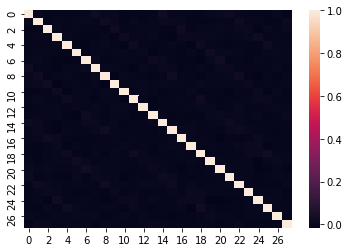

In [22]:
import seaborn as sbs

corr_mtx = np.corrcoef(x_train.reshape(28, 60000))
sbs.heatmap(corr_mtx)
plt.show()

# Random Forest Classifier (100 trees)

In [51]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=4)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.94      0.94      0.94       892
           6       0.96      0.98      0.97       958
           7       0.96      0.95      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.93      0.91      0.92      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9524
Confusion matrix, without normalization


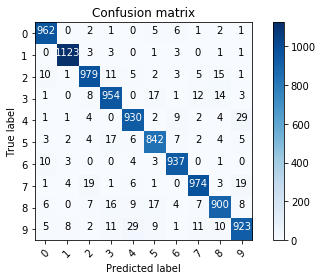

In [52]:
y_pred = rf.predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# AdaBoost Classifier (100 trees, max depth 10)

In [57]:
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=10),n_estimators = 100)
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.93      0.94       982
           5       0.91      0.93      0.92       892
           6       0.98      0.94      0.96       958
           7       0.97      0.92      0.95      1028
           8       0.88      0.96      0.92       974
           9       0.89      0.93      0.91      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000

0.9445
Confusion matrix, without normalization


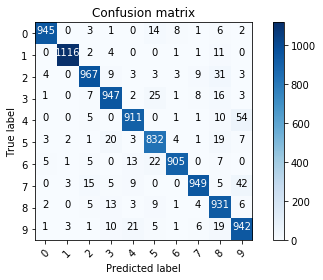

In [58]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# XGBoost Classifier (150 trees, max depth 10, 30 rounds)

In [139]:
import xgboost as xgb

num_round = 30

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

param = {
         "objective":"multi:softmax",
         "num_class":10,
         "max_depth":10,
         "n_estimators":150
        }

param['nthread'] = 4
param['eval_metric'] = 'merror'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

bst = xgb.train(param, dtrain, num_round, evallist)


[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[18:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10


[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[6]	eval-merror:0.0742	train-merror:0.0158
[18:44:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[18:44:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316

[18:44:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[12]	eval-merror:0.0631	train-merror:0.003733
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10


[18:45:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[25]	eval-merror:0.0491	train-merror:5e-05
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[18:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.94      0.95       982
           5       0.93      0.95      0.94       892
           6       0.97      0.97      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.93      0.92      0.93      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9524
Confusion matrix, without normalization


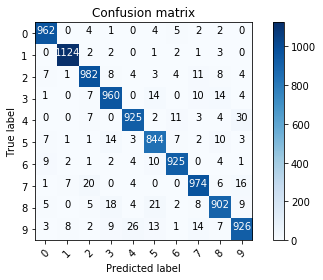

In [140]:
y_pred = bst.predict(dtest)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.94      0.94      0.94      1135
           2       0.86      0.83      0.85      1032
           3       0.84      0.84      0.84      1010
           4       0.86      0.87      0.86       982
           5       0.75      0.84      0.79       892
           6       0.91      0.91      0.91       958
           7       0.91      0.85      0.88      1028
           8       0.84      0.83      0.83       974
           9       0.84      0.83      0.84      1009

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

0.8683
Confusion matrix, without normalization


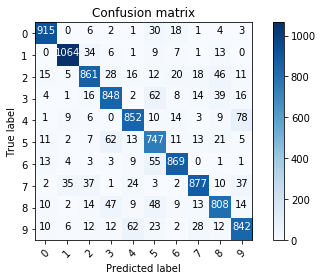

In [113]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# Gradient Boosting Classifier

In [ ]:
classf = GradientBoostingClassifier()
classf.fit(x_train, y_train)\
